# Utils

In [1]:
from collections import Counter, OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from typing import Tuple
from unidecode import unidecode

import emojis
import json
import lightgbm as lgb
import matplotlib
import numpy as np
import optuna
import pandas as pd
import re
import seaborn as sns
import spacy
import swifter

nlp = spacy.load('en_core_web_sm')

In [2]:
PATH_UKRAINE = "../data/ukraine/UkraineCombinedTweetsDeduped.csv.gzip"
PATH_TWIBOT = "../data/twibot/{}.json"

DATASET = "twibot"
# DATASET = "ukraine"

PATH = PATH_UKRAINE if DATASET == 'ukraine' else PATH_TWIBOT

In [3]:
DATE_REF = "2022-06-01"

SEED = 42
PARAMS = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'seed': SEED
}

In [4]:
def get_X_y(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """ Get training set / labels """
    return df.drop('label', axis=1), df['label']    

def get_train_val(df: pd.DataFrame) -> Tuple[pd.DataFrame]:
    """ Get train/validation/test datasets """
    X_train, X_val, y_train, y_val = train_test_split(*get_X_y(df),
                                                      test_size=0.2, 
                                                      random_state=SEED)
    return X_train, X_val, y_train, y_val

## Models

In [5]:
def train_clf(params: dict, 
              X_train: pd.DataFrame, 
              y_train: pd.Series, 
              X_val: pd.DataFrame, 
              y_val: pd.Series):
    """ Train LGBM Classifier """
    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_train, y_train,
            eval_set=[( X_val, y_val )],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(100)])
    return clf


def objective_func(trial, 
                   X_train: pd.DataFrame, 
                   y_train: pd.Series, 
                   X_val: pd.DataFrame, 
                   y_val: pd.Series):
    """ Train and evaluate LGBM Classifier """
    params = {
        **PARAMS,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.3),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    clf = train_clf(params, X_train, y_train, X_val, y_val)
    y_pred = clf.predict(X_val)
    return roc_auc_score(y_val, y_pred)


def get_best_clf(df_train: pd.DataFrame):
    """ Fine-tune LGBM Classifier hyperparameters """
    
    X_train, X_val, y_train, y_val = get_train_val(df_train)
    
    study = optuna.create_study(direction='maximize')
    objective = lambda trial: objective_func(trial, X_train, y_train, X_val, y_val)
    study.optimize(objective, n_trials=100, n_jobs=-1)
    
    print(study.best_params, "->", study.best_value)
    return train_clf(study.best_params, X_train, y_train, X_val, y_val)


def eval_clf(clf: lgb.LGBMClassifier, df_test: pd.DataFrame) -> None:
    """ Evaluate & show insights on best classifier """
    X_test, y_test = get_X_y(df_test)
    y_pred = clf.predict(X_test)
    
    # AUROC / accuracy
    auroc = roc_auc_score(y_test, y_pred)
    print('AUROC:', auroc)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)
    
    # Confusion matrix
    plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    
    # Features importance
    lgb.plot_importance(clf, max_num_features=15)

## Scores

In [6]:
def get_probas(clf: lgb.LGBMClassifier, df_train: pd.DataFrame, df_test: pd.DataFrame):
    """ Get LGBM Classifier predicted probas """
    X_train, X_test = get_X_y(df_train)[0], get_X_y(df_test)[0]
    y_train_pred = pd.Series([ y[0] for y in clf.predict_proba(X_train) ])
    y_test_pred = pd.Series([ y[0] for y in clf.predict_proba(X_test) ])
    return y_train_pred, y_test_pred


def compute_agg(ids: pd.Series, labels: pd.Series, preds: pd.Series) -> pd.DataFrame:
    """ Get min/max/mean/median, aggregated by user """
    df = pd.concat([ ids, labels, preds ], axis=1)
    df.columns = [ 'id', 'label', 'pred' ]
    
    df_agg = pd.concat([
        df.groupby('id').max()['label'],
        df.groupby('id').min()['pred'],
        df.groupby('id').max()['pred'],
        df.groupby('id').mean()['pred'],
        df.groupby('id').median()['pred']
    ], axis=1)
    df_agg.columns = [ 'label', 'min', 'max', 'mean', 'median' ]
    df_agg = df_agg.reset_index(drop=True)
    
    return df_agg


def get_agg(clf: lgb.LGBMClassifier, 
            df_train: pd.DataFrame, 
            df_test: pd.DataFrame, 
            ids_train: pd.Series, 
            ids_test: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """ Build aggregated set """
    
    y_train, y_test = get_X_y(df_train)[1], get_X_y(df_test)[1]
    y_train_pred, y_test_pred = get_probas(clf, df_train, df_test)
    
    df_train_agg = compute_agg(ids_train, y_train, y_train_pred)
    df_test_agg = compute_agg(ids_test, y_test, y_test_pred)
    return df_train_agg, df_test_agg

In [7]:
def get_mean(df: pd.DataFrame, ids: pd.Series) -> pd.DataFrame:
    """ Build averaged set """
    df = pd.concat([ df, ids ], axis=1)
    return df.groupby('id').mean()

def get_median(df: pd.DataFrame, ids: pd.Series) -> pd.DataFrame:
    """ Build median set """
    df = pd.concat([ df, ids ], axis=1)
    return df.groupby('id').median()

# Data preprocessing

## Main datasets

In [8]:
def load_ukraine() -> pd.DataFrame:
    """ Load and format Ukraine dataset """
    df = pd.read_csv(
        PATH_UKRAINE,
        compression= "gzip",
        index_col=0
    )
    df = df[[
        'userid', 'username', 'location',
        'following', 'followers', 'totaltweets',
        'usercreatedts', 'text'
    ]]
    df.columns = [
        'id', 'screen_name', 'location', 'friends_count',
        'followers_count', 'statuses_count', 'created_at',
        'tweet'
    ]
    return df


# def extract_following(neighbors: dict):
#     if neighbors is None:
#         return np.nan
#     return neighbors.get('following', np.nan)

# def extract_followers(neighbors: dict):
#     if neighbors is None:
#         return np.nan
#     return neighbors.get('follower', np.nan) 

def load_twibot(filename: str) -> pd.DataFrame:
    """ Load and format Twibot dataset """
    with open(PATH_TWIBOT.format(filename)) as f:
        data = json.load(f)
        
    df = pd.DataFrame.from_dict(data)
    df_profile = pd.DataFrame.from_dict(df['profile'].values.tolist())
    df = pd.concat([ df, df_profile ], axis=1)
    # df['following'] = df['neighbor'].apply(extract_following)
    # df['followers'] = df['neighbor'].apply(extract_followers)
    # df = df.drop([ 'ID', 'id_str', 'profile', 'neighbor' ], axis=1)
    
    return df[[
        'id', 'screen_name',  'description', 'location', 
        'followers_count', 'friends_count', 'statuses_count', 
        'created_at', 'tweet', 'label'
    ]]

## Extract metadata

In [9]:
POS_TAGS = [
    'ADJ', 'ADP', 'ADV', 'AUX',
    'CONJ', 'CCONJ', 'DET', 'INTJ',
    'NOUN', 'NUM', 'PART', 'PRON',
    'PROPN', 'PUNCT', 'SCONJ', 'SYM', 
    'VERB', 'X', 'SPACE'
]

In [10]:
def count_hashtags(text: str, end: bool = False):
    """ Count nb of hasthags at the very beginning/end of text """
    count, i = 0, 0
    hashtags = re.finditer(r"\w+#\s*", text[::-1]) if end else re.finditer(r"#\w+\s*", text)
    for hashtag in hashtags:
        if hashtag.span()[0] != i:
            break
        count += 1
        i = hashtag.span()[1]
    return count

def extract_symbols(text: str, symbol: str):
    """ Extract hashtags/cashtags/mentions """
    symbols = [ symbol[1:] for symbol in re.findall(fr"{symbol}\w+\b", text) ]
    text = re.sub(fr"{symbol}(?=\w+\b)", "", text)
    return text, symbols

def extract_links(text: str):
    """ Extract links """
    links = re.findall("https?://.+?(?=(?:\s|$))", text)
    for link in links:
        text = text.replace(link, "")
    return text, links

# TODO: Get emojis category? (use emojis, or advertools)
def extract_emojis(text: str):
    """ Extract emojis """
    # Doesn't get all emojis...
    text = emojis.decode(text)
    emoji_list = re.findall(r":(.+?):", text)
    for emoji in emoji_list:
        text = text.replace(f":{emoji}:", "")
    return text, emoji_list
    
def clean_text(text: str):
    """ Clean text from unknown characters """
    text_cleaned = unidecode(text)
    unk_chars_ratio = len(text_cleaned) / len(text) if text else 0
    text_cleaned = re.sub(r'\s+', ' ', text_cleaned)
    return text_cleaned, unk_chars_ratio


def extract_metadata(text: str):
    """ Extract metadata (nb of tokens, average token length, POS tags...)"""
    
    tokens = nlp(text)
    tokens_count = len(tokens)
    
    avg_token_len = 0
    tokens_diff_ratio = []
    pos_tags_count = OrderedDict({ tag: 0 for tag in POS_TAGS })
    
    for token in tokens:
        avg_token_len += len(token)
        tokens_diff_ratio.append(token.text)
        
        try:
            pos_tags_count[token.pos_] += 1
        except KeyError:
            print(token.pos_, "not in POS_TAGS")
        
    try:
        avg_token_len = avg_token_len / tokens_count
        tokens_diff_ratio = len(set(tokens_diff_ratio)) / tokens_count
    except ZeroDivisionError:
        tokens_diff_ratio = 0
            
    return tokens_count, avg_token_len, tokens_diff_ratio, *pos_tags_count.values()


def extract_desc_artefacts(text: str):
    """ Extract all artefacts from profile description """
    
    text_len = len(text)
    
    hashtags_start_count = count_hashtags(text)
    hashtags_end_count = count_hashtags(text, end=True)
    
    text, hashtags = extract_symbols(text, "#")
    text, mentions = extract_symbols(text, "@")
    text, cashtags = extract_symbols(text, "$")
    text, links = extract_links(text)
    
    text, emoji_list = extract_emojis(text)
    text, unk_chars_ratio = clean_text(text)
    text_clean_len = len(text)
    
    metadata = extract_metadata(text)
    
    return (
        text, text_len, text_clean_len,
        hashtags_start_count, hashtags_end_count,
        hashtags, mentions, cashtags, 
        links, emoji_list, unk_chars_ratio,
        *metadata
    )


def get_desc_artefacts(df: pd.DataFrame):   
    """ Process dataframe for metadata extraction from profiles descriptions """
    
    new_cols = [ 
        'description', 'desc_len', 'desc_clean_len',
        'desc_hashtags_start_count', 'desc_hashtags_end_count',
        'desc_hashtags', 'desc_mentions', 'desc_cashtags', 
        'desc_links', 'desc_emojis', 'desc_unk_chars_ratio',
        'tokens_count', 'avg_token_len', 'tokens_diff_ratio'
    ] + [ tag.lower() + "_count" for tag in POS_TAGS ]
    
    df[new_cols] = pd.DataFrame(
        df['description'].swifter.apply(extract_desc_artefacts).tolist(), 
        columns=new_cols
    )
    
    df['desc_hashtags_count'] = df['desc_hashtags'].apply(len)
    df['desc_mentions_count'] = df['desc_mentions'].apply(len)
    df['desc_cashtags_count'] = df['desc_cashtags'].apply(len)
    df['desc_links_count'] = df['desc_links'].apply(len)
    df['desc_emojis_count'] = df['desc_emojis'].apply(len)
    
    return df

## Build datasets

In [11]:
def build_df(filename: str = ""):
    """ Build and prepare dataset """

    if DATASET == 'ukraine':
        df = load_ukraine()
    else:
        df = load_twibot(filename)

    df['id'] = df['id'].astype(str).str.strip()
    df['screen_name'] = df['screen_name'].astype(str).str.strip()
    df['description'] = df['description'].astype(str).str.strip()
    df['location'] = df['location'].astype(str).str.strip()
    df['followers_count'] = df['followers_count'].astype(int)
    df['friends_count'] = df['friends_count'].astype(int)
    df['statuses_count'] = df['statuses_count'].astype(int)
    
    # Encoding labels
    df.loc[df['location'] == "", 'location'] = np.nan
    le = LabelEncoder()
    le.fit(df['location'].unique())
    df['location_enc'] = le.transform(df['location'])
    
    # Profile creation date
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['created_at_year'] = df['created_at'].dt.year
    df['created_at_month'] = df['created_at'].dt.month
    df['created_at_day'] = df['created_at'].dt.day
    df['created_at_date'] = (pd.Timestamp(DATE_REF).date() - df['created_at'].dt.date).dt.days.astype(int)
    df['created_at_hour'] = df['created_at'].dt.hour * 60 + df['created_at'].dt.minute
    df = df.drop('created_at', axis=1)
    
    # Extract profile description metadata
    df = get_desc_artefacts(df)
    
    # Feature engineering
    df['avg_daily_followers'] = np.round(df['followers_count'] / df['created_at_date'], 3)
    df['avg_daily_friends'] = np.round(df['friends_count'] / df['created_at_date'], 3)
    df['avg_daily_statuses'] = np.round(df['statuses_count'] / df['created_at_date'], 3)
    
    # Exploding tweets into several rows
    df = df.explode('tweet').reset_index(drop=True)
    df['tweet'] = df['tweet'].astype(str).str.strip()
    df['label'] = df['label'].astype(int)
    
    print(df.shape)
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    return df

In [12]:
df_train = build_df('train')
df_test = build_df('test')

Pandas Apply:   0%|          | 0/8278 [00:00<?, ?it/s]

(1398465, 55)


Pandas Apply:   0%|          | 0/1183 [00:00<?, ?it/s]

(199863, 55)


In [13]:
df_train.to_csv(PATH.format('train_prep'))
df_test.to_csv(PATH.format('test_prep'))

In [14]:
df_train = pd.read_csv(PATH.format('train_prep'), index_col='Unnamed: 0')
df_test = pd.read_csv(PATH.format('test_prep'), index_col='Unnamed: 0')

# Detection on users metadata

## Aggregating by user

In [15]:
def agg_users(df: pd.DataFrame):
    """ Aggregate rows by user """
    df_users = df.drop('tweet', axis=1)
    df_users = df_users.drop_duplicates()
    df_users = df_users.sample(frac=1).reset_index(drop=True)
    return df_users

df_train_users = agg_users(df_train)
df_test_users = agg_users(df_test)

In [16]:
df_train_users.to_csv(PATH.format('train_users_prep'))
df_test_users.to_csv(PATH.format('test_users_prep'))

In [17]:
df_train_users = pd.read_csv(PATH.format('train_users_prep'), index_col='Unnamed: 0')
df_test_users = pd.read_csv(PATH.format('test_users_prep'), index_col='Unnamed: 0')

In [18]:
def filter_metadata(df: pd.DataFrame):
    """ Drop un-processable features """
    return df.drop([ 'location', 'screen_name', 'id',
                     'description', 'desc_hashtags', 'desc_mentions', 
                     'desc_cashtags', 'desc_links', 'desc_emojis' ], axis=1)

df_train_users = filter_metadata(df_train_users)
df_test_users = filter_metadata(df_test_users)

## EDA

In [6]:
df_train_users['label'].mean()

0.5612466779415318

In [7]:
def plot_distrib(colname: str):
    print(colname)
    # Humans
    df_train_users[df_train_users['label'] == 0][colname].plot.hist(alpha=0.5, bins=100, logy=True)
    # Bots
    df_train_users[df_train_users['label'] == 1][colname].plot.hist(alpha=0.5, bins=100, logy=True)
    plt.show()

followers_count


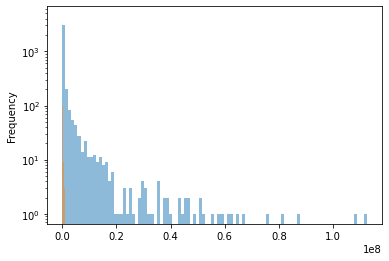

friends_count


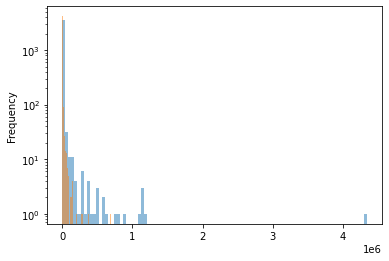

statuses_count


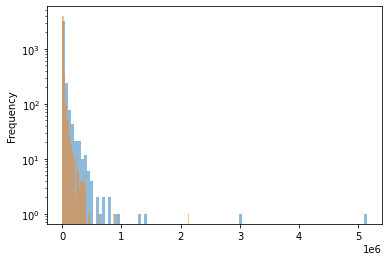

In [8]:
plot_distrib('followers_count')
plot_distrib('friends_count')
plot_distrib('statuses_count')

In [9]:
cmap = matplotlib.colors.ListedColormap(['blue', 'red'])

def plot_scatter(colname_1: str, colname_2: str, **kwargs):
    df_train_users.plot.scatter(colname_1, 
                                colname_2,
                                c='label', 
                                alpha=0.05,
                                cmap=cmap,
                                loglog=True,
                                **kwargs)
    plt.show()

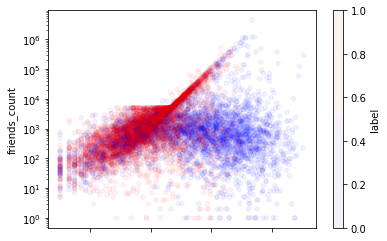

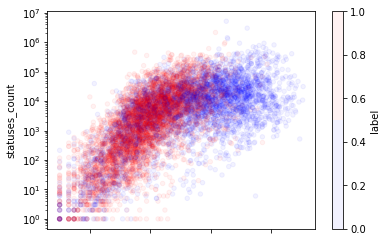

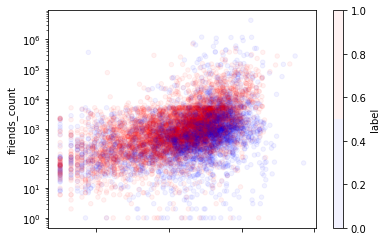

In [10]:
plot_scatter('followers_count', 'friends_count')
plot_scatter('followers_count', 'statuses_count')
plot_scatter('statuses_count', 'friends_count')

## Training

In [19]:
clf_users = get_best_clf(df_train_users)

[I 2022-04-10 18:17:16,147] A new study created in memory with name: no-name-fb595f16-046f-4b88-a88e-42abc10ef2bb


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds



[I 2022-04-10 18:17:17,072] Trial 6 finished with value: 0.7024020031465354 and parameters: {'lambda_l1': 3.3212458047140507, 'lambda_l2': 0.2687737282826507, 'num_leaves': 13, 'feature_fraction': 0.9842145375009822, 'bagging_fraction': 0.4415764869205177, 'bagging_freq': 4, 'learning_rate': 0.004991022207891122, 'min_child_samples': 48}. Best is trial 6 with value: 0.7024020031465354.


Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.79358
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:17,334] Trial 2 finished with value: 0.7331915176494052 and parameters: {'lambda_l1': 0.01901238969745201, 'lambda_l2': 0.005030898583253697, 'num_leaves': 147, 'feature_fraction': 0.8234754137176765, 'bagging_fraction': 0.4733952947852317, 'bagging_freq': 2, 'learning_rate': 0.012897267397277768, 'min_child_samples': 100}. Best is trial 2 with value: 0.7331915176494052.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.801458
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:17,542] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 4.246952878622734e-07, 'lambda_l2': 6.192806311801245e-06, 'num_leaves': 178, 'feature_fraction': 0.7537576889561153, 'bagging_fraction': 0.40130523045864636, 'bagging_freq': 3, 'learning_rate': 2.6283740485499224e-05, 'min_child_samples': 62}. Best is trial 2 with value: 0.7331915176494052.


Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.797308
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:18,060] Trial 7 finished with value: 0.7320148906468125 and parameters: {'lambda_l1': 1.8505157752435374e-08, 'lambda_l2': 3.158515499282469, 'num_leaves': 99, 'feature_fraction': 0.9213289221420651, 'bagging_fraction': 0.9560866580922328, 'bagging_freq': 2, 'learning_rate': 0.06530402196177018, 'min_child_samples': 98}. Best is trial 2 with value: 0.7331915176494052.
[I 2022-04-10 18:17:18,217] Trial 0 finished with value: 0.7260298256110262 and parameters: {'lambda_l1': 1.1217315291942851e-07, 'lambda_l2': 2.301880749758676e-08, 'num_leaves': 69, 'feature_fraction': 0.9950010621970333, 'bagging_fraction': 0.5631455316858031, 'bagging_freq': 1, 'learning_rate': 0.1174372974805443, 'min_child_samples': 14}. Best is trial 2 with value: 0.7331915176494052.


Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.804475
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.795765
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:18,671] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 1.1672602828689734e-07, 'lambda_l2': 5.361347086154722, 'num_leaves': 239, 'feature_fraction': 0.5455245587459747, 'bagging_fraction': 0.8741581979792455, 'bagging_freq': 5, 'learning_rate': 0.0010368903057331564, 'min_child_samples': 31}. Best is trial 2 with value: 0.7331915176494052.
[I 2022-04-10 18:17:18,750] Trial 8 finished with value: 0.7314520596512221 and parameters: {'lambda_l1': 0.12972724683508574, 'lambda_l2': 5.535056409773786, 'num_leaves': 255, 'feature_fraction': 0.9273674962443118, 'bagging_fraction': 0.43494444128386406, 'bagging_freq': 7, 'learning_rate': 0.025906570151547216, 'min_child_samples': 24}. Best is trial 2 with value: 0.7331915176494052.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.792088
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.796837
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:18,906] Trial 11 finished with value: 0.7355071018635468 and parameters: {'lambda_l1': 1.1571064976192311, 'lambda_l2': 1.6925437476444573e-06, 'num_leaves': 106, 'feature_fraction': 0.8518528548179221, 'bagging_fraction': 0.5039022415578012, 'bagging_freq': 1, 'learning_rate': 0.013244114587192221, 'min_child_samples': 90}. Best is trial 11 with value: 0.7355071018635468.
[I 2022-04-10 18:17:18,922] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 1.3711628423963322, 'lambda_l2': 0.5049767461541281, 'num_leaves': 22, 'feature_fraction': 0.6962529062224219, 'bagging_fraction': 0.4297550452749772, 'bagging_freq': 6, 'learning_rate': 1.0521990760887848e-05, 'min_child_samples': 6}. Best is trial 11 with value: 0.7355071018635468.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.801386
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.79498
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:19,173] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 9.361125427590068e-05, 'lambda_l2': 0.0005717834503514056, 'num_leaves': 79, 'feature_fraction': 0.8806400907967024, 'bagging_fraction': 0.9129789906808344, 'bagging_freq': 5, 'learning_rate': 0.00011807609729193879, 'min_child_samples': 67}. Best is trial 11 with value: 0.7355071018635468.


Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.795853
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:20,068] Trial 16 finished with value: 0.734598595138381 and parameters: {'lambda_l1': 1.0761152603526329e-08, 'lambda_l2': 4.588180450009826e-06, 'num_leaves': 47, 'feature_fraction': 0.7556878401493381, 'bagging_fraction': 0.7719224588227602, 'bagging_freq': 1, 'learning_rate': 0.1150384558745471, 'min_child_samples': 54}. Best is trial 11 with value: 0.7355071018635468.
[I 2022-04-10 18:17:20,162] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 2.2370724431188252e-05, 'lambda_l2': 1.0969745488511087, 'num_leaves': 196, 'feature_fraction': 0.5805919927677821, 'bagging_fraction': 0.6113278195132879, 'bagging_freq': 4, 'learning_rate': 0.0002974353274030164, 'min_child_samples': 17}. Best is trial 11 with value: 0.7355071018635468.


Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.800259
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.796622
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:20,381] Trial 13 finished with value: 0.7309158190963683 and parameters: {'lambda_l1': 0.01118957292582265, 'lambda_l2': 5.549727251581883e-05, 'num_leaves': 45, 'feature_fraction': 0.7942497397114681, 'bagging_fraction': 0.4324151018858287, 'bagging_freq': 7, 'learning_rate': 0.0312855200290352, 'min_child_samples': 9}. Best is trial 11 with value: 0.7355071018635468.
[I 2022-04-10 18:17:20,444] Trial 14 finished with value: 0.7171131644840345 and parameters: {'lambda_l1': 0.0012006655160537926, 'lambda_l2': 0.0024940373531856744, 'num_leaves': 42, 'feature_fraction': 0.5333208828683973, 'bagging_fraction': 0.6164212742665185, 'bagging_freq': 5, 'learning_rate': 0.00553809026805304, 'min_child_samples': 46}. Best is trial 11 with value: 0.7355071018635468.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.803303
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.800422


[I 2022-04-10 18:17:20,726] Trial 17 finished with value: 0.5 and parameters: {'lambda_l1': 0.00045547771386602557, 'lambda_l2': 3.9823176471460213e-07, 'num_leaves': 188, 'feature_fraction': 0.40002603790487695, 'bagging_fraction': 0.6731938786907317, 'bagging_freq': 1, 'learning_rate': 0.0006249828549774505, 'min_child_samples': 80}. Best is trial 11 with value: 0.7355071018635468.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.794067


[I 2022-04-10 18:17:20,851] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 0.0010056887585422718, 'lambda_l2': 0.00013590363075622917, 'num_leaves': 107, 'feature_fraction': 0.46180424259836395, 'bagging_fraction': 0.7969482125655352, 'bagging_freq': 4, 'learning_rate': 0.0008169723830335446, 'min_child_samples': 10}. Best is trial 11 with value: 0.7355071018635468.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.800638
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:21,306] Trial 18 finished with value: 0.7223736400097498 and parameters: {'lambda_l1': 3.722430042199017e-05, 'lambda_l2': 3.2393198678457067e-06, 'num_leaves': 49, 'feature_fraction': 0.6495626494305535, 'bagging_fraction': 0.7305900171141977, 'bagging_freq': 1, 'learning_rate': 0.2993937691318275, 'min_child_samples': 80}. Best is trial 11 with value: 0.7355071018635468.


Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.800067
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:21,698] Trial 10 finished with value: 0.7277360455582884 and parameters: {'lambda_l1': 2.31607117013704e-05, 'lambda_l2': 2.38509269363903e-06, 'num_leaves': 226, 'feature_fraction': 0.7195186003461151, 'bagging_fraction': 0.7383500408803745, 'bagging_freq': 7, 'learning_rate': 0.00896211565481462, 'min_child_samples': 24}. Best is trial 11 with value: 0.7355071018635468.
[I 2022-04-10 18:17:21,761] Trial 15 finished with value: 0.7381306920162203 and parameters: {'lambda_l1': 5.245300378410505e-07, 'lambda_l2': 0.040205108108907164, 'num_leaves': 195, 'feature_fraction': 0.589568761416889, 'bagging_fraction': 0.7791727327971192, 'bagging_freq': 2, 'learning_rate': 0.08752754220090929, 'min_child_samples': 47}. Best is trial 15 with value: 0.7381306920162203.


Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.803152
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.804662


[I 2022-04-10 18:17:21,887] Trial 19 finished with value: 0.731884154313191 and parameters: {'lambda_l1': 0.003878541255582874, 'lambda_l2': 7.125802114609713e-07, 'num_leaves': 53, 'feature_fraction': 0.6708258465132314, 'bagging_fraction': 0.8012644509261462, 'bagging_freq': 1, 'learning_rate': 0.16984398016197697, 'min_child_samples': 79}. Best is trial 15 with value: 0.7381306920162203.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.797331
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:22,074] Trial 21 finished with value: 0.7386802277914424 and parameters: {'lambda_l1': 4.201016495349209e-06, 'lambda_l2': 5.332729474604652e-07, 'num_leaves': 115, 'feature_fraction': 0.663994997616187, 'bagging_fraction': 0.7869494154564589, 'bagging_freq': 1, 'learning_rate': 0.27296356981079395, 'min_child_samples': 84}. Best is trial 21 with value: 0.7386802277914424.
[I 2022-04-10 18:17:22,143] Trial 20 finished with value: 0.7254935850561723 and parameters: {'lambda_l1': 0.0007226856155070966, 'lambda_l2': 3.7012350751311715e-07, 'num_leaves': 126, 'feature_fraction': 0.6918042661224777, 'bagging_fraction': 0.7670211574239719, 'bagging_freq': 1, 'learning_rate': 0.26601408519446207, 'min_child_samples': 75}. Best is trial 21 with value: 0.7386802277914424.


Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.795883
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.797886
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:22,545] Trial 22 finished with value: 0.734213033747701 and parameters: {'lambda_l1': 1.0499676843845249e-05, 'lambda_l2': 3.407988362938067e-06, 'num_leaves': 113, 'feature_fraction': 0.6896673691438705, 'bagging_fraction': 0.7918415196935495, 'bagging_freq': 2, 'learning_rate': 0.2789972511059735, 'min_child_samples': 81}. Best is trial 21 with value: 0.7386802277914424.
[I 2022-04-10 18:17:22,623] Trial 23 finished with value: 0.7363779387976689 and parameters: {'lambda_l1': 3.10480952672176e-06, 'lambda_l2': 1.3137861861256822e-06, 'num_leaves': 144, 'feature_fraction': 0.6558277670695829, 'bagging_fraction': 0.7247783522790503, 'bagging_freq': 2, 'learning_rate': 0.18290700549226224, 'min_child_samples': 78}. Best is trial 21 with value: 0.7386802277914424.
[I 2022-04-10 18:17:22,717] Trial 24 finished with value: 0.7328524895300139 and parameters: {'lambda_l1': 3.462596555674796e-06, 'lambda_l2': 4.205716247542835e-08, 'num_leaves': 137, 'feature_fraction': 0.

Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.798402
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.799761
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.793677
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:23,392] Trial 25 finished with value: 0.742356356223271 and parameters: {'lambda_l1': 2.1297416871258825e-06, 'lambda_l2': 3.759215251503651e-08, 'num_leaves': 142, 'feature_fraction': 0.8297846234164623, 'bagging_fraction': 0.8283211467895631, 'bagging_freq': 2, 'learning_rate': 0.2774140734904899, 'min_child_samples': 86}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.805611
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:23,926] Trial 29 finished with value: 0.7306476988189412 and parameters: {'lambda_l1': 2.2206263526974726e-06, 'lambda_l2': 1.0665682521319272e-08, 'num_leaves': 160, 'feature_fraction': 0.574832179544255, 'bagging_fraction': 0.8569139236494066, 'bagging_freq': 2, 'learning_rate': 0.04403637381767069, 'min_child_samples': 89}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:23,941] Trial 28 finished with value: 0.7337742914755478 and parameters: {'lambda_l1': 2.073270311439021e-06, 'lambda_l2': 1.1317474973714886e-08, 'num_leaves': 134, 'feature_fraction': 0.5987246132732182, 'bagging_fraction': 0.842294956306056, 'bagging_freq': 2, 'learning_rate': 0.027940753686629505, 'min_child_samples': 89}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.80567
Did not meet early stopping. Best iteration is:
[46]	valid_0's auc: 0.806105
Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.80252


[I 2022-04-10 18:17:24,051] Trial 26 finished with value: 0.638520685147023 and parameters: {'lambda_l1': 5.978727214526487e-06, 'lambda_l2': 0.04139107432586787, 'num_leaves': 142, 'feature_fraction': 0.6587934778624367, 'bagging_fraction': 0.5274673680154743, 'bagging_freq': 2, 'learning_rate': 0.0031175686949281235, 'min_child_samples': 37}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:24,224] Trial 30 finished with value: 0.7355469875246515 and parameters: {'lambda_l1': 2.5422700247939548e-06, 'lambda_l2': 1.751050458713096e-08, 'num_leaves': 156, 'feature_fraction': 0.5953845766379056, 'bagging_fraction': 0.8371484182317676, 'bagging_freq': 3, 'learning_rate': 0.043522875175965745, 'min_child_samples': 94}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:24,286] Trial 27 finished with value: 0.733512818808305 and parameters: {'lambda_l1': 2.4402093719873602e-06, 'lambda_l2': 0.05243907575684664, 'num_leaves': 145, 'feature_fraction': 0.62

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.806473
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.805323
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:24,506] Trial 32 finished with value: 0.7349974517494293 and parameters: {'lambda_l1': 1.9438600580757047e-06, 'lambda_l2': 0.034343689829043615, 'num_leaves': 160, 'feature_fraction': 0.6190058589146998, 'bagging_fraction': 0.8607342192453292, 'bagging_freq': 3, 'learning_rate': 0.05242546909566474, 'min_child_samples': 65}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.804003
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:25,729] Trial 39 finished with value: 0.7352855148574087 and parameters: {'lambda_l1': 3.6197692403998623e-07, 'lambda_l2': 2.5680706935700576e-05, 'num_leaves': 214, 'feature_fraction': 0.5128093587210449, 'bagging_fraction': 0.682986813336496, 'bagging_freq': 3, 'learning_rate': 0.11514589542473196, 'min_child_samples': 71}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.805696
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:25,948] Trial 38 finished with value: 0.7279399056039354 and parameters: {'lambda_l1': 3.9012763564522185e-07, 'lambda_l2': 9.26377756160923e-08, 'num_leaves': 209, 'feature_fraction': 0.4979736777384631, 'bagging_fraction': 0.6887644989770496, 'bagging_freq': 3, 'learning_rate': 0.11836314843516958, 'min_child_samples': 67}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.801791
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:26,231] Trial 36 finished with value: 0.7341997385273327 and parameters: {'lambda_l1': 5.933146602059223e-07, 'lambda_l2': 4.5741747732760595e-08, 'num_leaves': 206, 'feature_fraction': 0.5008049803299321, 'bagging_fraction': 0.9104497188408824, 'bagging_freq': 3, 'learning_rate': 0.07742989714431886, 'min_child_samples': 68}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:26,278] Trial 31 finished with value: 0.7371690044095814 and parameters: {'lambda_l1': 2.620499352331115e-06, 'lambda_l2': 1.6404867841554263e-08, 'num_leaves': 152, 'feature_fraction': 0.6172596283168952, 'bagging_fraction': 0.8563578134653169, 'bagging_freq': 3, 'learning_rate': 0.051217797052034914, 'min_child_samples': 39}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:26,372] Trial 35 finished with value: 0.7283387622149836 and parameters: {'lambda_l1': 3.2167547597633957e-07, 'lambda_l2': 0.04784151140435842, 'num_leaves': 209, 'feature_fraction': 0

Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.801916
Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.799762
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.802253
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:26,686] Trial 37 finished with value: 0.7317334751490172 and parameters: {'lambda_l1': 2.272507244981978e-07, 'lambda_l2': 1.1492269152210396e-07, 'num_leaves': 218, 'feature_fraction': 0.491250213609127, 'bagging_fraction': 0.9992226081285777, 'bagging_freq': 3, 'learning_rate': 0.09137393749339882, 'min_child_samples': 64}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.801813
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:27,030] Trial 40 finished with value: 0.7316093864255799 and parameters: {'lambda_l1': 1.999103354610464e-07, 'lambda_l2': 1.1713040115341963e-07, 'num_leaves': 86, 'feature_fraction': 0.7914335772665262, 'bagging_fraction': 0.7183091988114163, 'bagging_freq': 3, 'learning_rate': 0.1051479435260487, 'min_child_samples': 73}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.801581
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:27,374] Trial 33 finished with value: 0.7345786523078286 and parameters: {'lambda_l1': 9.03231507371676e-07, 'lambda_l2': 0.011225029118984608, 'num_leaves': 162, 'feature_fraction': 0.5890405423957692, 'bagging_fraction': 0.8720721914042732, 'bagging_freq': 3, 'learning_rate': 0.052526704295907015, 'min_child_samples': 35}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.799894
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:27,719] Trial 34 finished with value: 0.7199206718518026 and parameters: {'lambda_l1': 6.063073241096215e-07, 'lambda_l2': 0.07631846187775015, 'num_leaves': 208, 'feature_fraction': 0.6325842510761147, 'bagging_fraction': 0.9997132939094984, 'bagging_freq': 3, 'learning_rate': 0.06777207651434841, 'min_child_samples': 39}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.799388
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:28,314] Trial 42 finished with value: 0.7382680759600257 and parameters: {'lambda_l1': 7.93520826186108e-05, 'lambda_l2': 9.217105630762921e-08, 'num_leaves': 83, 'feature_fraction': 0.7822166036443715, 'bagging_fraction': 0.6502194648797524, 'bagging_freq': 1, 'learning_rate': 0.10253572221302515, 'min_child_samples': 58}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[28]	valid_0's auc: 0.806034
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:28,628] Trial 41 finished with value: 0.7341864433069645 and parameters: {'lambda_l1': 7.077416697454599e-08, 'lambda_l2': 1.19331768654759e-07, 'num_leaves': 88, 'feature_fraction': 0.7946293153993537, 'bagging_fraction': 0.891729682498467, 'bagging_freq': 1, 'learning_rate': 0.13914213886159318, 'min_child_samples': 58}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:28,801] Trial 43 finished with value: 0.729548627268497 and parameters: {'lambda_l1': 5.1338292306825125e-08, 'lambda_l2': 1.5270681715243582e-07, 'num_leaves': 178, 'feature_fraction': 0.808820815518457, 'bagging_fraction': 0.9170406949367189, 'bagging_freq': 3, 'learning_rate': 0.01730713621017692, 'min_child_samples': 58}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.8027
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.80649
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.803992


[I 2022-04-10 18:17:28,864] Trial 44 finished with value: 0.7307717875423785 and parameters: {'lambda_l1': 6.558053721114583e-08, 'lambda_l2': 1.3072238399288195e-07, 'num_leaves': 175, 'feature_fraction': 0.7809833228423778, 'bagging_fraction': 0.9183788383224053, 'bagging_freq': 4, 'learning_rate': 0.01417458242504645, 'min_child_samples': 60}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.803284


[I 2022-04-10 18:17:29,005] Trial 46 finished with value: 0.7326752199251035 and parameters: {'lambda_l1': 4.126786649445745e-08, 'lambda_l2': 1.4214600327950916e-05, 'num_leaves': 177, 'feature_fraction': 0.5686176074371952, 'bagging_fraction': 0.8927416493309211, 'bagging_freq': 4, 'learning_rate': 0.017335976482407194, 'min_child_samples': 59}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:29,585] Trial 45 finished with value: 0.7310332602096212 and parameters: {'lambda_l1': 5.8445263363410916e-08, 'lambda_l2': 1.8750628254848631e-07, 'num_leaves': 179, 'feature_fraction': 0.5476229932940363, 'bagging_fraction': 0.900884895532887, 'bagging_freq': 4, 'learning_rate': 0.01391115007078985, 'min_child_samples': 54}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.803281
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:29,977] Trial 48 finished with value: 0.7315960912052117 and parameters: {'lambda_l1': 3.42156334974241e-08, 'lambda_l2': 2.0828738698633703e-05, 'num_leaves': 178, 'feature_fraction': 0.7360085065470019, 'bagging_fraction': 0.6451222593375769, 'bagging_freq': 2, 'learning_rate': 0.01790549470919417, 'min_child_samples': 57}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.806098
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:30,306] Trial 47 finished with value: 0.7303330452702254 and parameters: {'lambda_l1': 4.683552648413689e-08, 'lambda_l2': 0.00037294213743762093, 'num_leaves': 173, 'feature_fraction': 0.5536314481813387, 'bagging_fraction': 0.9346643768267378, 'bagging_freq': 4, 'learning_rate': 0.014008945474991537, 'min_child_samples': 57}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.802053
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.803724


[I 2022-04-10 18:17:30,494] Trial 49 finished with value: 0.7258724988366682 and parameters: {'lambda_l1': 6.059906476416092e-08, 'lambda_l2': 1.6099228903221715e-05, 'num_leaves': 176, 'feature_fraction': 0.7856553607134503, 'bagging_fraction': 0.6217812269066513, 'bagging_freq': 1, 'learning_rate': 0.01640044853758421, 'min_child_samples': 58}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:30,730] Trial 53 finished with value: 0.5 and parameters: {'lambda_l1': 0.00014365190115146008, 'lambda_l2': 0.0003316323011083108, 'num_leaves': 123, 'feature_fraction': 0.8550785950838845, 'bagging_fraction': 0.6218722779304031, 'bagging_freq': 1, 'learning_rate': 7.06864666228119e-05, 'min_child_samples': 45}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.799885
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:31,169] Trial 50 finished with value: 0.7284827937689734 and parameters: {'lambda_l1': 0.00010415944587503517, 'lambda_l2': 0.000669673084152089, 'num_leaves': 119, 'feature_fraction': 0.8359726693875913, 'bagging_fraction': 0.6283025361592693, 'bagging_freq': 4, 'learning_rate': 0.18878138472389763, 'min_child_samples': 44}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.796944
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:31,661] Trial 51 finished with value: 0.7334995235879369 and parameters: {'lambda_l1': 0.00010373583297958371, 'lambda_l2': 0.0006315248548552927, 'num_leaves': 121, 'feature_fraction': 0.8461320681014665, 'bagging_fraction': 0.6338545112948725, 'bagging_freq': 4, 'learning_rate': 0.015781087742315486, 'min_child_samples': 42}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:31,717] Trial 52 finished with value: 0.7310731458707261 and parameters: {'lambda_l1': 0.00010924921216286728, 'lambda_l2': 1.412032723167066e-05, 'num_leaves': 124, 'feature_fraction': 0.9026788622572355, 'bagging_fraction': 0.6479167550895282, 'bagging_freq': 1, 'learning_rate': 0.1630672966511659, 'min_child_samples': 45}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.803848
Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.796845


[I 2022-04-10 18:17:31,921] Trial 58 finished with value: 0.7257750005539676 and parameters: {'lambda_l1': 1.3794141426120208e-05, 'lambda_l2': 3.209837782441895e-08, 'num_leaves': 70, 'feature_fraction': 0.9158837793075236, 'bagging_fraction': 0.7536417898102885, 'bagging_freq': 2, 'learning_rate': 0.18751090839704207, 'min_child_samples': 99}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:32,000] Trial 54 finished with value: 0.6088568326353343 and parameters: {'lambda_l1': 0.00010234048375428804, 'lambda_l2': 0.001046584384178071, 'num_leaves': 122, 'feature_fraction': 0.8414381135462218, 'bagging_fraction': 0.6559878449988383, 'bagging_freq': 1, 'learning_rate': 0.0015741496085607783, 'min_child_samples': 44}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.803178
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.801499
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:32,815] Trial 55 finished with value: 0.5 and parameters: {'lambda_l1': 9.641592814770232e-05, 'lambda_l2': 3.606590550221954e-08, 'num_leaves': 115, 'feature_fraction': 0.8388053836294955, 'bagging_fraction': 0.8212399882356656, 'bagging_freq': 1, 'learning_rate': 0.00015843098469576488, 'min_child_samples': 45}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.797859
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:33,082] Trial 56 finished with value: 0.5 and parameters: {'lambda_l1': 0.00017256454007376582, 'lambda_l2': 4.099036864953386e-08, 'num_leaves': 126, 'feature_fraction': 0.848921840923487, 'bagging_fraction': 0.8193538464353647, 'bagging_freq': 1, 'learning_rate': 0.0001585837885397061, 'min_child_samples': 45}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.798054
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:33,395] Trial 57 finished with value: 0.5 and parameters: {'lambda_l1': 0.00011394307074734334, 'lambda_l2': 0.0012563956697155111, 'num_leaves': 119, 'feature_fraction': 0.8341954522602235, 'bagging_fraction': 0.7577516867442898, 'bagging_freq': 1, 'learning_rate': 7.525076959111548e-05, 'min_child_samples': 45}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.800264


[I 2022-04-10 18:17:33,615] Trial 62 finished with value: 0.6274989474617209 and parameters: {'lambda_l1': 3.353931878678961e-05, 'lambda_l2': 1.045680756828198e-06, 'num_leaves': 102, 'feature_fraction': 0.9680429790369206, 'bagging_fraction': 0.5817065035412464, 'bagging_freq': 2, 'learning_rate': 0.0016730377047150223, 'min_child_samples': 49}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.798531
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:34,180] Trial 61 finished with value: 0.7289082408207582 and parameters: {'lambda_l1': 1.3526507638117262e-05, 'lambda_l2': 1.0881599702747007e-06, 'num_leaves': 62, 'feature_fraction': 0.717184138373155, 'bagging_fraction': 0.5825849448880412, 'bagging_freq': 2, 'learning_rate': 0.18951335285065657, 'min_child_samples': 28}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.800049
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:34,556] Trial 60 finished with value: 0.7302421945977088 and parameters: {'lambda_l1': 1.3113152223765873e-05, 'lambda_l2': 9.624912291375676e-07, 'num_leaves': 64, 'feature_fraction': 0.8916913546125965, 'bagging_fraction': 0.8230761944533388, 'bagging_freq': 2, 'learning_rate': 0.18397225011730195, 'min_child_samples': 31}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.797362
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:34,870] Trial 63 finished with value: 0.7324403376985973 and parameters: {'lambda_l1': 2.7568091054364882e-05, 'lambda_l2': 1.0333700686825383e-06, 'num_leaves': 105, 'feature_fraction': 0.7176872464955435, 'bagging_fraction': 0.8176451516775386, 'bagging_freq': 2, 'learning_rate': 0.21100283019199695, 'min_child_samples': 49}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:34,967] Trial 59 finished with value: 0.7224068780606705 and parameters: {'lambda_l1': 1.7106310995395416e-05, 'lambda_l2': 3.684354649941243e-08, 'num_leaves': 99, 'feature_fraction': 0.9073066822063028, 'bagging_fraction': 0.5774814698971116, 'bagging_freq': 2, 'learning_rate': 0.19953800349899764, 'min_child_samples': 29}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.800523
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.791908
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:35,811] Trial 68 finished with value: 0.7318775067030069 and parameters: {'lambda_l1': 5.652886291617277e-06, 'lambda_l2': 3.802691822446547e-07, 'num_leaves': 152, 'feature_fraction': 0.6682109138752946, 'bagging_fraction': 0.8340517538953983, 'bagging_freq': 2, 'learning_rate': 0.03465730500925029, 'min_child_samples': 95}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.806351
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.799326
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:35,983] Trial 69 finished with value: 0.725701876841942 and parameters: {'lambda_l1': 5.162547700907163e-06, 'lambda_l2': 2.987780819360482e-07, 'num_leaves': 151, 'feature_fraction': 0.6697634793647851, 'bagging_fraction': 0.7093627167970885, 'bagging_freq': 5, 'learning_rate': 0.008413248921188624, 'min_child_samples': 94}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:36,517] Trial 70 finished with value: 0.7168450442066078 and parameters: {'lambda_l1': 5.49791031607874e-06, 'lambda_l2': 3.664928779534481e-07, 'num_leaves': 150, 'feature_fraction': 0.6662571491998381, 'bagging_fraction': 0.7120339392570746, 'bagging_freq': 2, 'learning_rate': 0.006303959068263909, 'min_child_samples': 94}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.797522


[I 2022-04-10 18:17:36,721] Trial 64 finished with value: 0.7212014447472799 and parameters: {'lambda_l1': 3.8011544544685466e-05, 'lambda_l2': 1.0752406231625566e-06, 'num_leaves': 106, 'feature_fraction': 0.714216689945323, 'bagging_fraction': 0.5812569645496661, 'bagging_freq': 2, 'learning_rate': 0.006861425253942924, 'min_child_samples': 27}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:36,871] Trial 71 finished with value: 0.7233796450176162 and parameters: {'lambda_l1': 1.1375359819968249e-06, 'lambda_l2': 3.316919445840651e-07, 'num_leaves': 150, 'feature_fraction': 0.6090530726954598, 'bagging_fraction': 0.7162583286081603, 'bagging_freq': 2, 'learning_rate': 0.007666385486892671, 'min_child_samples': 95}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.805173
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.799903


[I 2022-04-10 18:17:37,003] Trial 67 finished with value: 0.7248066653371446 and parameters: {'lambda_l1': 5.719806640941197e-06, 'lambda_l2': 0.00012153699077595447, 'num_leaves': 244, 'feature_fraction': 0.6775202222650856, 'bagging_fraction': 0.7083831211576378, 'bagging_freq': 2, 'learning_rate': 0.1913389969071025, 'min_child_samples': 26}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.78259
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:37,330] Trial 66 finished with value: 0.7227791442309823 and parameters: {'lambda_l1': 6.587585591285687e-06, 'lambda_l2': 7.751526369293314e-07, 'num_leaves': 97, 'feature_fraction': 0.7136836116248559, 'bagging_fraction': 0.7014326103348856, 'bagging_freq': 2, 'learning_rate': 0.21526473541216104, 'min_child_samples': 28}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.790909
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:38,052] Trial 72 finished with value: 0.7235170289614217 and parameters: {'lambda_l1': 1.0940030925526678e-06, 'lambda_l2': 1.6067610776605228e-08, 'num_leaves': 153, 'feature_fraction': 0.6394672672288535, 'bagging_fraction': 0.7116136723684853, 'bagging_freq': 6, 'learning_rate': 0.007252593245111806, 'min_child_samples': 94}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:38,083] Trial 65 finished with value: 0.725369496332735 and parameters: {'lambda_l1': 6.54470185208389e-06, 'lambda_l2': 5.784721585075068e-07, 'num_leaves': 243, 'feature_fraction': 0.979837741322585, 'bagging_fraction': 0.7141130402509767, 'bagging_freq': 2, 'learning_rate': 0.20506353619581866, 'min_child_samples': 28}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.798012
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.790618


[I 2022-04-10 18:17:38,384] Trial 73 finished with value: 0.7328258990892774 and parameters: {'lambda_l1': 1.0550927594170222e-06, 'lambda_l2': 1.5528708702071916e-08, 'num_leaves': 193, 'feature_fraction': 0.6453840680683219, 'bagging_fraction': 0.783947367178256, 'bagging_freq': 2, 'learning_rate': 0.06151098854861889, 'min_child_samples': 85}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.807434
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.804401


[I 2022-04-10 18:17:38,478] Trial 77 finished with value: 0.7309291143167365 and parameters: {'lambda_l1': 9.166152913878712e-07, 'lambda_l2': 1.4653290544069608e-08, 'num_leaves': 193, 'feature_fraction': 0.6328293857942101, 'bagging_fraction': 0.7773709765256304, 'bagging_freq': 3, 'learning_rate': 0.059355190374212725, 'min_child_samples': 85}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:38,859] Trial 74 finished with value: 0.736495379910922 and parameters: {'lambda_l1': 8.731755887495788e-07, 'lambda_l2': 1.271658986398748e-08, 'num_leaves': 194, 'feature_fraction': 0.6107834263285755, 'bagging_fraction': 0.7829221398418091, 'bagging_freq': 3, 'learning_rate': 0.058551445207359124, 'min_child_samples': 86}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.803841


[I 2022-04-10 18:17:39,111] Trial 75 finished with value: 0.7362206120233109 and parameters: {'lambda_l1': 1.2043522190416514e-06, 'lambda_l2': 1.705644210409484e-08, 'num_leaves': 194, 'feature_fraction': 0.6233813022996403, 'bagging_fraction': 0.7838079105883642, 'bagging_freq': 3, 'learning_rate': 0.07076577333952296, 'min_child_samples': 85}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:39,205] Trial 76 finished with value: 0.734598595138381 and parameters: {'lambda_l1': 9.647842177619302e-07, 'lambda_l2': 1.654269863469933e-08, 'num_leaves': 244, 'feature_fraction': 0.6392001713253497, 'bagging_fraction': 0.7954708167724267, 'bagging_freq': 3, 'learning_rate': 0.06007165920684911, 'min_child_samples': 84}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.805047
Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.800418


[I 2022-04-10 18:17:39,409] Trial 78 finished with value: 0.735684371468457 and parameters: {'lambda_l1': 0.16713630544232402, 'lambda_l2': 1.9521467078714093e-08, 'num_leaves': 134, 'feature_fraction': 0.8710242472700372, 'bagging_fraction': 0.7827501171271095, 'bagging_freq': 1, 'learning_rate': 0.05563347214451446, 'min_child_samples': 86}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.809598


[I 2022-04-10 18:17:39,565] Trial 82 finished with value: 0.7325444835914823 and parameters: {'lambda_l1': 0.19043583209096437, 'lambda_l2': 2.02507379226812, 'num_leaves': 135, 'feature_fraction': 0.7619814859109686, 'bagging_fraction': 0.48952357707496164, 'bagging_freq': 1, 'learning_rate': 0.024732015073556622, 'min_child_samples': 78}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:39,644] Trial 81 finished with value: 0.7356777238582729 and parameters: {'lambda_l1': 3.3187143352929263, 'lambda_l2': 9.439987525727304, 'num_leaves': 137, 'feature_fraction': 0.7621615740939949, 'bagging_fraction': 0.4800162125628008, 'bagging_freq': 1, 'learning_rate': 0.2986362860419688, 'min_child_samples': 87}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.806368
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.80363
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:40,161] Trial 79 finished with value: 0.7369008841321545 and parameters: {'lambda_l1': 0.13588534389392157, 'lambda_l2': 1.9594172785370718, 'num_leaves': 135, 'feature_fraction': 0.5989495054797664, 'bagging_fraction': 0.7782585530571948, 'bagging_freq': 1, 'learning_rate': 0.057769015455414255, 'min_child_samples': 88}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.811768
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:40,428] Trial 80 finished with value: 0.7382680759600257 and parameters: {'lambda_l1': 0.2871587421049096, 'lambda_l2': 6.132753487824915e-08, 'num_leaves': 140, 'feature_fraction': 0.5981627622400844, 'bagging_fraction': 0.7926304129328011, 'bagging_freq': 1, 'learning_rate': 0.05357007724948633, 'min_child_samples': 86}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[55]	valid_0's auc: 0.810079
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:40,961] Trial 87 finished with value: 0.7331073145870726 and parameters: {'lambda_l1': 2.2017126700966095e-07, 'lambda_l2': 6.568901468376781e-08, 'num_leaves': 168, 'feature_fraction': 0.5663702347903882, 'bagging_fraction': 0.7342777726185729, 'bagging_freq': 3, 'learning_rate': 0.08673236247931035, 'min_child_samples': 82}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[55]	valid_0's auc: 0.807264
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.806222


[I 2022-04-10 18:17:41,149] Trial 85 finished with value: 0.7314587072614063 and parameters: {'lambda_l1': 1.5907581107548736e-07, 'lambda_l2': 2.37122615029964, 'num_leaves': 166, 'feature_fraction': 0.6170695216225442, 'bagging_fraction': 0.7355852285448529, 'bagging_freq': 3, 'learning_rate': 0.02458474788815447, 'min_child_samples': 77}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:41,447] Trial 86 finished with value: 0.740452923840546 and parameters: {'lambda_l1': 1.5283566700439905e-07, 'lambda_l2': 6.269491132522324e-08, 'num_leaves': 169, 'feature_fraction': 0.6128801962937973, 'bagging_fraction': 0.738421368035793, 'bagging_freq': 3, 'learning_rate': 0.2937396799272429, 'min_child_samples': 79}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.796127
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.801728


[I 2022-04-10 18:17:41,526] Trial 84 finished with value: 0.7378758669591615 and parameters: {'lambda_l1': 1.282399193035917e-07, 'lambda_l2': 0.17173800323931301, 'num_leaves': 135, 'feature_fraction': 0.7653510473940436, 'bagging_fraction': 0.7557545633979946, 'bagging_freq': 3, 'learning_rate': 0.2901916735852309, 'min_child_samples': 76}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:41,745] Trial 88 finished with value: 0.7337875866959163 and parameters: {'lambda_l1': 1.515109602024661e-07, 'lambda_l2': 6.369670827074441e-08, 'num_leaves': 142, 'feature_fraction': 0.8656138593895513, 'bagging_fraction': 0.7566395812684468, 'bagging_freq': 1, 'learning_rate': 0.1266615182107029, 'min_child_samples': 76}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.805097
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:42,215] Trial 89 finished with value: 0.7305103148751357 and parameters: {'lambda_l1': 1.3656994506575689e-07, 'lambda_l2': 7.069447123537062e-08, 'num_leaves': 169, 'feature_fraction': 0.618061632757707, 'bagging_fraction': 0.7375673333523892, 'bagging_freq': 3, 'learning_rate': 0.08650457601601633, 'min_child_samples': 76}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.803771


[I 2022-04-10 18:17:42,451] Trial 91 finished with value: 0.7415254049502537 and parameters: {'lambda_l1': 0.628855711141492, 'lambda_l2': 0.5793754248923658, 'num_leaves': 142, 'feature_fraction': 0.5844880008701864, 'bagging_fraction': 0.750569167658289, 'bagging_freq': 1, 'learning_rate': 0.13084464804775392, 'min_child_samples': 76}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:42,545] Trial 90 finished with value: 0.7396286201777127 and parameters: {'lambda_l1': 0.0705561681100316, 'lambda_l2': 0.30836468525462973, 'num_leaves': 144, 'feature_fraction': 0.5833287585072601, 'bagging_fraction': 0.7419971867048121, 'bagging_freq': 1, 'learning_rate': 0.1314431393759726, 'min_child_samples': 77}. Best is trial 25 with value: 0.742356356223271.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.804755
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.803085
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:43,078] Trial 92 finished with value: 0.7408650756719626 and parameters: {'lambda_l1': 0.0631213852807739, 'lambda_l2': 0.5610853491950287, 'num_leaves': 144, 'feature_fraction': 0.5976563775345596, 'bagging_fraction': 0.8067045546038029, 'bagging_freq': 1, 'learning_rate': 0.13493370554948494, 'min_child_samples': 91}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.805247
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 18:17:43,298] Trial 93 finished with value: 0.7384121075140153 and parameters: {'lambda_l1': 0.07278368139610335, 'lambda_l2': 0.14255945820297702, 'num_leaves': 187, 'feature_fraction': 0.5952148172920252, 'bagging_fraction': 0.7523533639623274, 'bagging_freq': 1, 'learning_rate': 0.14136098421729948, 'min_child_samples': 89}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.804709


[I 2022-04-10 18:17:43,533] Trial 95 finished with value: 0.736770147798533 and parameters: {'lambda_l1': 0.038088127119995756, 'lambda_l2': 0.48938060192712735, 'num_leaves': 112, 'feature_fraction': 0.5861159623277825, 'bagging_fraction': 0.8070341184667726, 'bagging_freq': 1, 'learning_rate': 0.13578466664137837, 'min_child_samples': 91}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:43,533] Trial 94 finished with value: 0.7403155398967405 and parameters: {'lambda_l1': 0.049187003989372376, 'lambda_l2': 0.00838285860958233, 'num_leaves': 141, 'feature_fraction': 0.5308506836844522, 'bagging_fraction': 0.8067225841299946, 'bagging_freq': 1, 'learning_rate': 0.1368889697904016, 'min_child_samples': 91}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.804723
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.810645


[I 2022-04-10 18:17:43,799] Trial 97 finished with value: 0.7389549956790533 and parameters: {'lambda_l1': 1.566391138636288, 'lambda_l2': 0.2976807498150926, 'num_leaves': 185, 'feature_fraction': 0.5269882694117474, 'bagging_fraction': 0.852617820941306, 'bagging_freq': 1, 'learning_rate': 0.14123913123874077, 'min_child_samples': 91}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:43,862] Trial 83 finished with value: 0.7308116732034833 and parameters: {'lambda_l1': 1.709273122858299e-07, 'lambda_l2': 6.363080902817736e-08, 'num_leaves': 133, 'feature_fraction': 0.5892147015272549, 'bagging_fraction': 0.8524062096772933, 'bagging_freq': 3, 'learning_rate': 0.08933124517023087, 'min_child_samples': 19}. Best is trial 25 with value: 0.742356356223271.
[I 2022-04-10 18:17:43,884] Trial 98 finished with value: 0.7335061711981209 and parameters: {'lambda_l1': 0.6141160374754927, 'lambda_l2': 0.26069278473225127, 'num_leaves': 33, 'feature_fraction': 0.583460550049605

Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.808423
Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.799999
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.805891


[I 2022-04-10 18:17:44,185] Trial 99 finished with value: 0.7306476988189412 and parameters: {'lambda_l1': 0.3770197515456808, 'lambda_l2': 0.369506479810336, 'num_leaves': 186, 'feature_fraction': 0.537612489254193, 'bagging_fraction': 0.805036369321927, 'bagging_freq': 1, 'learning_rate': 0.145870789407789, 'min_child_samples': 73}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.800524


[I 2022-04-10 18:17:44,788] Trial 96 finished with value: 0.7263112411088214 and parameters: {'lambda_l1': 0.057217396460115304, 'lambda_l2': 0.19758059948834747, 'num_leaves': 184, 'feature_fraction': 0.5880289878497106, 'bagging_fraction': 0.8054582418411372, 'bagging_freq': 1, 'learning_rate': 0.14125755067059573, 'min_child_samples': 20}. Best is trial 25 with value: 0.742356356223271.


Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.789387
{'lambda_l1': 2.1297416871258825e-06, 'lambda_l2': 3.759215251503651e-08, 'num_leaves': 142, 'feature_fraction': 0.8297846234164623, 'bagging_fraction': 0.8283211467895631, 'bagging_freq': 2, 'learning_rate': 0.2774140734904899, 'min_child_samples': 86} -> 0.742356356223271
[LightGBM] [Warning] feature_fraction is set=0.8297846234164623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8297846234164623
[LightGBM] [Warning] lambda_l1 is set=2.1297416871258825e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1297416871258825e-06
[LightGBM] [Warning] bagging_fraction is set=0.8283211467895631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8283211467895631
[LightGBM] [Warning] lambda_l2 is set=3.759215251503651e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.759215251503651e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will 

AUROC: 0.7571607389502761
Accuracy: 0.7666948436179205


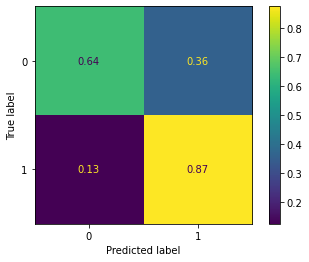

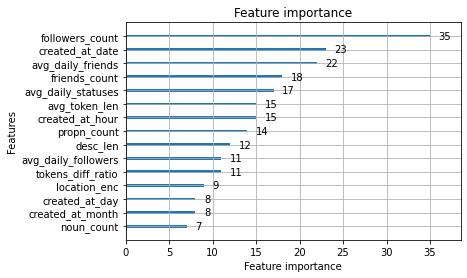

In [20]:
eval_clf(clf_users, df_test_users)

# Detection on tweets metadata

## Extract tweet metadata

In [21]:
def extract_reply(text: str):
    """ Extract 'reply' tweets """
    res = re.match(r'(@\w+ )+', text)
    if res:
        text = text[res.span()[1]:]
        return text, True, res.group()[1:-1].split(" @")
    return text, False, np.nan

def extract_retweet(text: str):
    """ Extract 'retweets' """
    res = re.match(r'RT @(\w+): \.?', text)
    if res:
        text = text[res.span(0)[1]:]
        return text, True, res.group(1)
    return text, False, np.nan

def extract_modified_tweet(text: str):
    """ Extract 'modified' tweets """
    res = re.match(r'MT : ', text)
    if res:
        text = text[res.span(0)[1]:]
        return text, True
    return text, False

def extract_ellipsis(text: str):
    """ Extract artefacts corresponding to a several-parts tweet """
    text_cleaned = re.sub(r'\s*(?:\.{3}|…|\(\d+\/\d+\))\s*$', "", text)
    has_ellipsis = len(text_cleaned) != len(text)
    return text_cleaned, has_ellipsis


def extract_artefacts(text: str):
    """ Process dataframe for metadata extraction from tweets """
    text, is_reply, replies = extract_reply(text)
    text_sat = len(text) / 240
    
    text, is_rt, retweet = extract_retweet(text)
    text, is_mt = extract_modified_tweet(text)
    
    hashtags_start_count = count_hashtags(text)
    hashtags_end_count = count_hashtags(text, end=True)
    
    text, hashtags = extract_symbols(text, "#")
    text, mentions = extract_symbols(text, "@")
    text, cashtags = extract_symbols(text, "$")
    text, links = extract_links(text)
    
    text, has_ellipsis = extract_ellipsis(text)
    text, emoji_list = extract_emojis(text)
    text, unk_chars_ratio = clean_text(text)
    
    metadata = extract_metadata(text)
    
    return (
        text, text_sat, is_reply, replies, 
        is_rt, retweet, is_mt, 
        hashtags_start_count, hashtags_end_count,
        hashtags, mentions, cashtags, 
        links, has_ellipsis, emoji_list, 
        unk_chars_ratio, *metadata
    )


def get_artefacts(df: pd.DataFrame):    
    new_cols = [ 
        'tweet', 'text_sat', 'is_reply', 'replies', 
        'is_rt', 'retweet', 'is_mt', 
        'hashtags_start_count', 'hashtags_end_count',
        'hashtags', 'mentions', 'cashtags',
        'links', 'has_ellipsis', 'emojis', 
        'unk_chars_ratio', 
        'tokens_count', 'avg_token_len', 'tokens_diff_ratio'
    ] + [ tag.lower() + "_count" for tag in POS_TAGS ]
    
    df[new_cols] = pd.DataFrame(
        df['tweet'].swifter.apply(extract_artefacts).to_list(), 
        columns=new_cols
    )
    
    df['hashtags_count'] = df['hashtags'].apply(len)
    df['mentions_count'] = df['mentions'].apply(len)
    df['cashtags_count'] = df['cashtags'].apply(len)
    df['links_count'] = df['links'].apply(len)
    df['emojis_count'] = df['emojis'].apply(len)
    
    return df

> __Improve extraction of emojis__

> __Improve spotting of non-english tweets__

> __Investigate tweets with more than 240 chars__

In [22]:
df_train_tweets = get_artefacts(df_train)
df_test_tweets = get_artefacts(df_test)

Pandas Apply:   0%|          | 0/1398465 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199863 [00:00<?, ?it/s]

In [23]:
df_train_tweets.to_csv(PATH.format('train_tweets_prep'))
df_test_tweets.to_csv(PATH.format('test_tweets_prep'))

In [24]:
df_train_tweets = pd.read_csv(PATH.format('train_tweets_prep'), index_col='Unnamed: 0')
df_test_tweets = pd.read_csv(PATH.format('test_tweets_prep'), index_col='Unnamed: 0')

In [26]:
def filter_metadata(df: pd.DataFrame):
    return df.drop([ 'tweet', 'location', 'screen_name', 'id',
                     'description', 'desc_hashtags', 'desc_mentions', 
                     'desc_cashtags', 'desc_links', 'desc_emojis',
                     'replies', 'retweet', 'hashtags', 'mentions',
                     'cashtags', 'links', 'emojis' ], axis=1)

df_train_tweets = filter_metadata(df_train_tweets)
df_test_tweets = filter_metadata(df_test_tweets)

## Training

> __Very high AUROC during training, but meh performance in the end bc of over-use of users metadata__

In [27]:
clf_tweets = get_best_clf(df_train_tweets)

[I 2022-04-10 23:16:33,853] A new study created in memory with name: no-name-ec49891f-8261-4d81-b655-cadbbc35440f


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds




Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.862335


[I 2022-04-10 23:18:44,826] Trial 0 finished with value: 0.5235138976416484 and parameters: {'lambda_l1': 1.634628298578113e-05, 'lambda_l2': 0.011724969056277788, 'num_leaves': 27, 'feature_fraction': 0.636197445036658, 'bagging_fraction': 0.7121336273265582, 'bagging_freq': 1, 'learning_rate': 0.0008718522466385906, 'min_child_samples': 67}. Best is trial 0 with value: 0.5235138976416484.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999825


[I 2022-04-10 23:19:25,253] Trial 7 finished with value: 0.9925605041646107 and parameters: {'lambda_l1': 9.015115321124672e-07, 'lambda_l2': 1.5852184705510362e-06, 'num_leaves': 90, 'feature_fraction': 0.9227313693012943, 'bagging_fraction': 0.4556157780437572, 'bagging_freq': 1, 'learning_rate': 0.1485752572633166, 'min_child_samples': 96}. Best is trial 7 with value: 0.9925605041646107.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999782


[I 2022-04-10 23:19:58,992] Trial 6 finished with value: 0.9892370313816895 and parameters: {'lambda_l1': 8.892535574787988e-06, 'lambda_l2': 0.1614770722685003, 'num_leaves': 140, 'feature_fraction': 0.4492084183544768, 'bagging_fraction': 0.48408237100687374, 'bagging_freq': 6, 'learning_rate': 0.10185974230893495, 'min_child_samples': 43}. Best is trial 7 with value: 0.9925605041646107.


Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.924436


[I 2022-04-10 23:20:08,699] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 0.13291680915537135, 'lambda_l2': 3.9805702151149685e-08, 'num_leaves': 170, 'feature_fraction': 0.7020500778607284, 'bagging_fraction': 0.9122303925623695, 'bagging_freq': 3, 'learning_rate': 0.000795161153098558, 'min_child_samples': 73}. Best is trial 7 with value: 0.9925605041646107.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.910596


[I 2022-04-10 23:20:36,550] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 0.0005370781215070304, 'lambda_l2': 0.606966895779435, 'num_leaves': 170, 'feature_fraction': 0.9177266675086241, 'bagging_fraction': 0.6934054615599154, 'bagging_freq': 4, 'learning_rate': 0.00013232288162288248, 'min_child_samples': 69}. Best is trial 7 with value: 0.9925605041646107.


Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.940443
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:20:51,716] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 1.965502604412692e-05, 'lambda_l2': 8.262103101783541, 'num_leaves': 235, 'feature_fraction': 0.6993132402827473, 'bagging_fraction': 0.7726635283036738, 'bagging_freq': 6, 'learning_rate': 0.0007945202255877843, 'min_child_samples': 35}. Best is trial 7 with value: 0.9925605041646107.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.951787
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:21:05,549] Trial 2 finished with value: 0.8301799737393153 and parameters: {'lambda_l1': 3.343872891332026, 'lambda_l2': 6.272519271653718e-05, 'num_leaves': 208, 'feature_fraction': 0.5154662737071162, 'bagging_fraction': 0.42978495998503896, 'bagging_freq': 1, 'learning_rate': 0.002818745775989938, 'min_child_samples': 57}. Best is trial 7 with value: 0.9925605041646107.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.935077
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:21:20,771] Trial 8 finished with value: 0.8402563212896371 and parameters: {'lambda_l1': 0.002246279825196625, 'lambda_l2': 4.9690223466435956e-08, 'num_leaves': 204, 'feature_fraction': 0.8399979894829013, 'bagging_fraction': 0.6543394909772238, 'bagging_freq': 2, 'learning_rate': 0.002840177564936597, 'min_child_samples': 89}. Best is trial 7 with value: 0.9925605041646107.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.991896


[I 2022-04-10 23:21:42,397] Trial 3 finished with value: 0.9310407049353018 and parameters: {'lambda_l1': 4.81098610125206e-07, 'lambda_l2': 4.4804306534917605e-08, 'num_leaves': 220, 'feature_fraction': 0.63088053749887, 'bagging_fraction': 0.8549745132410288, 'bagging_freq': 6, 'learning_rate': 0.026079486752397983, 'min_child_samples': 58}. Best is trial 7 with value: 0.9925605041646107.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.797704


[I 2022-04-10 23:21:51,981] Trial 14 finished with value: 0.5 and parameters: {'lambda_l1': 5.15773421018309, 'lambda_l2': 0.00012095077144086834, 'num_leaves': 4, 'feature_fraction': 0.4479911591617777, 'bagging_fraction': 0.7524054678375054, 'bagging_freq': 7, 'learning_rate': 0.00023362939881131628, 'min_child_samples': 10}. Best is trial 7 with value: 0.9925605041646107.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.921279
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.936639


[I 2022-04-10 23:22:33,462] Trial 10 finished with value: 0.5 and parameters: {'lambda_l1': 0.23626559360366656, 'lambda_l2': 2.726996052905716e-06, 'num_leaves': 157, 'feature_fraction': 0.6798610770179309, 'bagging_fraction': 0.8790312077416532, 'bagging_freq': 5, 'learning_rate': 8.586341460454484e-05, 'min_child_samples': 69}. Best is trial 7 with value: 0.9925605041646107.
[I 2022-04-10 23:22:39,662] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 6.585285517401924, 'lambda_l2': 3.4146009774290716e-07, 'num_leaves': 233, 'feature_fraction': 0.7299606497514857, 'bagging_fraction': 0.9712939396140268, 'bagging_freq': 2, 'learning_rate': 2.4186887237486e-05, 'min_child_samples': 83}. Best is trial 7 with value: 0.9925605041646107.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.872528


[I 2022-04-10 23:23:07,734] Trial 17 finished with value: 0.5 and parameters: {'lambda_l1': 1.0879816614664688e-08, 'lambda_l2': 8.773251055564857e-06, 'num_leaves': 68, 'feature_fraction': 0.9991970202227419, 'bagging_fraction': 0.5489449089995696, 'bagging_freq': 3, 'learning_rate': 1.1033808995899351e-05, 'min_child_samples': 99}. Best is trial 7 with value: 0.9925605041646107.


Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.929131


[I 2022-04-10 23:23:17,301] Trial 11 finished with value: 0.5 and parameters: {'lambda_l1': 6.205145541506514e-05, 'lambda_l2': 0.0020966107619279227, 'num_leaves': 240, 'feature_fraction': 0.8677039897007917, 'bagging_fraction': 0.7832895845209293, 'bagging_freq': 7, 'learning_rate': 0.00013487336031810452, 'min_child_samples': 43}. Best is trial 7 with value: 0.9925605041646107.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.919888


[I 2022-04-10 23:23:42,846] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 6.909984188725594, 'lambda_l2': 1.610211153009825e-05, 'num_leaves': 134, 'feature_fraction': 0.5537355771562255, 'bagging_fraction': 0.8509785591634642, 'bagging_freq': 1, 'learning_rate': 0.0001569579587624183, 'min_child_samples': 51}. Best is trial 7 with value: 0.9925605041646107.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999983
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.933042


[I 2022-04-10 23:24:08,647] Trial 18 finished with value: 0.9992168022229212 and parameters: {'lambda_l1': 1.0036294383555561e-08, 'lambda_l2': 0.013240047373357005, 'num_leaves': 83, 'feature_fraction': 0.9873383377645311, 'bagging_fraction': 0.4379660527832775, 'bagging_freq': 4, 'learning_rate': 0.2906485419618151, 'min_child_samples': 34}. Best is trial 18 with value: 0.9992168022229212.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999977


[I 2022-04-10 23:24:15,910] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 0.6086001283504182, 'lambda_l2': 0.0001122489122534355, 'num_leaves': 203, 'feature_fraction': 0.6897869725518632, 'bagging_fraction': 0.4818609522353462, 'bagging_freq': 5, 'learning_rate': 1.1034150829778883e-05, 'min_child_samples': 31}. Best is trial 18 with value: 0.9992168022229212.


Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.930123
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99997


[I 2022-04-10 23:24:19,078] Trial 19 finished with value: 0.9993918152790087 and parameters: {'lambda_l1': 7.861995232881202e-08, 'lambda_l2': 0.009397390362073177, 'num_leaves': 86, 'feature_fraction': 0.976089003429537, 'bagging_fraction': 0.41726020976195816, 'bagging_freq': 4, 'learning_rate': 0.2883430229020904, 'min_child_samples': 36}. Best is trial 19 with value: 0.9993918152790087.
[I 2022-04-10 23:24:26,549] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 0.03413304405158953, 'lambda_l2': 0.00010253960810955525, 'num_leaves': 162, 'feature_fraction': 0.5394902938702326, 'bagging_fraction': 0.6225372711831868, 'bagging_freq': 6, 'learning_rate': 5.810615616942131e-05, 'min_child_samples': 62}. Best is trial 19 with value: 0.9993918152790087.


Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:24:40,231] Trial 12 finished with value: 0.9969867420907048 and parameters: {'lambda_l1': 1.0823939506490872, 'lambda_l2': 2.4043898287050707e-05, 'num_leaves': 233, 'feature_fraction': 0.7596487442238622, 'bagging_fraction': 0.9431096786512702, 'bagging_freq': 3, 'learning_rate': 0.0733916985123002, 'min_child_samples': 62}. Best is trial 19 with value: 0.9993918152790087.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999434


[I 2022-04-10 23:25:18,910] Trial 21 finished with value: 0.98501350129304 and parameters: {'lambda_l1': 4.763288957708604e-07, 'lambda_l2': 0.05752988707864136, 'num_leaves': 103, 'feature_fraction': 0.5430104741298767, 'bagging_fraction': 0.4004439294753284, 'bagging_freq': 5, 'learning_rate': 0.11473634847548798, 'min_child_samples': 25}. Best is trial 19 with value: 0.9993918152790087.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999993


[I 2022-04-10 23:25:28,243] Trial 20 finished with value: 0.9991892773226166 and parameters: {'lambda_l1': 4.722159344318661e-07, 'lambda_l2': 0.008509197829549535, 'num_leaves': 100, 'feature_fraction': 0.5395597510250945, 'bagging_fraction': 0.419238004913607, 'bagging_freq': 5, 'learning_rate': 0.28402477845275975, 'min_child_samples': 41}. Best is trial 19 with value: 0.9993918152790087.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999955
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:25:43,215] Trial 22 finished with value: 0.9982291442596025 and parameters: {'lambda_l1': 3.184068552139427e-07, 'lambda_l2': 0.019528906587723, 'num_leaves': 79, 'feature_fraction': 0.41430410536847734, 'bagging_fraction': 0.4003562052581699, 'bagging_freq': 5, 'learning_rate': 0.2839614538687428, 'min_child_samples': 23}. Best is trial 19 with value: 0.9993918152790087.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999991


[I 2022-04-10 23:26:14,316] Trial 23 finished with value: 0.999039626658255 and parameters: {'lambda_l1': 2.0933553799821902e-08, 'lambda_l2': 0.0007203729479115881, 'num_leaves': 86, 'feature_fraction': 0.974898354805488, 'bagging_fraction': 0.5760564065007864, 'bagging_freq': 4, 'learning_rate': 0.24657112995004093, 'min_child_samples': 23}. Best is trial 19 with value: 0.9993918152790087.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-04-10 23:26:31,926] Trial 24 finished with value: 0.9996720121706665 and parameters: {'lambda_l1': 1.0924230227142739e-08, 'lambda_l2': 0.002224348957810843, 'num_leaves': 92, 'feature_fraction': 0.9676781724331576, 'bagging_fraction': 0.5894494583763269, 'bagging_freq': 3, 'learning_rate': 0.29553957367583467, 'min_child_samples': 14}. Best is trial 24 with value: 0.9996720121706665.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.956158


[I 2022-04-10 23:26:41,651] Trial 26 finished with value: 0.8595961893757088 and parameters: {'lambda_l1': 1.0829067426010197e-08, 'lambda_l2': 0.003146989110306538, 'num_leaves': 94, 'feature_fraction': 0.9980503343720276, 'bagging_fraction': 0.5515486844733658, 'bagging_freq': 4, 'learning_rate': 0.026554890457860157, 'min_child_samples': 16}. Best is trial 24 with value: 0.9996720121706665.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.926139
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.973901
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:26:53,977] Trial 27 finished with value: 0.8388783807328004 and parameters: {'lambda_l1': 1.6743856718853087e-08, 'lambda_l2': 0.0028535918091347036, 'num_leaves': 97, 'feature_fraction': 0.9841751855302413, 'bagging_fraction': 0.4025848028911681, 'bagging_freq': 4, 'learning_rate': 0.013671194370601521, 'min_child_samples': 18}. Best is trial 24 with value: 0.9996720121706665.
[I 2022-04-10 23:26:54,401] Trial 25 finished with value: 0.8883147645324275 and parameters: {'lambda_l1': 1.0481325760957632e-08, 'lambda_l2': 0.004866290148904876, 'num_leaves': 98, 'feature_fraction': 0.9908934279093542, 'bagging_fraction': 0.5871129293700422, 'bagging_freq': 4, 'learning_rate': 0.035291027172228144, 'min_child_samples': 17}. Best is trial 24 with value: 0.9996720121706665.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.928542


[I 2022-04-10 23:27:21,094] Trial 28 finished with value: 0.8318641090633695 and parameters: {'lambda_l1': 1.0928439618522885e-08, 'lambda_l2': 0.001357677757335861, 'num_leaves': 59, 'feature_fraction': 0.7925910363306201, 'bagging_fraction': 0.5356418612302376, 'bagging_freq': 4, 'learning_rate': 0.02693142975602609, 'min_child_samples': 16}. Best is trial 24 with value: 0.9996720121706665.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.941143


[I 2022-04-10 23:27:36,934] Trial 29 finished with value: 0.8422262089246391 and parameters: {'lambda_l1': 2.075692201916498e-08, 'lambda_l2': 0.0014006708212190124, 'num_leaves': 64, 'feature_fraction': 0.9564593775694118, 'bagging_fraction': 0.5349825371713507, 'bagging_freq': 4, 'learning_rate': 0.03058689073589345, 'min_child_samples': 18}. Best is trial 24 with value: 0.9996720121706665.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.921286


[I 2022-04-10 23:27:46,014] Trial 30 finished with value: 0.8254891480817141 and parameters: {'lambda_l1': 1.4755615615322727e-08, 'lambda_l2': 0.0013501002761525864, 'num_leaves': 59, 'feature_fraction': 0.9750064571452554, 'bagging_fraction': 0.5518886969479495, 'bagging_freq': 4, 'learning_rate': 0.02148606295699686, 'min_child_samples': 8}. Best is trial 24 with value: 0.9996720121706665.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.907507


[I 2022-04-10 23:28:20,502] Trial 31 finished with value: 0.8153318802917522 and parameters: {'lambda_l1': 7.333680738268494e-08, 'lambda_l2': 0.0020951057645643605, 'num_leaves': 55, 'feature_fraction': 0.799072443370241, 'bagging_fraction': 0.5283815960757955, 'bagging_freq': 4, 'learning_rate': 0.016776243457580088, 'min_child_samples': 8}. Best is trial 24 with value: 0.9996720121706665.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.941559


[I 2022-04-10 23:28:46,524] Trial 33 finished with value: 0.8397383483237518 and parameters: {'lambda_l1': 7.052918044922407e-08, 'lambda_l2': 0.5492803043412795, 'num_leaves': 55, 'feature_fraction': 0.8175011997639293, 'bagging_fraction': 0.5098421940628698, 'bagging_freq': 4, 'learning_rate': 0.03625163835295039, 'min_child_samples': 11}. Best is trial 24 with value: 0.9996720121706665.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.888671
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.874521


[I 2022-04-10 23:28:59,369] Trial 35 finished with value: 0.801806204558904 and parameters: {'lambda_l1': 1.3338961649881624e-07, 'lambda_l2': 1.0270834105884525, 'num_leaves': 52, 'feature_fraction': 0.8102752158508131, 'bagging_fraction': 0.5117257168645301, 'bagging_freq': 2, 'learning_rate': 0.008734112708578313, 'min_child_samples': 9}. Best is trial 24 with value: 0.9996720121706665.
[I 2022-04-10 23:28:59,510] Trial 36 finished with value: 0.7912872441527091 and parameters: {'lambda_l1': 9.357617127317006e-08, 'lambda_l2': 1.0124747757280954, 'num_leaves': 38, 'feature_fraction': 0.9278816473783578, 'bagging_fraction': 0.5190828043532545, 'bagging_freq': 2, 'learning_rate': 0.007761392815540176, 'min_child_samples': 6}. Best is trial 24 with value: 0.9996720121706665.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.912071
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.951337


[I 2022-04-10 23:29:21,716] Trial 32 finished with value: 0.819114967626276 and parameters: {'lambda_l1': 6.522824614039632e-08, 'lambda_l2': 0.0027007961874227168, 'num_leaves': 50, 'feature_fraction': 0.8329330143327851, 'bagging_fraction': 0.538994237814786, 'bagging_freq': 4, 'learning_rate': 0.022307622150735888, 'min_child_samples': 9}. Best is trial 24 with value: 0.9996720121706665.


Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:29:22,955] Trial 34 finished with value: 0.8547522035685977 and parameters: {'lambda_l1': 7.547852430843325e-08, 'lambda_l2': 0.44723402084703734, 'num_leaves': 52, 'feature_fraction': 0.8167768705132958, 'bagging_fraction': 0.5143713960694652, 'bagging_freq': 2, 'learning_rate': 0.04806291011798802, 'min_child_samples': 10}. Best is trial 24 with value: 0.9996720121706665.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.878358
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.876168


[I 2022-04-10 23:29:45,914] Trial 37 finished with value: 0.7938131835400242 and parameters: {'lambda_l1': 2.7778299665986236e-06, 'lambda_l2': 0.4060393174163332, 'num_leaves': 43, 'feature_fraction': 0.876454363827929, 'bagging_fraction': 0.4822986545120452, 'bagging_freq': 2, 'learning_rate': 0.007566173452179877, 'min_child_samples': 5}. Best is trial 24 with value: 0.9996720121706665.
[I 2022-04-10 23:29:45,899] Trial 38 finished with value: 0.7932085815846893 and parameters: {'lambda_l1': 6.656582145396853e-08, 'lambda_l2': 0.01126279732405062, 'num_leaves': 38, 'feature_fraction': 0.890312124382038, 'bagging_fraction': 0.4813756639169661, 'bagging_freq': 3, 'learning_rate': 0.00838037802529822, 'min_child_samples': 39}. Best is trial 24 with value: 0.9996720121706665.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.996341


[I 2022-04-10 23:30:46,088] Trial 39 finished with value: 0.9571863379636344 and parameters: {'lambda_l1': 1.1908449137506783e-07, 'lambda_l2': 0.025666614466649428, 'num_leaves': 115, 'feature_fraction': 0.9028457979770635, 'bagging_fraction': 0.488365513274307, 'bagging_freq': 3, 'learning_rate': 0.06080074823084638, 'min_child_samples': 38}. Best is trial 24 with value: 0.9996720121706665.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-04-10 23:31:05,126] Trial 40 finished with value: 0.9997606550485137 and parameters: {'lambda_l1': 2.2901372981714288e-06, 'lambda_l2': 0.017722613697968983, 'num_leaves': 119, 'feature_fraction': 0.8910412705890323, 'bagging_fraction': 0.44306254800613976, 'bagging_freq': 3, 'learning_rate': 0.2882107862900096, 'min_child_samples': 41}. Best is trial 40 with value: 0.9997606550485137.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.997681


[I 2022-04-10 23:31:18,316] Trial 41 finished with value: 0.9658836857230176 and parameters: {'lambda_l1': 1.332582121803442e-06, 'lambda_l2': 0.013238651986407349, 'num_leaves': 117, 'feature_fraction': 0.9045691538230275, 'bagging_fraction': 0.45177605112708913, 'bagging_freq': 3, 'learning_rate': 0.06315260972524886, 'min_child_samples': 39}. Best is trial 40 with value: 0.9997606550485137.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999972


[I 2022-04-10 23:31:27,930] Trial 44 finished with value: 0.9986573297611798 and parameters: {'lambda_l1': 7.656920864931813e-06, 'lambda_l2': 0.016051381131274623, 'num_leaves': 113, 'feature_fraction': 0.872680387929561, 'bagging_fraction': 0.44973132898549056, 'bagging_freq': 3, 'learning_rate': 0.1873933477761428, 'min_child_samples': 37}. Best is trial 40 with value: 0.9997606550485137.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.996064Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999964

Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999989
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.997771


[I 2022-04-10 23:31:46,310] Trial 45 finished with value: 0.9972893874249875 and parameters: {'lambda_l1': 2.253071530002812e-06, 'lambda_l2': 0.04022052290343598, 'num_leaves': 116, 'feature_fraction': 0.9369281153642698, 'bagging_fraction': 0.4482408584685072, 'bagging_freq': 5, 'learning_rate': 0.14254923285891508, 'min_child_samples': 50}. Best is trial 40 with value: 0.9997606550485137.
[I 2022-04-10 23:31:46,373] Trial 43 finished with value: 0.9552168698318737 and parameters: {'lambda_l1': 1.4644725961621884e-06, 'lambda_l2': 0.016497317723932706, 'num_leaves': 122, 'feature_fraction': 0.8831226857962602, 'bagging_fraction': 0.45435109886358643, 'bagging_freq': 3, 'learning_rate': 0.055109605903553856, 'min_child_samples': 36}. Best is trial 40 with value: 0.9997606550485137.
[I 2022-04-10 23:31:48,364] Trial 46 finished with value: 0.998580501853135 and parameters: {'lambda_l1': 4.554565755727273e-06, 'lambda_l2': 0.045614722188698054, 'num_leaves': 115, 'feature_fraction': 0.9

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999974


[I 2022-04-10 23:32:57,099] Trial 47 finished with value: 0.9983894085001116 and parameters: {'lambda_l1': 1.3198447737332514e-06, 'lambda_l2': 0.08975487491354461, 'num_leaves': 120, 'feature_fraction': 0.6006992369094541, 'bagging_fraction': 0.44365753862103324, 'bagging_freq': 5, 'learning_rate': 0.17794765906955803, 'min_child_samples': 50}. Best is trial 40 with value: 0.9997606550485137.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999982


[I 2022-04-10 23:33:09,191] Trial 48 finished with value: 0.9985507639432475 and parameters: {'lambda_l1': 2.763122817352379e-06, 'lambda_l2': 0.08405568267532418, 'num_leaves': 115, 'feature_fraction': 0.9436681346068798, 'bagging_fraction': 0.44115726146323153, 'bagging_freq': 3, 'learning_rate': 0.17284737899719127, 'min_child_samples': 47}. Best is trial 40 with value: 0.9997606550485137.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99925


[I 2022-04-10 23:33:24,482] Trial 50 finished with value: 0.9836082209032876 and parameters: {'lambda_l1': 9.704047157314576e-05, 'lambda_l2': 0.0005008198287367216, 'num_leaves': 77, 'feature_fraction': 0.6238787145925466, 'bagging_fraction': 0.4351521102249549, 'bagging_freq': 5, 'learning_rate': 0.1474889522965489, 'min_child_samples': 51}. Best is trial 40 with value: 0.9997606550485137.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999997


[I 2022-04-10 23:33:41,629] Trial 49 finished with value: 0.999292078267552 and parameters: {'lambda_l1': 4.854721082945081e-06, 'lambda_l2': 0.07425559652619844, 'num_leaves': 113, 'feature_fraction': 0.9452332371720638, 'bagging_fraction': 0.44384087966827335, 'bagging_freq': 5, 'learning_rate': 0.22265057819673623, 'min_child_samples': 48}. Best is trial 40 with value: 0.9997606550485137.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 1


[I 2022-04-10 23:34:05,971] Trial 52 finished with value: 0.9998518813023777 and parameters: {'lambda_l1': 3.592519731647663e-05, 'lambda_l2': 0.000489317623584321, 'num_leaves': 144, 'feature_fraction': 0.6399897721906238, 'bagging_fraction': 0.6783524085597297, 'bagging_freq': 5, 'learning_rate': 0.2847864493940643, 'min_child_samples': 30}. Best is trial 52 with value: 0.9998518813023777.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 1


[I 2022-04-10 23:34:15,363] Trial 54 finished with value: 0.9998845729547159 and parameters: {'lambda_l1': 6.980245039603336e-05, 'lambda_l2': 0.00040291531012777795, 'num_leaves': 142, 'feature_fraction': 0.9541757399316338, 'bagging_fraction': 0.6823700886436336, 'bagging_freq': 6, 'learning_rate': 0.28253165921081475, 'min_child_samples': 31}. Best is trial 54 with value: 0.9998845729547159.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-04-10 23:34:38,915] Trial 51 finished with value: 0.999770918154902 and parameters: {'lambda_l1': 2.8143799576923037e-07, 'lambda_l2': 0.10547728030264804, 'num_leaves': 152, 'feature_fraction': 0.6073103992535649, 'bagging_fraction': 0.42992244778708877, 'bagging_freq': 5, 'learning_rate': 0.26876031292844027, 'min_child_samples': 30}. Best is trial 54 with value: 0.9998845729547159.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-04-10 23:34:48,685] Trial 53 finished with value: 0.9998020778405007 and parameters: {'lambda_l1': 4.685020509165108e-05, 'lambda_l2': 0.0003655010801414227, 'num_leaves': 148, 'feature_fraction': 0.5904918668991412, 'bagging_fraction': 0.6689117379552767, 'bagging_freq': 5, 'learning_rate': 0.2921853938137994, 'min_child_samples': 30}. Best is trial 54 with value: 0.9998845729547159.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.996445


[I 2022-04-10 23:34:58,675] Trial 55 finished with value: 0.9623076465838705 and parameters: {'lambda_l1': 5.433542626842134e-05, 'lambda_l2': 0.0004398318538448891, 'num_leaves': 75, 'feature_fraction': 0.9558865718920371, 'bagging_fraction': 0.6768308593629015, 'bagging_freq': 6, 'learning_rate': 0.10023583378738773, 'min_child_samples': 31}. Best is trial 54 with value: 0.9998845729547159.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-04-10 23:35:42,647] Trial 56 finished with value: 0.9998263888229492 and parameters: {'lambda_l1': 0.0006468955321468089, 'lambda_l2': 0.0002951944413027693, 'num_leaves': 141, 'feature_fraction': 0.48397175169831846, 'bagging_fraction': 0.6673159913577877, 'bagging_freq': 6, 'learning_rate': 0.29672927641105223, 'min_child_samples': 29}. Best is trial 54 with value: 0.9998845729547159.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999853


[I 2022-04-10 23:35:59,382] Trial 58 finished with value: 0.999889649412396 and parameters: {'lambda_l1': 1.9290700525974736e-05, 'lambda_l2': 0.006753713774527088, 'num_leaves': 140, 'feature_fraction': 0.9646936200545145, 'bagging_fraction': 0.6606948048524864, 'bagging_freq': 6, 'learning_rate': 0.29517911264718094, 'min_child_samples': 31}. Best is trial 58 with value: 0.999889649412396.
[I 2022-04-10 23:36:05,780] Trial 57 finished with value: 0.9918804180088769 and parameters: {'lambda_l1': 3.076361069610685e-07, 'lambda_l2': 0.006968486061144043, 'num_leaves': 145, 'feature_fraction': 0.5027471001279893, 'bagging_fraction': 0.6237667506359942, 'bagging_freq': 6, 'learning_rate': 0.09653877398345787, 'min_child_samples': 30}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999941


[I 2022-04-10 23:36:31,301] Trial 59 finished with value: 0.9961944428075433 and parameters: {'lambda_l1': 0.0008441904280537382, 'lambda_l2': 0.20136891616723565, 'num_leaves': 147, 'feature_fraction': 0.9615098884933384, 'bagging_fraction': 0.6289416045925981, 'bagging_freq': 6, 'learning_rate': 0.10655306437107005, 'min_child_samples': 30}. Best is trial 58 with value: 0.999889649412396.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999852


[I 2022-04-10 23:36:39,941] Trial 60 finished with value: 0.9924188439070303 and parameters: {'lambda_l1': 0.0011223593412266677, 'lambda_l2': 0.00024330991059104808, 'num_leaves': 147, 'feature_fraction': 0.9640720294310552, 'bagging_fraction': 0.7008480724620766, 'bagging_freq': 6, 'learning_rate': 0.0878684087805706, 'min_child_samples': 28}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999777


[I 2022-04-10 23:37:04,954] Trial 61 finished with value: 0.9911673800253993 and parameters: {'lambda_l1': 0.0012310040079792914, 'lambda_l2': 0.00016426439045244318, 'num_leaves': 145, 'feature_fraction': 0.6510859075463201, 'bagging_fraction': 0.698047760830556, 'bagging_freq': 6, 'learning_rate': 0.08703040082523021, 'min_child_samples': 30}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99977


[I 2022-04-10 23:37:36,428] Trial 62 finished with value: 0.9896290205333377 and parameters: {'lambda_l1': 0.0008279024306411729, 'lambda_l2': 0.00025248087574623814, 'num_leaves': 147, 'feature_fraction': 0.6653764689850546, 'bagging_fraction': 0.6964401750299105, 'bagging_freq': 6, 'learning_rate': 0.08389410360267996, 'min_child_samples': 28}. Best is trial 58 with value: 0.999889649412396.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999892


[I 2022-04-10 23:37:46,230] Trial 63 finished with value: 0.9939664548895525 and parameters: {'lambda_l1': 0.0010514860992802664, 'lambda_l2': 0.00021003324168437145, 'num_leaves': 146, 'feature_fraction': 0.654226410055065, 'bagging_fraction': 0.723476772301368, 'bagging_freq': 6, 'learning_rate': 0.09848491775777095, 'min_child_samples': 29}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99985


[I 2022-04-10 23:38:19,012] Trial 64 finished with value: 0.9927001320013152 and parameters: {'lambda_l1': 0.0009889037201188786, 'lambda_l2': 0.00020353651895322125, 'num_leaves': 149, 'feature_fraction': 0.4879926583794643, 'bagging_fraction': 0.7219127536271914, 'bagging_freq': 6, 'learning_rate': 0.0966603688736061, 'min_child_samples': 27}. Best is trial 58 with value: 0.999889649412396.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999754
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:38:35,060] Trial 65 finished with value: 0.9898158684559022 and parameters: {'lambda_l1': 0.001407553061499504, 'lambda_l2': 0.0002168114808426573, 'num_leaves': 148, 'feature_fraction': 0.4990310338978965, 'bagging_fraction': 0.7294822563624693, 'bagging_freq': 6, 'learning_rate': 0.08985985989785975, 'min_child_samples': 28}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99997


[I 2022-04-10 23:38:57,895] Trial 66 finished with value: 0.9972533915604396 and parameters: {'lambda_l1': 0.0011707821759931066, 'lambda_l2': 0.00021992571039435095, 'num_leaves': 185, 'feature_fraction': 0.6068921329029586, 'bagging_fraction': 0.7283315828921135, 'bagging_freq': 7, 'learning_rate': 0.09914358736214514, 'min_child_samples': 27}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.942589


[I 2022-04-10 23:39:22,019] Trial 68 finished with value: 0.8230007179159892 and parameters: {'lambda_l1': 0.00022074369762800693, 'lambda_l2': 4.3770715302060553e-05, 'num_leaves': 185, 'feature_fraction': 0.5867694281726982, 'bagging_fraction': 0.725953779523261, 'bagging_freq': 6, 'learning_rate': 0.002550622485546654, 'min_child_samples': 27}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.933843


[I 2022-04-10 23:39:44,696] Trial 69 finished with value: 0.5 and parameters: {'lambda_l1': 0.00020161209046199252, 'lambda_l2': 5.2268020634986234e-05, 'num_leaves': 176, 'feature_fraction': 0.5718159764138946, 'bagging_fraction': 0.739194161205803, 'bagging_freq': 7, 'learning_rate': 0.0003293238329858099, 'min_child_samples': 25}. Best is trial 58 with value: 0.999889649412396.


Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.937003
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:39:59,018] Trial 67 finished with value: 0.5 and parameters: {'lambda_l1': 0.005273649425689628, 'lambda_l2': 4.076651342446836e-05, 'num_leaves': 189, 'feature_fraction': 0.5838106736829515, 'bagging_fraction': 0.7294759185012274, 'bagging_freq': 7, 'learning_rate': 0.00038145524259128945, 'min_child_samples': 26}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.937281


[I 2022-04-10 23:40:34,999] Trial 71 finished with value: 0.8082203873175957 and parameters: {'lambda_l1': 2.0913519805402648e-05, 'lambda_l2': 3.8608226468027674e-05, 'num_leaves': 174, 'feature_fraction': 0.5907827000090735, 'bagging_fraction': 0.7870433100444026, 'bagging_freq': 7, 'learning_rate': 0.001873621677055912, 'min_child_samples': 24}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-04-10 23:41:03,891] Trial 72 finished with value: 0.999821312365269 and parameters: {'lambda_l1': 2.5821816327894925e-05, 'lambda_l2': 4.670218668643518e-05, 'num_leaves': 173, 'feature_fraction': 0.58868488090951, 'bagging_fraction': 0.6661127369387182, 'bagging_freq': 7, 'learning_rate': 0.22963312455673784, 'min_child_samples': 22}. Best is trial 58 with value: 0.999889649412396.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.941969


[I 2022-04-10 23:41:20,326] Trial 70 finished with value: 0.8119101777026633 and parameters: {'lambda_l1': 0.0002776368340566329, 'lambda_l2': 3.620972581290548e-05, 'num_leaves': 190, 'feature_fraction': 0.5835682063016145, 'bagging_fraction': 0.7712030389499168, 'bagging_freq': 7, 'learning_rate': 0.0018774726739453152, 'min_child_samples': 21}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.935374
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:41:40,224] Trial 73 finished with value: 0.5 and parameters: {'lambda_l1': 0.00532450343558892, 'lambda_l2': 3.690306862079124e-05, 'num_leaves': 183, 'feature_fraction': 0.5931489768652657, 'bagging_fraction': 0.659898158669964, 'bagging_freq': 7, 'learning_rate': 0.000296545523032062, 'min_child_samples': 23}. Best is trial 58 with value: 0.999889649412396.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.930456
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.999999


[I 2022-04-10 23:41:54,479] Trial 74 finished with value: 0.826703960872726 and parameters: {'lambda_l1': 0.00029546376986556137, 'lambda_l2': 7.082003073346101e-05, 'num_leaves': 174, 'feature_fraction': 0.7289604620808513, 'bagging_fraction': 0.6616394847405435, 'bagging_freq': 7, 'learning_rate': 0.0026517745231207364, 'min_child_samples': 23}. Best is trial 58 with value: 0.999889649412396.
[I 2022-04-10 23:41:54,479] Trial 75 finished with value: 0.9996579642946065 and parameters: {'lambda_l1': 0.00470941011735732, 'lambda_l2': 4.007144702312741e-05, 'num_leaves': 134, 'feature_fraction': 0.7410494112747008, 'bagging_fraction': 0.7979416803862222, 'bagging_freq': 7, 'learning_rate': 0.2192852051268786, 'min_child_samples': 34}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999995


[I 2022-04-10 23:42:36,883] Trial 76 finished with value: 0.9992081613776256 and parameters: {'lambda_l1': 2.2856939712188705e-05, 'lambda_l2': 3.6919327162439458e-06, 'num_leaves': 129, 'feature_fraction': 0.4566958737189575, 'bagging_fraction': 0.808315660176669, 'bagging_freq': 7, 'learning_rate': 0.2102893257692435, 'min_child_samples': 34}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.999999


[I 2022-04-10 23:42:59,419] Trial 77 finished with value: 0.9996918374439249 and parameters: {'lambda_l1': 6.612865500322675e-05, 'lambda_l2': 1.1462593554923119e-05, 'num_leaves': 162, 'feature_fraction': 0.7322019381959629, 'bagging_fraction': 0.6599532657270311, 'bagging_freq': 5, 'learning_rate': 0.21084549210644846, 'min_child_samples': 33}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-04-10 23:43:17,500] Trial 78 finished with value: 0.9998617939390068 and parameters: {'lambda_l1': 2.759740509178364e-05, 'lambda_l2': 0.0008942473462557455, 'num_leaves': 131, 'feature_fraction': 0.7341720486710763, 'bagging_fraction': 0.6642960494887314, 'bagging_freq': 5, 'learning_rate': 0.2976810031214239, 'min_child_samples': 21}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999


[I 2022-04-10 23:43:55,808] Trial 79 finished with value: 0.9995026464240747 and parameters: {'lambda_l1': 1.860989687031507e-05, 'lambda_l2': 6.41188091070748e-06, 'num_leaves': 133, 'feature_fraction': 0.4650080004315893, 'bagging_fraction': 0.6699053655017195, 'bagging_freq': 5, 'learning_rate': 0.24226790274277835, 'min_child_samples': 21}. Best is trial 58 with value: 0.999889649412396.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999999
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:44:11,292] Trial 80 finished with value: 0.9994810489053461 and parameters: {'lambda_l1': 2.0726182986022867e-05, 'lambda_l2': 3.6626932902813654e-06, 'num_leaves': 135, 'feature_fraction': 0.45960383347148503, 'bagging_fraction': 0.667829916894614, 'bagging_freq': 5, 'learning_rate': 0.22746591238178637, 'min_child_samples': 34}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999976


[I 2022-04-10 23:44:40,259] Trial 82 finished with value: 0.9984479431016374 and parameters: {'lambda_l1': 2.8888344469398395e-05, 'lambda_l2': 0.0007899149842454943, 'num_leaves': 158, 'feature_fraction': 0.6195574651930584, 'bagging_fraction': 0.6395769373722755, 'bagging_freq': 5, 'learning_rate': 0.1363137273712976, 'min_child_samples': 44}. Best is trial 58 with value: 0.999889649412396.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.999993
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999975


[I 2022-04-10 23:44:54,362] Trial 81 finished with value: 0.9996276356362288 and parameters: {'lambda_l1': 3.0591437027750955e-05, 'lambda_l2': 1.056661948661443e-05, 'num_leaves': 133, 'feature_fraction': 0.7121768185700701, 'bagging_fraction': 0.6477036579339064, 'bagging_freq': 5, 'learning_rate': 0.24728327828539157, 'min_child_samples': 43}. Best is trial 58 with value: 0.999889649412396.
[I 2022-04-10 23:44:54,566] Trial 83 finished with value: 0.9984714429535393 and parameters: {'lambda_l1': 2.9314210392022954e-05, 'lambda_l2': 2.2732155110852655e-06, 'num_leaves': 161, 'feature_fraction': 0.5579962984119542, 'bagging_fraction': 0.6054579930490629, 'bagging_freq': 5, 'learning_rate': 0.13856345675804627, 'min_child_samples': 44}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:45:25,773] Trial 84 finished with value: 0.9998752510665768 and parameters: {'lambda_l1': 3.4358334631417626e-05, 'lambda_l2': 0.0008548285756680762, 'num_leaves': 160, 'feature_fraction': 0.632478001605808, 'bagging_fraction': 0.6443358668598248, 'bagging_freq': 5, 'learning_rate': 0.28951151618933135, 'min_child_samples': 45}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999974


[I 2022-04-10 23:45:52,167] Trial 85 finished with value: 0.9985276145611046 and parameters: {'lambda_l1': 1.036713010113141e-05, 'lambda_l2': 0.0007451716299622723, 'num_leaves': 159, 'feature_fraction': 0.6287595175595957, 'bagging_fraction': 0.642299858835059, 'bagging_freq': 5, 'learning_rate': 0.1345498507208374, 'min_child_samples': 43}. Best is trial 58 with value: 0.999889649412396.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999986


[I 2022-04-10 23:46:03,373] Trial 86 finished with value: 0.9985011808634269 and parameters: {'lambda_l1': 3.229023103070657e-05, 'lambda_l2': 0.0006989342063630663, 'num_leaves': 163, 'feature_fraction': 0.6206680137568852, 'bagging_fraction': 0.6062443662121906, 'bagging_freq': 5, 'learning_rate': 0.13882535949708438, 'min_child_samples': 43}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999993


[I 2022-04-10 23:46:40,754] Trial 87 finished with value: 0.9988311812169618 and parameters: {'lambda_l1': 4.0055050222249504e-05, 'lambda_l2': 0.0007670056714106437, 'num_leaves': 158, 'feature_fraction': 0.6345737563703205, 'bagging_fraction': 0.6404997021664719, 'bagging_freq': 5, 'learning_rate': 0.142147197972206, 'min_child_samples': 14}. Best is trial 58 with value: 0.999889649412396.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999994
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:46:56,249] Trial 88 finished with value: 0.9988629316510506 and parameters: {'lambda_l1': 3.7997256475663775e-05, 'lambda_l2': 0.0009466781177562803, 'num_leaves': 159, 'feature_fraction': 0.6212847478071883, 'bagging_fraction': 0.6407714835042972, 'bagging_freq': 5, 'learning_rate': 0.1494506076601175, 'min_child_samples': 43}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-04-10 23:47:30,169] Trial 89 finished with value: 0.9998659291784378 and parameters: {'lambda_l1': 0.00012376747667072472, 'lambda_l2': 0.0008340094051481225, 'num_leaves': 166, 'feature_fraction': 0.5630990670796204, 'bagging_fraction': 0.6116162077687565, 'bagging_freq': 6, 'learning_rate': 0.28712775080513914, 'min_child_samples': 55}. Best is trial 58 with value: 0.999889649412396.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.995044


[I 2022-04-10 23:47:40,896] Trial 92 finished with value: 0.9491726897299704 and parameters: {'lambda_l1': 1.0774847493834712e-05, 'lambda_l2': 0.0006861695044503581, 'num_leaves': 154, 'feature_fraction': 0.6776425291424983, 'bagging_fraction': 0.6072761284998213, 'bagging_freq': 5, 'learning_rate': 0.043547106862219735, 'min_child_samples': 20}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99999
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:47:58,634] Trial 90 finished with value: 0.9986354919637201 and parameters: {'lambda_l1': 0.00011749833356966666, 'lambda_l2': 0.00508424966910061, 'num_leaves': 165, 'feature_fraction': 0.5635060418828206, 'bagging_fraction': 0.5992547809051555, 'bagging_freq': 6, 'learning_rate': 0.12835783440844956, 'min_child_samples': 20}. Best is trial 58 with value: 0.999889649412396.
[I 2022-04-10 23:48:05,252] Trial 91 finished with value: 0.999889649412396 and parameters: {'lambda_l1': 1.1089786985599623e-05, 'lambda_l2': 0.006029535987696437, 'num_leaves': 168, 'feature_fraction': 0.40040358584649466, 'bagging_fraction': 0.6851814309820708, 'bagging_freq': 6, 'learning_rate': 0.2961496772566609, 'min_child_samples': 14}. Best is trial 58 with value: 0.999889649412396.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.999999


[I 2022-04-10 23:48:32,460] Trial 94 finished with value: 0.9997712686246611 and parameters: {'lambda_l1': 0.00015692670308184434, 'lambda_l2': 4.031332475362667, 'num_leaves': 166, 'feature_fraction': 0.40419677608155324, 'bagging_fraction': 0.5718831814617368, 'bagging_freq': 6, 'learning_rate': 0.29380949086966773, 'min_child_samples': 14}. Best is trial 58 with value: 0.999889649412396.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.999999


[I 2022-04-10 23:48:40,081] Trial 95 finished with value: 0.9997625374850123 and parameters: {'lambda_l1': 1.1498942533765793e-05, 'lambda_l2': 0.00011843010536680852, 'num_leaves': 126, 'feature_fraction': 0.6820750395149251, 'bagging_fraction': 0.6827054177996453, 'bagging_freq': 6, 'learning_rate': 0.28669681169840117, 'min_child_samples': 22}. Best is trial 58 with value: 0.999889649412396.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1


[I 2022-04-10 23:48:47,013] Trial 93 finished with value: 0.9999040477582152 and parameters: {'lambda_l1': 1.1412033712164603e-05, 'lambda_l2': 0.004760012662017423, 'num_leaves': 167, 'feature_fraction': 0.6780125220702526, 'bagging_fraction': 0.6800367528883924, 'bagging_freq': 6, 'learning_rate': 0.28956617649212907, 'min_child_samples': 57}. Best is trial 93 with value: 0.9999040477582152.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.996166


[I 2022-04-10 23:49:02,823] Trial 96 finished with value: 0.9555081593385073 and parameters: {'lambda_l1': 0.00016143448215657157, 'lambda_l2': 3.798054826029329, 'num_leaves': 169, 'feature_fraction': 0.5225224267374656, 'bagging_fraction': 0.6814928938237875, 'bagging_freq': 6, 'learning_rate': 0.044634273201010564, 'min_child_samples': 60}. Best is trial 93 with value: 0.9999040477582152.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 1
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999996


[I 2022-04-10 23:49:14,608] Trial 97 finished with value: 0.9998674611451771 and parameters: {'lambda_l1': 0.00011346985931440576, 'lambda_l2': 0.005006154655412868, 'num_leaves': 167, 'feature_fraction': 0.5307428335009051, 'bagging_fraction': 0.6835124294168026, 'bagging_freq': 6, 'learning_rate': 0.2978722878687317, 'min_child_samples': 58}. Best is trial 93 with value: 0.9999040477582152.
[I 2022-04-10 23:49:16,412] Trial 98 finished with value: 0.9998413779172584 and parameters: {'lambda_l1': 0.0001323138078664629, 'lambda_l2': 9.312942817456565e-05, 'num_leaves': 167, 'feature_fraction': 0.5364919840005681, 'bagging_fraction': 0.6813252015065165, 'bagging_freq': 6, 'learning_rate': 0.28851961901515666, 'min_child_samples': 57}. Best is trial 93 with value: 0.9999040477582152.
[I 2022-04-10 23:49:17,226] Trial 99 finished with value: 0.9995098455969843 and parameters: {'lambda_l1': 0.0001231371088070524, 'lambda_l2': 0.0004062244105392692, 'num_leaves': 106, 'feature_fraction': 0.

{'lambda_l1': 1.1412033712164603e-05, 'lambda_l2': 0.004760012662017423, 'num_leaves': 167, 'feature_fraction': 0.6780125220702526, 'bagging_fraction': 0.6800367528883924, 'bagging_freq': 6, 'learning_rate': 0.28956617649212907, 'min_child_samples': 57} -> 0.9999040477582152
[LightGBM] [Warning] feature_fraction is set=0.6780125220702526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6780125220702526
[LightGBM] [Warning] lambda_l1 is set=1.1412033712164603e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1412033712164603e-05
[LightGBM] [Warning] bagging_fraction is set=0.6800367528883924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6800367528883924
[LightGBM] [Warning] lambda_l2 is set=0.004760012662017423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004760012662017423
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don

AUROC: 0.7651347509577517
Accuracy: 0.7674006694585791


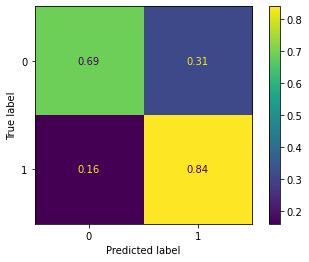

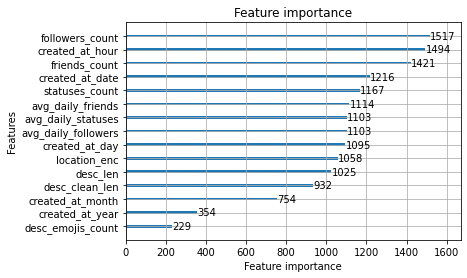

In [28]:
eval_clf(clf_tweets, df_test_tweets)

### Average probas at the user level

In [30]:
df_train_tweets_agg, df_test_tweets_agg = get_agg(clf_tweets, 
                                                  df_train_tweets, 
                                                  df_test_tweets, 
                                                  df_train['id'], 
                                                  df_test['id'])
clf_tweets_agg = get_best_clf(df_train_tweets_agg)

[I 2022-04-10 23:52:58,669] A new study created in memory with name: no-name-975a0beb-076c-4c7f-b892-3ad7a477e549


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds



Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.999976


[I 2022-04-10 23:52:59,312] Trial 1 finished with value: 0.9946292651696583 and parameters: {'lambda_l1': 4.2631286393358666e-07, 'lambda_l2': 9.539182620854751, 'num_leaves': 40, 'feature_fraction': 0.41015393712508175, 'bagging_fraction': 0.4698498416760638, 'bagging_freq': 7, 'learning_rate': 0.004120415672371655, 'min_child_samples': 39}. Best is trial 1 with value: 0.9946292651696583.
[I 2022-04-10 23:52:59,359] Trial 6 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.0008642480597162757, 'lambda_l2': 6.543890941622949e-05, 'num_leaves': 85, 'feature_fraction': 0.8836734884678313, 'bagging_fraction': 0.7453099106466999, 'bagging_freq': 6, 'learning_rate': 0.08070348921282895, 'min_child_samples': 86}. Best is trial 6 with value: 0.9971634695184123.
[I 2022-04-10 23:52:59,390] Trial 5 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 7.903216639611691e-05, 'lambda_l2': 0.0012835247264181367, 'num_leaves': 45, 'feature_fraction': 0.48312361

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.999972
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.999978
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99997
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.999971
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.99997
Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.999979
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:52:59,563] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 1.2796128679484588e-08, 'lambda_l2': 3.9177789284025034e-08, 'num_leaves': 38, 'feature_fraction': 0.7300861731609917, 'bagging_fraction': 0.9639310881332762, 'bagging_freq': 7, 'learning_rate': 0.0006080019589870325, 'min_child_samples': 30}. Best is trial 6 with value: 0.9971634695184123.
[I 2022-04-10 23:52:59,658] Trial 8 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.00994519068668634, 'lambda_l2': 0.0021123451043410955, 'num_leaves': 49, 'feature_fraction': 0.9911752020412115, 'bagging_fraction': 0.6706687951339504, 'bagging_freq': 7, 'learning_rate': 0.06545585461467372, 'min_child_samples': 86}. Best is trial 6 with value: 0.9971634695184123.
[I 2022-04-10 23:52:59,704] Trial 9 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.29270419166701916, 'lambda_l2': 6.566933463425481e-07, 'num_leaves': 104, 'feature_fraction': 0.5043581737031704, 'ba

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.999966
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.99997
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.99997


[I 2022-04-10 23:52:59,814] Trial 14 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 8.773921802305694, 'lambda_l2': 1.6085219798960695, 'num_leaves': 205, 'feature_fraction': 0.860073737069572, 'bagging_fraction': 0.5941289499800697, 'bagging_freq': 4, 'learning_rate': 0.14956121664073913, 'min_child_samples': 70}. Best is trial 6 with value: 0.9971634695184123.
[I 2022-04-10 23:52:59,892] Trial 10 finished with value: 0.5 and parameters: {'lambda_l1': 0.1093211416148069, 'lambda_l2': 3.45621557556212e-06, 'num_leaves': 86, 'feature_fraction': 0.8126546242752533, 'bagging_fraction': 0.8879305181263499, 'bagging_freq': 3, 'learning_rate': 0.00018654694376911443, 'min_child_samples': 10}. Best is trial 6 with value: 0.9971634695184123.
[I 2022-04-10 23:52:59,971] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 2.8897527796036723e-07, 'lambda_l2': 7.498763786897285e-07, 'num_leaves': 253, 'feature_fraction': 0.4645422739137335, 'bagging_fraction': 0.

Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.99997
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's auc: 0.999968
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.999953
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's auc: 0.999972


[I 2022-04-10 23:53:00,065] Trial 11 finished with value: 0.5 and parameters: {'lambda_l1': 2.5735632698929052e-05, 'lambda_l2': 0.00020458827553849403, 'num_leaves': 188, 'feature_fraction': 0.7747198535078119, 'bagging_fraction': 0.7634771285564074, 'bagging_freq': 7, 'learning_rate': 0.00019747639752756133, 'min_child_samples': 16}. Best is trial 6 with value: 0.9971634695184123.
[I 2022-04-10 23:53:00,158] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 4.9956190374705083e-08, 'lambda_l2': 8.384754297502945e-05, 'num_leaves': 253, 'feature_fraction': 0.8409872905396949, 'bagging_fraction': 0.7793376599617433, 'bagging_freq': 6, 'learning_rate': 1.3658946294045026e-05, 'min_child_samples': 10}. Best is trial 6 with value: 0.9971634695184123.
[I 2022-04-10 23:53:00,158] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 0.0010804058084955216, 'lambda_l2': 0.03380870289641565, 'num_leaves': 19, 'feature_fraction': 0.712411166423695, 'bagging_fraction': 0.6

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's auc: 0.999968
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.999971
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:53:00,315] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 0.013236078676986777, 'lambda_l2': 4.372540661923134e-06, 'num_leaves': 178, 'feature_fraction': 0.5455442669231667, 'bagging_fraction': 0.883792291711818, 'bagging_freq': 7, 'learning_rate': 0.00021881672782316175, 'min_child_samples': 84}. Best is trial 6 with value: 0.9971634695184123.
[I 2022-04-10 23:53:00,409] Trial 17 finished with value: 0.5 and parameters: {'lambda_l1': 8.672490087033114e-06, 'lambda_l2': 0.7402904379758132, 'num_leaves': 5, 'feature_fraction': 0.42745955249064715, 'bagging_fraction': 0.5856935148516634, 'bagging_freq': 1, 'learning_rate': 2.0360124321590882e-05, 'min_child_samples': 61}. Best is trial 6 with value: 0.9971634695184123.


Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.999953
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.999968
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:53:00,519] Trial 19 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 3.698416148269865e-05, 'lambda_l2': 0.0001207839413402852, 'num_leaves': 3, 'feature_fraction': 0.4071294390575779, 'bagging_fraction': 0.8193535805693812, 'bagging_freq': 1, 'learning_rate': 0.015702520888320096, 'min_child_samples': 99}. Best is trial 6 with value: 0.9971634695184123.
[I 2022-04-10 23:53:00,613] Trial 18 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 4.112480594613448e-05, 'lambda_l2': 3.623273246738949e-05, 'num_leaves': 11, 'feature_fraction': 0.8123716289780947, 'bagging_fraction': 0.8166602706835073, 'bagging_freq': 1, 'learning_rate': 0.015070395807977048, 'min_child_samples': 96}. Best is trial 6 with value: 0.9971634695184123.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.99997
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.99997
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.999969


[I 2022-04-10 23:53:00,707] Trial 20 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 8.315568320461217e-05, 'lambda_l2': 0.00017463816307050463, 'num_leaves': 14, 'feature_fraction': 0.8555706298730441, 'bagging_fraction': 0.7969179067448149, 'bagging_freq': 5, 'learning_rate': 0.015988737369779092, 'min_child_samples': 98}. Best is trial 6 with value: 0.9971634695184123.
[I 2022-04-10 23:53:00,786] Trial 21 finished with value: 0.997545823156996 and parameters: {'lambda_l1': 0.00015966336801595424, 'lambda_l2': 0.00010859327367065207, 'num_leaves': 72, 'feature_fraction': 0.9023202872803054, 'bagging_fraction': 0.6038601444186844, 'bagging_freq': 5, 'learning_rate': 0.01598219811187518, 'min_child_samples': 97}. Best is trial 21 with value: 0.997545823156996.
[I 2022-04-10 23:53:00,864] Trial 23 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 2.7594466415883177e-05, 'lambda_l2': 0.135875056024589, 'num_leaves': 156, 'feature_fraction': 0.576

Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.999976
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.999978
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.999971
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.999978
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:53:00,927] Trial 22 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 4.577680828319478e-05, 'lambda_l2': 0.1553164734593228, 'num_leaves': 153, 'feature_fraction': 0.5767467839928683, 'bagging_fraction': 0.5660883729191892, 'bagging_freq': 1, 'learning_rate': 0.018675674578881273, 'min_child_samples': 99}. Best is trial 21 with value: 0.997545823156996.
[I 2022-04-10 23:53:00,927] Trial 24 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 4.314635524828236, 'lambda_l2': 0.41651656289545663, 'num_leaves': 148, 'feature_fraction': 0.99422308523749, 'bagging_fraction': 0.6431194214561708, 'bagging_freq': 1, 'learning_rate': 0.2801634509414147, 'min_child_samples': 100}. Best is trial 21 with value: 0.997545823156996.
[I 2022-04-10 23:53:01,037] Trial 25 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 7.80105897430176, 'lambda_l2': 0.19043008392083519, 'num_leaves': 156, 'feature_fraction': 0.9847953377894912, 

Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.99997
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.999974


[I 2022-04-10 23:53:01,178] Trial 26 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 9.51051395943923, 'lambda_l2': 0.13242707676358562, 'num_leaves': 158, 'feature_fraction': 0.5978412122284186, 'bagging_fraction': 0.4065911169025802, 'bagging_freq': 4, 'learning_rate': 0.2278350628489957, 'min_child_samples': 70}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:01,272] Trial 27 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 9.922030629433344, 'lambda_l2': 0.29713914592970186, 'num_leaves': 155, 'feature_fraction': 0.9072120565689202, 'bagging_fraction': 0.985898321304697, 'bagging_freq': 4, 'learning_rate': 0.23249270493532437, 'min_child_samples': 72}. Best is trial 26 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.999972
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:53:01,413] Trial 29 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 3.842907630812898e-06, 'lambda_l2': 2.1589316781622438e-05, 'num_leaves': 68, 'feature_fraction': 0.9339040095356268, 'bagging_fraction': 0.8399122189764292, 'bagging_freq': 1, 'learning_rate': 0.02048803084937753, 'min_child_samples': 100}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:01,492] Trial 28 finished with value: 0.995319872904465 and parameters: {'lambda_l1': 2.4765933772883276e-06, 'lambda_l2': 0.13820821885248408, 'num_leaves': 139, 'feature_fraction': 0.8945673036016625, 'bagging_fraction': 0.8513230155484073, 'bagging_freq': 2, 'learning_rate': 0.2532437341862276, 'min_child_samples': 100}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:01,586] Trial 31 finished with value: 0.9964728617836057 and parameters: {'lambda_l1': 0.007909857072855166, 'lambda_l2': 0.11748504819985157, 'num_leaves': 160, 'feature_fraction': 0.933

Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.99997
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.999972
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.999961
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.999987
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.999976

[I 2022-04-10 23:53:01,680] Trial 30 finished with value: 0.9976999502051076 and parameters: {'lambda_l1': 1.6171342721191942e-06, 'lambda_l2': 0.06320381745464028, 'num_leaves': 147, 'feature_fraction': 0.9197403539211905, 'bagging_fraction': 0.42179507091210255, 'bagging_freq': 2, 'learning_rate': 0.29090344105881794, 'min_child_samples': 77}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:01,711] Trial 32 finished with value: 0.9946292651696583 and parameters: {'lambda_l1': 2.726907032819688e-06, 'lambda_l2': 0.10578828728090958, 'num_leaves': 143, 'feature_fraction': 0.9209604307933985, 'bagging_fraction': 0.644806479316831, 'bagging_freq': 2, 'learning_rate': 0.002960484030887596, 'min_child_samples': 76}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:01,711] Trial 33 finished with value: 0.9946292651696583 and parameters: {'lambda_l1': 5.55827061393549e-06, 'lambda_l2': 0.05015483683791485, 'num_leaves': 142, 'feature_fraction': 0.9061


Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.999956
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.999972
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.999961


[I 2022-04-10 23:53:01,821] Trial 35 finished with value: 0.995319872904465 and parameters: {'lambda_l1': 1.1040880441097085, 'lambda_l2': 0.025277690754682593, 'num_leaves': 133, 'feature_fraction': 0.9315460234739092, 'bagging_fraction': 0.41541962689143314, 'bagging_freq': 4, 'learning_rate': 0.005536189270106881, 'min_child_samples': 65}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:01,978] Trial 36 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.1504597787556199, 'lambda_l2': 9.623250544434256, 'num_leaves': 224, 'feature_fraction': 0.6318294695977356, 'bagging_fraction': 0.4064222652423234, 'bagging_freq': 4, 'learning_rate': 0.10737475405292424, 'min_child_samples': 51}. Best is trial 26 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.99998
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.99998
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:53:02,009] Trial 37 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.1426797575621856, 'lambda_l2': 2.3014026594945256, 'num_leaves': 217, 'feature_fraction': 0.7451119447380247, 'bagging_fraction': 0.42280014221070866, 'bagging_freq': 4, 'learning_rate': 0.049110585329221856, 'min_child_samples': 66}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:02,213] Trial 38 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.007269279887128218, 'lambda_l2': 0.0007010193012500595, 'num_leaves': 63, 'feature_fraction': 0.6468817807902202, 'bagging_fraction': 0.41957158129891337, 'bagging_freq': 6, 'learning_rate': 0.04965917294549002, 'min_child_samples': 90}. Best is trial 26 with value: 0.9982364308918028.


Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.999981
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:53:02,354] Trial 39 finished with value: 0.9946292651696583 and parameters: {'lambda_l1': 0.8645631102075817, 'lambda_l2': 4.774988898063289, 'num_leaves': 112, 'feature_fraction': 0.6594563280006656, 'bagging_fraction': 0.4176788234866635, 'bagging_freq': 3, 'learning_rate': 0.0013876795477120894, 'min_child_samples': 49}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:02,464] Trial 40 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.8223663787619298, 'lambda_l2': 3.5617912288320905, 'num_leaves': 119, 'feature_fraction': 0.6440709513826642, 'bagging_fraction': 0.7256925467720708, 'bagging_freq': 3, 'learning_rate': 0.037438613851263305, 'min_child_samples': 91}. Best is trial 26 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999445
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.99997


[I 2022-04-10 23:53:02,558] Trial 41 finished with value: 0.5 and parameters: {'lambda_l1': 1.4073247713920773, 'lambda_l2': 3.86133544457682, 'num_leaves': 115, 'feature_fraction': 0.6603434639690645, 'bagging_fraction': 0.7154231969528971, 'bagging_freq': 3, 'learning_rate': 0.001305815077066244, 'min_child_samples': 91}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:02,637] Trial 42 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.0600691010119747, 'lambda_l2': 1.1239202336504206e-05, 'num_leaves': 115, 'feature_fraction': 0.638037382020941, 'bagging_fraction': 0.5251599212855305, 'bagging_freq': 3, 'learning_rate': 0.03679877307780533, 'min_child_samples': 91}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:02,684] Trial 44 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.00040921212497237706, 'lambda_l2': 0.0007446079945906066, 'num_leaves': 117, 'feature_fraction': 0.640979497043822, 'baggi

Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.999949
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[55]	valid_0's auc: 0.999976
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.99997Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.99997

Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.999956
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.999974


[I 2022-04-10 23:53:02,778] Trial 45 finished with value: 0.5 and parameters: {'lambda_l1': 0.00037138675296214595, 'lambda_l2': 0.001054722206910542, 'num_leaves': 113, 'feature_fraction': 0.6388319386855343, 'bagging_fraction': 0.5176171721925985, 'bagging_freq': 3, 'learning_rate': 0.0010217234649734963, 'min_child_samples': 92}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:02,840] Trial 46 finished with value: 0.997545823156996 and parameters: {'lambda_l1': 9.734331050519826e-07, 'lambda_l2': 0.008523090432260641, 'num_leaves': 107, 'feature_fraction': 0.6194729683011062, 'bagging_fraction': 0.5281089007367542, 'bagging_freq': 3, 'learning_rate': 0.008837486158757133, 'min_child_samples': 92}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:03,013] Trial 47 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.0003042459179655414, 'lambda_l2': 0.0026016310565678885, 'num_leaves': 122, 'feature_fraction': 0.6227381340119

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.99997
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:53:03,107] Trial 48 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.00040700011841825965, 'lambda_l2': 0.002469253298996096, 'num_leaves': 29, 'feature_fraction': 0.5991914020661192, 'bagging_fraction': 0.4606639391001006, 'bagging_freq': 5, 'learning_rate': 0.14178569508965122, 'min_child_samples': 92}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:03,217] Trial 49 finished with value: 0.995319872904465 and parameters: {'lambda_l1': 0.0002631162358646235, 'lambda_l2': 0.007501637573282191, 'num_leaves': 32, 'feature_fraction': 0.6028719241249502, 'bagging_fraction': 0.5349125989020099, 'bagging_freq': 5, 'learning_rate': 0.12400317270733621, 'min_child_samples': 80}. Best is trial 26 with value: 0.9982364308918028.


Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.999977
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.99997


[I 2022-04-10 23:53:03,311] Trial 50 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.0003220877891319237, 'lambda_l2': 0.005615880628314418, 'num_leaves': 172, 'feature_fraction': 0.6030302694539968, 'bagging_fraction': 0.47645859896066123, 'bagging_freq': 5, 'learning_rate': 0.12472242469893333, 'min_child_samples': 82}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:03,405] Trial 51 finished with value: 0.9973916961088849 and parameters: {'lambda_l1': 6.191888889124451e-07, 'lambda_l2': 0.005660757563910579, 'num_leaves': 93, 'feature_fraction': 0.600189232276521, 'bagging_fraction': 0.5591712143581444, 'bagging_freq': 5, 'learning_rate': 0.009500885743162107, 'min_child_samples': 82}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:03,452] Trial 53 finished with value: 0.995319872904465 and parameters: {'lambda_l1': 0.12110875992427805, 'lambda_l2': 0.010472661034084889, 'num_leaves': 172, 'feature_fraction': 0.60058

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.999978
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.999975
Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.999974
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.999974
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.999973


[I 2022-04-10 23:53:03,515] Trial 54 finished with value: 0.995319872904465 and parameters: {'lambda_l1': 0.17233900285855455, 'lambda_l2': 0.005364541075167587, 'num_leaves': 92, 'feature_fraction': 0.5957053665356934, 'bagging_fraction': 0.46582259644351787, 'bagging_freq': 5, 'learning_rate': 0.008757129290609825, 'min_child_samples': 81}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:03,515] Trial 52 finished with value: 0.9964728617836057 and parameters: {'lambda_l1': 5.632119238921659e-07, 'lambda_l2': 0.0052164000878102326, 'num_leaves': 173, 'feature_fraction': 0.9656200509813155, 'bagging_fraction': 0.46916719759198955, 'bagging_freq': 5, 'learning_rate': 0.14038484727658918, 'min_child_samples': 81}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:03,640] Trial 55 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.1337936372719787e-07, 'lambda_l2': 0.005429731151095429, 'num_leaves': 97, 'feature_fraction': 0.59

Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.999973
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.999975
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.999971


[I 2022-04-10 23:53:03,865] Trial 57 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.3381499893360882e-07, 'lambda_l2': 0.5148668841307945, 'num_leaves': 95, 'feature_fraction': 0.9619352465801826, 'bagging_fraction': 0.48647458686104716, 'bagging_freq': 4, 'learning_rate': 0.1730829720184847, 'min_child_samples': 85}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:03,938] Trial 58 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.5279756390072233e-07, 'lambda_l2': 0.021507029822923233, 'num_leaves': 99, 'feature_fraction': 0.9989458475144662, 'bagging_fraction': 0.560254824188241, 'bagging_freq': 1, 'learning_rate': 0.010299813681442139, 'min_child_samples': 86}. Best is trial 26 with value: 0.9982364308918028.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.999975
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.999975Training until validation scores don't improve for 100 rounds



[I 2022-04-10 23:53:04,048] Trial 59 finished with value: 0.995319872904465 and parameters: {'lambda_l1': 4.454375134995101e-07, 'lambda_l2': 0.026635666785826084, 'num_leaves': 94, 'feature_fraction': 0.5431208410906162, 'bagging_fraction': 0.49639526469552553, 'bagging_freq': 4, 'learning_rate': 0.00945261043346213, 'min_child_samples': 86}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:04,173] Trial 60 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 4.1318636500307913e-07, 'lambda_l2': 3.990065422781722e-05, 'num_leaves': 82, 'feature_fraction': 0.5382849244282379, 'bagging_fraction': 0.975386026898055, 'bagging_freq': 4, 'learning_rate': 0.07151757227193957, 'min_child_samples': 45}. Best is trial 26 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.999977
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.999959


[I 2022-04-10 23:53:04,252] Trial 61 finished with value: 0.9946292651696583 and parameters: {'lambda_l1': 1.0492835492992368e-07, 'lambda_l2': 0.026153673698034376, 'num_leaves': 101, 'feature_fraction': 0.5321993679905151, 'bagging_fraction': 0.5485281538683372, 'bagging_freq': 6, 'learning_rate': 0.0023143491467197746, 'min_child_samples': 87}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:04,330] Trial 62 finished with value: 0.9882596685082873 and parameters: {'lambda_l1': 8.404525701107792e-08, 'lambda_l2': 0.02273898913004715, 'num_leaves': 99, 'feature_fraction': 0.5353161152117658, 'bagging_fraction': 0.5633272577442501, 'bagging_freq': 6, 'learning_rate': 0.0020176248512322136, 'min_child_samples': 28}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:04,377] Trial 64 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.3184753577407793e-06, 'lambda_l2': 3.487204547453782e-05, 'num_leaves': 60, 'feature_fraction': 

Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.999979
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.99997
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.99997
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.999979
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:53:04,597] Trial 66 finished with value: 0.9946292651696583 and parameters: {'lambda_l1': 1.233520624695873e-06, 'lambda_l2': 3.354037581616595e-05, 'num_leaves': 73, 'feature_fraction': 0.5519843499609064, 'bagging_fraction': 0.6195319024869191, 'bagging_freq': 6, 'learning_rate': 0.0022608288607707874, 'min_child_samples': 95}. Best is trial 26 with value: 0.9982364308918028.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.999959
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.999976
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:53:04,707] Trial 67 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.2215437353443763e-06, 'lambda_l2': 3.8312351964436744e-05, 'num_leaves': 74, 'feature_fraction': 0.6925214425920598, 'bagging_fraction': 0.6096076146073617, 'bagging_freq': 6, 'learning_rate': 0.02482868767102963, 'min_child_samples': 35}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:04,801] Trial 68 finished with value: 0.995319872904465 and parameters: {'lambda_l1': 5.258769586802571, 'lambda_l2': 0.23049583273940308, 'num_leaves': 76, 'feature_fraction': 0.6959218916086899, 'bagging_fraction': 0.6196090260255523, 'bagging_freq': 6, 'learning_rate': 0.22991473955426872, 'min_child_samples': 57}. Best is trial 26 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.999964
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.999978


[I 2022-04-10 23:53:04,911] Trial 69 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.1701548680496563e-06, 'lambda_l2': 0.05811182295222531, 'num_leaves': 189, 'feature_fraction': 0.5693111336598032, 'bagging_fraction': 0.5875752561707139, 'bagging_freq': 1, 'learning_rate': 0.026864263288961607, 'min_child_samples': 96}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:05,052] Trial 70 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.1796996843417744e-06, 'lambda_l2': 0.05722931045885513, 'num_leaves': 128, 'feature_fraction': 0.5687622482387875, 'bagging_fraction': 0.6141931833431219, 'bagging_freq': 2, 'learning_rate': 0.02423251949334029, 'min_child_samples': 96}. Best is trial 26 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.999976
Did not meet early stopping. Best iteration is:
[56]	valid_0's auc: 0.999976
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.99997


[I 2022-04-10 23:53:05,130] Trial 71 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.2735103867751606e-05, 'lambda_l2': 0.9337600119304396, 'num_leaves': 196, 'feature_fraction': 0.6954834537072795, 'bagging_fraction': 0.4507604302689494, 'bagging_freq': 5, 'learning_rate': 0.028077212942018787, 'min_child_samples': 78}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:05,145] Trial 72 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.2418539600559183e-05, 'lambda_l2': 0.05272703169406075, 'num_leaves': 45, 'feature_fraction': 0.6908373181521467, 'bagging_fraction': 0.6877308801566676, 'bagging_freq': 5, 'learning_rate': 0.026704138352351865, 'min_child_samples': 77}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:05,239] Trial 73 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.4361405633118576e-05, 'lambda_l2': 0.0013696938470145797, 'num_leaves': 128, 'feature_fraction': 0.

Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.999979
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.999978
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.99998
Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.99998


[I 2022-04-10 23:53:05,468] Trial 76 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 1.111284509100189e-05, 'lambda_l2': 0.00023939618559304853, 'num_leaves': 63, 'feature_fraction': 0.574144886273602, 'bagging_fraction': 0.443835567746686, 'bagging_freq': 7, 'learning_rate': 0.028333977870987966, 'min_child_samples': 77}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:05,616] Trial 77 finished with value: 0.5 and parameters: {'lambda_l1': 1.0812878453973931e-05, 'lambda_l2': 8.53003591338737e-06, 'num_leaves': 51, 'feature_fraction': 0.8791022448574362, 'bagging_fraction': 0.925174807222359, 'bagging_freq': 2, 'learning_rate': 0.005511000921777852, 'min_child_samples': 42}. Best is trial 26 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.999966
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:53:05,741] Trial 78 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.0032059206832852475, 'lambda_l2': 0.002191721235449588, 'num_leaves': 147, 'feature_fraction': 0.9843647718804912, 'bagging_fraction': 0.6832605319445422, 'bagging_freq': 2, 'learning_rate': 0.18532454514985908, 'min_child_samples': 78}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:05,869] Trial 79 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 8.475237957862404, 'lambda_l2': 1.7309625659856547, 'num_leaves': 235, 'feature_fraction': 0.8671551177686128, 'bagging_fraction': 0.44461580678576457, 'bagging_freq': 2, 'learning_rate': 0.19026791116617642, 'min_child_samples': 52}. Best is trial 26 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.999971
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.999976


[I 2022-04-10 23:53:05,961] Trial 80 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 2.752781940127224, 'lambda_l2': 1.2884761581192705, 'num_leaves': 204, 'feature_fraction': 0.7678623135574293, 'bagging_fraction': 0.4363818388904694, 'bagging_freq': 2, 'learning_rate': 0.05849182334850069, 'min_child_samples': 66}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:06,055] Trial 81 finished with value: 0.997545823156996 and parameters: {'lambda_l1': 2.5133405407029086, 'lambda_l2': 0.000268184848694135, 'num_leaves': 238, 'feature_fraction': 0.7470779753774338, 'bagging_fraction': 0.43835770599944823, 'bagging_freq': 7, 'learning_rate': 0.006379172162985239, 'min_child_samples': 54}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:06,087] Trial 82 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.0378136363183397, 'lambda_l2': 0.00023938167366658342, 'num_leaves': 224, 'feature_fraction': 0.75904705609

Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.999978
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.999974
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[47]	valid_0's auc: 0.999979
Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.999976
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:53:06,149] Trial 83 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.0013354753789484276, 'lambda_l2': 0.00029738011644123537, 'num_leaves': 218, 'feature_fraction': 0.800975501202764, 'bagging_fraction': 0.5837087836740805, 'bagging_freq': 2, 'learning_rate': 0.014095188794699226, 'min_child_samples': 49}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:06,228] Trial 84 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 7.32394414267169e-05, 'lambda_l2': 0.0003919720198450146, 'num_leaves': 237, 'feature_fraction': 0.8042714218503004, 'bagging_fraction': 0.4057495855688473, 'bagging_freq': 2, 'learning_rate': 0.09857680813030575, 'min_child_samples': 72}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:06,243] Trial 85 finished with value: 0.995319872904465 and parameters: {'lambda_l1': 0.00010004689756647619, 'lambda_l2': 0.3276496528361373, 'num_leaves': 168, 'feature_fraction': 0.81

Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.999978
Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.999972
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.99997


[I 2022-04-10 23:53:06,370] Trial 86 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 8.238738047924026e-05, 'lambda_l2': 2.2543164517327998e-06, 'num_leaves': 82, 'feature_fraction': 0.8355312990638496, 'bagging_fraction': 0.9998629690319442, 'bagging_freq': 4, 'learning_rate': 0.08872446409218619, 'min_child_samples': 73}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:06,479] Trial 87 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.038018574913211825, 'lambda_l2': 9.931573446972256e-05, 'num_leaves': 85, 'feature_fraction': 0.4697326010132499, 'bagging_fraction': 0.40062510189611394, 'bagging_freq': 4, 'learning_rate': 0.09557836174420828, 'min_child_samples': 46}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:06,541] Trial 88 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 3.36207329920224, 'lambda_l2': 2.516030935418018, 'num_leaves': 225, 'feature_fraction': 0.771980085

Did not meet early stopping. Best iteration is:
[28]	valid_0's auc: 0.999976
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.999978
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:53:06,745] Trial 89 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.026130599669017148, 'lambda_l2': 0.00043000224623604926, 'num_leaves': 233, 'feature_fraction': 0.7760047170221491, 'bagging_fraction': 0.42985093377439565, 'bagging_freq': 7, 'learning_rate': 0.05754659404806659, 'min_child_samples': 57}. Best is trial 26 with value: 0.9982364308918028.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.999982
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:53:06,870] Trial 90 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.024981774401725262, 'lambda_l2': 9.332141677525062e-05, 'num_leaves': 236, 'feature_fraction': 0.7461261632035495, 'bagging_fraction': 0.4001524640083987, 'bagging_freq': 7, 'learning_rate': 0.05379969336950195, 'min_child_samples': 56}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:06,948] Trial 92 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 5.214528097877732, 'lambda_l2': 0.00013396133540400794, 'num_leaves': 243, 'feature_fraction': 0.7397611512727619, 'bagging_fraction': 0.43782963866900687, 'bagging_freq': 7, 'learning_rate': 0.05507483798347047, 'min_child_samples': 57}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:07,011] Trial 91 finished with value: 0.995319872904465 and parameters: {'lambda_l1': 0.025306282117983952, 'lambda_l2': 1.7140276305179163, 'num_leaves': 237, 'feature_fraction': 0.7280658

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.999982
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.999977
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.999965
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:53:07,058] Trial 93 finished with value: 0.9971634695184123 and parameters: {'lambda_l1': 0.03347075698703999, 'lambda_l2': 0.00011453583787796592, 'num_leaves': 242, 'feature_fraction': 0.7369661242910513, 'bagging_fraction': 0.43529410907522453, 'bagging_freq': 7, 'learning_rate': 0.049649115810848084, 'min_child_samples': 57}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:07,090] Trial 94 finished with value: 0.996626988831717 and parameters: {'lambda_l1': 0.04313358514786349, 'lambda_l2': 2.094551429398366, 'num_leaves': 241, 'feature_fraction': 0.7381280584881122, 'bagging_fraction': 0.4021982936039173, 'bagging_freq': 3, 'learning_rate': 0.055370223779080824, 'min_child_samples': 61}. Best is trial 26 with value: 0.9982364308918028.
[I 2022-04-10 23:53:07,090] Trial 95 finished with value: 0.9982364308918028 and parameters: {'lambda_l1': 0.38871267981609037, 'lambda_l2': 8.92479041283565e-05, 'num_leaves': 242, 'feature_fraction': 0.7429842

Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.999981
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.999979
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.999978
Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.999978
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.999978
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.999978
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.999978
{'lambda_l1': 9.51051395943923, 'lambda_l2': 0.13242707676358562, 'num_leaves': 158, 'feature_fraction': 0.5978412122284186, 'bagging_fraction': 0.4065911169025802, 'bagging_freq': 4, 'learning_rate': 0.2278350628489957, 'min_child_samples': 70} -> 0.9982364308918028
[LightGBM] [Warning] feature_fraction is set=0.5978412122284186, colsample_bytree=1.0 will be ignored. Current value: feature_fract

AUROC: 0.7482605317679558
Accuracy: 0.7557058326289096


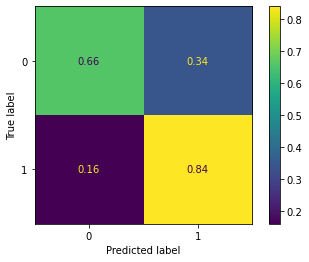

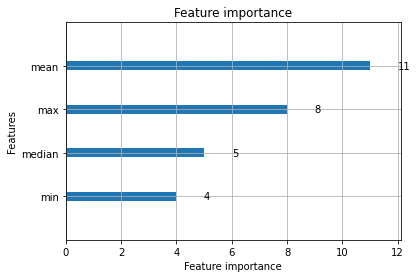

In [31]:
eval_clf(clf_tweets_agg, df_test_tweets_agg)

### Average features at the user level

> Mean

In [33]:
df_train_tweets_mean = get_mean(df_train_tweets, df_train['id'])
df_test_tweets_mean = get_mean(df_test_tweets, df_test['id'])

clf_tweets_mean = get_best_clf(df_train_tweets_mean)

[I 2022-04-10 23:54:03,102] A new study created in memory with name: no-name-95f5d132-5595-4ec9-b5be-6ca5bd960dfa


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:04,501] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 0.04445453790959298, 'lambda_l2': 0.0017402797759630579, 'num_leaves': 26, 'feature_fraction': 0.7276855020623667, 'bagging_fraction': 0.5793506522501062, 'bagging_freq': 7, 'learning_rate': 8.611485893376611e-05, 'min_child_samples': 73}. Best is trial 5 with value: 0.5.


Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.875734
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:05,032] Trial 7 finished with value: 0.8060103620800039 and parameters: {'lambda_l1': 0.0013649864970179735, 'lambda_l2': 2.5851330760856195, 'num_leaves': 33, 'feature_fraction': 0.6952353510402706, 'bagging_fraction': 0.970714500968519, 'bagging_freq': 7, 'learning_rate': 0.1177385735012373, 'min_child_samples': 89}. Best is trial 7 with value: 0.8060103620800039.


Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.896215
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.878164


[I 2022-04-10 23:54:05,252] Trial 2 finished with value: 0.6887018945770991 and parameters: {'lambda_l1': 0.00841769481209977, 'lambda_l2': 0.00026041995381800707, 'num_leaves': 234, 'feature_fraction': 0.5140399988191748, 'bagging_fraction': 0.754138613038444, 'bagging_freq': 5, 'learning_rate': 0.002550802918087664, 'min_child_samples': 88}. Best is trial 7 with value: 0.8060103620800039.


Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:05,644] Trial 1 finished with value: 0.792290090816399 and parameters: {'lambda_l1': 0.0067060950927073796, 'lambda_l2': 0.00010820773155624832, 'num_leaves': 203, 'feature_fraction': 0.449096287530518, 'bagging_fraction': 0.9263586730713419, 'bagging_freq': 3, 'learning_rate': 0.21346801849594732, 'min_child_samples': 94}. Best is trial 7 with value: 0.8060103620800039.


Did not meet early stopping. Best iteration is:
[56]	valid_0's auc: 0.882979
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:05,926] Trial 4 finished with value: 0.8080821852844238 and parameters: {'lambda_l1': 0.00017414260139699531, 'lambda_l2': 0.10241932471121808, 'num_leaves': 172, 'feature_fraction': 0.8639525745522209, 'bagging_fraction': 0.9335154129611984, 'bagging_freq': 2, 'learning_rate': 0.04208147529391974, 'min_child_samples': 83}. Best is trial 4 with value: 0.8080821852844238.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.896001
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[47]	valid_0's auc: 0.882111


[I 2022-04-10 23:54:06,098] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 2.1076548318754098e-08, 'lambda_l2': 0.00082798286478726, 'num_leaves': 198, 'feature_fraction': 0.7396862902537283, 'bagging_fraction': 0.5838872457575544, 'bagging_freq': 5, 'learning_rate': 0.00025123926836196237, 'min_child_samples': 46}. Best is trial 4 with value: 0.8080821852844238.
[I 2022-04-10 23:54:06,177] Trial 9 finished with value: 0.7783741967609609 and parameters: {'lambda_l1': 2.5809547241412396, 'lambda_l2': 2.8935357497436214e-07, 'num_leaves': 81, 'feature_fraction': 0.9349202494061802, 'bagging_fraction': 0.5176143897436898, 'bagging_freq': 4, 'learning_rate': 0.007961274829591001, 'min_child_samples': 82}. Best is trial 4 with value: 0.8080821852844238.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.875215
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:07,118] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 0.00829972791239168, 'lambda_l2': 1.058527981152702, 'num_leaves': 21, 'feature_fraction': 0.42880200055606366, 'bagging_fraction': 0.8967529281408722, 'bagging_freq': 1, 'learning_rate': 3.000610967299437e-05, 'min_child_samples': 52}. Best is trial 4 with value: 0.8080821852844238.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.87128
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:07,507] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 1.925463951834638e-08, 'lambda_l2': 0.04073025128469394, 'num_leaves': 252, 'feature_fraction': 0.8203272127729204, 'bagging_fraction': 0.9985994884935196, 'bagging_freq': 7, 'learning_rate': 0.0014453838324442062, 'min_child_samples': 70}. Best is trial 4 with value: 0.8080821852844238.


Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.872152
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:07,964] Trial 10 finished with value: 0.7739845398714817 and parameters: {'lambda_l1': 0.00012303964115837764, 'lambda_l2': 0.00032357635729085945, 'num_leaves': 58, 'feature_fraction': 0.8376843243145424, 'bagging_fraction': 0.9200347780623891, 'bagging_freq': 3, 'learning_rate': 0.004128342243706526, 'min_child_samples': 51}. Best is trial 4 with value: 0.8080821852844238.
[I 2022-04-10 23:54:08,027] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 2.9178543275753382e-08, 'lambda_l2': 0.00015079263211745594, 'num_leaves': 195, 'feature_fraction': 0.4080850775337867, 'bagging_fraction': 0.7581632098636897, 'bagging_freq': 5, 'learning_rate': 0.0010195379690673733, 'min_child_samples': 81}. Best is trial 4 with value: 0.8080821852844238.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.881897
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.877536
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:08,498] Trial 14 finished with value: 0.80140433452683 and parameters: {'lambda_l1': 0.00030018325427437807, 'lambda_l2': 1.9878775977907783e-08, 'num_leaves': 45, 'feature_fraction': 0.7370568797563601, 'bagging_fraction': 0.6016151443260682, 'bagging_freq': 5, 'learning_rate': 0.02736047038785778, 'min_child_samples': 8}. Best is trial 4 with value: 0.8080821852844238.


Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.890024
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:09,000] Trial 16 finished with value: 0.5158839779005524 and parameters: {'lambda_l1': 0.014554787619591362, 'lambda_l2': 1.6783261074033657, 'num_leaves': 194, 'feature_fraction': 0.6290891684279849, 'bagging_fraction': 0.6764989016334506, 'bagging_freq': 4, 'learning_rate': 0.0013108641469314326, 'min_child_samples': 77}. Best is trial 4 with value: 0.8080821852844238.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.877881
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:09,893] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 1.844472173879486e-06, 'lambda_l2': 1.5423159761453473e-08, 'num_leaves': 222, 'feature_fraction': 0.9861489781717222, 'bagging_fraction': 0.9232108033213321, 'bagging_freq': 1, 'learning_rate': 0.0002993047793984764, 'min_child_samples': 24}. Best is trial 4 with value: 0.8080821852844238.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.876531
Training until validation scores don't improve for 100 rounds

[I 2022-04-10 23:54:10,191] Trial 19 finished with value: 0.7991843122376876 and parameters: {'lambda_l1': 5.899317410583333e-06, 'lambda_l2': 4.430235078185596, 'num_leaves': 128, 'feature_fraction': 0.5946434414174716, 'bagging_fraction': 0.8250619673195512, 'bagging_freq': 1, 'learning_rate': 0.2718989013826927, 'min_child_samples': 98}. Best is trial 4 with value: 0.8080821852844238.



Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.887302
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:10,867] Trial 11 finished with value: 0.8109187157660114 and parameters: {'lambda_l1': 1.856090518977166e-07, 'lambda_l2': 1.1460223549448754e-08, 'num_leaves': 140, 'feature_fraction': 0.5597888863999372, 'bagging_fraction': 0.9549529479788815, 'bagging_freq': 7, 'learning_rate': 0.06989564936778032, 'min_child_samples': 38}. Best is trial 11 with value: 0.8109187157660114.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.896126


[I 2022-04-10 23:54:11,040] Trial 20 finished with value: 0.8054798093566973 and parameters: {'lambda_l1': 2.915744625666033e-06, 'lambda_l2': 0.05535274071440411, 'num_leaves': 121, 'feature_fraction': 0.9884011239900683, 'bagging_fraction': 0.8538944836990139, 'bagging_freq': 1, 'learning_rate': 0.2557691716745709, 'min_child_samples': 98}. Best is trial 11 with value: 0.8109187157660114.
[I 2022-04-10 23:54:11,121] Trial 15 finished with value: 0.7889852512270885 and parameters: {'lambda_l1': 3.523198725798775e-08, 'lambda_l2': 2.2029552479767385e-07, 'num_leaves': 250, 'feature_fraction': 0.6530685449503069, 'bagging_fraction': 0.5567691604431422, 'bagging_freq': 7, 'learning_rate': 0.23360293588650838, 'min_child_samples': 30}. Best is trial 11 with value: 0.8109187157660114.


Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.891695
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.878455


[I 2022-04-10 23:54:11,412] Trial 3 finished with value: 0.8100680530197045 and parameters: {'lambda_l1': 0.016739416788891317, 'lambda_l2': 0.00016183429628147418, 'num_leaves': 211, 'feature_fraction': 0.4791979455589766, 'bagging_fraction': 0.8445656678452023, 'bagging_freq': 4, 'learning_rate': 0.05504764879054872, 'min_child_samples': 19}. Best is trial 11 with value: 0.8109187157660114.


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.892926


[I 2022-04-10 23:54:11,742] Trial 21 finished with value: 0.7990361131529653 and parameters: {'lambda_l1': 1.0228456491986956e-05, 'lambda_l2': 7.922522209024808, 'num_leaves': 141, 'feature_fraction': 0.600895784603604, 'bagging_fraction': 0.8288070122588919, 'bagging_freq': 2, 'learning_rate': 0.25456130871861954, 'min_child_samples': 99}. Best is trial 11 with value: 0.8109187157660114.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.8884
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:12,620] Trial 25 finished with value: 0.8017926161288028 and parameters: {'lambda_l1': 1.2844610928479705e-05, 'lambda_l2': 8.1596049417138e-07, 'num_leaves': 155, 'feature_fraction': 0.5153714979779529, 'bagging_fraction': 0.44891099981814964, 'bagging_freq': 2, 'learning_rate': 0.03241476730789309, 'min_child_samples': 63}. Best is trial 11 with value: 0.8109187157660114.


Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.88882
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:13,341] Trial 18 finished with value: 0.8047091741161407 and parameters: {'lambda_l1': 5.735058717372763e-06, 'lambda_l2': 0.6335737188696701, 'num_leaves': 134, 'feature_fraction': 0.5936268301151038, 'bagging_fraction': 0.8227778091932297, 'bagging_freq': 1, 'learning_rate': 0.13706852213282605, 'min_child_samples': 21}. Best is trial 11 with value: 0.8109187157660114.
[I 2022-04-10 23:54:13,420] Trial 22 finished with value: 0.8103822350793162 and parameters: {'lambda_l1': 8.545874829799321e-06, 'lambda_l2': 0.06444354500519611, 'num_leaves': 143, 'feature_fraction': 0.8532666807309074, 'bagging_fraction': 0.9956915549911788, 'bagging_freq': 2, 'learning_rate': 0.04524813371807392, 'min_child_samples': 62}. Best is trial 11 with value: 0.8109187157660114.


Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.892487
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.893603
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:13,592] Trial 27 finished with value: 0.7947324117326252 and parameters: {'lambda_l1': 0.4472588211961928, 'lambda_l2': 1.002799324698752e-05, 'num_leaves': 152, 'feature_fraction': 0.5098645957553917, 'bagging_fraction': 0.4069494917649392, 'bagging_freq': 6, 'learning_rate': 0.01837614775039841, 'min_child_samples': 34}. Best is trial 11 with value: 0.8109187157660114.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.884834
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:14,070] Trial 17 finished with value: 0.8109928153083727 and parameters: {'lambda_l1': 1.9615126717918196e-06, 'lambda_l2': 4.952237495531367e-08, 'num_leaves': 145, 'feature_fraction': 0.9570053889185046, 'bagging_fraction': 0.7624273228442102, 'bagging_freq': 1, 'learning_rate': 0.035132967360604055, 'min_child_samples': 18}. Best is trial 17 with value: 0.8109928153083727.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.896197
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:14,729] Trial 26 finished with value: 0.8005536717805231 and parameters: {'lambda_l1': 0.3465669265454541, 'lambda_l2': 3.6422647143077465e-06, 'num_leaves': 164, 'feature_fraction': 0.5640911679709122, 'bagging_fraction': 0.8120794611508136, 'bagging_freq': 6, 'learning_rate': 0.014153516859505107, 'min_child_samples': 35}. Best is trial 17 with value: 0.8109928153083727.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.888319
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:15,325] Trial 23 finished with value: 0.8047032461527518 and parameters: {'lambda_l1': 9.625611440698e-07, 'lambda_l2': 1.5734798015238735e-06, 'num_leaves': 144, 'feature_fraction': 0.5520943523904898, 'bagging_fraction': 0.8309223654428882, 'bagging_freq': 2, 'learning_rate': 0.02482127379578842, 'min_child_samples': 36}. Best is trial 17 with value: 0.8109928153083727.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.894073
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:15,591] Trial 24 finished with value: 0.8082303843691462 and parameters: {'lambda_l1': 2.783068067867833e-05, 'lambda_l2': 2.584955219800433e-06, 'num_leaves': 159, 'feature_fraction': 0.5470860698667787, 'bagging_fraction': 0.8059613016539589, 'bagging_freq': 2, 'learning_rate': 0.034671095006883916, 'min_child_samples': 34}. Best is trial 17 with value: 0.8109928153083727.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.894376
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:16,109] Trial 28 finished with value: 0.8083845114172575 and parameters: {'lambda_l1': 0.3675805927055739, 'lambda_l2': 3.556877202625152e-06, 'num_leaves': 170, 'feature_fraction': 0.5267540176084123, 'bagging_fraction': 0.7790456951536063, 'bagging_freq': 6, 'learning_rate': 0.04350969710899403, 'min_child_samples': 36}. Best is trial 17 with value: 0.8109928153083727.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.895441
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:16,626] Trial 29 finished with value: 0.8106845612121499 and parameters: {'lambda_l1': 0.31661275912824804, 'lambda_l2': 4.3799958940516505e-06, 'num_leaves': 166, 'feature_fraction': 0.5253615102418636, 'bagging_fraction': 0.7557852954770286, 'bagging_freq': 6, 'learning_rate': 0.03637649392875861, 'min_child_samples': 39}. Best is trial 17 with value: 0.8109928153083727.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.892482
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:17,417] Trial 32 finished with value: 0.7896580750717284 and parameters: {'lambda_l1': 3.64968896570241e-07, 'lambda_l2': 3.635102308674113e-06, 'num_leaves': 93, 'feature_fraction': 0.900414471199358, 'bagging_fraction': 0.6887864831750182, 'bagging_freq': 3, 'learning_rate': 0.009758075359030048, 'min_child_samples': 43}. Best is trial 17 with value: 0.8109928153083727.
[I 2022-04-10 23:54:17,542] Trial 30 finished with value: 0.7947946553482086 and parameters: {'lambda_l1': 2.4591358073486887e-07, 'lambda_l2': 6.026064496638565e-06, 'num_leaves': 101, 'feature_fraction': 0.5206238329463382, 'bagging_fraction': 0.8741898772617, 'bagging_freq': 6, 'learning_rate': 0.010587541001455987, 'min_child_samples': 39}. Best is trial 17 with value: 0.8109928153083727.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.889775
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.887877
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:17,872] Trial 31 finished with value: 0.8079280582363123 and parameters: {'lambda_l1': 5.729757213780579e-07, 'lambda_l2': 0.004517769527613375, 'num_leaves': 99, 'feature_fraction': 0.46997545174611327, 'bagging_fraction': 0.9990819016971295, 'bagging_freq': 3, 'learning_rate': 0.07118224200045656, 'min_child_samples': 41}. Best is trial 17 with value: 0.8109928153083727.
[I 2022-04-10 23:54:17,950] Trial 34 finished with value: 0.7866614895786406 and parameters: {'lambda_l1': 2.4168852805201126e-07, 'lambda_l2': 1.1509674155053907e-07, 'num_leaves': 96, 'feature_fraction': 0.9036377787514039, 'bagging_fraction': 0.685568768252026, 'bagging_freq': 3, 'learning_rate': 0.00891920311182263, 'min_child_samples': 62}. Best is trial 17 with value: 0.8109928153083727.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.891945
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.885155
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:19,315] Trial 33 finished with value: 0.8062445166338652 and parameters: {'lambda_l1': 3.496862187301164e-07, 'lambda_l2': 4.282587531135015e-08, 'num_leaves': 103, 'feature_fraction': 0.7918257911160987, 'bagging_fraction': 0.9986266174625458, 'bagging_freq': 2, 'learning_rate': 0.07030500564590855, 'min_child_samples': 44}. Best is trial 17 with value: 0.8109928153083727.


Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.894088
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:20,067] Trial 38 finished with value: 0.8066268702724492 and parameters: {'lambda_l1': 2.5053550905081804e-07, 'lambda_l2': 1.9770686905033053e-08, 'num_leaves': 102, 'feature_fraction': 0.9471151894171379, 'bagging_fraction': 0.6480347256676141, 'bagging_freq': 6, 'learning_rate': 0.07554961690517453, 'min_child_samples': 61}. Best is trial 17 with value: 0.8109928153083727.


Did not meet early stopping. Best iteration is:
[53]	valid_0's auc: 0.893692


[I 2022-04-10 23:54:20,318] Trial 39 finished with value: 0.8048633011642521 and parameters: {'lambda_l1': 3.996512685823394e-07, 'lambda_l2': 3.600455183453738e-08, 'num_leaves': 179, 'feature_fraction': 0.9418308574829435, 'bagging_fraction': 0.7181360155111736, 'bagging_freq': 7, 'learning_rate': 0.1100020359955881, 'min_child_samples': 64}. Best is trial 17 with value: 0.8109928153083727.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.892175


[I 2022-04-10 23:54:20,585] Trial 40 finished with value: 0.8039444668389728 and parameters: {'lambda_l1': 1.1536293372221374e-07, 'lambda_l2': 1.3249579717080624e-08, 'num_leaves': 118, 'feature_fraction': 0.9430275616303495, 'bagging_fraction': 0.6657300400868432, 'bagging_freq': 7, 'learning_rate': 0.09929215708648727, 'min_child_samples': 61}. Best is trial 17 with value: 0.8109928153083727.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[47]	valid_0's auc: 0.891038


[I 2022-04-10 23:54:20,773] Trial 35 finished with value: 0.7978594124202688 and parameters: {'lambda_l1': 2.5880927752311585e-07, 'lambda_l2': 6.483683822826579e-08, 'num_leaves': 100, 'feature_fraction': 0.8972056140772897, 'bagging_fraction': 0.684632383572047, 'bagging_freq': 3, 'learning_rate': 0.00836619564718846, 'min_child_samples': 13}. Best is trial 17 with value: 0.8109928153083727.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.888813
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:21,166] Trial 46 finished with value: 0.6989246674412538 and parameters: {'lambda_l1': 0.0014340338861382434, 'lambda_l2': 3.449018998619501e-05, 'num_leaves': 3, 'feature_fraction': 0.7735404203488339, 'bagging_fraction': 0.9468142823860991, 'bagging_freq': 1, 'learning_rate': 0.003318863428544037, 'min_child_samples': 27}. Best is trial 17 with value: 0.8109928153083727.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.817398
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.89025


[I 2022-04-10 23:54:21,385] Trial 36 finished with value: 0.7933334123728452 and parameters: {'lambda_l1': 4.3888472306311926e-07, 'lambda_l2': 1.545892613641828e-08, 'num_leaves': 101, 'feature_fraction': 0.9332599097203114, 'bagging_fraction': 0.6760564343257662, 'bagging_freq': 3, 'learning_rate': 0.008186475337953723, 'min_child_samples': 13}. Best is trial 17 with value: 0.8109928153083727.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:22,200] Trial 37 finished with value: 0.7860449813861949 and parameters: {'lambda_l1': 1.5964421052338236e-07, 'lambda_l2': 1.3024100614770715e-08, 'num_leaves': 101, 'feature_fraction': 0.9239731214866762, 'bagging_fraction': 0.6988933885010984, 'bagging_freq': 6, 'learning_rate': 0.007815698920998386, 'min_child_samples': 7}. Best is trial 17 with value: 0.8109928153083727.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.88722
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:23,173] Trial 41 finished with value: 0.8111528703198729 and parameters: {'lambda_l1': 3.788452914385546e-05, 'lambda_l2': 9.259608806762236e-08, 'num_leaves': 178, 'feature_fraction': 0.7872245578074566, 'bagging_fraction': 0.62937701463765, 'bagging_freq': 6, 'learning_rate': 0.10348340649692506, 'min_child_samples': 27}. Best is trial 41 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.892053
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:24,176] Trial 48 finished with value: 0.8040185663813341 and parameters: {'lambda_l1': 7.081238709095288, 'lambda_l2': 4.266491314291435e-05, 'num_leaves': 220, 'feature_fraction': 0.45069978208484174, 'bagging_fraction': 0.9541996621276234, 'bagging_freq': 5, 'learning_rate': 0.04542277319116326, 'min_child_samples': 20}. Best is trial 41 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.891868
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:25,791] Trial 44 finished with value: 0.7721409432575344 and parameters: {'lambda_l1': 5.5864261354555876e-05, 'lambda_l2': 2.199756942454513e-05, 'num_leaves': 120, 'feature_fraction': 0.7697625270314392, 'bagging_fraction': 0.9475879904509468, 'bagging_freq': 1, 'learning_rate': 0.004486141225910035, 'min_child_samples': 14}. Best is trial 41 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.886367
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:27,062] Trial 42 finished with value: 0.7579345789960403 and parameters: {'lambda_l1': 3.7017713151211724e-05, 'lambda_l2': 3.548804368977143e-05, 'num_leaves': 180, 'feature_fraction': 0.9571528473643222, 'bagging_fraction': 0.7263404964465683, 'bagging_freq': 6, 'learning_rate': 0.0032091208856993413, 'min_child_samples': 11}. Best is trial 41 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.886245
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:27,548] Trial 43 finished with value: 0.7332890712066962 and parameters: {'lambda_l1': 5.5949310265362456e-05, 'lambda_l2': 3.394052439737746e-05, 'num_leaves': 175, 'feature_fraction': 0.7805495359618053, 'bagging_fraction': 0.7243306309711621, 'bagging_freq': 7, 'learning_rate': 0.0038209881525064437, 'min_child_samples': 12}. Best is trial 41 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[56]	valid_0's auc: 0.889727
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:29,006] Trial 50 finished with value: 0.8060903895857539 and parameters: {'lambda_l1': 5.1751152029491446e-05, 'lambda_l2': 5.393839225593813e-07, 'num_leaves': 184, 'feature_fraction': 0.8179736859744228, 'bagging_fraction': 0.6331100490460008, 'bagging_freq': 4, 'learning_rate': 0.1479705663984682, 'min_child_samples': 22}. Best is trial 41 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.887563
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:29,289] Trial 51 finished with value: 0.7992702677068266 and parameters: {'lambda_l1': 6.189758014494007e-05, 'lambda_l2': 2.918083223095373e-07, 'num_leaves': 182, 'feature_fraction': 0.8587620764800034, 'bagging_fraction': 0.6391794358968561, 'bagging_freq': 4, 'learning_rate': 0.15264813082283804, 'min_child_samples': 26}. Best is trial 41 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.886991


[I 2022-04-10 23:54:29,524] Trial 49 finished with value: 0.5 and parameters: {'lambda_l1': 0.04782561465492553, 'lambda_l2': 5.054228796660905e-05, 'num_leaves': 219, 'feature_fraction': 0.48711460822969305, 'bagging_fraction': 0.9507611670434649, 'bagging_freq': 5, 'learning_rate': 0.0005617131414916235, 'min_child_samples': 21}. Best is trial 41 with value: 0.8111528703198729.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.888165
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:30,010] Trial 45 finished with value: 0.7701432195954758 and parameters: {'lambda_l1': 4.931268557972829e-05, 'lambda_l2': 1.3679180071774351e-05, 'num_leaves': 221, 'feature_fraction': 0.6661929882800467, 'bagging_fraction': 0.9466308851823231, 'bagging_freq': 1, 'learning_rate': 0.0037320635537208303, 'min_child_samples': 13}. Best is trial 41 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.888273
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.888812


[I 2022-04-10 23:54:30,453] Trial 47 finished with value: 0.5 and parameters: {'lambda_l1': 3.490226494321367e-05, 'lambda_l2': 2.5823024918416878e-05, 'num_leaves': 225, 'feature_fraction': 0.6695654080894016, 'bagging_fraction': 0.8929967361570835, 'bagging_freq': 5, 'learning_rate': 0.0007525885995376396, 'min_child_samples': 16}. Best is trial 41 with value: 0.8111528703198729.


Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:31,655] Trial 54 finished with value: 0.8056339364048088 and parameters: {'lambda_l1': 0.0013722141955405552, 'lambda_l2': 2.8306803662068364e-07, 'num_leaves': 142, 'feature_fraction': 0.8570920214058058, 'bagging_fraction': 0.9112673552933647, 'bagging_freq': 5, 'learning_rate': 0.15915958966942279, 'min_child_samples': 48}. Best is trial 41 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.890155
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:32,156] Trial 52 finished with value: 0.5 and parameters: {'lambda_l1': 1.7988305516215704e-06, 'lambda_l2': 5.63573199537659e-07, 'num_leaves': 182, 'feature_fraction': 0.8628634263541317, 'bagging_fraction': 0.9105234715513184, 'bagging_freq': 7, 'learning_rate': 0.0005368096912099075, 'min_child_samples': 29}. Best is trial 41 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.880359
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:32,927] Trial 55 finished with value: 0.5 and parameters: {'lambda_l1': 1.7693484112244486e-06, 'lambda_l2': 0.004537587672400608, 'num_leaves': 209, 'feature_fraction': 0.6977398628394641, 'bagging_fraction': 0.9162216760049904, 'bagging_freq': 7, 'learning_rate': 0.00040435682292990724, 'min_child_samples': 50}. Best is trial 41 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.880522
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:33,413] Trial 56 finished with value: 0.5 and parameters: {'lambda_l1': 1.5615479945560058e-06, 'lambda_l2': 1.279766667343171e-07, 'num_leaves': 145, 'feature_fraction': 0.7135506179510582, 'bagging_fraction': 0.900715643024333, 'bagging_freq': 5, 'learning_rate': 0.0003793790162426786, 'min_child_samples': 49}. Best is trial 41 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.883967
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:33,696] Trial 57 finished with value: 0.8024772959002204 and parameters: {'lambda_l1': 0.000725644406755174, 'lambda_l2': 0.0038045915435087523, 'num_leaves': 145, 'feature_fraction': 0.6705891856087955, 'bagging_fraction': 0.8979157560305164, 'bagging_freq': 7, 'learning_rate': 0.020172048679411178, 'min_child_samples': 48}. Best is trial 41 with value: 0.8111528703198729.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.894374
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:34,245] Trial 59 finished with value: 0.8121458041875134 and parameters: {'lambda_l1': 2.964679159704122e-06, 'lambda_l2': 0.010524790278960416, 'num_leaves': 204, 'feature_fraction': 0.6972440295590574, 'bagging_fraction': 0.7726027412945242, 'bagging_freq': 7, 'learning_rate': 0.05509218052004615, 'min_child_samples': 48}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.89699


[I 2022-04-10 23:54:34,543] Trial 58 finished with value: 0.8078480307305623 and parameters: {'lambda_l1': 0.0013864243862168769, 'lambda_l2': 0.002428996112392017, 'num_leaves': 235, 'feature_fraction': 0.7053864124813535, 'bagging_fraction': 0.9135095799023314, 'bagging_freq': 4, 'learning_rate': 0.05799525114145626, 'min_child_samples': 49}. Best is trial 59 with value: 0.8121458041875134.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.89422
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:35,249] Trial 53 finished with value: 0.8005655277073008 and parameters: {'lambda_l1': 1.8698698455654981e-06, 'lambda_l2': 3.49029937849926e-07, 'num_leaves': 208, 'feature_fraction': 0.695544383942587, 'bagging_fraction': 0.9000865121441418, 'bagging_freq': 7, 'learning_rate': 0.13073690841966493, 'min_child_samples': 26}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.889621
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:35,907] Trial 61 finished with value: 0.8046291466103905 and parameters: {'lambda_l1': 0.05174270419090209, 'lambda_l2': 0.00433637152623871, 'num_leaves': 204, 'feature_fraction': 0.40251150691235044, 'bagging_fraction': 0.7732071498424493, 'bagging_freq': 4, 'learning_rate': 0.05429514471489651, 'min_child_samples': 56}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.892917
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:36,802] Trial 62 finished with value: 0.7978712683470467 and parameters: {'lambda_l1': 0.04146912779994261, 'lambda_l2': 0.00034860547821815517, 'num_leaves': 204, 'feature_fraction': 0.4100958213810187, 'bagging_fraction': 0.7787873132510448, 'bagging_freq': 2, 'learning_rate': 0.01905195280430237, 'min_child_samples': 56}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.888551
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:37,403] Trial 63 finished with value: 0.8042467929718066 and parameters: {'lambda_l1': 0.00041958440887734856, 'lambda_l2': 0.00056488434983745, 'num_leaves': 201, 'feature_fraction': 0.41063327153447415, 'bagging_fraction': 0.7594644739777238, 'bagging_freq': 4, 'learning_rate': 0.05449675645230125, 'min_child_samples': 58}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.890519
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:37,591] Trial 64 finished with value: 0.5 and parameters: {'lambda_l1': 0.04085665398598315, 'lambda_l2': 0.0005171296362435422, 'num_leaves': 201, 'feature_fraction': 0.9710855727382112, 'bagging_fraction': 0.7733550829512941, 'bagging_freq': 4, 'learning_rate': 1.2776935513172336e-05, 'min_child_samples': 56}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.877131
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:37,874] Trial 65 finished with value: 0.5 and parameters: {'lambda_l1': 4.679953493242992e-06, 'lambda_l2': 0.012487171964289912, 'num_leaves': 191, 'feature_fraction': 0.7514150887987305, 'bagging_fraction': 0.7822888183557369, 'bagging_freq': 6, 'learning_rate': 1.5669348710103682e-05, 'min_child_samples': 56}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[47]	valid_0's auc: 0.879519
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.893055


[I 2022-04-10 23:54:38,282] Trial 60 finished with value: 0.8117634505489294 and parameters: {'lambda_l1': 2.3563018792202632e-06, 'lambda_l2': 0.008473149076919767, 'num_leaves': 203, 'feature_fraction': 0.7147967519667661, 'bagging_fraction': 0.7655004378553393, 'bagging_freq': 7, 'learning_rate': 0.05101574366707519, 'min_child_samples': 30}. Best is trial 59 with value: 0.8121458041875134.
[I 2022-04-10 23:54:38,611] Trial 66 finished with value: 0.8019467431769141 and parameters: {'lambda_l1': 4.5495439301346115e-06, 'lambda_l2': 0.015410189243008524, 'num_leaves': 165, 'feature_fraction': 0.9764127391827394, 'bagging_fraction': 0.7801669118218892, 'bagging_freq': 6, 'learning_rate': 0.03029030490161869, 'min_child_samples': 54}. Best is trial 59 with value: 0.8121458041875134.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.891847


[I 2022-04-10 23:54:38,846] Trial 67 finished with value: 0.5 and parameters: {'lambda_l1': 9.847438070273135e-06, 'lambda_l2': 0.016046511791192746, 'num_leaves': 197, 'feature_fraction': 0.6185673702909386, 'bagging_fraction': 0.7780362636612975, 'bagging_freq': 6, 'learning_rate': 7.037871105048512e-05, 'min_child_samples': 57}. Best is trial 59 with value: 0.8121458041875134.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.881797
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:40,053] Trial 70 finished with value: 0.5 and parameters: {'lambda_l1': 4.764007943971131e-06, 'lambda_l2': 0.17234116290047746, 'num_leaves': 191, 'feature_fraction': 0.48632090861198424, 'bagging_fraction': 0.8460021305852609, 'bagging_freq': 6, 'learning_rate': 0.00011355263969473268, 'min_child_samples': 69}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.881049
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:40,728] Trial 71 finished with value: 0.5 and parameters: {'lambda_l1': 1.0922150740335478e-08, 'lambda_l2': 0.025978922357774097, 'num_leaves': 167, 'feature_fraction': 0.6122919673314327, 'bagging_fraction': 0.9811778707373109, 'bagging_freq': 6, 'learning_rate': 0.00016901020017077452, 'min_child_samples': 68}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.88118
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:41,088] Trial 72 finished with value: 0.8050115002489746 and parameters: {'lambda_l1': 1.079368986106563e-05, 'lambda_l2': 0.019794719533164973, 'num_leaves': 165, 'feature_fraction': 0.627224791829261, 'bagging_fraction': 0.9779756297308249, 'bagging_freq': 6, 'learning_rate': 0.029647947745578822, 'min_child_samples': 69}. Best is trial 59 with value: 0.8121458041875134.
[I 2022-04-10 23:54:41,198] Trial 68 finished with value: 0.5 and parameters: {'lambda_l1': 5.236013520906816e-06, 'lambda_l2': 0.019241356248819008, 'num_leaves': 192, 'feature_fraction': 0.4849499491420094, 'bagging_fraction': 0.7576794749198159, 'bagging_freq': 6, 'learning_rate': 0.0001894510576794449, 'min_child_samples': 31}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.894081
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.884498
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:41,763] Trial 73 finished with value: 0.8049374007066132 and parameters: {'lambda_l1': 5.6529849489971686e-08, 'lambda_l2': 0.2918691824605137, 'num_leaves': 162, 'feature_fraction': 0.6245850221594333, 'bagging_fraction': 0.5420050687491035, 'bagging_freq': 7, 'learning_rate': 0.031204959482073687, 'min_child_samples': 31}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.89318


[I 2022-04-10 23:54:42,124] Trial 69 finished with value: 0.5 and parameters: {'lambda_l1': 5.249203134760272e-08, 'lambda_l2': 0.011926515373056206, 'num_leaves': 192, 'feature_fraction': 0.9727048556268579, 'bagging_fraction': 0.7591273443949285, 'bagging_freq': 6, 'learning_rate': 1.0053876411688414e-05, 'min_child_samples': 31}. Best is trial 59 with value: 0.8121458041875134.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.877605
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:42,954] Trial 74 finished with value: 0.8039444668389728 and parameters: {'lambda_l1': 1.2479737713940252e-05, 'lambda_l2': 0.009611290401417507, 'num_leaves': 133, 'feature_fraction': 0.8073777385577151, 'bagging_fraction': 0.6109165761299986, 'bagging_freq': 7, 'learning_rate': 0.09817025645037386, 'min_child_samples': 31}. Best is trial 59 with value: 0.8121458041875134.
[I 2022-04-10 23:54:43,111] Trial 76 finished with value: 0.802717378417471 and parameters: {'lambda_l1': 7.599178566801096e-08, 'lambda_l2': 0.30605446133614483, 'num_leaves': 153, 'feature_fraction': 0.8033305692990417, 'bagging_fraction': 0.5257425448515545, 'bagging_freq': 7, 'learning_rate': 0.09238226854011862, 'min_child_samples': 39}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.894639
Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.888757
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:44,508] Trial 77 finished with value: 0.8011079363573851 and parameters: {'lambda_l1': 9.476274031400092e-07, 'lambda_l2': 0.1610476840271993, 'num_leaves': 155, 'feature_fraction': 0.8123138294366083, 'bagging_fraction': 0.5525525785843861, 'bagging_freq': 7, 'learning_rate': 0.0902840071012723, 'min_child_samples': 31}. Best is trial 59 with value: 0.8121458041875134.
[I 2022-04-10 23:54:44,554] Trial 75 finished with value: 0.8054738813933087 and parameters: {'lambda_l1': 4.637624348687978e-08, 'lambda_l2': 0.24140276349701004, 'num_leaves': 130, 'feature_fraction': 0.8115302011219457, 'bagging_fraction': 0.9791276840190835, 'bagging_freq': 7, 'learning_rate': 0.09543316257337708, 'min_child_samples': 31}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.888655
Did not meet early stopping. Best iteration is:
[55]	valid_0's auc: 0.890297
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:45,307] Trial 78 finished with value: 0.811997605102791 and parameters: {'lambda_l1': 0.7525080398677525, 'lambda_l2': 0.1795982222912088, 'num_leaves': 130, 'feature_fraction': 0.8133921463761155, 'bagging_fraction': 0.7990200710607096, 'bagging_freq': 7, 'learning_rate': 0.0832260615951186, 'min_child_samples': 32}. Best is trial 59 with value: 0.8121458041875134.
[I 2022-04-10 23:54:45,481] Trial 81 finished with value: 0.8083904393806465 and parameters: {'lambda_l1': 1.0607319078838844, 'lambda_l2': 0.11581557014684092, 'num_leaves': 129, 'feature_fraction': 0.5780423887486387, 'bagging_fraction': 0.8039420055657234, 'bagging_freq': 7, 'learning_rate': 0.08533975210223985, 'min_child_samples': 39}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.892759
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.896262
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:45,966] Trial 82 finished with value: 0.800091290636189 and parameters: {'lambda_l1': 0.8962456160088234, 'lambda_l2': 0.0844902360523832, 'num_leaves': 155, 'feature_fraction': 0.56362682325138, 'bagging_fraction': 0.8013888465894385, 'bagging_freq': 7, 'learning_rate': 0.014270724276663945, 'min_child_samples': 39}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.890782
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:47,205] Trial 84 finished with value: 0.7952570364925426 and parameters: {'lambda_l1': 0.8780898863992584, 'lambda_l2': 0.00011750183371618617, 'num_leaves': 242, 'feature_fraction': 0.8399802324190622, 'bagging_fraction': 0.7373000510127077, 'bagging_freq': 2, 'learning_rate': 0.014123949370667898, 'min_child_samples': 44}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.889406
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:48,086] Trial 80 finished with value: 0.7979572238161857 and parameters: {'lambda_l1': 8.274308216156734e-07, 'lambda_l2': 0.00120396954979653, 'num_leaves': 132, 'feature_fraction': 0.5697238309673024, 'bagging_fraction': 0.8060978622233452, 'bagging_freq': 7, 'learning_rate': 0.08528903389780028, 'min_child_samples': 18}. Best is trial 59 with value: 0.8121458041875134.


Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.894273
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:48,647] Trial 79 finished with value: 0.8133728926090154 and parameters: {'lambda_l1': 6.653353705079943e-08, 'lambda_l2': 0.13682167777836088, 'num_leaves': 241, 'feature_fraction': 0.8307165922147308, 'bagging_fraction': 0.7435617507213425, 'bagging_freq': 7, 'learning_rate': 0.08897718064475184, 'min_child_samples': 18}. Best is trial 79 with value: 0.8133728926090154.


Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.893678


[I 2022-04-10 23:54:48,867] Trial 83 finished with value: 0.7943382021672635 and parameters: {'lambda_l1': 8.265555722240171e-07, 'lambda_l2': 0.10292832037039906, 'num_leaves': 126, 'feature_fraction': 0.5706428702212615, 'bagging_fraction': 0.8681069390097547, 'bagging_freq': 2, 'learning_rate': 0.012236968499798648, 'min_child_samples': 18}. Best is trial 79 with value: 0.8133728926090154.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.891268
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:49,463] Trial 85 finished with value: 0.8066387261992269 and parameters: {'lambda_l1': 0.895987611275623, 'lambda_l2': 3.342771079789931e-08, 'num_leaves': 234, 'feature_fraction': 0.5785634873222695, 'bagging_fraction': 0.8003837122785324, 'bagging_freq': 2, 'learning_rate': 0.19861006693393998, 'min_child_samples': 18}. Best is trial 79 with value: 0.8133728926090154.
[I 2022-04-10 23:54:49,557] Trial 86 finished with value: 0.8055598368624476 and parameters: {'lambda_l1': 0.11983193135662197, 'lambda_l2': 4.448021434266342e-08, 'num_leaves': 114, 'feature_fraction': 0.7525390642494314, 'bagging_fraction': 0.8014653388443195, 'bagging_freq': 7, 'learning_rate': 0.21258132016875014, 'min_child_samples': 38}. Best is trial 79 with value: 0.8133728926090154.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.885353
Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.890928
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:51,658] Trial 88 finished with value: 0.8033338866099162 and parameters: {'lambda_l1': 0.00014529996370360622, 'lambda_l2': 0.0001154374840642419, 'num_leaves': 112, 'feature_fraction': 0.8328965947715824, 'bagging_fraction': 0.7400021215711857, 'bagging_freq': 2, 'learning_rate': 0.18442820775195856, 'min_child_samples': 19}. Best is trial 79 with value: 0.8133728926090154.
[I 2022-04-10 23:54:51,753] Trial 87 finished with value: 0.7986537595143812 and parameters: {'lambda_l1': 0.10862284469819679, 'lambda_l2': 0.06098865780413057, 'num_leaves': 173, 'feature_fraction': 0.8363962680053019, 'bagging_fraction': 0.7098888111502286, 'bagging_freq': 7, 'learning_rate': 0.21341582413862673, 'min_child_samples': 17}. Best is trial 79 with value: 0.8133728926090154.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.88887
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.882526
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:53,352] Trial 90 finished with value: 0.8150623621748512 and parameters: {'lambda_l1': 0.14963173303112148, 'lambda_l2': 0.6971528330557221, 'num_leaves': 111, 'feature_fraction': 0.7563789602348154, 'bagging_fraction': 0.8682463037260726, 'bagging_freq': 1, 'learning_rate': 0.04124926016141617, 'min_child_samples': 24}. Best is trial 90 with value: 0.8150623621748512.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.894435


[I 2022-04-10 23:54:53,666] Trial 89 finished with value: 0.8024832238636094 and parameters: {'lambda_l1': 0.00015540049814806057, 'lambda_l2': 0.7348152138918687, 'num_leaves': 138, 'feature_fraction': 0.7503102427870189, 'bagging_fraction': 0.8619080755313951, 'bagging_freq': 1, 'learning_rate': 0.041896022569915, 'min_child_samples': 19}. Best is trial 90 with value: 0.8150623621748512.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.892892


[I 2022-04-10 23:54:53,901] Trial 91 finished with value: 0.8043208925141678 and parameters: {'lambda_l1': 0.00011716090798165442, 'lambda_l2': 0.7044701734589172, 'num_leaves': 115, 'feature_fraction': 0.880454067800834, 'bagging_fraction': 0.7364504269578889, 'bagging_freq': 7, 'learning_rate': 0.0407537605540316, 'min_child_samples': 24}. Best is trial 90 with value: 0.8150623621748512.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.892465
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.882318


[I 2022-04-10 23:54:54,042] Trial 92 finished with value: 0.7995785218030493 and parameters: {'lambda_l1': 1.95577592231223e-05, 'lambda_l2': 0.7852195928941647, 'num_leaves': 109, 'feature_fraction': 0.8860735720632296, 'bagging_fraction': 0.7448643141152826, 'bagging_freq': 7, 'learning_rate': 0.21870647427128195, 'min_child_samples': 23}. Best is trial 90 with value: 0.8150623621748512.


Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:54:54,889] Trial 93 finished with value: 0.8050855997913358 and parameters: {'lambda_l1': 0.00012733398461276416, 'lambda_l2': 0.6536036566971428, 'num_leaves': 255, 'feature_fraction': 0.881715962695196, 'bagging_fraction': 0.7054079244999505, 'bagging_freq': 7, 'learning_rate': 0.04264618818367896, 'min_child_samples': 23}. Best is trial 90 with value: 0.8150623621748512.
[I 2022-04-10 23:54:54,952] Trial 94 finished with value: 0.8041608375026676 and parameters: {'lambda_l1': 1.7087286004240437e-05, 'lambda_l2': 0.6796992497966065, 'num_leaves': 139, 'feature_fraction': 0.8284078555039002, 'bagging_fraction': 0.7104715102771739, 'bagging_freq': 7, 'learning_rate': 0.03924927019012771, 'min_child_samples': 23}. Best is trial 90 with value: 0.8150623621748512.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.895706
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.894679


[I 2022-04-10 23:54:55,563] Trial 96 finished with value: 0.8119175775970408 and parameters: {'lambda_l1': 1.9830680097028222e-05, 'lambda_l2': 0.4735193882113362, 'num_leaves': 137, 'feature_fraction': 0.8858846610487936, 'bagging_fraction': 0.7381418191506828, 'bagging_freq': 7, 'learning_rate': 0.04308079590974831, 'min_child_samples': 34}. Best is trial 90 with value: 0.8150623621748512.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.895342


[I 2022-04-10 23:54:55,861] Trial 97 finished with value: 0.8053138263818084 and parameters: {'lambda_l1': 2.7282325303309274, 'lambda_l2': 0.5585871437690463, 'num_leaves': 88, 'feature_fraction': 0.7255097634431431, 'bagging_fraction': 0.7371763745574039, 'bagging_freq': 1, 'learning_rate': 0.023174517150299806, 'min_child_samples': 23}. Best is trial 90 with value: 0.8150623621748512.
[I 2022-04-10 23:54:55,986] Trial 95 finished with value: 0.804394992056529 and parameters: {'lambda_l1': 1.953007865061907e-05, 'lambda_l2': 0.9680589704662225, 'num_leaves': 172, 'feature_fraction': 0.878385055638773, 'bagging_fraction': 0.706515874641921, 'bagging_freq': 7, 'learning_rate': 0.03989405812480415, 'min_child_samples': 23}. Best is trial 90 with value: 0.8150623621748512.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.889971
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.894396


[I 2022-04-10 23:54:56,159] Trial 98 finished with value: 0.8054679534299196 and parameters: {'lambda_l1': 2.9510120557531457e-06, 'lambda_l2': 3.024268073858882, 'num_leaves': 82, 'feature_fraction': 0.8801984353976868, 'bagging_fraction': 0.7424634363889586, 'bagging_freq': 1, 'learning_rate': 0.02251176018167227, 'min_child_samples': 24}. Best is trial 90 with value: 0.8150623621748512.
[I 2022-04-10 23:54:56,175] Trial 99 finished with value: 0.8019467431769141 and parameters: {'lambda_l1': 3.09793430591351, 'lambda_l2': 0.03819168949765079, 'num_leaves': 86, 'feature_fraction': 0.7850669782348667, 'bagging_fraction': 0.7047644355375874, 'bagging_freq': 1, 'learning_rate': 0.0656583868151124, 'min_child_samples': 23}. Best is trial 90 with value: 0.8150623621748512.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.89239
Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.892246
{'lambda_l1': 0.14963173303112148, 'lambda_l2': 0.6971528330557221, 'num_leaves': 111, 'feature_fraction': 0.7563789602348154, 'bagging_fraction': 0.8682463037260726, 'bagging_freq': 1, 'learning_rate': 0.04124926016141617, 'min_child_samples': 24} -> 0.8150623621748512
[LightGBM] [Warning] feature_fraction is set=0.7563789602348154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563789602348154
[LightGBM] [Warning] lambda_l1 is set=0.14963173303112148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14963173303112148
[LightGBM] [Warning] bagging_fraction is set=0.8682463037260726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8682463037260726
[LightGBM] [Warning] lambda_l2 is set=0.6971528330557221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6971528330557221
[Light

AUROC: 0.7916781767955801
Accuracy: 0.7954353338968724


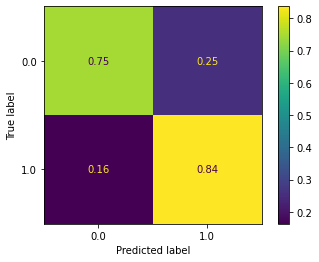

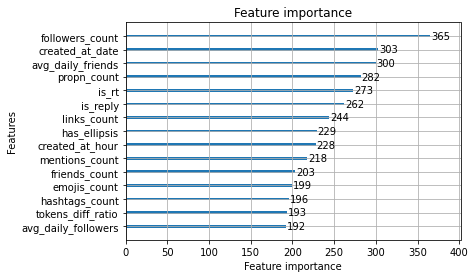

In [34]:
eval_clf(clf_tweets_mean, df_test_tweets_mean)

> Median

In [35]:
df_train_tweets_median = get_median(df_train_tweets, df_train['id'])
df_test_tweets_median = get_median(df_test_tweets, df_test['id'])

clf_tweets_median = get_best_clf(df_train_tweets_median)

[I 2022-04-10 23:55:15,107] A new study created in memory with name: no-name-c16e8a42-b595-45ea-85f9-da14152bbc72


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:15,500] Trial 1 finished with value: 0.7031483413558439 and parameters: {'lambda_l1': 4.8600505695082334e-08, 'lambda_l2': 1.2773862347282319, 'num_leaves': 4, 'feature_fraction': 0.8277540607273373, 'bagging_fraction': 0.6995827110281715, 'bagging_freq': 3, 'learning_rate': 0.005533858021727403, 'min_child_samples': 73}. Best is trial 1 with value: 0.7031483413558439.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.828579
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:16,048] Trial 3 finished with value: 0.6600046238114434 and parameters: {'lambda_l1': 1.0375524864254215e-06, 'lambda_l2': 0.0015212385256284315, 'num_leaves': 229, 'feature_fraction': 0.5376310158637245, 'bagging_fraction': 0.41923567751911156, 'bagging_freq': 3, 'learning_rate': 0.0025299586107870695, 'min_child_samples': 89}. Best is trial 1 with value: 0.7031483413558439.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.854663
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:16,299] Trial 7 finished with value: 0.7552758874161194 and parameters: {'lambda_l1': 3.388097787375838, 'lambda_l2': 0.1653439526449676, 'num_leaves': 138, 'feature_fraction': 0.6243137924610016, 'bagging_fraction': 0.8954307124466148, 'bagging_freq': 7, 'learning_rate': 0.009204582269248614, 'min_child_samples': 75}. Best is trial 7 with value: 0.7552758874161194.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.85983
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.871473


[I 2022-04-10 23:55:16,503] Trial 6 finished with value: 0.7796990965783795 and parameters: {'lambda_l1': 1.5024086210202465e-05, 'lambda_l2': 2.9357845535254437, 'num_leaves': 92, 'feature_fraction': 0.9803909016805318, 'bagging_fraction': 0.6301672291440092, 'bagging_freq': 1, 'learning_rate': 0.035918518583300425, 'min_child_samples': 62}. Best is trial 6 with value: 0.7796990965783795.
[I 2022-04-10 23:55:16,770] Trial 8 finished with value: 0.7905146657814242 and parameters: {'lambda_l1': 0.0012326064427168098, 'lambda_l2': 0.0029159808460089416, 'num_leaves': 48, 'feature_fraction': 0.9357363337553815, 'bagging_fraction': 0.7470329361798486, 'bagging_freq': 3, 'learning_rate': 0.06177550385193275, 'min_child_samples': 99}. Best is trial 8 with value: 0.7905146657814242.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.87667
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:17,107] Trial 9 finished with value: 0.7806120029402699 and parameters: {'lambda_l1': 7.067816659658645, 'lambda_l2': 8.855697912454512e-06, 'num_leaves': 39, 'feature_fraction': 0.7410555439325, 'bagging_fraction': 0.9197175578469354, 'bagging_freq': 1, 'learning_rate': 0.02860318528429176, 'min_child_samples': 79}. Best is trial 8 with value: 0.7905146657814242.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.86425
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:17,389] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 1.0708547337033494e-05, 'lambda_l2': 2.1150168147657366e-08, 'num_leaves': 110, 'feature_fraction': 0.8114440543783512, 'bagging_fraction': 0.883565118493846, 'bagging_freq': 7, 'learning_rate': 0.0005004983428327787, 'min_child_samples': 54}. Best is trial 8 with value: 0.7905146657814242.
[I 2022-04-10 23:55:17,405] Trial 10 finished with value: 0.5 and parameters: {'lambda_l1': 7.640797335925861e-08, 'lambda_l2': 1.3923292754709826, 'num_leaves': 97, 'feature_fraction': 0.8727805028193614, 'bagging_fraction': 0.7052262939312424, 'bagging_freq': 6, 'learning_rate': 1.2206894447041926e-05, 'min_child_samples': 89}. Best is trial 8 with value: 0.7905146657814242.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.862873
Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.853355
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:18,064] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 0.026475922902851744, 'lambda_l2': 4.1106548214349505, 'num_leaves': 57, 'feature_fraction': 0.4846536987900765, 'bagging_fraction': 0.5279904242586362, 'bagging_freq': 4, 'learning_rate': 3.6478981478602606e-05, 'min_child_samples': 64}. Best is trial 8 with value: 0.7905146657814242.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.852929
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:18,662] Trial 12 finished with value: 0.7268572309297419 and parameters: {'lambda_l1': 5.155874739915285e-06, 'lambda_l2': 6.223567830136254e-06, 'num_leaves': 241, 'feature_fraction': 0.7638635094653194, 'bagging_fraction': 0.8248565800273735, 'bagging_freq': 6, 'learning_rate': 0.002927589838751612, 'min_child_samples': 60}. Best is trial 8 with value: 0.7905146657814242.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.863614
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:18,973] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 0.01757235706199961, 'lambda_l2': 0.49139620399180006, 'num_leaves': 48, 'feature_fraction': 0.4923595708171404, 'bagging_fraction': 0.7272375223319195, 'bagging_freq': 5, 'learning_rate': 1.6037998692848376e-05, 'min_child_samples': 57}. Best is trial 8 with value: 0.7905146657814242.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.862821
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:19,224] Trial 14 finished with value: 0.7801674056861024 and parameters: {'lambda_l1': 4.485486882722349e-06, 'lambda_l2': 0.001543353986608483, 'num_leaves': 74, 'feature_fraction': 0.9226453934186595, 'bagging_fraction': 0.41852920060402715, 'bagging_freq': 5, 'learning_rate': 0.23327030519052672, 'min_child_samples': 36}. Best is trial 8 with value: 0.7905146657814242.


Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.86544
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:19,443] Trial 16 finished with value: 0.7685634173523345 and parameters: {'lambda_l1': 2.79666912272202e-06, 'lambda_l2': 6.265203085848161e-07, 'num_leaves': 41, 'feature_fraction': 0.9132841750587444, 'bagging_fraction': 0.9082420519194127, 'bagging_freq': 7, 'learning_rate': 0.010474878867340878, 'min_child_samples': 76}. Best is trial 8 with value: 0.7905146657814242.
[I 2022-04-10 23:55:19,522] Trial 11 finished with value: 0.5 and parameters: {'lambda_l1': 2.73129084777189e-08, 'lambda_l2': 0.0010004567811779698, 'num_leaves': 98, 'feature_fraction': 0.9071640084215595, 'bagging_fraction': 0.9607459620954055, 'bagging_freq': 3, 'learning_rate': 0.0001082927826351833, 'min_child_samples': 23}. Best is trial 8 with value: 0.7905146657814242.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.861506
Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.862508
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:19,835] Trial 19 finished with value: 0.7856063120954164 and parameters: {'lambda_l1': 7.863097557592678, 'lambda_l2': 9.420241509220857e-06, 'num_leaves': 9, 'feature_fraction': 0.6771225021340015, 'bagging_fraction': 0.9977101992775128, 'bagging_freq': 1, 'learning_rate': 0.27723192212527115, 'min_child_samples': 100}. Best is trial 8 with value: 0.7905146657814242.


Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.873579
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:20,165] Trial 22 finished with value: 0.7861368648187229 and parameters: {'lambda_l1': 0.007417492213439003, 'lambda_l2': 0.024039032768634883, 'num_leaves': 3, 'feature_fraction': 0.6394924022622324, 'bagging_fraction': 0.7879172437406704, 'bagging_freq': 2, 'learning_rate': 0.2792973256945531, 'min_child_samples': 100}. Best is trial 8 with value: 0.7905146657814242.
[I 2022-04-10 23:55:20,290] Trial 18 finished with value: 0.7840768975410808 and parameters: {'lambda_l1': 3.406730194043381, 'lambda_l2': 6.067343035148479e-05, 'num_leaves': 27, 'feature_fraction': 0.9841977397916364, 'bagging_fraction': 0.9983347539578036, 'bagging_freq': 1, 'learning_rate': 0.2669910453170765, 'min_child_samples': 28}. Best is trial 8 with value: 0.7905146657814242.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.860131
Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.869924
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:20,572] Trial 4 finished with value: 0.7869134280226686 and parameters: {'lambda_l1': 0.0006293122152283335, 'lambda_l2': 3.2851352729778844e-05, 'num_leaves': 156, 'feature_fraction': 0.7450013590855544, 'bagging_fraction': 0.9693147168836558, 'bagging_freq': 4, 'learning_rate': 0.29184777399046036, 'min_child_samples': 21}. Best is trial 8 with value: 0.7905146657814242.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.868845


[I 2022-04-10 23:55:20,682] Trial 20 finished with value: 0.7905946932871744 and parameters: {'lambda_l1': 8.837596088059849, 'lambda_l2': 5.265051904043602e-05, 'num_leaves': 156, 'feature_fraction': 0.6809287823863026, 'bagging_fraction': 0.9784444762538209, 'bagging_freq': 1, 'learning_rate': 0.29898160497678056, 'min_child_samples': 93}. Best is trial 20 with value: 0.7905946932871744.


Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.872107
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:21,106] Trial 21 finished with value: 0.802717378417471 and parameters: {'lambda_l1': 4.123757577008262, 'lambda_l2': 4.475807291542383e-05, 'num_leaves': 155, 'feature_fraction': 0.7022580560689453, 'bagging_fraction': 0.9976920254632997, 'bagging_freq': 1, 'learning_rate': 0.17666935339452358, 'min_child_samples': 95}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.87543
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:21,529] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 0.09016126702469925, 'lambda_l2': 1.3587948709790622e-07, 'num_leaves': 244, 'feature_fraction': 0.867272672895973, 'bagging_fraction': 0.48736004829343715, 'bagging_freq': 6, 'learning_rate': 0.001013463963846945, 'min_child_samples': 7}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.863858


[I 2022-04-10 23:55:21,702] Trial 23 finished with value: 0.7899841130581177 and parameters: {'lambda_l1': 0.0012422983732061038, 'lambda_l2': 0.030330745896762868, 'num_leaves': 166, 'feature_fraction': 0.6149345705967166, 'bagging_fraction': 0.790848458005555, 'bagging_freq': 2, 'learning_rate': 0.09354854538428442, 'min_child_samples': 99}. Best is trial 21 with value: 0.802717378417471.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.874426
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.876343


[I 2022-04-10 23:55:21,874] Trial 24 finished with value: 0.7919699807933986 and parameters: {'lambda_l1': 0.001821754063793077, 'lambda_l2': 0.030339210142346144, 'num_leaves': 156, 'feature_fraction': 0.6017847060245451, 'bagging_fraction': 0.8005980885367802, 'bagging_freq': 2, 'learning_rate': 0.04913456824706018, 'min_child_samples': 100}. Best is trial 21 with value: 0.802717378417471.


Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:22,846] Trial 27 finished with value: 0.8004114006591896 and parameters: {'lambda_l1': 0.3349561391714345, 'lambda_l2': 1.4568678624098735e-07, 'num_leaves': 199, 'feature_fraction': 0.5771248168329198, 'bagging_fraction': 0.8438435764305073, 'bagging_freq': 2, 'learning_rate': 0.0747067486240517, 'min_child_samples': 85}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.875188
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.866335
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:23,050] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 0.006690757961034318, 'lambda_l2': 0.006472193701997926, 'num_leaves': 244, 'feature_fraction': 0.8640916127112611, 'bagging_fraction': 0.8454773685052699, 'bagging_freq': 7, 'learning_rate': 0.0011140338185523218, 'min_child_samples': 9}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:23,144] Trial 28 finished with value: 0.7861427927821116 and parameters: {'lambda_l1': 0.3519969756790515, 'lambda_l2': 0.02350088198468546, 'num_leaves': 178, 'feature_fraction': 0.5913065168725573, 'bagging_fraction': 0.814806779420649, 'bagging_freq': 2, 'learning_rate': 0.05702806250772493, 'min_child_samples': 89}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.873914
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:23,411] Trial 29 finished with value: 0.7894417044080336 and parameters: {'lambda_l1': 0.28368759785181064, 'lambda_l2': 0.00017927658693028283, 'num_leaves': 200, 'feature_fraction': 0.5528086860481076, 'bagging_fraction': 0.8486295451016257, 'bagging_freq': 2, 'learning_rate': 0.06429199723318306, 'min_child_samples': 87}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:23,571] Trial 30 finished with value: 0.794738339696014 and parameters: {'lambda_l1': 0.45522677189119765, 'lambda_l2': 0.00016949894861350326, 'num_leaves': 193, 'feature_fraction': 0.5654582323994017, 'bagging_fraction': 0.8540783720360137, 'bagging_freq': 2, 'learning_rate': 0.08754435990759828, 'min_child_samples': 87}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.877585
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.87317


[I 2022-04-10 23:55:23,709] Trial 17 finished with value: 0.7816286486614659 and parameters: {'lambda_l1': 0.0021670818733073283, 'lambda_l2': 0.0035354899987049353, 'num_leaves': 169, 'feature_fraction': 0.979094278568206, 'bagging_fraction': 0.761039311691752, 'bagging_freq': 3, 'learning_rate': 0.19872648419612107, 'min_child_samples': 25}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.862434
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:24,414] Trial 32 finished with value: 0.7796131411092405 and parameters: {'lambda_l1': 0.4774928426037152, 'lambda_l2': 1.3484411604134115e-08, 'num_leaves': 201, 'feature_fraction': 0.4243129685120577, 'bagging_fraction': 0.6584404445974948, 'bagging_freq': 2, 'learning_rate': 0.01895448570400441, 'min_child_samples': 83}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.862071
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:24,649] Trial 31 finished with value: 0.7955771465155431 and parameters: {'lambda_l1': 0.3578081547131985, 'lambda_l2': 1.0442091451122807e-08, 'num_leaves': 199, 'feature_fraction': 0.5532687306276258, 'bagging_fraction': 0.8438070103376907, 'bagging_freq': 2, 'learning_rate': 0.07716960329883868, 'min_child_samples': 83}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.873139
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:24,874] Trial 33 finished with value: 0.7851380029876935 and parameters: {'lambda_l1': 0.47713643653319016, 'lambda_l2': 5.211997389159225e-07, 'num_leaves': 200, 'feature_fraction': 0.4014038461966762, 'bagging_fraction': 0.8562883385578308, 'bagging_freq': 2, 'learning_rate': 0.023929799482527204, 'min_child_samples': 81}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.866335
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:25,089] Trial 35 finished with value: 0.7796131411092405 and parameters: {'lambda_l1': 0.7350757541313947, 'lambda_l2': 1.3361456690434246e-06, 'num_leaves': 203, 'feature_fraction': 0.4218534568003941, 'bagging_fraction': 0.6767225335284416, 'bagging_freq': 2, 'learning_rate': 0.018724644908828126, 'min_child_samples': 69}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.863729
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:25,418] Trial 34 finished with value: 0.7789225333744338 and parameters: {'lambda_l1': 0.7419206608195043, 'lambda_l2': 8.594221975569278e-07, 'num_leaves': 202, 'feature_fraction': 0.43066523823901237, 'bagging_fraction': 0.6599098953953507, 'bagging_freq': 2, 'learning_rate': 0.019116865082969274, 'min_child_samples': 45}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:25,512] Trial 36 finished with value: 0.783220306831385 and parameters: {'lambda_l1': 0.8375404197308658, 'lambda_l2': 1.6319979673627958e-06, 'num_leaves': 205, 'feature_fraction': 0.5257052671796509, 'bagging_fraction': 0.6299898118057738, 'bagging_freq': 2, 'learning_rate': 0.02077903269117959, 'min_child_samples': 46}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.867062
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.868537
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:26,092] Trial 25 finished with value: 0.7872157541555023 and parameters: {'lambda_l1': 0.0004967376688391064, 'lambda_l2': 0.019957353368151267, 'num_leaves': 161, 'feature_fraction': 0.5905723200179454, 'bagging_fraction': 0.5941136327368247, 'bagging_freq': 4, 'learning_rate': 0.06929079449999076, 'min_child_samples': 5}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.87132
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:26,547] Trial 38 finished with value: 0.7939617764920683 and parameters: {'lambda_l1': 1.1775671628042514, 'lambda_l2': 8.183933287643864e-07, 'num_leaves': 199, 'feature_fraction': 0.545559708451124, 'bagging_fraction': 0.8598796264926317, 'bagging_freq': 1, 'learning_rate': 0.10704109275840877, 'min_child_samples': 67}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[47]	valid_0's auc: 0.874615
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:26,977] Trial 26 finished with value: 0.7907428923718968 and parameters: {'lambda_l1': 0.1058337100480754, 'lambda_l2': 0.02969292515774349, 'num_leaves': 194, 'feature_fraction': 0.5917867624165456, 'bagging_fraction': 0.6107918326538045, 'bagging_freq': 2, 'learning_rate': 0.044132733151297225, 'min_child_samples': 10}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.875925
Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.870907


[I 2022-04-10 23:55:27,049] Trial 37 finished with value: 0.7872957816612525 and parameters: {'lambda_l1': 0.8971676722177434, 'lambda_l2': 1.069491084916192e-06, 'num_leaves': 202, 'feature_fraction': 0.5402323141978743, 'bagging_fraction': 0.8544038579256389, 'bagging_freq': 4, 'learning_rate': 0.1149946920238846, 'min_child_samples': 44}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:27,300] Trial 41 finished with value: 0.8017926161288028 and parameters: {'lambda_l1': 0.07069286588302048, 'lambda_l2': 7.484338823139685e-08, 'num_leaves': 221, 'feature_fraction': 0.5500844848346714, 'bagging_fraction': 0.934925081297967, 'bagging_freq': 1, 'learning_rate': 0.11235173980036159, 'min_child_samples': 82}. Best is trial 21 with value: 0.802717378417471.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.875551


[I 2022-04-10 23:55:27,582] Trial 39 finished with value: 0.786685201432196 and parameters: {'lambda_l1': 1.2896596494168193, 'lambda_l2': 6.986031024074483e-08, 'num_leaves': 217, 'feature_fraction': 0.5665054776434467, 'bagging_fraction': 0.9380165661839124, 'bagging_freq': 1, 'learning_rate': 0.1209884323606889, 'min_child_samples': 44}. Best is trial 21 with value: 0.802717378417471.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.86865
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.875302


[I 2022-04-10 23:55:27,927] Trial 42 finished with value: 0.8002572736110782 and parameters: {'lambda_l1': 0.07880801426088083, 'lambda_l2': 7.135861022377987e-08, 'num_leaves': 224, 'feature_fraction': 0.5630282480385372, 'bagging_fraction': 0.9378654905338558, 'bagging_freq': 1, 'learning_rate': 0.10984147905769481, 'min_child_samples': 68}. Best is trial 21 with value: 0.802717378417471.


Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:28,445] Trial 44 finished with value: 0.7742542622056765 and parameters: {'lambda_l1': 0.05434995705877967, 'lambda_l2': 1.1006565587860165e-07, 'num_leaves': 224, 'feature_fraction': 0.6521003790738535, 'bagging_fraction': 0.9389419293669775, 'bagging_freq': 3, 'learning_rate': 0.130592111510486, 'min_child_samples': 94}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:28,523] Trial 43 finished with value: 0.7912052735162308 and parameters: {'lambda_l1': 0.049847220606554644, 'lambda_l2': 3.9462716540884406e-08, 'num_leaves': 226, 'feature_fraction': 0.556619650523705, 'bagging_fraction': 0.942640111956531, 'bagging_freq': 3, 'learning_rate': 0.1088643063441479, 'min_child_samples': 71}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:28,602] Trial 40 finished with value: 0.7823133284328836 and parameters: {'lambda_l1': 0.07044779053499892, 'lambda_l2': 5.475301288150804e-08, 'num_leaves': 186, 'feature_fraction': 0.551090802

Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.86921
Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.873823
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.869324
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:28,962] Trial 46 finished with value: 0.5 and parameters: {'lambda_l1': 0.06027398755472539, 'lambda_l2': 1.1835209938713919e-07, 'num_leaves': 134, 'feature_fraction': 0.6502607517531946, 'bagging_fraction': 0.939256996510416, 'bagging_freq': 3, 'learning_rate': 0.0009825484915019153, 'min_child_samples': 93}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:29,041] Trial 45 finished with value: 0.7877522348421976 and parameters: {'lambda_l1': 9.642378382613771e-05, 'lambda_l2': 1.2595618704798726e-07, 'num_leaves': 224, 'feature_fraction': 0.6531208030251633, 'bagging_fraction': 0.9386687064598782, 'bagging_freq': 3, 'learning_rate': 0.13175307175479523, 'min_child_samples': 93}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.862313
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.870976


[I 2022-04-10 23:55:29,307] Trial 47 finished with value: 0.7567252744647048 and parameters: {'lambda_l1': 0.07882227338772023, 'lambda_l2': 1.0168900719929619e-07, 'num_leaves': 223, 'feature_fraction': 0.6479709398240308, 'bagging_fraction': 0.9470835739180957, 'bagging_freq': 1, 'learning_rate': 0.006011193912608418, 'min_child_samples': 93}. Best is trial 21 with value: 0.802717378417471.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.864053
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:29,777] Trial 48 finished with value: 0.788831124178977 and parameters: {'lambda_l1': 0.11051347753806016, 'lambda_l2': 6.89237615107669e-08, 'num_leaves': 228, 'feature_fraction': 0.6532849970658249, 'bagging_fraction': 0.9323011671688087, 'bagging_freq': 3, 'learning_rate': 0.1440185733427215, 'min_child_samples': 94}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.873684
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:30,405] Trial 49 finished with value: 0.7924323619377327 and parameters: {'lambda_l1': 0.06898939022565599, 'lambda_l2': 4.9808895392572364e-08, 'num_leaves': 230, 'feature_fraction': 0.6539592910186494, 'bagging_fraction': 0.9461759433256437, 'bagging_freq': 1, 'learning_rate': 0.1513207600815941, 'min_child_samples': 72}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.873442
Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.862788
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:30,593] Trial 51 finished with value: 0.5 and parameters: {'lambda_l1': 0.13999268680251517, 'lambda_l2': 2.270225322371817e-07, 'num_leaves': 253, 'feature_fraction': 0.72306251393588, 'bagging_fraction': 0.8901997601586761, 'bagging_freq': 1, 'learning_rate': 0.0004207889974946933, 'min_child_samples': 77}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:30,766] Trial 52 finished with value: 0.5 and parameters: {'lambda_l1': 3.6070866811965594e-05, 'lambda_l2': 2.5428616749755785e-07, 'num_leaves': 256, 'feature_fraction': 0.7165246514156711, 'bagging_fraction': 0.8909415604805921, 'bagging_freq': 1, 'learning_rate': 0.0008848730590441471, 'min_child_samples': 76}. Best is trial 21 with value: 0.802717378417471.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.864299
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:31,189] Trial 54 finished with value: 0.7670221468712208 and parameters: {'lambda_l1': 0.18149980186006848, 'lambda_l2': 1.0338354102966496e-08, 'num_leaves': 256, 'feature_fraction': 0.7242581722206206, 'bagging_fraction': 0.8858464602544323, 'bagging_freq': 1, 'learning_rate': 0.008235683917550744, 'min_child_samples': 77}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:31,267] Trial 50 finished with value: 0.7889052237213383 and parameters: {'lambda_l1': 0.09379332795604262, 'lambda_l2': 3.9182547899265616e-08, 'num_leaves': 254, 'feature_fraction': 0.49920255263884517, 'bagging_fraction': 0.8851407780409377, 'bagging_freq': 1, 'learning_rate': 0.1658049927484592, 'min_child_samples': 70}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.862532
Did not meet early stopping. Best iteration is:
[55]	valid_0's auc: 0.865114
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.856759
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.862296
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.865204


[I 2022-04-10 23:55:31,386] Trial 56 finished with value: 0.5 and parameters: {'lambda_l1': 2.572090639126021, 'lambda_l2': 2.666641492064111e-07, 'num_leaves': 251, 'feature_fraction': 0.7214304992817807, 'bagging_fraction': 0.8901888569472217, 'bagging_freq': 1, 'learning_rate': 0.00019073338335520165, 'min_child_samples': 78}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:31,424] Trial 53 finished with value: 0.7336091812296969 and parameters: {'lambda_l1': 5.91773949146244e-05, 'lambda_l2': 2.8831137958219327e-07, 'num_leaves': 254, 'feature_fraction': 0.4963081317065966, 'bagging_fraction': 0.8982213175052135, 'bagging_freq': 1, 'learning_rate': 0.004128556562755478, 'min_child_samples': 76}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:31,471] Trial 55 finished with value: 0.7686375168946956 and parameters: {'lambda_l1': 0.009824766338770644, 'lambda_l2': 3.0187908778286647e-07, 'num_leaves': 248, 'feature_fraction': 0.735264133551841,

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:32,020] Trial 57 finished with value: 0.5 and parameters: {'lambda_l1': 2.551810980408293, 'lambda_l2': 2.96557373590536e-07, 'num_leaves': 255, 'feature_fraction': 0.7328507603093557, 'bagging_fraction': 0.8853045357357918, 'bagging_freq': 1, 'learning_rate': 0.00020880977077491832, 'min_child_samples': 78}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.856903
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:32,507] Trial 58 finished with value: 0.7823815000118559 and parameters: {'lambda_l1': 2.395388064644624, 'lambda_l2': 1.9313596459883006e-08, 'num_leaves': 181, 'feature_fraction': 0.5079524774323517, 'bagging_fraction': 0.881770948483911, 'bagging_freq': 1, 'learning_rate': 0.03875496678406781, 'min_child_samples': 84}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.868401
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:33,024] Trial 59 finished with value: 0.7879063618903089 and parameters: {'lambda_l1': 0.014818538999074305, 'lambda_l2': 1.0134128690943606e-08, 'num_leaves': 115, 'feature_fraction': 0.5047036261574884, 'bagging_fraction': 0.8739921171364194, 'bagging_freq': 1, 'learning_rate': 0.03549489926745145, 'min_child_samples': 84}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:33,102] Trial 60 finished with value: 0.7829920802409125 and parameters: {'lambda_l1': 2.813345983953553, 'lambda_l2': 4.897365194763926e-06, 'num_leaves': 180, 'feature_fraction': 0.5043253633722643, 'bagging_fraction': 0.9688381671576891, 'bagging_freq': 1, 'learning_rate': 0.0369565911685563, 'min_child_samples': 85}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.871997
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.869165


[I 2022-04-10 23:55:33,289] Trial 61 finished with value: 0.783682687975719 and parameters: {'lambda_l1': 2.657990699820249, 'lambda_l2': 3.3787359471263947e-06, 'num_leaves': 147, 'feature_fraction': 0.4673335166116494, 'bagging_fraction': 0.976292573064685, 'bagging_freq': 2, 'learning_rate': 0.030583220275395718, 'min_child_samples': 84}. Best is trial 21 with value: 0.802717378417471.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.86764
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:33,588] Trial 64 finished with value: 0.7800814502169634 and parameters: {'lambda_l1': 2.5210269675857337, 'lambda_l2': 3.641911795407627e-06, 'num_leaves': 122, 'feature_fraction': 0.7645823029177112, 'bagging_fraction': 0.9759856980956634, 'bagging_freq': 2, 'learning_rate': 0.035132637998883436, 'min_child_samples': 85}. Best is trial 21 with value: 0.802717378417471.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.871208
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.870732


[I 2022-04-10 23:55:33,980] Trial 62 finished with value: 0.7829179806985513 and parameters: {'lambda_l1': 0.005980384174589224, 'lambda_l2': 0.000324882326389458, 'num_leaves': 122, 'feature_fraction': 0.7798927127998971, 'bagging_fraction': 0.9701428094621697, 'bagging_freq': 2, 'learning_rate': 0.03024230466178737, 'min_child_samples': 84}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:34,074] Trial 63 finished with value: 0.7846815498067484 and parameters: {'lambda_l1': 0.01370532719605445, 'lambda_l2': 4.956921808354404e-06, 'num_leaves': 213, 'feature_fraction': 0.8097103829077473, 'bagging_fraction': 0.9745725802505388, 'bagging_freq': 2, 'learning_rate': 0.03155266012090613, 'min_child_samples': 84}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.872128
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:34,654] Trial 65 finished with value: 0.7827697816138288 and parameters: {'lambda_l1': 0.017016990914552742, 'lambda_l2': 3.5371656159613e-06, 'num_leaves': 119, 'feature_fraction': 0.7687346710891203, 'bagging_fraction': 0.9821748423932437, 'bagging_freq': 2, 'learning_rate': 0.03417383403206758, 'min_child_samples': 84}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.872664
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:35,078] Trial 66 finished with value: 0.7963418537927112 and parameters: {'lambda_l1': 0.02084324608490363, 'lambda_l2': 1.518784606785889e-05, 'num_leaves': 142, 'feature_fraction': 0.4755927098668073, 'bagging_fraction': 0.9729355899335287, 'bagging_freq': 2, 'learning_rate': 0.07930090346134559, 'min_child_samples': 85}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.87334
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:35,470] Trial 68 finished with value: 0.7902123396485903 and parameters: {'lambda_l1': 0.003276514426311609, 'lambda_l2': 0.00032847521629989195, 'num_leaves': 213, 'feature_fraction': 0.773289396599223, 'bagging_fraction': 0.7623213297549979, 'bagging_freq': 2, 'learning_rate': 0.07790801079709449, 'min_child_samples': 66}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:35,596] Trial 67 finished with value: 0.7977230692623243 and parameters: {'lambda_l1': 0.030499253606504625, 'lambda_l2': 4.705420293081998e-06, 'num_leaves': 211, 'feature_fraction': 0.457448542736384, 'bagging_fraction': 0.9740200596551238, 'bagging_freq': 2, 'learning_rate': 0.07928214954050304, 'min_child_samples': 87}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.875448
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.874905
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:36,317] Trial 70 finished with value: 0.788368743034643 and parameters: {'lambda_l1': 0.0031836354891006213, 'lambda_l2': 0.00036063645689059687, 'num_leaves': 213, 'feature_fraction': 0.5745483172411161, 'bagging_fraction': 0.8316680642661833, 'bagging_freq': 5, 'learning_rate': 0.07724898873536323, 'min_child_samples': 66}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.87314
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:36,552] Trial 71 finished with value: 0.7876781352998363 and parameters: {'lambda_l1': 0.25022166317407857, 'lambda_l2': 1.4616622350562382e-05, 'num_leaves': 213, 'feature_fraction': 0.5754097666507793, 'bagging_fraction': 0.8294721688173284, 'bagging_freq': 5, 'learning_rate': 0.07612303404696023, 'min_child_samples': 63}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:36,646] Trial 69 finished with value: 0.7915935551182035 and parameters: {'lambda_l1': 0.0032450077429368894, 'lambda_l2': 2.0866048012272966e-05, 'num_leaves': 212, 'feature_fraction': 0.7735417291658717, 'bagging_fraction': 0.8280868745977472, 'bagging_freq': 2, 'learning_rate': 0.07278705969766552, 'min_child_samples': 53}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:36,662] Trial 72 finished with value: 0.7933511962630119 and parameters: {'lambda_l1': 0.2215830349612596, 'lambda_l2': 2.0606167209978572e-05, 'num_leaves': 237, 'feature_fraction': 0.574

Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.876237
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.87299
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.874641
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:37,104] Trial 74 finished with value: 0.7910511464681195 and parameters: {'lambda_l1': 0.003378953669244581, 'lambda_l2': 0.00021889911653801353, 'num_leaves': 237, 'feature_fraction': 0.47494863088689376, 'bagging_fraction': 0.8210359342407166, 'bagging_freq': 5, 'learning_rate': 0.07291121242380258, 'min_child_samples': 89}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:37,261] Trial 73 finished with value: 0.7909029473833971 and parameters: {'lambda_l1': 0.24341204345802722, 'lambda_l2': 0.0001496969989045912, 'num_leaves': 238, 'feature_fraction': 0.4721831750246923, 'bagging_fraction': 0.8187919747936432, 'bagging_freq': 5, 'learning_rate': 0.07590307782268636, 'min_child_samples': 65}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.871932
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.872469
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:37,598] Trial 75 finished with value: 0.7982654779124083 and parameters: {'lambda_l1': 0.23420802888684789, 'lambda_l2': 2.7723479342418353e-05, 'num_leaves': 239, 'feature_fraction': 0.47109097404006134, 'bagging_fraction': 0.8327913577060152, 'bagging_freq': 5, 'learning_rate': 0.19143580261560567, 'min_child_samples': 89}. Best is trial 21 with value: 0.802717378417471.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.873093


[I 2022-04-10 23:55:37,857] Trial 76 finished with value: 0.7869934555284187 and parameters: {'lambda_l1': 0.026589797746651173, 'lambda_l2': 2.5982323322017173e-05, 'num_leaves': 238, 'feature_fraction': 0.46583548606551156, 'bagging_fraction': 0.9178443675140525, 'bagging_freq': 5, 'learning_rate': 0.21211340897205075, 'min_child_samples': 90}. Best is trial 21 with value: 0.802717378417471.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.866148
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:38,484] Trial 77 finished with value: 0.790897019420008 and parameters: {'lambda_l1': 0.028053917445318904, 'lambda_l2': 2.4783710797389338e-05, 'num_leaves': 240, 'feature_fraction': 0.4493403678318992, 'bagging_fraction': 0.9178250869971532, 'bagging_freq': 3, 'learning_rate': 0.20681050984772137, 'min_child_samples': 96}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.870957
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:38,688] Trial 82 finished with value: 0.7819309747942997 and parameters: {'lambda_l1': 0.026193003105595285, 'lambda_l2': 7.250372582955375e-05, 'num_leaves': 169, 'feature_fraction': 0.4536585174126401, 'bagging_fraction': 0.49178478788999147, 'bagging_freq': 3, 'learning_rate': 0.2099380557522562, 'min_child_samples': 80}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.861509
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:38,876] Trial 78 finished with value: 0.7800814502169634 and parameters: {'lambda_l1': 0.03032588890112422, 'lambda_l2': 0.00010874001746750824, 'num_leaves': 235, 'feature_fraction': 0.47888034286134595, 'bagging_fraction': 0.9174913848331137, 'bagging_freq': 2, 'learning_rate': 0.2144315139139522, 'min_child_samples': 89}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:39,034] Trial 79 finished with value: 0.7872957816612525 and parameters: {'lambda_l1': 0.023191288628674932, 'lambda_l2': 0.00010785623167119128, 'num_leaves': 190, 'feature_fraction': 0.464809664532799, 'bagging_fraction': 0.9174626474890683, 'bagging_freq': 2, 'learning_rate': 0.20428975786997697, 'min_child_samples': 89}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.866606
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.868571


[I 2022-04-10 23:55:39,190] Trial 80 finished with value: 0.7839227704929694 and parameters: {'lambda_l1': 0.026801425611994806, 'lambda_l2': 0.00010479486084291545, 'num_leaves': 146, 'feature_fraction': 0.4640138067571595, 'bagging_fraction': 0.9924059895205481, 'bagging_freq': 2, 'learning_rate': 0.21299918912485216, 'min_child_samples': 90}. Best is trial 21 with value: 0.802717378417471.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.868052
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:39,692] Trial 81 finished with value: 0.7830721077466625 and parameters: {'lambda_l1': 0.027750517998427142, 'lambda_l2': 0.00013905177097214608, 'num_leaves': 188, 'feature_fraction': 0.45154126907833436, 'bagging_fraction': 0.9091486705401072, 'bagging_freq': 3, 'learning_rate': 0.20707133421012014, 'min_child_samples': 81}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:39,739] Trial 84 finished with value: 0.8001031465629668 and parameters: {'lambda_l1': 5.280224473040904, 'lambda_l2': 5.2638034390926664e-05, 'num_leaves': 170, 'feature_fraction': 0.4510357073699567, 'bagging_fraction': 0.9929883560885285, 'bagging_freq': 3, 'learning_rate': 0.19042316589750502, 'min_child_samples': 97}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.867809
Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.872301


[I 2022-04-10 23:55:39,990] Trial 85 finished with value: 0.7869075000592797 and parameters: {'lambda_l1': 5.548720440250633, 'lambda_l2': 8.165495473049872e-05, 'num_leaves': 146, 'feature_fraction': 0.618033472859925, 'bagging_fraction': 0.7275087445418061, 'bagging_freq': 4, 'learning_rate': 0.18431392700731566, 'min_child_samples': 97}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:40,084] Trial 83 finished with value: 0.792586488985844 and parameters: {'lambda_l1': 0.023026768057076586, 'lambda_l2': 7.136939722852065e-05, 'num_leaves': 171, 'feature_fraction': 0.45826116690587626, 'bagging_fraction': 0.9196110839435792, 'bagging_freq': 6, 'learning_rate': 0.18143157194005977, 'min_child_samples': 81}. Best is trial 21 with value: 0.802717378417471.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.873158
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.869834
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:40,821] Trial 89 finished with value: 0.7860627652763617 and parameters: {'lambda_l1': 5.351215663933476, 'lambda_l2': 0.0007670984676313112, 'num_leaves': 173, 'feature_fraction': 0.532882907582353, 'bagging_fraction': 0.9550931011056767, 'bagging_freq': 4, 'learning_rate': 0.047630985635172776, 'min_child_samples': 97}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:40,931] Trial 86 finished with value: 0.7898981575889786 and parameters: {'lambda_l1': 1.6305168668532114e-07, 'lambda_l2': 2.6715385362923077e-08, 'num_leaves': 146, 'feature_fraction': 0.6228076363963608, 'bagging_fraction': 0.9994837933900911, 'bagging_freq': 6, 'learning_rate': 0.053091677065505466, 'min_child_samples': 96}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.871212
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.87448


[I 2022-04-10 23:55:41,135] Trial 87 finished with value: 0.7909711189623693 and parameters: {'lambda_l1': 1.053308545994059e-08, 'lambda_l2': 2.7207287502812924e-08, 'num_leaves': 145, 'feature_fraction': 0.5249834275253391, 'bagging_fraction': 0.9595270006947318, 'bagging_freq': 6, 'learning_rate': 0.05007770123292047, 'min_child_samples': 97}. Best is trial 21 with value: 0.802717378417471.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.87393
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:41,386] Trial 88 finished with value: 0.7915075996490646 and parameters: {'lambda_l1': 1.0460829021794441e-07, 'lambda_l2': 0.0008978277486544974, 'num_leaves': 143, 'feature_fraction': 0.5201837331414331, 'bagging_fraction': 0.9984996278482865, 'bagging_freq': 6, 'learning_rate': 0.05172755841660994, 'min_child_samples': 96}. Best is trial 21 with value: 0.802717378417471.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.871879


[I 2022-04-10 23:55:41,574] Trial 90 finished with value: 0.7864451189149456 and parameters: {'lambda_l1': 5.155659296334304, 'lambda_l2': 0.0008081904136654507, 'num_leaves': 172, 'feature_fraction': 0.5290821694146268, 'bagging_fraction': 0.9985770354284477, 'bagging_freq': 4, 'learning_rate': 0.05102915070622216, 'min_child_samples': 97}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.871182
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:42,123] Trial 91 finished with value: 0.787061627107391 and parameters: {'lambda_l1': 1.7673884838731583e-07, 'lambda_l2': 9.504665212536984e-06, 'num_leaves': 173, 'feature_fraction': 0.528750670448009, 'bagging_fraction': 0.9554103734497619, 'bagging_freq': 4, 'learning_rate': 0.05647142334341627, 'min_child_samples': 97}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:42,217] Trial 92 finished with value: 0.78491570436061 and parameters: {'lambda_l1': 5.95174335457192e-07, 'lambda_l2': 2.0125907327801414e-08, 'num_leaves': 176, 'feature_fraction': 0.5250567644911471, 'bagging_fraction': 0.9584968369019928, 'bagging_freq': 6, 'learning_rate': 0.0569859346531615, 'min_child_samples': 97}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.875402
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.871722
Training until validation scores don't improve for 100 rounds


[I 2022-04-10 23:55:42,766] Trial 93 finished with value: 0.7935794228534845 and parameters: {'lambda_l1': 1.4233921032950574, 'lambda_l2': 2.4156752684982736e-08, 'num_leaves': 135, 'feature_fraction': 0.5305992613404106, 'bagging_fraction': 0.9517248007230441, 'bagging_freq': 6, 'learning_rate': 0.04906369328438902, 'min_child_samples': 60}. Best is trial 21 with value: 0.802717378417471.


Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.871621
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.865649


[I 2022-04-10 23:55:42,969] Trial 95 finished with value: 0.7743906053636214 and parameters: {'lambda_l1': 1.3650826795368125, 'lambda_l2': 4.445141705143113e-05, 'num_leaves': 132, 'feature_fraction': 0.5207137385614979, 'bagging_fraction': 0.9637713131216105, 'bagging_freq': 4, 'learning_rate': 0.014622504006146427, 'min_child_samples': 74}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:43,299] Trial 98 finished with value: 0.785840466649278 and parameters: {'lambda_l1': 1.456064396127931, 'lambda_l2': 3.578171027710074e-05, 'num_leaves': 160, 'feature_fraction': 0.6947867707238269, 'bagging_fraction': 0.7973155650710014, 'bagging_freq': 3, 'learning_rate': 0.2928132665095948, 'min_child_samples': 74}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:43,424] Trial 96 finished with value: 0.7905146657814242 and parameters: {'lambda_l1': 1.3700151845268258, 'lambda_l2': 1.0628149401429058e-05, 'num_leaves': 162, 'feature_fraction': 0.41994628145

Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.865143
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.874745


[I 2022-04-10 23:55:43,644] Trial 94 finished with value: 0.789595831456145 and parameters: {'lambda_l1': 0.5790905615487301, 'lambda_l2': 9.214389864014326e-06, 'num_leaves': 162, 'feature_fraction': 0.5260142680675057, 'bagging_fraction': 0.9994015163800368, 'bagging_freq': 4, 'learning_rate': 0.058733180928596716, 'min_child_samples': 59}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:43,754] Trial 99 finished with value: 0.7915876271548147 and parameters: {'lambda_l1': 0.5614956116568169, 'lambda_l2': 8.794200455816301e-06, 'num_leaves': 160, 'feature_fraction': 0.6767355510607808, 'bagging_fraction': 0.795485092726132, 'bagging_freq': 3, 'learning_rate': 0.09632262229936427, 'min_child_samples': 74}. Best is trial 21 with value: 0.802717378417471.
[I 2022-04-10 23:55:43,785] Trial 97 finished with value: 0.780395632276575 and parameters: {'lambda_l1': 1.1905317139221905, 'lambda_l2': 4.1111664191897296e-05, 'num_leaves': 102, 'feature_fraction': 0.40692182000

Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.872599
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.877551
Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.865324
{'lambda_l1': 4.123757577008262, 'lambda_l2': 4.475807291542383e-05, 'num_leaves': 155, 'feature_fraction': 0.7022580560689453, 'bagging_fraction': 0.9976920254632997, 'bagging_freq': 1, 'learning_rate': 0.17666935339452358, 'min_child_samples': 95} -> 0.802717378417471
[LightGBM] [Warning] feature_fraction is set=0.7022580560689453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7022580560689453
[LightGBM] [Warning] lambda_l1 is set=4.123757577008262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.123757577008262
[LightGBM] [Warning] bagging_fraction is set=0.9976920254632997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9976920254632997
[LightGBM] [Warning] lambda_l2 is set=4.475807291542383e-05, reg_l

AUROC: 0.7829722030386741
Accuracy: 0.7878275570583263


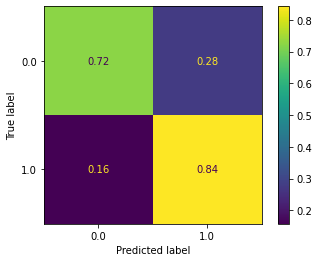

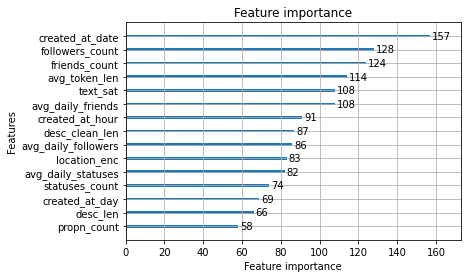

In [36]:
eval_clf(clf_tweets_median, df_test_tweets_median)

# Detection on tweets metadata (but not users')

In [37]:
def filter_tweet_metadata(df: pd.DataFrame):
    return df.drop([ 'followers_count', 'friends_count', 'statuses_count',
                     'location_enc', 'created_at_date', 'created_at_year',
                     'created_at_month', 'created_at_day', 'created_at_hour', 
                     'avg_daily_followers', 'avg_daily_friends', 'avg_daily_statuses'], axis=1)

In [38]:
df_train_meta_tweet = filter_tweet_metadata(df_train_meta)
df_test_meta_tweet = filter_tweet_metadata(df_test_meta)

In [39]:
clf_meta_tweet = get_best_clf(df_train_meta_tweet)

[I 2022-03-29 16:52:31,128] A new study created in memory with name: no-name-a4b479ac-33fe-4753-a8ee-10b601468d49


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.654116


[I 2022-03-29 16:53:19,180] Trial 3 finished with value: 0.6001594356739892 and parameters: {'lambda_l1': 0.0004932403583974768, 'lambda_l2': 0.5910247123728206, 'num_leaves': 59, 'feature_fraction': 0.5644698940897132, 'bagging_fraction': 0.8502916408043624, 'bagging_freq': 1, 'learning_rate': 0.16322216165073714, 'min_child_samples': 23}. Best is trial 3 with value: 0.6001594356739892.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.641885


[I 2022-03-29 16:53:21,869] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 7.19148973946593e-06, 'lambda_l2': 1.9266823962957862e-06, 'num_leaves': 68, 'feature_fraction': 0.5078567136895568, 'bagging_fraction': 0.9176560429735873, 'bagging_freq': 2, 'learning_rate': 1.766323141848178e-05, 'min_child_samples': 30}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654211


[I 2022-03-29 16:53:31,633] Trial 2 finished with value: 0.5996684425733654 and parameters: {'lambda_l1': 0.8922268054585176, 'lambda_l2': 0.001385375820927416, 'num_leaves': 101, 'feature_fraction': 0.9174402723610698, 'bagging_fraction': 0.716187268299902, 'bagging_freq': 3, 'learning_rate': 0.046581406042421884, 'min_child_samples': 41}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.630206


[I 2022-03-29 16:53:50,543] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 1.6415816565406497e-06, 'lambda_l2': 1.7353323143384477e-08, 'num_leaves': 19, 'feature_fraction': 0.43893207228041664, 'bagging_fraction': 0.84039802212308, 'bagging_freq': 5, 'learning_rate': 1.3100166429202278e-05, 'min_child_samples': 62}. Best is trial 3 with value: 0.6001594356739892.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.635065
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:53:55,630] Trial 10 finished with value: 0.5087790991034633 and parameters: {'lambda_l1': 1.339422123050819e-08, 'lambda_l2': 2.6982018873542226, 'num_leaves': 16, 'feature_fraction': 0.8783912888314499, 'bagging_fraction': 0.6524376740577207, 'bagging_freq': 6, 'learning_rate': 0.0019178539117405656, 'min_child_samples': 65}. Best is trial 3 with value: 0.6001594356739892.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.649667
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:53:59,768] Trial 6 finished with value: 0.5846925862193736 and parameters: {'lambda_l1': 0.00936971816211063, 'lambda_l2': 0.009372097399302353, 'num_leaves': 144, 'feature_fraction': 0.9619896548634705, 'bagging_fraction': 0.8583163961533047, 'bagging_freq': 7, 'learning_rate': 0.00517826474551933, 'min_child_samples': 23}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.644554


[I 2022-03-29 16:54:15,358] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 1.0265565432734474e-08, 'lambda_l2': 2.0617108562675446, 'num_leaves': 181, 'feature_fraction': 0.5349899270182662, 'bagging_fraction': 0.8131815983738704, 'bagging_freq': 3, 'learning_rate': 5.2176754491230726e-05, 'min_child_samples': 24}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.651865
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.650363


[I 2022-03-29 16:54:25,970] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 4.669941376458214e-08, 'lambda_l2': 0.0002640509971329117, 'num_leaves': 219, 'feature_fraction': 0.9268959281594529, 'bagging_fraction': 0.6526215553948991, 'bagging_freq': 3, 'learning_rate': 3.344769628720717e-05, 'min_child_samples': 77}. Best is trial 3 with value: 0.6001594356739892.
[I 2022-03-29 16:54:27,578] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 0.04436087660576701, 'lambda_l2': 5.4157360934855615e-08, 'num_leaves': 173, 'feature_fraction': 0.7764432665107142, 'bagging_fraction': 0.6178064237435386, 'bagging_freq': 1, 'learning_rate': 0.00017676846691118344, 'min_child_samples': 70}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.636321


[I 2022-03-29 16:54:37,458] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 1.7592667222232604e-05, 'lambda_l2': 7.47995482530875e-05, 'num_leaves': 251, 'feature_fraction': 0.44735365954957784, 'bagging_fraction': 0.46065951716161985, 'bagging_freq': 4, 'learning_rate': 6.33810495465512e-05, 'min_child_samples': 16}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.630704


[I 2022-03-29 16:54:46,381] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 3.0399792600410977e-07, 'lambda_l2': 0.7546590919033502, 'num_leaves': 11, 'feature_fraction': 0.7237676499116514, 'bagging_fraction': 0.8789562322635953, 'bagging_freq': 1, 'learning_rate': 2.5089906222691774e-05, 'min_child_samples': 8}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.650637
Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.646789


[I 2022-03-29 16:55:02,096] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 4.172428864829915e-05, 'lambda_l2': 0.003154874599798319, 'num_leaves': 183, 'feature_fraction': 0.7251845994905552, 'bagging_fraction': 0.6378115329278824, 'bagging_freq': 3, 'learning_rate': 1.1515472030321738e-05, 'min_child_samples': 67}. Best is trial 3 with value: 0.6001594356739892.
[I 2022-03-29 16:55:03,541] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 1.167715754776286e-08, 'lambda_l2': 2.1141490057311144e-05, 'num_leaves': 107, 'feature_fraction': 0.6662873649519634, 'bagging_fraction': 0.41378021415650135, 'bagging_freq': 7, 'learning_rate': 0.0005176527373790033, 'min_child_samples': 12}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.646691


[I 2022-03-29 16:55:17,293] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 8.247656338453921e-08, 'lambda_l2': 0.0037426919336567637, 'num_leaves': 67, 'feature_fraction': 0.8154387795685554, 'bagging_fraction': 0.6943998262462281, 'bagging_freq': 5, 'learning_rate': 0.0007940713000479235, 'min_child_samples': 64}. Best is trial 3 with value: 0.6001594356739892.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.650945


[I 2022-03-29 16:55:20,649] Trial 12 finished with value: 0.5769755149886217 and parameters: {'lambda_l1': 0.07460759527427935, 'lambda_l2': 0.0038158258022815347, 'num_leaves': 150, 'feature_fraction': 0.893163723973591, 'bagging_fraction': 0.8443168845944861, 'bagging_freq': 6, 'learning_rate': 0.0044145127617537805, 'min_child_samples': 93}. Best is trial 3 with value: 0.6001594356739892.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.655283


[I 2022-03-29 16:55:24,319] Trial 17 finished with value: 0.6011462488651653 and parameters: {'lambda_l1': 0.0010354344655165426, 'lambda_l2': 0.07210353507972937, 'num_leaves': 66, 'feature_fraction': 0.6376132892794538, 'bagging_fraction': 0.9875868472001785, 'bagging_freq': 1, 'learning_rate': 0.27442008311593347, 'min_child_samples': 94}. Best is trial 17 with value: 0.6011462488651653.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.654963


[I 2022-03-29 16:55:49,228] Trial 18 finished with value: 0.6013923614144693 and parameters: {'lambda_l1': 7.951917623002802, 'lambda_l2': 0.017805132681013844, 'num_leaves': 90, 'feature_fraction': 0.5988984136998288, 'bagging_fraction': 0.9955943278465769, 'bagging_freq': 2, 'learning_rate': 0.28928070494883174, 'min_child_samples': 43}. Best is trial 18 with value: 0.6013923614144693.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.644606


[I 2022-03-29 16:55:54,225] Trial 11 finished with value: 0.5 and parameters: {'lambda_l1': 0.0005091894819768746, 'lambda_l2': 1.1602993641734145e-08, 'num_leaves': 218, 'feature_fraction': 0.5250575475978082, 'bagging_fraction': 0.807350602059959, 'bagging_freq': 5, 'learning_rate': 0.0001477922932018159, 'min_child_samples': 84}. Best is trial 18 with value: 0.6013923614144693.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654687


[I 2022-03-29 16:55:59,416] Trial 20 finished with value: 0.6014005722033067 and parameters: {'lambda_l1': 6.126967223625246, 'lambda_l2': 0.017076498132808603, 'num_leaves': 71, 'feature_fraction': 0.6108808648302663, 'bagging_fraction': 0.7515180671519888, 'bagging_freq': 2, 'learning_rate': 0.21703744157514096, 'min_child_samples': 42}. Best is trial 20 with value: 0.6014005722033067.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.65487


[I 2022-03-29 16:56:09,576] Trial 19 finished with value: 0.6014663870830748 and parameters: {'lambda_l1': 5.560217490602715, 'lambda_l2': 0.05963998994628218, 'num_leaves': 84, 'feature_fraction': 0.5672790096565042, 'bagging_fraction': 0.9995317446796554, 'bagging_freq': 2, 'learning_rate': 0.18011085563179124, 'min_child_samples': 42}. Best is trial 19 with value: 0.6014663870830748.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.651764
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.654611


[I 2022-03-29 16:56:12,538] Trial 14 finished with value: 0.5061325000770531 and parameters: {'lambda_l1': 0.010513319149979487, 'lambda_l2': 0.0028037440897319904, 'num_leaves': 194, 'feature_fraction': 0.8584672006794956, 'bagging_fraction': 0.981407551027469, 'bagging_freq': 2, 'learning_rate': 0.0012263905499009717, 'min_child_samples': 19}. Best is trial 19 with value: 0.6014663870830748.
[I 2022-03-29 16:56:14,859] Trial 23 finished with value: 0.6008345923191534 and parameters: {'lambda_l1': 0.0007963300327084674, 'lambda_l2': 0.12211173684607236, 'num_leaves': 57, 'feature_fraction': 0.6138663423593776, 'bagging_fraction': 0.9867973619162028, 'bagging_freq': 1, 'learning_rate': 0.2533949954997017, 'min_child_samples': 97}. Best is trial 19 with value: 0.6014663870830748.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.655307


[I 2022-03-29 16:56:28,350] Trial 21 finished with value: 0.6020941338646514 and parameters: {'lambda_l1': 3.4338337547276736, 'lambda_l2': 0.041844981107834286, 'num_leaves': 88, 'feature_fraction': 0.6418011549508097, 'bagging_fraction': 0.734945149860189, 'bagging_freq': 2, 'learning_rate': 0.18857127996155507, 'min_child_samples': 41}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.655739


[I 2022-03-29 16:56:33,200] Trial 22 finished with value: 0.6016482871170284 and parameters: {'lambda_l1': 1.655842673624569, 'lambda_l2': 0.17114465938554801, 'num_leaves': 94, 'feature_fraction': 0.6235962402107948, 'bagging_fraction': 0.7665140078759435, 'bagging_freq': 2, 'learning_rate': 0.2193053143221568, 'min_child_samples': 39}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.65605


[I 2022-03-29 16:56:59,373] Trial 24 finished with value: 0.6020596913821513 and parameters: {'lambda_l1': 1.3552364062943039, 'lambda_l2': 0.15587876055005473, 'num_leaves': 102, 'feature_fraction': 0.6255354439956359, 'bagging_fraction': 0.9991028136472389, 'bagging_freq': 2, 'learning_rate': 0.25301308799667677, 'min_child_samples': 47}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.655771


[I 2022-03-29 16:57:08,187] Trial 25 finished with value: 0.6017860233282137 and parameters: {'lambda_l1': 7.256681241914746, 'lambda_l2': 0.05905789273540978, 'num_leaves': 105, 'feature_fraction': 0.6120616636669249, 'bagging_fraction': 0.993830556457622, 'bagging_freq': 2, 'learning_rate': 0.2666900671677163, 'min_child_samples': 41}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.651004


[I 2022-03-29 16:57:16,106] Trial 26 finished with value: 0.5981803380149473 and parameters: {'lambda_l1': 8.904649181843727, 'lambda_l2': 0.05850151149827154, 'num_leaves': 106, 'feature_fraction': 0.6074367903040155, 'bagging_fraction': 0.9917334554301063, 'bagging_freq': 2, 'learning_rate': 0.03548966912498393, 'min_child_samples': 47}. Best is trial 21 with value: 0.6020941338646514.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.651603


[I 2022-03-29 16:57:19,305] Trial 29 finished with value: 0.598457418953489 and parameters: {'lambda_l1': 8.993238145874402, 'lambda_l2': 0.05763385920651069, 'num_leaves': 102, 'feature_fraction': 0.5958872647465348, 'bagging_fraction': 0.5442629869321457, 'bagging_freq': 2, 'learning_rate': 0.0485426279918959, 'min_child_samples': 48}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.652517
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:57:23,916] Trial 28 finished with value: 0.5993257640998444 and parameters: {'lambda_l1': 9.238389057872231, 'lambda_l2': 0.05936481032993022, 'num_leaves': 103, 'feature_fraction': 0.6008339911051981, 'bagging_fraction': 0.9355405858220569, 'bagging_freq': 2, 'learning_rate': 0.052029070734537004, 'min_child_samples': 48}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.650959


[I 2022-03-29 16:57:32,541] Trial 27 finished with value: 0.596390754278453 and parameters: {'lambda_l1': 8.055368634533545, 'lambda_l2': 0.07214520315748088, 'num_leaves': 122, 'feature_fraction': 0.6173098475559748, 'bagging_fraction': 0.5219266884233827, 'bagging_freq': 2, 'learning_rate': 0.022819070205867834, 'min_child_samples': 52}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.653338


[I 2022-03-29 16:57:44,099] Trial 30 finished with value: 0.5991049527336081 and parameters: {'lambda_l1': 8.33972677327417, 'lambda_l2': 0.08237296914777434, 'num_leaves': 122, 'feature_fraction': 0.6677007906619442, 'bagging_fraction': 0.5249431904145527, 'bagging_freq': 2, 'learning_rate': 0.04832714606389789, 'min_child_samples': 50}. Best is trial 21 with value: 0.6020941338646514.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.653582


[I 2022-03-29 16:57:47,518] Trial 31 finished with value: 0.6000015650317697 and parameters: {'lambda_l1': 0.6355341790880747, 'lambda_l2': 0.1475536108552742, 'num_leaves': 120, 'feature_fraction': 0.6896277098434472, 'bagging_fraction': 0.5278947982480638, 'bagging_freq': 4, 'learning_rate': 0.04092820837434157, 'min_child_samples': 51}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.637125


[I 2022-03-29 16:58:11,764] Trial 37 finished with value: 0.5778617127546022 and parameters: {'lambda_l1': 0.4053781583170652, 'lambda_l2': 7.125380860931226, 'num_leaves': 38, 'feature_fraction': 0.48474067011322497, 'bagging_fraction': 0.9208031064153519, 'bagging_freq': 4, 'learning_rate': 0.012743129416501565, 'min_child_samples': 34}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.65368


[I 2022-03-29 16:58:21,189] Trial 32 finished with value: 0.5994822741750108 and parameters: {'lambda_l1': 0.3413093246236887, 'lambda_l2': 8.735463243345583, 'num_leaves': 121, 'feature_fraction': 0.6785680278730353, 'bagging_fraction': 0.5598801013376113, 'bagging_freq': 4, 'learning_rate': 0.04411537348935023, 'min_child_samples': 52}. Best is trial 21 with value: 0.6020941338646514.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.648323


[I 2022-03-29 16:58:24,075] Trial 39 finished with value: 0.5975204276794497 and parameters: {'lambda_l1': 0.7319807012826687, 'lambda_l2': 5.4727685251037865, 'num_leaves': 33, 'feature_fraction': 0.47877784054424244, 'bagging_fraction': 0.9130210717262448, 'bagging_freq': 3, 'learning_rate': 0.09813833279709472, 'min_child_samples': 34}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.648231


[I 2022-03-29 16:58:29,234] Trial 38 finished with value: 0.5981559475230185 and parameters: {'lambda_l1': 0.7753542144926219, 'lambda_l2': 8.245446243474944, 'num_leaves': 44, 'feature_fraction': 0.47908022791252214, 'bagging_fraction': 0.9055915205894283, 'bagging_freq': 4, 'learning_rate': 0.08566002766702474, 'min_child_samples': 34}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654986


[I 2022-03-29 16:58:40,980] Trial 34 finished with value: 0.6010929116200019 and parameters: {'lambda_l1': 0.4608261815181557, 'lambda_l2': 6.46852683170731, 'num_leaves': 124, 'feature_fraction': 0.6850097720870745, 'bagging_fraction': 0.92269409935136, 'bagging_freq': 4, 'learning_rate': 0.06371143219499482, 'min_child_samples': 53}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.641242


[I 2022-03-29 16:58:48,115] Trial 36 finished with value: 0.5850289364177743 and parameters: {'lambda_l1': 0.3898302716318512, 'lambda_l2': 3.2251514492045796e-06, 'num_leaves': 125, 'feature_fraction': 0.4837387557458803, 'bagging_fraction': 0.9134670560552828, 'bagging_freq': 4, 'learning_rate': 0.016966574154330526, 'min_child_samples': 32}. Best is trial 21 with value: 0.6020941338646514.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.651402
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654149


[I 2022-03-29 16:58:51,580] Trial 35 finished with value: 0.5951419104517023 and parameters: {'lambda_l1': 0.3810944896734611, 'lambda_l2': 9.466399002794947, 'num_leaves': 131, 'feature_fraction': 0.6808534859884393, 'bagging_fraction': 0.920110052885285, 'bagging_freq': 4, 'learning_rate': 0.019890839935405337, 'min_child_samples': 54}. Best is trial 21 with value: 0.6020941338646514.
[I 2022-03-29 16:58:53,354] Trial 33 finished with value: 0.5996710642240981 and parameters: {'lambda_l1': 0.35818660921924406, 'lambda_l2': 6.962048355865379, 'num_leaves': 128, 'feature_fraction': 0.6740347446046422, 'bagging_fraction': 0.9184093500572826, 'bagging_freq': 4, 'learning_rate': 0.04527213826980404, 'min_child_samples': 53}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.656237


[I 2022-03-29 16:59:26,961] Trial 40 finished with value: 0.6020380938634227 and parameters: {'lambda_l1': 1.2057535433117514, 'lambda_l2': 0.9897040495551764, 'num_leaves': 140, 'feature_fraction': 0.7631640574086668, 'bagging_fraction': 0.7832656904757596, 'bagging_freq': 3, 'learning_rate': 0.08924083745235684, 'min_child_samples': 32}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.656288


[I 2022-03-29 16:59:35,915] Trial 41 finished with value: 0.6020067841934462 and parameters: {'lambda_l1': 1.4497710101650514, 'lambda_l2': 0.49776576737917283, 'num_leaves': 143, 'feature_fraction': 0.7588009136238071, 'bagging_fraction': 0.7773347289803918, 'bagging_freq': 3, 'learning_rate': 0.09057485533773718, 'min_child_samples': 33}. Best is trial 21 with value: 0.6020941338646514.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654657


[I 2022-03-29 16:59:39,177] Trial 46 finished with value: 0.6002730307837787 and parameters: {'lambda_l1': 0.04751587131167174, 'lambda_l2': 0.47871301416346623, 'num_leaves': 82, 'feature_fraction': 0.5519156461351373, 'bagging_fraction': 0.7622650521372368, 'bagging_freq': 3, 'learning_rate': 0.1342110975603921, 'min_child_samples': 58}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654799


[I 2022-03-29 16:59:42,470] Trial 47 finished with value: 0.6007465723127589 and parameters: {'lambda_l1': 1.9119760688783036, 'lambda_l2': 0.5870767611970203, 'num_leaves': 84, 'feature_fraction': 0.5483795577093309, 'bagging_fraction': 0.7723741272644985, 'bagging_freq': 3, 'learning_rate': 0.13336540847679412, 'min_child_samples': 28}. Best is trial 21 with value: 0.6020941338646514.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.655558
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:59:44,791] Trial 42 finished with value: 0.6014203393051744 and parameters: {'lambda_l1': 1.4830240624339475, 'lambda_l2': 0.5918240835078928, 'num_leaves': 145, 'feature_fraction': 0.555378635470441, 'bagging_fraction': 0.7816057538379878, 'bagging_freq': 3, 'learning_rate': 0.12269631522560653, 'min_child_samples': 30}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.65536
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 16:59:49,056] Trial 43 finished with value: 0.6010579273713819 and parameters: {'lambda_l1': 0.12084228892092505, 'lambda_l2': 0.7994960100372472, 'num_leaves': 141, 'feature_fraction': 0.5551891797719948, 'bagging_fraction': 0.7716787023095053, 'bagging_freq': 3, 'learning_rate': 0.11432357412287739, 'min_child_samples': 29}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.655465


[I 2022-03-29 16:59:58,622] Trial 44 finished with value: 0.6010979100096165 and parameters: {'lambda_l1': 0.07193173182876046, 'lambda_l2': 0.35156192422692356, 'num_leaves': 144, 'feature_fraction': 0.5620674036597645, 'bagging_fraction': 0.7884158160998105, 'bagging_freq': 3, 'learning_rate': 0.12424554290983875, 'min_child_samples': 32}. Best is trial 21 with value: 0.6020941338646514.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.656273


[I 2022-03-29 17:00:04,142] Trial 45 finished with value: 0.6023780558359568 and parameters: {'lambda_l1': 0.09652580380175073, 'lambda_l2': 0.7206901266824409, 'num_leaves': 152, 'feature_fraction': 0.7604297473535445, 'bagging_fraction': 0.7816455800934922, 'bagging_freq': 3, 'learning_rate': 0.11880916549322416, 'min_child_samples': 58}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.656334


[I 2022-03-29 17:00:39,301] Trial 48 finished with value: 0.6022328801731309 and parameters: {'lambda_l1': 2.576446467212153, 'lambda_l2': 0.5154584602536, 'num_leaves': 152, 'feature_fraction': 0.779449296408387, 'bagging_fraction': 0.7710416195280747, 'bagging_freq': 3, 'learning_rate': 0.11443774684463029, 'min_child_samples': 28}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.656469


[I 2022-03-29 17:00:49,322] Trial 50 finished with value: 0.6023460054331126 and parameters: {'lambda_l1': 2.106946989317476, 'lambda_l2': 0.3440556238769669, 'num_leaves': 150, 'feature_fraction': 0.7472440702533334, 'bagging_fraction': 0.696804384065673, 'bagging_freq': 3, 'learning_rate': 0.10518937946003934, 'min_child_samples': 27}. Best is trial 45 with value: 0.6023780558359568.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.651133


[I 2022-03-29 17:00:53,415] Trial 52 finished with value: 0.58474645756027 and parameters: {'lambda_l1': 0.10514215870612477, 'lambda_l2': 0.00038993999197712924, 'num_leaves': 146, 'feature_fraction': 0.7514275139611947, 'bagging_fraction': 0.7007505036666357, 'bagging_freq': 1, 'learning_rate': 0.006628577332064019, 'min_child_samples': 26}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.656518


[I 2022-03-29 17:00:57,163] Trial 51 finished with value: 0.6022244306241962 and parameters: {'lambda_l1': 2.1575552723183566, 'lambda_l2': 0.00039307330248368667, 'num_leaves': 160, 'feature_fraction': 0.7589408328123685, 'bagging_fraction': 0.6983677027067504, 'bagging_freq': 3, 'learning_rate': 0.10346130288677925, 'min_child_samples': 28}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.651815
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.656569


[I 2022-03-29 17:01:03,671] Trial 53 finished with value: 0.5914389658678687 and parameters: {'lambda_l1': 0.007158396045853476, 'lambda_l2': 1.9930175959800636, 'num_leaves': 161, 'feature_fraction': 0.7654769041905616, 'bagging_fraction': 0.7062904793250397, 'bagging_freq': 1, 'learning_rate': 0.009202590202893593, 'min_child_samples': 39}. Best is trial 45 with value: 0.6023780558359568.
[I 2022-03-29 17:01:05,273] Trial 49 finished with value: 0.6018310717164743 and parameters: {'lambda_l1': 0.06658430840406887, 'lambda_l2': 0.9331304567076345, 'num_leaves': 159, 'feature_fraction': 0.7626771528048057, 'bagging_fraction': 0.6929752762157434, 'bagging_freq': 3, 'learning_rate': 0.10839989362790371, 'min_child_samples': 24}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.651507


[I 2022-03-29 17:01:14,459] Trial 54 finished with value: 0.584830555038903 and parameters: {'lambda_l1': 0.017432459936661017, 'lambda_l2': 0.000649127598699882, 'num_leaves': 162, 'feature_fraction': 0.7638490454337733, 'bagging_fraction': 0.6781246157866043, 'bagging_freq': 1, 'learning_rate': 0.006578894179847943, 'min_child_samples': 38}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.651644


[I 2022-03-29 17:01:22,536] Trial 55 finished with value: 0.5908152732203902 and parameters: {'lambda_l1': 0.014254266862956519, 'lambda_l2': 2.3915957694001877, 'num_leaves': 164, 'feature_fraction': 0.7929467043183056, 'bagging_fraction': 0.7263917812905337, 'bagging_freq': 3, 'learning_rate': 0.00839931853409244, 'min_child_samples': 74}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.651332


[I 2022-03-29 17:01:59,062] Trial 56 finished with value: 0.5870657161585939 and parameters: {'lambda_l1': 0.008643178926807134, 'lambda_l2': 1.8325673124564323, 'num_leaves': 162, 'feature_fraction': 0.7946170101989655, 'bagging_fraction': 0.7051604549979806, 'bagging_freq': 1, 'learning_rate': 0.007107623540520029, 'min_child_samples': 76}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.652147


[I 2022-03-29 17:02:07,436] Trial 57 finished with value: 0.5914407671990344 and parameters: {'lambda_l1': 0.008062862908312343, 'lambda_l2': 0.0006285958531423482, 'num_leaves': 161, 'feature_fraction': 0.8371369197166421, 'bagging_fraction': 0.7119188113675319, 'bagging_freq': 1, 'learning_rate': 0.008544005002270294, 'min_child_samples': 19}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.656105


[I 2022-03-29 17:02:14,304] Trial 59 finished with value: 0.6021925501024044 and parameters: {'lambda_l1': 0.010311874985793322, 'lambda_l2': 2.136120662591101, 'num_leaves': 160, 'feature_fraction': 0.7959881415731478, 'bagging_fraction': 0.7359044750415222, 'bagging_freq': 3, 'learning_rate': 0.06623674976499291, 'min_child_samples': 20}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.65612


[I 2022-03-29 17:02:27,117] Trial 60 finished with value: 0.6019814019050458 and parameters: {'lambda_l1': 2.7366161372252784, 'lambda_l2': 1.9935355334797608e-07, 'num_leaves': 166, 'feature_fraction': 0.8011842536176665, 'bagging_fraction': 0.7275642042463646, 'bagging_freq': 3, 'learning_rate': 0.06879583702200041, 'min_child_samples': 20}. Best is trial 45 with value: 0.6023780558359568.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.656267


[I 2022-03-29 17:02:31,716] Trial 58 finished with value: 0.6021809953080077 and parameters: {'lambda_l1': 0.015279078857079749, 'lambda_l2': 2.0776685604043528, 'num_leaves': 164, 'feature_fraction': 0.8024375063801968, 'bagging_fraction': 0.7315865528299613, 'bagging_freq': 3, 'learning_rate': 0.07613527995881615, 'min_child_samples': 19}. Best is trial 45 with value: 0.6023780558359568.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.65454


[I 2022-03-29 17:02:40,199] Trial 61 finished with value: 0.5990949130465435 and parameters: {'lambda_l1': 2.729684057740795, 'lambda_l2': 0.0008037755676310646, 'num_leaves': 187, 'feature_fraction': 0.8319212048243569, 'bagging_fraction': 0.7334662270850838, 'bagging_freq': 3, 'learning_rate': 0.02792764518253634, 'min_child_samples': 19}. Best is trial 45 with value: 0.6023780558359568.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.656201


[I 2022-03-29 17:02:44,417] Trial 62 finished with value: 0.6026267502426438 and parameters: {'lambda_l1': 3.207889046673254, 'lambda_l2': 8.965306273586665e-05, 'num_leaves': 186, 'feature_fraction': 0.8071254661739347, 'bagging_fraction': 0.7337656246692797, 'bagging_freq': 3, 'learning_rate': 0.1889995933659931, 'min_child_samples': 72}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654901


[I 2022-03-29 17:03:00,116] Trial 63 finished with value: 0.5996963776334536 and parameters: {'lambda_l1': 3.1231291348751444, 'lambda_l2': 8.435147923676086e-05, 'num_leaves': 199, 'feature_fraction': 0.8383051304960125, 'bagging_fraction': 0.7336352442349092, 'bagging_freq': 5, 'learning_rate': 0.028935927651512677, 'min_child_samples': 20}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.653535


[I 2022-03-29 17:03:29,222] Trial 64 finished with value: 0.5989679817078664 and parameters: {'lambda_l1': 3.1619703951365197, 'lambda_l2': 8.362965128341986e-05, 'num_leaves': 191, 'feature_fraction': 0.7191965960459744, 'bagging_fraction': 0.610416638038176, 'bagging_freq': 3, 'learning_rate': 0.02925446049873299, 'min_child_samples': 58}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.648407


[I 2022-03-29 17:03:38,302] Trial 65 finished with value: 0.5 and parameters: {'lambda_l1': 2.835946921718118, 'lambda_l2': 0.00010618161260132482, 'num_leaves': 195, 'feature_fraction': 0.7210062602065576, 'bagging_fraction': 0.5995361225576019, 'bagging_freq': 3, 'learning_rate': 0.0028093387929426315, 'min_child_samples': 58}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.653671


[I 2022-03-29 17:03:48,229] Trial 66 finished with value: 0.5988195936458177 and parameters: {'lambda_l1': 3.0441313760588553, 'lambda_l2': 5.748079285211205e-05, 'num_leaves': 193, 'feature_fraction': 0.7205706533835081, 'bagging_fraction': 0.7376732694664988, 'bagging_freq': 5, 'learning_rate': 0.027732009457650454, 'min_child_samples': 10}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.653941


[I 2022-03-29 17:03:55,773] Trial 68 finished with value: 0.5990083745058845 and parameters: {'lambda_l1': 0.003992398497844839, 'lambda_l2': 8.13604077333713e-05, 'num_leaves': 184, 'feature_fraction': 0.7208663079081162, 'bagging_fraction': 0.8203269681328161, 'bagging_freq': 5, 'learning_rate': 0.02776734248490887, 'min_child_samples': 13}. Best is trial 62 with value: 0.6026267502426438.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.654039


[I 2022-03-29 17:04:00,085] Trial 67 finished with value: 0.5990932418030807 and parameters: {'lambda_l1': 0.00013076930658239555, 'lambda_l2': 7.846873915233172e-05, 'num_leaves': 190, 'feature_fraction': 0.7221262941213187, 'bagging_fraction': 0.8215028813949581, 'bagging_freq': 3, 'learning_rate': 0.028008517682327847, 'min_child_samples': 10}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.656764


[I 2022-03-29 17:04:10,435] Trial 70 finished with value: 0.6020727781432874 and parameters: {'lambda_l1': 0.0018724243417835302, 'lambda_l2': 5.293215362664279e-05, 'num_leaves': 200, 'feature_fraction': 0.7194941885898736, 'bagging_fraction': 0.810676248187709, 'bagging_freq': 5, 'learning_rate': 0.1695070309058646, 'min_child_samples': 9}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.656555


[I 2022-03-29 17:04:18,590] Trial 69 finished with value: 0.602214487383238 and parameters: {'lambda_l1': 0.00015383821285382522, 'lambda_l2': 5.926202434637756e-05, 'num_leaves': 201, 'feature_fraction': 0.7210643806833861, 'bagging_fraction': 0.8180512958496122, 'bagging_freq': 3, 'learning_rate': 0.1822160833332518, 'min_child_samples': 9}. Best is trial 62 with value: 0.6026267502426438.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.657096


[I 2022-03-29 17:04:25,554] Trial 71 finished with value: 0.6030042032903828 and parameters: {'lambda_l1': 0.002723171699993043, 'lambda_l2': 7.959312207326879e-05, 'num_leaves': 215, 'feature_fraction': 0.7227766823731273, 'bagging_fraction': 0.8137291202846441, 'bagging_freq': 3, 'learning_rate': 0.1666136342166966, 'min_child_samples': 12}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.65635


[I 2022-03-29 17:04:40,922] Trial 72 finished with value: 0.6022785009318404 and parameters: {'lambda_l1': 0.17479287361097406, 'lambda_l2': 6.17998432681016e-06, 'num_leaves': 176, 'feature_fraction': 0.7381143782320545, 'bagging_fraction': 0.6642041098252265, 'bagging_freq': 3, 'learning_rate': 0.1805022137088545, 'min_child_samples': 12}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.657262


[I 2022-03-29 17:04:49,044] Trial 73 finished with value: 0.6027664209099649 and parameters: {'lambda_l1': 0.00016030568982021827, 'lambda_l2': 1.7251836029654815e-05, 'num_leaves': 175, 'feature_fraction': 0.9345675341011788, 'bagging_fraction': 0.8159693686858721, 'bagging_freq': 4, 'learning_rate': 0.15706304023006268, 'min_child_samples': 12}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.657152


[I 2022-03-29 17:04:59,050] Trial 74 finished with value: 0.6026201938378617 and parameters: {'lambda_l1': 0.002072271214134974, 'lambda_l2': 4.450655943409449e-06, 'num_leaves': 177, 'feature_fraction': 0.9516813153655223, 'bagging_fraction': 0.8155798735299157, 'bagging_freq': 3, 'learning_rate': 0.1643966580038073, 'min_child_samples': 14}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.656455


[I 2022-03-29 17:05:08,287] Trial 76 finished with value: 0.6026399502320752 and parameters: {'lambda_l1': 0.17548900294334258, 'lambda_l2': 1.1833094487867678e-05, 'num_leaves': 175, 'feature_fraction': 0.8814840385623044, 'bagging_fraction': 0.6595562473030199, 'bagging_freq': 4, 'learning_rate': 0.1835418977864788, 'min_child_samples': 5}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.656358


[I 2022-03-29 17:05:22,379] Trial 75 finished with value: 0.6026815123007856 and parameters: {'lambda_l1': 0.026005176499536146, 'lambda_l2': 1.385283701239981e-05, 'num_leaves': 212, 'feature_fraction': 0.8869116473951875, 'bagging_fraction': 0.6651341971973631, 'bagging_freq': 3, 'learning_rate': 0.16023908688485106, 'min_child_samples': 82}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.651062


[I 2022-03-29 17:05:28,120] Trial 77 finished with value: 0.5 and parameters: {'lambda_l1': 0.20437198130039919, 'lambda_l2': 1.0994385784226098e-05, 'num_leaves': 178, 'feature_fraction': 0.9036735855772735, 'bagging_fraction': 0.6740834198460691, 'bagging_freq': 4, 'learning_rate': 0.0003461212008916798, 'min_child_samples': 90}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.655821


[I 2022-03-29 17:05:35,177] Trial 78 finished with value: 0.6020549148932266 and parameters: {'lambda_l1': 0.00010879247553089179, 'lambda_l2': 1.4740889720039567e-05, 'num_leaves': 174, 'feature_fraction': 0.7450839538357451, 'bagging_fraction': 0.6664340016829767, 'bagging_freq': 3, 'learning_rate': 0.06656328604317453, 'min_child_samples': 83}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.656534


[I 2022-03-29 17:05:55,642] Trial 81 finished with value: 0.6023925352871087 and parameters: {'lambda_l1': 6.994680685026122e-06, 'lambda_l2': 1.0694762287307498e-05, 'num_leaves': 174, 'feature_fraction': 0.9077415582367845, 'bagging_fraction': 0.6454182325713227, 'bagging_freq': 4, 'learning_rate': 0.15687026239210317, 'min_child_samples': 5}. Best is trial 71 with value: 0.6030042032903828.


Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.656918
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:05:59,719] Trial 79 finished with value: 0.6023259199844484 and parameters: {'lambda_l1': 0.00017819910321645945, 'lambda_l2': 1.682363283355632e-05, 'num_leaves': 211, 'feature_fraction': 0.7409618974579905, 'bagging_fraction': 0.8575806334998465, 'bagging_freq': 3, 'learning_rate': 0.1674883167401364, 'min_child_samples': 16}. Best is trial 71 with value: 0.6030042032903828.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.656118


[I 2022-03-29 17:06:04,032] Trial 80 finished with value: 0.6020031402191315 and parameters: {'lambda_l1': 8.82703219307537e-06, 'lambda_l2': 1.0280969220773995e-05, 'num_leaves': 213, 'feature_fraction': 0.7422857848210616, 'bagging_fraction': 0.669206105009003, 'bagging_freq': 4, 'learning_rate': 0.18147792573759836, 'min_child_samples': 6}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.657154


[I 2022-03-29 17:06:07,544] Trial 82 finished with value: 0.6018530197049622 and parameters: {'lambda_l1': 8.358734989194153e-06, 'lambda_l2': 7.1455719219982325e-06, 'num_leaves': 175, 'feature_fraction': 0.9681921579623863, 'bagging_fraction': 0.8629337229024211, 'bagging_freq': 4, 'learning_rate': 0.16346167403687345, 'min_child_samples': 15}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.656622


[I 2022-03-29 17:06:13,222] Trial 83 finished with value: 0.6027450514436794 and parameters: {'lambda_l1': 0.18966522785078133, 'lambda_l2': 1.0627402797700735e-05, 'num_leaves': 176, 'feature_fraction': 0.9808075470845489, 'bagging_fraction': 0.8715923585287889, 'bagging_freq': 4, 'learning_rate': 0.29464321184291603, 'min_child_samples': 5}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.656706


[I 2022-03-29 17:06:34,437] Trial 84 finished with value: 0.6025169857704102 and parameters: {'lambda_l1': 0.0018979124552907336, 'lambda_l2': 1.603369169730118e-05, 'num_leaves': 224, 'feature_fraction': 0.9993062562431995, 'bagging_fraction': 0.8648114576923202, 'bagging_freq': 4, 'learning_rate': 0.290323742647545, 'min_child_samples': 5}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.655519


[I 2022-03-29 17:06:39,570] Trial 85 finished with value: 0.6019874165437078 and parameters: {'lambda_l1': 0.028855328313757103, 'lambda_l2': 1.4848796664672256e-06, 'num_leaves': 235, 'feature_fraction': 0.9521048696966741, 'bagging_fraction': 0.632557400368421, 'bagging_freq': 4, 'learning_rate': 0.2966055677220129, 'min_child_samples': 83}. Best is trial 71 with value: 0.6030042032903828.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.656818


[I 2022-03-29 17:06:43,380] Trial 86 finished with value: 0.6026530859755813 and parameters: {'lambda_l1': 7.090607555894278e-06, 'lambda_l2': 8.360926886323196e-07, 'num_leaves': 214, 'feature_fraction': 0.9536753149110245, 'bagging_fraction': 0.8625261754018335, 'bagging_freq': 4, 'learning_rate': 0.22741313451512712, 'min_child_samples': 6}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.656016


[I 2022-03-29 17:07:08,583] Trial 87 finished with value: 0.6019948085316118 and parameters: {'lambda_l1': 3.574262665449051e-06, 'lambda_l2': 7.747676305255106e-07, 'num_leaves': 228, 'feature_fraction': 0.957153532228698, 'bagging_fraction': 0.6461143504126137, 'bagging_freq': 4, 'learning_rate': 0.2299861652245651, 'min_child_samples': 6}. Best is trial 71 with value: 0.6030042032903828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.655881


[I 2022-03-29 17:07:17,991] Trial 89 finished with value: 0.6019447464129628 and parameters: {'lambda_l1': 2.4814598481558082e-06, 'lambda_l2': 6.251986317315313e-07, 'num_leaves': 232, 'feature_fraction': 0.9467631068320667, 'bagging_fraction': 0.6473140595278105, 'bagging_freq': 4, 'learning_rate': 0.28591337882197687, 'min_child_samples': 6}. Best is trial 71 with value: 0.6030042032903828.


Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.65707
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.655474


[I 2022-03-29 17:07:22,732] Trial 88 finished with value: 0.6033746729913676 and parameters: {'lambda_l1': 2.2098733434044965e-06, 'lambda_l2': 5.878618758265701e-07, 'num_leaves': 243, 'feature_fraction': 0.9539201192201836, 'bagging_fraction': 0.8375095714262327, 'bagging_freq': 4, 'learning_rate': 0.2435917132290277, 'min_child_samples': 7}. Best is trial 88 with value: 0.6033746729913676.


Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.655499


[I 2022-03-29 17:07:24,935] Trial 91 finished with value: 0.6030590572387304 and parameters: {'lambda_l1': 2.4928809739676663e-06, 'lambda_l2': 1.36903801081876e-06, 'num_leaves': 229, 'feature_fraction': 0.9366468684498968, 'bagging_fraction': 0.6317004987618022, 'bagging_freq': 4, 'learning_rate': 0.2927639856539705, 'min_child_samples': 71}. Best is trial 88 with value: 0.6033746729913676.
[I 2022-03-29 17:07:24,979] Trial 90 finished with value: 0.6021200870048673 and parameters: {'lambda_l1': 4.000161914625013e-05, 'lambda_l2': 1.5654840149327054e-06, 'num_leaves': 243, 'feature_fraction': 0.9460947926410661, 'bagging_fraction': 0.630225090235008, 'bagging_freq': 4, 'learning_rate': 0.296782596443424, 'min_child_samples': 6}. Best is trial 88 with value: 0.6033746729913676.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.655854


[I 2022-03-29 17:07:50,133] Trial 92 finished with value: 0.6021035445285101 and parameters: {'lambda_l1': 2.473786472679651e-06, 'lambda_l2': 1.3967477582397556e-06, 'num_leaves': 237, 'feature_fraction': 0.9923521364653888, 'bagging_fraction': 0.6361751471554865, 'bagging_freq': 4, 'learning_rate': 0.276856175555791, 'min_child_samples': 5}. Best is trial 88 with value: 0.6033746729913676.


Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.656678


[I 2022-03-29 17:07:53,520] Trial 93 finished with value: 0.6016114540735062 and parameters: {'lambda_l1': 7.48738255689209e-07, 'lambda_l2': 2.971468018657924e-05, 'num_leaves': 228, 'feature_fraction': 0.9954677011412933, 'bagging_fraction': 0.8884583119001024, 'bagging_freq': 4, 'learning_rate': 0.22835798557253703, 'min_child_samples': 5}. Best is trial 88 with value: 0.6033746729913676.


Did not meet early stopping. Best iteration is:
[64]	valid_0's auc: 0.657048


[I 2022-03-29 17:07:54,712] Trial 94 finished with value: 0.6028761011623798 and parameters: {'lambda_l1': 0.0018942404853406843, 'lambda_l2': 9.381276679057297e-07, 'num_leaves': 232, 'feature_fraction': 0.9933278552857685, 'bagging_fraction': 0.8843840892997715, 'bagging_freq': 4, 'learning_rate': 0.23036701809073987, 'min_child_samples': 7}. Best is trial 88 with value: 0.6033746729913676.


Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.656564


[I 2022-03-29 17:08:11,696] Trial 99 finished with value: 0.6022152985137843 and parameters: {'lambda_l1': 4.025875048736847e-07, 'lambda_l2': 2.9234904048575077e-05, 'num_leaves': 208, 'feature_fraction': 0.9279755997224566, 'bagging_fraction': 0.8844987102407503, 'bagging_freq': 4, 'learning_rate': 0.22557693711540155, 'min_child_samples': 67}. Best is trial 88 with value: 0.6033746729913676.


Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.657001


[I 2022-03-29 17:08:15,162] Trial 97 finished with value: 0.6029590355220735 and parameters: {'lambda_l1': 7.756398995688781e-07, 'lambda_l2': 3.1418138714458423e-06, 'num_leaves': 237, 'feature_fraction': 0.8820754295615133, 'bagging_fraction': 0.8911455998949076, 'bagging_freq': 6, 'learning_rate': 0.20722972992455993, 'min_child_samples': 14}. Best is trial 88 with value: 0.6033746729913676.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.652517
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.656875


[I 2022-03-29 17:08:17,310] Trial 95 finished with value: 0.5 and parameters: {'lambda_l1': 0.0018704797030257663, 'lambda_l2': 3.20295667514817e-05, 'num_leaves': 256, 'feature_fraction': 0.9328113883478834, 'bagging_fraction': 0.8746833788600137, 'bagging_freq': 4, 'learning_rate': 7.699341922723534e-05, 'min_child_samples': 69}. Best is trial 88 with value: 0.6033746729913676.
[I 2022-03-29 17:08:17,514] Trial 98 finished with value: 0.6023121919738186 and parameters: {'lambda_l1': 3.9693068308314543e-07, 'lambda_l2': 2.8467315889469903e-05, 'num_leaves': 254, 'feature_fraction': 0.9284538764765758, 'bagging_fraction': 0.8343250583993214, 'bagging_freq': 4, 'learning_rate': 0.22813648418679025, 'min_child_samples': 13}. Best is trial 88 with value: 0.6033746729913676.


Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.656851


[I 2022-03-29 17:08:19,051] Trial 96 finished with value: 0.6024749293993161 and parameters: {'lambda_l1': 0.0020471485338215893, 'lambda_l2': 2.755948991453038e-05, 'num_leaves': 244, 'feature_fraction': 0.9823410059878345, 'bagging_fraction': 0.8722605832594321, 'bagging_freq': 4, 'learning_rate': 0.2158429115966961, 'min_child_samples': 14}. Best is trial 88 with value: 0.6033746729913676.


{'lambda_l1': 2.2098733434044965e-06, 'lambda_l2': 5.878618758265701e-07, 'num_leaves': 243, 'feature_fraction': 0.9539201192201836, 'bagging_fraction': 0.8375095714262327, 'bagging_freq': 4, 'learning_rate': 0.2435917132290277, 'min_child_samples': 7} -> 0.6033746729913676
[LightGBM] [Warning] feature_fraction is set=0.9539201192201836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9539201192201836
[LightGBM] [Warning] lambda_l1 is set=2.2098733434044965e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2098733434044965e-06
[LightGBM] [Warning] bagging_fraction is set=0.8375095714262327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8375095714262327
[LightGBM] [Warning] lambda_l2 is set=5.878618758265701e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.878618758265701e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores do

AUROC: 0.5943280148490818
Accuracy: 0.5997458258907351


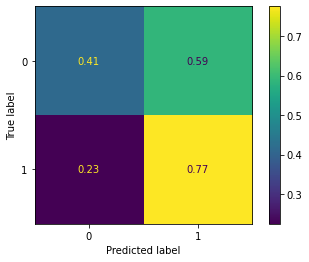

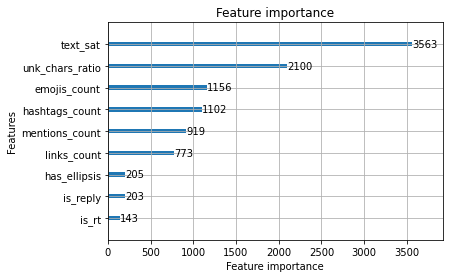

In [40]:
eval_clf(clf_meta_tweet, df_test_meta_tweet)

### Average probas at the user level

In [41]:
df_train_meta_agg_tweet, df_test_meta_agg_tweet = get_agg(clf_meta_tweet, 
                                                          df_train_meta_tweet, 
                                                          df_test_meta_tweet, 
                                                          df_train['id'], 
                                                          df_test['id'])
clf_meta_agg_tweet = get_best_clf(df_train_meta_agg_tweet)

[I 2022-03-29 17:08:36,692] A new study created in memory with name: no-name-bab2f2cd-f695-416e-bf51-715ed92f2eae


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:37,131] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 1.9255534843572205e-06, 'lambda_l2': 3.082179261909459e-08, 'num_leaves': 172, 'feature_fraction': 0.8145017756575026, 'bagging_fraction': 0.41331132635662043, 'bagging_freq': 7, 'learning_rate': 1.599176953934176e-05, 'min_child_samples': 92}. Best is trial 0 with value: 0.5.
[I 2022-03-29 17:08:37,210] Trial 2 finished with value: 0.7287363953240225 and parameters: {'lambda_l1': 1.5754228312329334e-07, 'lambda_l2': 3.668436590083907, 'num_leaves': 27, 'feature_fraction': 0.9330313901566533, 'bagging_fraction': 0.7801221058429226, 'bagging_freq': 7, 'learning_rate': 0.00788121797936562, 'min_child_samples': 94}. Best is trial 2 with value: 0.7287363953240225.


Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.832723
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.832863
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:37,461] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 0.010670123954128865, 'lambda_l2': 0.04577648452995584, 'num_leaves': 208, 'feature_fraction': 0.49366913857144173, 'bagging_fraction': 0.645419175398608, 'bagging_freq': 1, 'learning_rate': 7.771176976241245e-05, 'min_child_samples': 69}. Best is trial 2 with value: 0.7287363953240225.
[I 2022-03-29 17:08:37,570] Trial 4 finished with value: 0.748897398809665 and parameters: {'lambda_l1': 2.3887735788853925, 'lambda_l2': 0.0008525815342313814, 'num_leaves': 160, 'feature_fraction': 0.5462400451501364, 'bagging_fraction': 0.6173810384945265, 'bagging_freq': 1, 'learning_rate': 0.12223233498815436, 'min_child_samples': 40}. Best is trial 4 with value: 0.748897398809665.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.83435
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.833029
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.833929


[I 2022-03-29 17:08:37,649] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 9.426988875125323e-05, 'lambda_l2': 1.371048755496133e-08, 'num_leaves': 53, 'feature_fraction': 0.4497233002666301, 'bagging_fraction': 0.4044518896310791, 'bagging_freq': 7, 'learning_rate': 0.000887438078366144, 'min_child_samples': 19}. Best is trial 4 with value: 0.748897398809665.
[I 2022-03-29 17:08:37,681] Trial 5 finished with value: 0.7479726365209969 and parameters: {'lambda_l1': 2.125659562130499e-05, 'lambda_l2': 0.000125318649701969, 'num_leaves': 54, 'feature_fraction': 0.9178984321914847, 'bagging_fraction': 0.9019207435565221, 'bagging_freq': 3, 'learning_rate': 0.06602534963911, 'min_child_samples': 28}. Best is trial 4 with value: 0.748897398809665.


Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.832305
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:37,900] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 0.24060735238618253, 'lambda_l2': 1.1090883672255921e-05, 'num_leaves': 141, 'feature_fraction': 0.778264357708227, 'bagging_fraction': 0.8279323844022204, 'bagging_freq': 3, 'learning_rate': 6.394816111762328e-05, 'min_child_samples': 49}. Best is trial 4 with value: 0.748897398809665.
[I 2022-03-29 17:08:37,994] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 0.054949736182065625, 'lambda_l2': 2.6384894682165174e-06, 'num_leaves': 37, 'feature_fraction': 0.7542462306441506, 'bagging_fraction': 0.5653850979168277, 'bagging_freq': 5, 'learning_rate': 5.709718754927425e-05, 'min_child_samples': 12}. Best is trial 4 with value: 0.748897398809665.


Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.834625
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.834453
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:38,104] Trial 10 finished with value: 0.7438171341853793 and parameters: {'lambda_l1': 1.1757774995659023, 'lambda_l2': 1.9422705179354243e-06, 'num_leaves': 255, 'feature_fraction': 0.8681570158374283, 'bagging_fraction': 0.606508432850586, 'bagging_freq': 2, 'learning_rate': 0.02009918042109932, 'min_child_samples': 76}. Best is trial 4 with value: 0.748897398809665.
[I 2022-03-29 17:08:38,166] Trial 11 finished with value: 0.7414489128115146 and parameters: {'lambda_l1': 0.025868299268450873, 'lambda_l2': 0.9525927928258379, 'num_leaves': 26, 'feature_fraction': 0.9310715370290367, 'bagging_fraction': 0.6501196539432466, 'bagging_freq': 3, 'learning_rate': 0.029905339226537583, 'min_child_samples': 88}. Best is trial 4 with value: 0.748897398809665.


Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.835326
Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.833107
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:38,339] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 5.586641797551713e-08, 'lambda_l2': 7.520833652214214e-08, 'num_leaves': 246, 'feature_fraction': 0.48144840808274475, 'bagging_fraction': 0.9709203289304051, 'bagging_freq': 3, 'learning_rate': 1.8427464401765187e-05, 'min_child_samples': 51}. Best is trial 4 with value: 0.748897398809665.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.830636
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:38,558] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 1.5689563578996901, 'lambda_l2': 4.002551708601299e-05, 'num_leaves': 91, 'feature_fraction': 0.6725152852044, 'bagging_fraction': 0.5011862953028542, 'bagging_freq': 1, 'learning_rate': 4.082450360146445e-05, 'min_child_samples': 12}. Best is trial 4 with value: 0.748897398809665.
[I 2022-03-29 17:08:38,715] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 0.19223024684866452, 'lambda_l2': 4.0488956016645184e-06, 'num_leaves': 22, 'feature_fraction': 0.9553944311940956, 'bagging_fraction': 0.4912727300924538, 'bagging_freq': 1, 'learning_rate': 0.00010860315825784734, 'min_child_samples': 34}. Best is trial 4 with value: 0.748897398809665.


Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.832239
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.832969


[I 2022-03-29 17:08:38,825] Trial 17 finished with value: 0.751431603158419 and parameters: {'lambda_l1': 7.506516844376025, 'lambda_l2': 0.007206414152430754, 'num_leaves': 111, 'feature_fraction': 0.5968931476859483, 'bagging_fraction': 0.9973097641227835, 'bagging_freq': 1, 'learning_rate': 0.28416600465285463, 'min_child_samples': 44}. Best is trial 17 with value: 0.751431603158419.
[I 2022-03-29 17:08:38,982] Trial 14 finished with value: 0.7577093163872619 and parameters: {'lambda_l1': 0.8199245438015164, 'lambda_l2': 6.838193681106014e-07, 'num_leaves': 65, 'feature_fraction': 0.49445973361305673, 'bagging_fraction': 0.8312754505644948, 'bagging_freq': 6, 'learning_rate': 0.026079299034659508, 'min_child_samples': 74}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.833608
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.834854


[I 2022-03-29 17:08:39,202] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 0.0008647771000871669, 'lambda_l2': 3.0640484546768136e-08, 'num_leaves': 61, 'feature_fraction': 0.8868917278283583, 'bagging_fraction': 0.5104839550422442, 'bagging_freq': 2, 'learning_rate': 5.0454306970050855e-05, 'min_child_samples': 8}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.832395
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:39,641] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 0.008770412599417066, 'lambda_l2': 0.2933504515207128, 'num_leaves': 92, 'feature_fraction': 0.9878480852156085, 'bagging_fraction': 0.490043748050456, 'bagging_freq': 6, 'learning_rate': 2.5127285138764605e-05, 'min_child_samples': 16}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.82979
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:39,813] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 1.4475424366976035e-06, 'lambda_l2': 5.181831423854625, 'num_leaves': 208, 'feature_fraction': 0.5112287930285973, 'bagging_fraction': 0.6790660021725241, 'bagging_freq': 3, 'learning_rate': 0.0014016368267241802, 'min_child_samples': 13}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.831555
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:40,111] Trial 24 finished with value: 0.7448337799065753 and parameters: {'lambda_l1': 9.518885443545383, 'lambda_l2': 0.0022022878419181956, 'num_leaves': 97, 'feature_fraction': 0.612257866418291, 'bagging_fraction': 0.9634362064807442, 'bagging_freq': 4, 'learning_rate': 0.2385620870435168, 'min_child_samples': 70}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.834028
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:40,378] Trial 18 finished with value: 0.7484468735921087 and parameters: {'lambda_l1': 0.00016856654455715928, 'lambda_l2': 0.003385979136895321, 'num_leaves': 94, 'feature_fraction': 0.5941068998800711, 'bagging_fraction': 0.962909892837176, 'bagging_freq': 1, 'learning_rate': 0.18451792268095024, 'min_child_samples': 32}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.822935
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:40,582] Trial 25 finished with value: 0.7473679842553292 and parameters: {'lambda_l1': 5.3299149146515035, 'lambda_l2': 0.0036635566720712763, 'num_leaves': 102, 'feature_fraction': 0.6071130327135641, 'bagging_fraction': 0.9607960247069562, 'bagging_freq': 5, 'learning_rate': 0.2717639513318973, 'min_child_samples': 63}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:40,660] Trial 22 finished with value: 0.7514138192682522 and parameters: {'lambda_l1': 0.002250914612599214, 'lambda_l2': 0.005060300083765661, 'num_leaves': 94, 'feature_fraction': 0.6272220063844254, 'bagging_fraction': 0.9797252629599038, 'bagging_freq': 5, 'learning_rate': 0.2602440997687531, 'min_child_samples': 67}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:40,754] Trial 21 finished with value: 0.7435325919427123 and parameters: {'lambda_l1': 0.0018386588382573526, 'lambda_l2': 0.01023882463019631, 'num_leaves': 108, 'feature_fraction': 0.606921470

Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.831106
Did not meet early stopping. Best iteration is:
[5]	valid_0's auc: 0.832714
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.820258
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:40,926] Trial 19 finished with value: 0.7446114812794916 and parameters: {'lambda_l1': 0.00010468183670077931, 'lambda_l2': 0.0031386654331437753, 'num_leaves': 110, 'feature_fraction': 0.6226945272651597, 'bagging_fraction': 0.9380193362131729, 'bagging_freq': 5, 'learning_rate': 0.2868551940070257, 'min_child_samples': 36}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.818935
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.825861
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.822996


[I 2022-03-29 17:08:41,021] Trial 23 finished with value: 0.7539658075071728 and parameters: {'lambda_l1': 0.002134802593130675, 'lambda_l2': 0.0077186884257113494, 'num_leaves': 99, 'feature_fraction': 0.6059243717623982, 'bagging_fraction': 0.9972390202021273, 'bagging_freq': 5, 'learning_rate': 0.2667069577568622, 'min_child_samples': 62}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:41,021] Trial 20 finished with value: 0.7463750503876889 and parameters: {'lambda_l1': 8.212251851863292e-05, 'lambda_l2': 0.002671920090727904, 'num_leaves': 102, 'feature_fraction': 0.611199870769391, 'bagging_fraction': 0.9531009658996741, 'bagging_freq': 5, 'learning_rate': 0.1635205849600759, 'min_child_samples': 31}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:41,224] Trial 27 finished with value: 0.7093134232802979 and parameters: {'lambda_l1': 8.204562990829848, 'lambda_l2': 0.019364526364892443, 'num_leaves': 123, 'feature_fraction': 0.4101198503

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.82892
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.818053Training until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:41,287] Trial 30 finished with value: 0.751899912266142 and parameters: {'lambda_l1': 0.2901430066546254, 'lambda_l2': 0.09209572056745431, 'num_leaves': 3, 'feature_fraction': 0.4199050949459702, 'bagging_fraction': 0.8800931374794886, 'bagging_freq': 5, 'learning_rate': 0.00847658562043223, 'min_child_samples': 59}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:41,522] Trial 26 finished with value: 0.711539373532829 and parameters: {'lambda_l1': 0.0004965093428739363, 'lambda_l2': 0.010817735597594988, 'num_leaves': 109, 'feature_fraction': 0.41002845309402536, 'bagging_fraction': 0.7620586629904713, 'bagging_freq': 5, 'learning_rate': 0.005230043116088854, 'min_child_samples': 60}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.832777


[I 2022-03-29 17:08:41,741] Trial 36 finished with value: 0.7492975363384156 and parameters: {'lambda_l1': 0.24436912700364039, 'lambda_l2': 0.09703452468950381, 'num_leaves': 2, 'feature_fraction': 0.5378279534143364, 'bagging_fraction': 0.8574971252067874, 'bagging_freq': 6, 'learning_rate': 0.048135378013953685, 'min_child_samples': 82}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.830461
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:42,243] Trial 35 finished with value: 0.5 and parameters: {'lambda_l1': 0.4993772522780917, 'lambda_l2': 3.5443915144542157e-07, 'num_leaves': 72, 'feature_fraction': 0.4167809762017081, 'bagging_fraction': 0.861008972957053, 'bagging_freq': 6, 'learning_rate': 0.0004284720745250691, 'min_child_samples': 82}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:42,338] Trial 29 finished with value: 0.73786842292462 and parameters: {'lambda_l1': 0.002134159934093751, 'lambda_l2': 0.031536023576019964, 'num_leaves': 133, 'feature_fraction': 0.6694669796957153, 'bagging_fraction': 0.8806489823689203, 'bagging_freq': 5, 'learning_rate': 0.006451901161363162, 'min_child_samples': 58}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.833924
Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.835354
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.836267Training until validation scores don't improve for 100 rounds

Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.83156
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.833532


[I 2022-03-29 17:08:42,432] Trial 31 finished with value: 0.6418205961159984 and parameters: {'lambda_l1': 0.3728843490624988, 'lambda_l2': 0.09830682158118165, 'num_leaves': 73, 'feature_fraction': 0.6825118143803451, 'bagging_fraction': 0.8584518033632459, 'bagging_freq': 6, 'learning_rate': 0.010119188639775487, 'min_child_samples': 59}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:42,447] Trial 28 finished with value: 0.7491256254001375 and parameters: {'lambda_l1': 0.6534465012592596, 'lambda_l2': 0.04072106230788507, 'num_leaves': 142, 'feature_fraction': 0.40472766760887535, 'bagging_fraction': 0.7498378592603229, 'bagging_freq': 2, 'learning_rate': 0.07373232993776613, 'min_child_samples': 42}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:42,541] Trial 32 finished with value: 0.7149983401702511 and parameters: {'lambda_l1': 0.3641179643529567, 'lambda_l2': 0.04068295963566116, 'num_leaves': 131, 'feature_fraction': 0.4090430843320

Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.836235
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.832888
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:43,232] Trial 37 finished with value: 0.5 and parameters: {'lambda_l1': 0.0675242178675789, 'lambda_l2': 3.020570410255103e-07, 'num_leaves': 71, 'feature_fraction': 0.6883756147954118, 'bagging_fraction': 0.8921303940310483, 'bagging_freq': 6, 'learning_rate': 0.00044242540966052857, 'min_child_samples': 57}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.834745
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:43,583] Trial 41 finished with value: 0.7457348303416877 and parameters: {'lambda_l1': 0.0875681135688566, 'lambda_l2': 0.00045681597015479776, 'num_leaves': 163, 'feature_fraction': 0.46229616598620227, 'bagging_fraction': 0.8073041543705182, 'bagging_freq': 4, 'learning_rate': 0.01353370333802912, 'min_child_samples': 98}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:43,718] Trial 44 finished with value: 0.7498784767505275 and parameters: {'lambda_l1': 0.07621389170928852, 'lambda_l2': 0.00047813710236199465, 'num_leaves': 160, 'feature_fraction': 0.4721437932428153, 'bagging_fraction': 0.9160874777155131, 'bagging_freq': 4, 'learning_rate': 0.016152590093889023, 'min_child_samples': 98}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.834236
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.834312
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.834583


[I 2022-03-29 17:08:43,783] Trial 38 finished with value: 0.7395697484172338 and parameters: {'lambda_l1': 0.057755020089524815, 'lambda_l2': 0.00030062487236327454, 'num_leaves': 73, 'feature_fraction': 0.6841020852352075, 'bagging_fraction': 0.9014373204528179, 'bagging_freq': 4, 'learning_rate': 0.01900285305213067, 'min_child_samples': 56}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:43,937] Trial 39 finished with value: 0.7515798022431414 and parameters: {'lambda_l1': 0.07516183169277868, 'lambda_l2': 0.0004491873781865283, 'num_leaves': 72, 'feature_fraction': 0.5501148213288292, 'bagging_fraction': 0.9167601002819198, 'bagging_freq': 4, 'learning_rate': 0.020242181359378948, 'min_child_samples': 45}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.831284
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:44,188] Trial 49 finished with value: 0.7537316529533113 and parameters: {'lambda_l1': 0.010413991922062663, 'lambda_l2': 3.841122698619626e-05, 'num_leaves': 4, 'feature_fraction': 0.5077144024432119, 'bagging_fraction': 0.9956216825625182, 'bagging_freq': 7, 'learning_rate': 0.10200149149504226, 'min_child_samples': 50}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.836942
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:44,486] Trial 43 finished with value: 0.7514197472316411 and parameters: {'lambda_l1': 0.052099040515976705, 'lambda_l2': 0.00048196402859127234, 'num_leaves': 176, 'feature_fraction': 0.46871683291627125, 'bagging_fraction': 0.8106662457926541, 'bagging_freq': 4, 'learning_rate': 0.019945616232683205, 'min_child_samples': 47}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:44,564] Trial 40 finished with value: 0.7563281009176487 and parameters: {'lambda_l1': 0.03776122128370026, 'lambda_l2': 0.00011945811611351216, 'num_leaves': 170, 'feature_fraction': 0.46658881800144947, 'bagging_fraction': 0.9994701836445243, 'bagging_freq': 4, 'learning_rate': 0.017707041826850258, 'min_child_samples': 47}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.831638
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.831123
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:44,706] Trial 42 finished with value: 0.7552551395442582 and parameters: {'lambda_l1': 0.03301739785647847, 'lambda_l2': 0.0005813175503252857, 'num_leaves': 165, 'feature_fraction': 0.4698137671954785, 'bagging_fraction': 0.9997107957847583, 'bagging_freq': 4, 'learning_rate': 0.015162111408903091, 'min_child_samples': 48}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:44,800] Trial 50 finished with value: 0.7519680838451142 and parameters: {'lambda_l1': 0.015465063911965853, 'lambda_l2': 3.357179477085261e-05, 'num_leaves': 14, 'feature_fraction': 0.4952787046637488, 'bagging_fraction': 0.9283868041677966, 'bagging_freq': 7, 'learning_rate': 0.09680814189801486, 'min_child_samples': 48}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.830992
Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.83469
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:44,894] Trial 47 finished with value: 0.7535715979418112 and parameters: {'lambda_l1': 2.640427108298885, 'lambda_l2': 0.00011750588885856911, 'num_leaves': 43, 'feature_fraction': 0.5174949384153407, 'bagging_fraction': 0.9900749599993869, 'bagging_freq': 7, 'learning_rate': 0.10647380985971666, 'min_child_samples': 68}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:45,004] Trial 52 finished with value: 0.7451479619661869 and parameters: {'lambda_l1': 0.009832396817020606, 'lambda_l2': 5.741539220834696e-05, 'num_leaves': 2, 'feature_fraction': 0.5030858580367863, 'bagging_fraction': 0.9975913292062752, 'bagging_freq': 7, 'learning_rate': 0.10100924972818519, 'min_child_samples': 52}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.831953
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.835005
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:45,098] Trial 48 finished with value: 0.7515857302065303 and parameters: {'lambda_l1': 0.006747691259262472, 'lambda_l2': 0.6667049290202619, 'num_leaves': 49, 'feature_fraction': 0.5732362553414959, 'bagging_fraction': 0.9896559934400654, 'bagging_freq': 7, 'learning_rate': 0.10586230451359212, 'min_child_samples': 71}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.831864
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:45,348] Trial 45 finished with value: 0.753953951580395 and parameters: {'lambda_l1': 0.011200917476562206, 'lambda_l2': 0.0007194893713700212, 'num_leaves': 168, 'feature_fraction': 0.465254260625244, 'bagging_fraction': 0.9988450635076217, 'bagging_freq': 4, 'learning_rate': 0.020009869320760255, 'min_child_samples': 48}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.831617
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:45,599] Trial 51 finished with value: 0.754804614326702 and parameters: {'lambda_l1': 0.009406867292957541, 'lambda_l2': 2.837621027216125e-05, 'num_leaves': 41, 'feature_fraction': 0.5078860661563197, 'bagging_fraction': 0.9325843813469633, 'bagging_freq': 7, 'learning_rate': 0.08574990620144908, 'min_child_samples': 52}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:45,694] Trial 46 finished with value: 0.7489033267730538 and parameters: {'lambda_l1': 0.01384252025334626, 'lambda_l2': 0.00010902836469593163, 'num_leaves': 193, 'feature_fraction': 0.5066842113711697, 'bagging_fraction': 0.9899932564687403, 'bagging_freq': 4, 'learning_rate': 0.10889086314205056, 'min_child_samples': 49}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.833324
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.827556
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:46,540] Trial 53 finished with value: 0.7504386692907785 and parameters: {'lambda_l1': 0.006474458041579614, 'lambda_l2': 7.644074824622964e-05, 'num_leaves': 193, 'feature_fraction': 0.5058699275966148, 'bagging_fraction': 0.9993542090546789, 'bagging_freq': 7, 'learning_rate': 0.11200298410556145, 'min_child_samples': 51}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:46,635] Trial 55 finished with value: 0.7559457472790648 and parameters: {'lambda_l1': 0.0043007064935971, 'lambda_l2': 2.63531240004386e-05, 'num_leaves': 185, 'feature_fraction': 0.44106227780302265, 'bagging_fraction': 0.997073133885257, 'bagging_freq': 7, 'learning_rate': 0.0346274837544694, 'min_child_samples': 53}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.829221
Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.831318
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:47,811] Trial 54 finished with value: 0.7468255756052451 and parameters: {'lambda_l1': 0.007500346929928686, 'lambda_l2': 7.096353107301679e-05, 'num_leaves': 187, 'feature_fraction': 0.5149864770777223, 'bagging_fraction': 0.9945841093233492, 'bagging_freq': 7, 'learning_rate': 0.036998376548069055, 'min_child_samples': 25}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:47,920] Trial 57 finished with value: 0.7506609679178622 and parameters: {'lambda_l1': 0.004679905540890154, 'lambda_l2': 5.883026711433447e-06, 'num_leaves': 205, 'feature_fraction': 0.4362376756069753, 'bagging_fraction': 0.9413996605211572, 'bagging_freq': 3, 'learning_rate': 0.03288050479941917, 'min_child_samples': 25}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.821652
Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.824352
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:47,999] Trial 56 finished with value: 0.738982880041733 and parameters: {'lambda_l1': 0.004672841092789143, 'lambda_l2': 1.036911555404285e-05, 'num_leaves': 190, 'feature_fraction': 0.44223688895396274, 'bagging_fraction': 0.9394878494224865, 'bagging_freq': 7, 'learning_rate': 0.03653850597715431, 'min_child_samples': 24}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.823666
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:48,492] Trial 58 finished with value: 0.7494338794963601 and parameters: {'lambda_l1': 0.005620485601511291, 'lambda_l2': 1.1636540948277968e-05, 'num_leaves': 191, 'feature_fraction': 0.44134175773596535, 'bagging_fraction': 0.9428724109718064, 'bagging_freq': 3, 'learning_rate': 0.030933396817547823, 'min_child_samples': 24}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:48,595] Trial 60 finished with value: 0.7411288027885139 and parameters: {'lambda_l1': 0.004047594114260092, 'lambda_l2': 9.752285502210133e-06, 'num_leaves': 184, 'feature_fraction': 0.4425619831786779, 'bagging_fraction': 0.9442923163339694, 'bagging_freq': 3, 'learning_rate': 0.03441367983431697, 'min_child_samples': 25}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.824572
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.824661
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:48,924] Trial 59 finished with value: 0.739525288691817 and parameters: {'lambda_l1': 0.004469905561897848, 'lambda_l2': 1.043230395855915e-05, 'num_leaves': 202, 'feature_fraction': 0.4437954335028588, 'bagging_fraction': 0.9402312824765992, 'bagging_freq': 3, 'learning_rate': 0.039741156117524774, 'min_child_samples': 22}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.822934
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.833441

[I 2022-03-29 17:08:49,128] Trial 63 finished with value: 0.7465173215090224 and parameters: {'lambda_l1': 1.962551051556631e-08, 'lambda_l2': 1.3817695149459927e-05, 'num_leaves': 148, 'feature_fraction': 0.44538190146407347, 'bagging_fraction': 0.9445809579844814, 'bagging_freq': 3, 'learning_rate': 0.03354507299651088, 'min_child_samples': 76}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:49,206] Trial 61 finished with value: 0.739907642330401 and parameters: {'lambda_l1': 1.6442482837016747e-08, 'lambda_l2': 1.211384582862976e-05, 'num_leaves': 148, 'feature_fraction': 0.45072747892172366, 'bagging_fraction': 0.9414010500770085, 'bagging_freq': 3, 'learning_rate': 0.03915885761974804, 'min_child_samples': 24}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:49,253] Trial 64 finished with value: 0.5 and parameters: {'lambda_l1': 0.0009373246068397537, 'lambda_l2': 1.1470958363428308e-05, 'num_leaves': 148, 'feature_fraction': 0.7313025179


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.823823
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.836958


[I 2022-03-29 17:08:49,394] Trial 65 finished with value: 0.5 and parameters: {'lambda_l1': 9.802300595504304e-06, 'lambda_l2': 2.108874429740824e-05, 'num_leaves': 152, 'feature_fraction': 0.736684229611747, 'bagging_fraction': 0.9680452285035986, 'bagging_freq': 3, 'learning_rate': 1.0031329497009827e-05, 'min_child_samples': 75}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.836631
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:49,755] Trial 62 finished with value: 0.74074644914993 and parameters: {'lambda_l1': 1.321653894306415e-05, 'lambda_l2': 1.2879972884066602e-05, 'num_leaves': 219, 'feature_fraction': 0.4411093699473658, 'bagging_fraction': 0.9429871625308638, 'bagging_freq': 7, 'learning_rate': 0.03717185526402981, 'min_child_samples': 25}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:49,818] Trial 66 finished with value: 0.5 and parameters: {'lambda_l1': 2.7923687110625054e-05, 'lambda_l2': 1.430443301501765e-06, 'num_leaves': 226, 'feature_fraction': 0.6462476482326042, 'bagging_fraction': 0.9631866262906622, 'bagging_freq': 6, 'learning_rate': 0.0031316394107940896, 'min_child_samples': 74}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:49,912] Trial 67 finished with value: 0.6671567116401489 and parameters: {'lambda_l1': 0.0011493503581116516, 'lambda_l2': 9.74206654466796e-07, 'num_leaves': 234, 'feature_fraction': 0.7189070795792

Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.823877
Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.83727
Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.836731
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:50,571] Trial 68 finished with value: 0.6783605624451663 and parameters: {'lambda_l1': 0.0009509887628356311, 'lambda_l2': 0.0010200137952405838, 'num_leaves': 225, 'feature_fraction': 0.7474238604217529, 'bagging_fraction': 0.9689517994991469, 'bagging_freq': 4, 'learning_rate': 0.0027290143054128427, 'min_child_samples': 54}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.833604
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:51,276] Trial 69 finished with value: 0.5885578450667488 and parameters: {'lambda_l1': 0.0010954653254937052, 'lambda_l2': 0.00021765234202478066, 'num_leaves': 233, 'feature_fraction': 0.7324484776616209, 'bagging_fraction': 0.9700288987629668, 'bagging_freq': 4, 'learning_rate': 0.0035338452838343387, 'min_child_samples': 39}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:51,417] Trial 71 finished with value: 0.7485091172076921 and parameters: {'lambda_l1': 0.028282360520613836, 'lambda_l2': 0.0014514863077161066, 'num_leaves': 228, 'feature_fraction': 0.4819197083018199, 'bagging_fraction': 0.9655105892550588, 'bagging_freq': 4, 'learning_rate': 0.06589164860906054, 'min_child_samples': 39}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.833834
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.826835
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.829616


[I 2022-03-29 17:08:51,497] Trial 75 finished with value: 0.7559457472790648 and parameters: {'lambda_l1': 0.00040084096349714374, 'lambda_l2': 0.0002010217221097132, 'num_leaves': 83, 'feature_fraction': 0.48176437233327657, 'bagging_fraction': 0.9158487181292037, 'bagging_freq': 4, 'learning_rate': 0.060509942202720456, 'min_child_samples': 40}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:51,558] Trial 74 finished with value: 0.7511233490621961 and parameters: {'lambda_l1': 0.0002704073402385584, 'lambda_l2': 0.0013455280605376724, 'num_leaves': 84, 'feature_fraction': 0.5718803101678788, 'bagging_fraction': 0.9739959307043444, 'bagging_freq': 4, 'learning_rate': 0.0674427792830794, 'min_child_samples': 37}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:51,637] Trial 70 finished with value: 0.7538857800014229 and parameters: {'lambda_l1': 0.0007893110496212099, 'lambda_l2': 0.0013671502302354973, 'num_leaves': 227, 'feature_fraction': 0

Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.825875
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.823659
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.832219


[I 2022-03-29 17:08:51,747] Trial 72 finished with value: 0.7430464989448226 and parameters: {'lambda_l1': 0.021680515943998523, 'lambda_l2': 0.001091103064176388, 'num_leaves': 218, 'feature_fraction': 0.6490583664996735, 'bagging_fraction': 0.9753831584177619, 'bagging_freq': 4, 'learning_rate': 0.16373358575167996, 'min_child_samples': 38}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:52,029] Trial 73 finished with value: 0.7496680340502218 and parameters: {'lambda_l1': 0.0002804781813968638, 'lambda_l2': 0.0013554042844631192, 'num_leaves': 232, 'feature_fraction': 0.47880934593628915, 'bagging_fraction': 0.9679590982845124, 'bagging_freq': 4, 'learning_rate': 0.15776423423626762, 'min_child_samples': 38}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:52,186] Trial 76 finished with value: 0.7489774263154151 and parameters: {'lambda_l1': 0.03003368890021635, 'lambda_l2': 0.0014999183311715232, 'num_leaves': 83, 'feature_fraction': 0.48548646940698215, 'bagging_fraction': 0.919076584904152, 'bagging_freq': 5, 'learning_rate': 0.1690691110359528, 'min_child_samples': 39}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.825039
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.824919
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:52,875] Trial 79 finished with value: 0.7464491499300501 and parameters: {'lambda_l1': 0.0003540575232087849, 'lambda_l2': 0.00018302712483406037, 'num_leaves': 64, 'feature_fraction': 0.5312236500682955, 'bagging_fraction': 0.9159411654393801, 'bagging_freq': 5, 'learning_rate': 0.1578223883932558, 'min_child_samples': 43}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:52,907] Trial 78 finished with value: 0.7485150451710809 and parameters: {'lambda_l1': 0.01899496883361892, 'lambda_l2': 9.421850939109358e-08, 'num_leaves': 83, 'feature_fraction': 0.5267872522504183, 'bagging_fraction': 0.9252241841807997, 'bagging_freq': 7, 'learning_rate': 0.17582668983911662, 'min_child_samples': 63}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:53,048] Trial 80 finished with value: 0.6934116614895787 and parameters: {'lambda_l1': 0.0004578059974843916, 'lambda_l2': 0.00018595637848353993, 'num_leaves': 121, 'feature_fraction': 0.48

Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.827031
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.826251
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.832854


[I 2022-03-29 17:08:53,142] Trial 82 finished with value: 0.7082286059801295 and parameters: {'lambda_l1': 0.128574891186717, 'lambda_l2': 5.691690191187441e-08, 'num_leaves': 83, 'feature_fraction': 0.7934554600011686, 'bagging_fraction': 0.9156859217315183, 'bagging_freq': 5, 'learning_rate': 0.053720463700445566, 'min_child_samples': 64}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.835293
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:53,301] Trial 83 finished with value: 0.7435711237047401 and parameters: {'lambda_l1': 0.03238653428061118, 'lambda_l2': 0.0001988586715695256, 'num_leaves': 170, 'feature_fraction': 0.5297255292375718, 'bagging_fraction': 0.8380615973316093, 'bagging_freq': 5, 'learning_rate': 0.010229758303346463, 'min_child_samples': 64}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:53,409] Trial 77 finished with value: 0.7491256254001375 and parameters: {'lambda_l1': 0.03456402482698587, 'lambda_l2': 0.00117443205769456, 'num_leaves': 172, 'feature_fraction': 0.5700816668324866, 'bagging_fraction': 0.915823348809019, 'bagging_freq': 5, 'learning_rate': 0.068771347852219, 'min_child_samples': 38}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.834041
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.826523
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.831321
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:53,503] Trial 81 finished with value: 0.7525490242572263 and parameters: {'lambda_l1': 0.02527388712708926, 'lambda_l2': 0.00025197486750158134, 'num_leaves': 83, 'feature_fraction': 0.5286829166270245, 'bagging_fraction': 0.9166521245472856, 'bagging_freq': 5, 'learning_rate': 0.010477791224144023, 'min_child_samples': 43}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:54,036] Trial 86 finished with value: 0.7567163825196216 and parameters: {'lambda_l1': 0.0024524891352461467, 'lambda_l2': 0.0077838360009201, 'num_leaves': 32, 'feature_fraction': 0.5647086748081456, 'bagging_fraction': 0.9026131553065627, 'bagging_freq': 5, 'learning_rate': 0.021848629187743097, 'min_child_samples': 54}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.834795
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:54,256] Trial 89 finished with value: 0.7318930358286108 and parameters: {'lambda_l1': 0.0023586056855839864, 'lambda_l2': 0.005595291273473019, 'num_leaves': 31, 'feature_fraction': 0.5597523113289327, 'bagging_fraction': 0.5642857906080297, 'bagging_freq': 4, 'learning_rate': 0.0233006888798402, 'min_child_samples': 46}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:54,412] Trial 90 finished with value: 0.7500444597254168 and parameters: {'lambda_l1': 0.0031171426137900577, 'lambda_l2': 0.005681955116946832, 'num_leaves': 32, 'feature_fraction': 0.4638111708355489, 'bagging_fraction': 0.43973940746308343, 'bagging_freq': 4, 'learning_rate': 0.0229467372981091, 'min_child_samples': 54}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.832986
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.833412


[I 2022-03-29 17:08:54,553] Trial 91 finished with value: 0.7512715481469185 and parameters: {'lambda_l1': 0.0023251550755367376, 'lambda_l2': 0.005000743878009858, 'num_leaves': 36, 'feature_fraction': 0.4244804957803632, 'bagging_fraction': 0.4372282071469922, 'bagging_freq': 4, 'learning_rate': 0.027190583911965112, 'min_child_samples': 54}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:54,679] Trial 84 finished with value: 0.7495820785810827 and parameters: {'lambda_l1': 0.14381389153131433, 'lambda_l2': 0.00026053152906896864, 'num_leaves': 174, 'feature_fraction': 0.5276408729015972, 'bagging_fraction': 0.8371565861293029, 'bagging_freq': 5, 'learning_rate': 0.024764264053733727, 'min_child_samples': 45}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.833672
Did not meet early stopping. Best iteration is:
[66]	valid_0's auc: 0.831921
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 17:08:54,836] Trial 85 finished with value: 0.639600573826856 and parameters: {'lambda_l1': 0.13119139285801587, 'lambda_l2': 8.01949407552083e-08, 'num_leaves': 177, 'feature_fraction': 0.42267888761074324, 'bagging_fraction': 0.7309490480803786, 'bagging_freq': 5, 'learning_rate': 0.010527344141862165, 'min_child_samples': 46}. Best is trial 14 with value: 0.7577093163872619.



Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.83322


[I 2022-03-29 17:08:55,040] Trial 87 finished with value: 0.74564294690916 and parameters: {'lambda_l1': 0.14171411532608366, 'lambda_l2': 0.008109694685235596, 'num_leaves': 170, 'feature_fraction': 0.4256358423862103, 'bagging_fraction': 0.9004247709414789, 'bagging_freq': 5, 'learning_rate': 0.009967412836407806, 'min_child_samples': 55}. Best is trial 14 with value: 0.7577093163872619.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.832236
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:55,479] Trial 96 finished with value: 0.7494220235695824 and parameters: {'lambda_l1': 0.8343550543812785, 'lambda_l2': 0.01732636210664925, 'num_leaves': 18, 'feature_fraction': 0.42575055568901615, 'bagging_fraction': 0.8942788014546762, 'bagging_freq': 6, 'learning_rate': 0.015304446110831761, 'min_child_samples': 32}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:55,620] Trial 88 finished with value: 0.7472820287861902 and parameters: {'lambda_l1': 0.0018331198912961957, 'lambda_l2': 0.006173348419655618, 'num_leaves': 173, 'feature_fraction': 0.5659809722864008, 'bagging_fraction': 0.8344076891085763, 'bagging_freq': 4, 'learning_rate': 0.0661467217050027, 'min_child_samples': 45}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.83394
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.829774


[I 2022-03-29 17:08:55,792] Trial 92 finished with value: 0.7503467858582505 and parameters: {'lambda_l1': 0.0027124638245312337, 'lambda_l2': 0.015585992450028762, 'num_leaves': 56, 'feature_fraction': 0.4597740844434834, 'bagging_fraction': 0.8973509983467018, 'bagging_freq': 4, 'learning_rate': 0.020989695604896292, 'min_child_samples': 55}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:55,918] Trial 93 finished with value: 0.7546386313518129 and parameters: {'lambda_l1': 0.0023721167842392543, 'lambda_l2': 0.013770021854799218, 'num_leaves': 56, 'feature_fraction': 0.46517468401032436, 'bagging_fraction': 0.8985859027487431, 'bagging_freq': 4, 'learning_rate': 0.016665863755113263, 'min_child_samples': 55}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.832572
Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.832606


[I 2022-03-29 17:08:56,006] Trial 94 finished with value: 0.7503408578948616 and parameters: {'lambda_l1': 0.0001443110680028139, 'lambda_l2': 1.3997950631151977e-08, 'num_leaves': 51, 'feature_fraction': 0.42455642792134574, 'bagging_fraction': 0.8960898788355502, 'bagging_freq': 6, 'learning_rate': 0.015508366683217128, 'min_child_samples': 34}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:56,153] Trial 95 finished with value: 0.7464254380764944 and parameters: {'lambda_l1': 0.8932039429839604, 'lambda_l2': 0.0006710550059956705, 'num_leaves': 58, 'feature_fraction': 0.4634258358239724, 'bagging_fraction': 0.9009528033061076, 'bagging_freq': 6, 'learning_rate': 0.01524705699361989, 'min_child_samples': 34}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.831431
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.831646
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.832402


[I 2022-03-29 17:08:56,185] Trial 97 finished with value: 0.7492619685580821 and parameters: {'lambda_l1': 1.7998777827286299, 'lambda_l2': 0.019349591575561157, 'num_leaves': 53, 'feature_fraction': 0.4592559930950839, 'bagging_fraction': 0.8939546152879861, 'bagging_freq': 6, 'learning_rate': 0.014241434492228616, 'min_child_samples': 35}. Best is trial 14 with value: 0.7577093163872619.
[I 2022-03-29 17:08:56,232] Trial 98 finished with value: 0.7515857302065303 and parameters: {'lambda_l1': 0.00012997363975668534, 'lambda_l2': 0.017885646677191606, 'num_leaves': 52, 'feature_fraction': 0.4613464493286713, 'bagging_fraction': 0.9830471952894286, 'bagging_freq': 4, 'learning_rate': 0.2271452828011453, 'min_child_samples': 33}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.826872


[I 2022-03-29 17:08:56,671] Trial 99 finished with value: 0.7490515258577763 and parameters: {'lambda_l1': 0.0014434821192476084, 'lambda_l2': 0.0006038054908703, 'num_leaves': 246, 'feature_fraction': 0.4704008713248127, 'bagging_fraction': 0.9806471392481758, 'bagging_freq': 4, 'learning_rate': 0.04870539300102246, 'min_child_samples': 34}. Best is trial 14 with value: 0.7577093163872619.


Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.826946
{'lambda_l1': 0.8199245438015164, 'lambda_l2': 6.838193681106014e-07, 'num_leaves': 65, 'feature_fraction': 0.49445973361305673, 'bagging_fraction': 0.8312754505644948, 'bagging_freq': 6, 'learning_rate': 0.026079299034659508, 'min_child_samples': 74} -> 0.7577093163872619
[LightGBM] [Warning] feature_fraction is set=0.49445973361305673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49445973361305673
[LightGBM] [Warning] lambda_l1 is set=0.8199245438015164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8199245438015164
[LightGBM] [Warning] bagging_fraction is set=0.8312754505644948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312754505644948
[LightGBM] [Warning] lambda_l2 is set=6.838193681106014e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.838193681106014e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be igno

AUROC: 0.6632409645488029
Accuracy: 0.6720202874049028


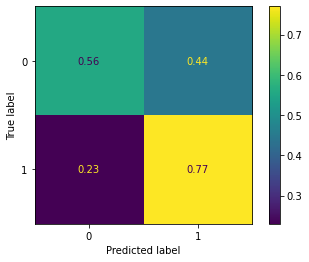

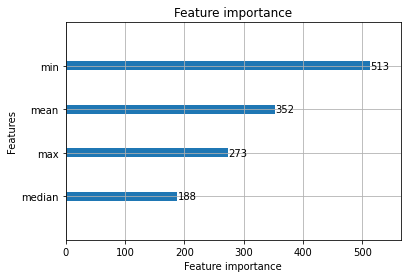

In [42]:
eval_clf(clf_meta_agg_tweet, df_test_meta_agg_tweet)

### Average features at the user level

> Mean

In [43]:
df_train_meta_tweet_mean = get_mean(df_train_meta_tweet, df_train['id'])
df_test_meta_tweet_mean = get_mean(df_test_meta_tweet, df_test['id'])

clf_meta_tweet_mean = get_best_clf(df_train_meta_tweet_mean)

[I 2022-03-29 17:08:57,690] A new study created in memory with name: no-name-ba517b9f-e0b8-4021-8058-f8b8af27e2a3


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:58,114] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 6.986916808169173, 'lambda_l2': 1.168899041375324e-08, 'num_leaves': 7, 'feature_fraction': 0.4332177152710003, 'bagging_fraction': 0.732858074148687, 'bagging_freq': 1, 'learning_rate': 6.49128345361141e-05, 'min_child_samples': 31}. Best is trial 7 with value: 0.5.


Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.697023
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:58,333] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 0.07381664140955792, 'lambda_l2': 0.0005929877357813107, 'num_leaves': 3, 'feature_fraction': 0.5607717949961617, 'bagging_fraction': 0.5384463112515689, 'bagging_freq': 7, 'learning_rate': 2.137905591393332e-05, 'min_child_samples': 21}. Best is trial 7 with value: 0.5.


Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.661068
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:58,631] Trial 5 finished with value: 0.6856697413036776 and parameters: {'lambda_l1': 6.246741545172321e-08, 'lambda_l2': 8.810563354588025, 'num_leaves': 23, 'feature_fraction': 0.5518190333546605, 'bagging_fraction': 0.7234149741341802, 'bagging_freq': 1, 'learning_rate': 0.022745506000299516, 'min_child_samples': 65}. Best is trial 5 with value: 0.6856697413036776.
[I 2022-03-29 17:08:58,725] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 5.641741236016768, 'lambda_l2': 2.2413492668701706e-08, 'num_leaves': 243, 'feature_fraction': 0.48153037322793285, 'bagging_fraction': 0.7557944603925042, 'bagging_freq': 4, 'learning_rate': 1.097889676313601e-05, 'min_child_samples': 76}. Best is trial 5 with value: 0.6856697413036776.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.762875
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.724554


[I 2022-03-29 17:08:58,961] Trial 3 finished with value: 0.7122270172859413 and parameters: {'lambda_l1': 1.8223470350476332, 'lambda_l2': 7.250898870714192e-05, 'num_leaves': 244, 'feature_fraction': 0.8486115549227016, 'bagging_fraction': 0.6223738230650093, 'bagging_freq': 2, 'learning_rate': 0.1684289471814477, 'min_child_samples': 81}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:08:58,992] Trial 0 finished with value: 0.5104391435278495 and parameters: {'lambda_l1': 0.0019843015350234326, 'lambda_l2': 2.693661327447329e-07, 'num_leaves': 130, 'feature_fraction': 0.9966692219217453, 'bagging_fraction': 0.4760519686474485, 'bagging_freq': 7, 'learning_rate': 0.0017689921949983682, 'min_child_samples': 63}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.782839
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.743992
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:59,259] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 2.1427642104002964e-06, 'lambda_l2': 0.010395910177745837, 'num_leaves': 41, 'feature_fraction': 0.9382801088906302, 'bagging_fraction': 0.9610947831170485, 'bagging_freq': 6, 'learning_rate': 0.0004430454269882997, 'min_child_samples': 33}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.746506
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:08:59,839] Trial 13 finished with value: 0.6519663054560975 and parameters: {'lambda_l1': 0.0005506117424822316, 'lambda_l2': 0.01884426849779974, 'num_leaves': 21, 'feature_fraction': 0.9211592557562399, 'bagging_fraction': 0.9472782296293488, 'bagging_freq': 4, 'learning_rate': 0.010449580592808113, 'min_child_samples': 58}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:08:59,980] Trial 1 finished with value: 0.7004866857942286 and parameters: {'lambda_l1': 0.00012447911004197972, 'lambda_l2': 5.7312496375012545, 'num_leaves': 133, 'feature_fraction': 0.8435193863930548, 'bagging_fraction': 0.7414388763492576, 'bagging_freq': 7, 'learning_rate': 0.11683710287231958, 'min_child_samples': 57}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.753214
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's auc: 0.776531
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.768462


[I 2022-03-29 17:09:00,027] Trial 10 finished with value: 0.6838943162687027 and parameters: {'lambda_l1': 0.16576861466198972, 'lambda_l2': 7.76717929072872e-06, 'num_leaves': 191, 'feature_fraction': 0.6771680308207566, 'bagging_fraction': 0.7084381751746148, 'bagging_freq': 2, 'learning_rate': 0.01739669730441871, 'min_child_samples': 85}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:00,199] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 0.008939549237478032, 'lambda_l2': 7.214982028964162e-07, 'num_leaves': 80, 'feature_fraction': 0.5518852499699182, 'bagging_fraction': 0.9551125325619076, 'bagging_freq': 6, 'learning_rate': 0.00038209088417180556, 'min_child_samples': 56}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.76076


[I 2022-03-29 17:09:00,325] Trial 9 finished with value: 0.6754588243663007 and parameters: {'lambda_l1': 0.8351734546784546, 'lambda_l2': 6.275251148991911e-06, 'num_leaves': 129, 'feature_fraction': 0.6646962282294495, 'bagging_fraction': 0.7542566011671061, 'bagging_freq': 7, 'learning_rate': 0.020055887161405994, 'min_child_samples': 59}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.769362
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:00,544] Trial 14 finished with value: 0.5 and parameters: {'lambda_l1': 9.29617028514209e-08, 'lambda_l2': 0.00013287208151767415, 'num_leaves': 234, 'feature_fraction': 0.7859970443896245, 'bagging_fraction': 0.46563278772048966, 'bagging_freq': 3, 'learning_rate': 3.495658998247005e-05, 'min_child_samples': 70}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.751752
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:01,141] Trial 17 finished with value: 0.6948195527944419 and parameters: {'lambda_l1': 0.032188962569016814, 'lambda_l2': 1.4987065465343003e-05, 'num_leaves': 247, 'feature_fraction': 0.7711440324933401, 'bagging_fraction': 0.5680585346767459, 'bagging_freq': 3, 'learning_rate': 0.2861387072710703, 'min_child_samples': 99}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.768198
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:01,376] Trial 19 finished with value: 0.6987231166860313 and parameters: {'lambda_l1': 1.1871652293536846e-05, 'lambda_l2': 9.522759203929956, 'num_leaves': 224, 'feature_fraction': 0.829733612035112, 'bagging_fraction': 0.5951760830822885, 'bagging_freq': 3, 'learning_rate': 0.20070320897454721, 'min_child_samples': 91}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:01,470] Trial 18 finished with value: 0.6942089725653853 and parameters: {'lambda_l1': 3.6051643787772344e-06, 'lambda_l2': 7.512864776270663, 'num_leaves': 255, 'feature_fraction': 0.8134366380147051, 'bagging_fraction': 0.601374948187693, 'bagging_freq': 3, 'learning_rate': 0.2637270722780144, 'min_child_samples': 99}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.774518
Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.764461Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.758585

Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.756413


[I 2022-03-29 17:09:01,548] Trial 12 finished with value: 0.6752928413914117 and parameters: {'lambda_l1': 6.045995731629751e-07, 'lambda_l2': 0.10936384667752372, 'num_leaves': 77, 'feature_fraction': 0.4552202363938841, 'bagging_fraction': 0.6877102611226686, 'bagging_freq': 6, 'learning_rate': 0.019907910953176376, 'min_child_samples': 18}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:01,642] Trial 16 finished with value: 0.642484528015555 and parameters: {'lambda_l1': 0.3987623764208986, 'lambda_l2': 3.89814977594857, 'num_leaves': 175, 'feature_fraction': 0.6311260582300795, 'bagging_fraction': 0.8946268223930949, 'bagging_freq': 4, 'learning_rate': 0.008155313658985947, 'min_child_samples': 89}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:01,642] Trial 20 finished with value: 0.6931241552652171 and parameters: {'lambda_l1': 2.0804907453181804e-05, 'lambda_l2': 6.030261683264278, 'num_leaves': 174, 'feature_fraction': 0.81332984505103

Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.768434
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:01,830] Trial 15 finished with value: 0.6952760059753871 and parameters: {'lambda_l1': 1.5715906286867993, 'lambda_l2': 1.1403477008561571e-06, 'num_leaves': 175, 'feature_fraction': 0.7896917695152663, 'bagging_fraction': 0.5931037988821616, 'bagging_freq': 6, 'learning_rate': 0.25617168776683524, 'min_child_samples': 45}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.764547
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:02,254] Trial 21 finished with value: 0.6948254807578308 and parameters: {'lambda_l1': 2.892121547441393e-05, 'lambda_l2': 3.305530496385248, 'num_leaves': 184, 'feature_fraction': 0.8371180901398437, 'bagging_fraction': 0.6146007918694327, 'bagging_freq': 5, 'learning_rate': 0.2881644894427566, 'min_child_samples': 88}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.761592
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:03,069] Trial 27 finished with value: 0.6910582600241861 and parameters: {'lambda_l1': 9.87231980905184e-05, 'lambda_l2': 0.00037061869761129904, 'num_leaves': 93, 'feature_fraction': 0.8934016728182926, 'bagging_fraction': 0.8378746773151993, 'bagging_freq': 5, 'learning_rate': 0.06717225327394599, 'min_child_samples': 77}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.776382
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:03,492] Trial 28 finished with value: 0.7051668128897635 and parameters: {'lambda_l1': 0.00010869638714861097, 'lambda_l2': 0.33269843903700513, 'num_leaves': 210, 'feature_fraction': 0.8836922297841997, 'bagging_fraction': 0.8308856339048131, 'bagging_freq': 2, 'learning_rate': 0.07691661996975971, 'min_child_samples': 79}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:03,634] Trial 11 finished with value: 0.7008808953595903 and parameters: {'lambda_l1': 2.5916950601921896e-05, 'lambda_l2': 2.361415356386102, 'num_leaves': 179, 'feature_fraction': 0.9025522501579927, 'bagging_fraction': 0.8859950193290073, 'bagging_freq': 1, 'learning_rate': 0.041617473629624986, 'min_child_samples': 11}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.772729
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.776928
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:03,712] Trial 24 finished with value: 0.7015715030943969 and parameters: {'lambda_l1': 0.00015199565816260556, 'lambda_l2': 0.0006141920547906524, 'num_leaves': 178, 'feature_fraction': 0.911863413058377, 'bagging_fraction': 0.8267407238495088, 'bagging_freq': 5, 'learning_rate': 0.06033943960572964, 'min_child_samples': 45}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:03,806] Trial 22 finished with value: 0.6966572214450003 and parameters: {'lambda_l1': 3.68855367369647e-05, 'lambda_l2': 0.17360348077716725, 'num_leaves': 173, 'feature_fraction': 0.8614118142590313, 'bagging_fraction': 0.853154816766787, 'bagging_freq': 5, 'learning_rate': 0.07567594184993795, 'min_child_samples': 44}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.773214
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.776298
Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.771424
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.772197


[I 2022-03-29 17:09:03,884] Trial 23 finished with value: 0.6927477295900221 and parameters: {'lambda_l1': 5.255634251556829e-05, 'lambda_l2': 0.15844253038405592, 'num_leaves': 171, 'feature_fraction': 0.8738840759952214, 'bagging_fraction': 0.8639251890627446, 'bagging_freq': 5, 'learning_rate': 0.06910722822728882, 'min_child_samples': 43}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:03,921] Trial 25 finished with value: 0.6921312213975768 and parameters: {'lambda_l1': 9.996583502729855e-05, 'lambda_l2': 0.0019900786649993465, 'num_leaves': 90, 'feature_fraction': 0.8993493316007096, 'bagging_fraction': 0.8316985646669727, 'bagging_freq': 5, 'learning_rate': 0.0687588447286149, 'min_child_samples': 38}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:04,230] Trial 26 finished with value: 0.6906759063856022 and parameters: {'lambda_l1': 0.00010229584272182449, 'lambda_l2': 0.000326758357578113, 'num_leaves': 94, 'feature_fraction': 0.8923935846987301, 'bagging_fraction': 0.8117821293262276, 'bagging_freq': 5, 'learning_rate': 0.06070213081982758, 'min_child_samples': 43}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.769914
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:04,888] Trial 29 finished with value: 0.6865945035923459 and parameters: {'lambda_l1': 0.0008814959783177516, 'lambda_l2': 0.3847907988254289, 'num_leaves': 222, 'feature_fraction': 0.7335972482342162, 'bagging_fraction': 0.6631472507487056, 'bagging_freq': 2, 'learning_rate': 0.08269740953492496, 'min_child_samples': 45}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:04,982] Trial 36 finished with value: 0.6100941360586156 and parameters: {'lambda_l1': 0.00199329092180602, 'lambda_l2': 3.0129691898885468e-05, 'num_leaves': 208, 'feature_fraction': 0.9900388755715958, 'bagging_fraction': 0.4224861122745184, 'bagging_freq': 2, 'learning_rate': 0.0052106729963374765, 'min_child_samples': 76}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.776376
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.752356
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:05,233] Trial 34 finished with value: 0.5799800820430132 and parameters: {'lambda_l1': 0.0007058427951238535, 'lambda_l2': 0.0025940946751751032, 'num_leaves': 212, 'feature_fraction': 0.7329697916147132, 'bagging_fraction': 0.7946450622087943, 'bagging_freq': 2, 'learning_rate': 0.0036583713397657287, 'min_child_samples': 78}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.757043
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.753197


[I 2022-03-29 17:09:05,324] Trial 35 finished with value: 0.6199167713940199 and parameters: {'lambda_l1': 0.0037395732623915884, 'lambda_l2': 7.363020340226489e-05, 'num_leaves': 216, 'feature_fraction': 0.9620022630624653, 'bagging_fraction': 0.7975552118077117, 'bagging_freq': 2, 'learning_rate': 0.004724997399556979, 'min_child_samples': 77}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:05,578] Trial 30 finished with value: 0.6960347852891661 and parameters: {'lambda_l1': 0.0003928800440451006, 'lambda_l2': 0.4024156651301538, 'num_leaves': 211, 'feature_fraction': 0.7300185780796709, 'bagging_fraction': 0.82364800732991, 'bagging_freq': 2, 'learning_rate': 0.06321558434162051, 'min_child_samples': 47}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.771688


[I 2022-03-29 17:09:05,892] Trial 33 finished with value: 0.5240289995968985 and parameters: {'lambda_l1': 0.0013779453434942799, 'lambda_l2': 0.0022822283820139113, 'num_leaves': 211, 'feature_fraction': 0.9949900359826229, 'bagging_fraction': 0.8046065316193912, 'bagging_freq': 2, 'learning_rate': 0.0018810730149400406, 'min_child_samples': 48}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.750644
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.764892


[I 2022-03-29 17:09:05,971] Trial 32 finished with value: 0.5988606454366538 and parameters: {'lambda_l1': 0.0022378256333843694, 'lambda_l2': 0.002979444627286065, 'num_leaves': 204, 'feature_fraction': 0.727042342145228, 'bagging_fraction': 0.8160831491374486, 'bagging_freq': 2, 'learning_rate': 0.0036811890014481975, 'min_child_samples': 46}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:06,535] Trial 37 finished with value: 0.5240289995968985 and parameters: {'lambda_l1': 0.004330575977758332, 'lambda_l2': 5.308094945108752e-05, 'num_leaves': 201, 'feature_fraction': 0.9887806792591347, 'bagging_fraction': 0.7908771860961955, 'bagging_freq': 2, 'learning_rate': 0.001912951424331111, 'min_child_samples': 70}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.749162
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:07,027] Trial 39 finished with value: 0.7004866857942286 and parameters: {'lambda_l1': 0.0038188003978683943, 'lambda_l2': 0.5159461650778036, 'num_leaves': 147, 'feature_fraction': 0.968325563023658, 'bagging_fraction': 0.9044267825330725, 'bagging_freq': 1, 'learning_rate': 0.03470079464916494, 'min_child_samples': 68}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.777129
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:08,747] Trial 31 finished with value: 0.6925135750361605 and parameters: {'lambda_l1': 0.003645110352607126, 'lambda_l2': 0.7426696614296456, 'num_leaves': 207, 'feature_fraction': 0.9830812028280135, 'bagging_fraction': 0.8292315539285303, 'bagging_freq': 2, 'learning_rate': 0.057532841134360004, 'min_child_samples': 7}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:08,872] Trial 38 finished with value: 0.5 and parameters: {'lambda_l1': 0.004253877564335177, 'lambda_l2': 0.6886466035410026, 'num_leaves': 153, 'feature_fraction': 0.9748507118763127, 'bagging_fraction': 0.7875730815745192, 'bagging_freq': 1, 'learning_rate': 0.001878160620307148, 'min_child_samples': 6}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[57]	valid_0's auc: 0.772203
Did not meet early stopping. Best iteration is:
[64]	valid_0's auc: 0.76131


[I 2022-03-29 17:09:09,013] Trial 40 finished with value: 0.7065539563227657 and parameters: {'lambda_l1': 4.791286863175317e-06, 'lambda_l2': 0.9757752452077355, 'num_leaves': 148, 'feature_fraction': 0.9960819950109013, 'bagging_fraction': 0.9020727272729335, 'bagging_freq': 1, 'learning_rate': 0.036272210221832, 'min_child_samples': 13}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.775699
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:09,500] Trial 43 finished with value: 0.6985749176013089 and parameters: {'lambda_l1': 6.399662370879063e-06, 'lambda_l2': 1.0658963498386718, 'num_leaves': 147, 'feature_fraction': 0.9365519139838433, 'bagging_fraction': 0.9026916069443626, 'bagging_freq': 1, 'learning_rate': 0.1325803550611424, 'min_child_samples': 11}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:09,594] Trial 42 finished with value: 0.7037974533469281 and parameters: {'lambda_l1': 4.493650990436747e-06, 'lambda_l2': 1.1003159221863847, 'num_leaves': 148, 'feature_fraction': 0.9419047822765565, 'bagging_fraction': 0.9010485144410552, 'bagging_freq': 1, 'learning_rate': 0.03759258532449732, 'min_child_samples': 10}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.769872
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.776846
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:10,237] Trial 44 finished with value: 0.6986549451070592 and parameters: {'lambda_l1': 4.999249096336557e-06, 'lambda_l2': 6.170525824900906e-08, 'num_leaves': 153, 'feature_fraction': 0.937468581669864, 'bagging_fraction': 0.9131916341931606, 'bagging_freq': 1, 'learning_rate': 0.03971065427927631, 'min_child_samples': 9}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.771057
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:10,660] Trial 45 finished with value: 0.6942030446019966 and parameters: {'lambda_l1': 6.060197062049588e-06, 'lambda_l2': 5.581156851428856e-08, 'num_leaves': 146, 'feature_fraction': 0.9398188142765577, 'bagging_fraction': 0.9959913489835335, 'bagging_freq': 1, 'learning_rate': 0.02976558420176575, 'min_child_samples': 5}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.770577
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:11,335] Trial 41 finished with value: 0.7083916249733242 and parameters: {'lambda_l1': 2.1597646938492604e-06, 'lambda_l2': 0.026062407691600113, 'num_leaves': 198, 'feature_fraction': 0.9630685482695301, 'bagging_fraction': 0.9138578747458793, 'bagging_freq': 1, 'learning_rate': 0.035567169984418175, 'min_child_samples': 8}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.771179


[I 2022-03-29 17:09:11,649] Trial 48 finished with value: 0.7056351219974865 and parameters: {'lambda_l1': 2.5527539985635833e-06, 'lambda_l2': 0.034652682518064915, 'num_leaves': 113, 'feature_fraction': 0.933904858457876, 'bagging_fraction': 0.9838443581791347, 'bagging_freq': 1, 'learning_rate': 0.13191393322785044, 'min_child_samples': 13}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.767645
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:12,088] Trial 46 finished with value: 0.6885981552177933 and parameters: {'lambda_l1': 4.831800797205112e-06, 'lambda_l2': 1.0282022048649527e-07, 'num_leaves': 147, 'feature_fraction': 0.9409709976264049, 'bagging_fraction': 0.9173400146670079, 'bagging_freq': 1, 'learning_rate': 0.13985014255479172, 'min_child_samples': 25}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.762506
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:12,543] Trial 47 finished with value: 0.6830051217603679 and parameters: {'lambda_l1': 5.958455956072467e-06, 'lambda_l2': 6.73449398193203e-08, 'num_leaves': 234, 'feature_fraction': 0.9278272866830978, 'bagging_fraction': 0.8943463238522386, 'bagging_freq': 1, 'learning_rate': 0.13558771533893924, 'min_child_samples': 26}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.75928
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:12,825] Trial 51 finished with value: 0.5 and parameters: {'lambda_l1': 4.640368866792541e-07, 'lambda_l2': 0.022095876980326615, 'num_leaves': 113, 'feature_fraction': 0.9414975505791138, 'bagging_fraction': 0.9424105455300694, 'bagging_freq': 1, 'learning_rate': 0.0002279257911562756, 'min_child_samples': 28}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.755924
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:13,013] Trial 50 finished with value: 0.6952019064330259 and parameters: {'lambda_l1': 9.348555806252087e-07, 'lambda_l2': 0.015775195678153362, 'num_leaves': 158, 'feature_fraction': 0.9396099005487113, 'bagging_fraction': 0.9277331892709042, 'bagging_freq': 1, 'learning_rate': 0.13488126147499543, 'min_child_samples': 24}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.764907
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:13,546] Trial 49 finished with value: 0.6948936523368031 and parameters: {'lambda_l1': 4.182076332403459e-07, 'lambda_l2': 0.017663320914128422, 'num_leaves': 158, 'feature_fraction': 0.9194586809417746, 'bagging_fraction': 0.9303144866303561, 'bagging_freq': 1, 'learning_rate': 0.03654895344453851, 'min_child_samples': 26}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.770906
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:13,797] Trial 55 finished with value: 0.6881179901832928 and parameters: {'lambda_l1': 7.07500235577713e-07, 'lambda_l2': 0.03736111701349637, 'num_leaves': 59, 'feature_fraction': 0.867785796789861, 'bagging_fraction': 0.9907533333441702, 'bagging_freq': 1, 'learning_rate': 0.013694527801734096, 'min_child_samples': 16}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.767247
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:14,330] Trial 54 finished with value: 0.6899111991084343 and parameters: {'lambda_l1': 8.016142355041115e-07, 'lambda_l2': 0.024967328399978568, 'num_leaves': 116, 'feature_fraction': 0.860327081342838, 'bagging_fraction': 0.9921965433163298, 'bagging_freq': 1, 'learning_rate': 0.12497253292660407, 'min_child_samples': 21}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.769659
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:14,879] Trial 52 finished with value: 0.6923594479880492 and parameters: {'lambda_l1': 8.07851578829833e-07, 'lambda_l2': 0.02926678677910871, 'num_leaves': 233, 'feature_fraction': 0.8717379283830186, 'bagging_fraction': 0.9428138111329262, 'bagging_freq': 1, 'learning_rate': 0.12072448697482122, 'min_child_samples': 23}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.765247
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:15,243] Trial 56 finished with value: 0.5 and parameters: {'lambda_l1': 4.278089994758232e-07, 'lambda_l2': 0.035102663272206194, 'num_leaves': 108, 'feature_fraction': 0.868293447246464, 'bagging_fraction': 0.9746403128475394, 'bagging_freq': 1, 'learning_rate': 0.00040492499280137396, 'min_child_samples': 20}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.755337
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:15,789] Trial 53 finished with value: 0.5 and parameters: {'lambda_l1': 6.204676543086884e-07, 'lambda_l2': 0.02613105998294337, 'num_leaves': 238, 'feature_fraction': 0.864274406826896, 'bagging_fraction': 0.984827368775272, 'bagging_freq': 1, 'learning_rate': 0.0002737920700608585, 'min_child_samples': 23}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.753695
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.769213


[I 2022-03-29 17:09:15,867] Trial 57 finished with value: 0.6961088848315273 and parameters: {'lambda_l1': 6.911992959581078e-07, 'lambda_l2': 0.025426613200284505, 'num_leaves': 115, 'feature_fraction': 0.8669957683722879, 'bagging_fraction': 0.9633156881727267, 'bagging_freq': 1, 'learning_rate': 0.016184925256372922, 'min_child_samples': 14}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:15,993] Trial 58 finished with value: 0.6835238185568966 and parameters: {'lambda_l1': 2.3468688819861687e-07, 'lambda_l2': 0.04610775887673067, 'num_leaves': 115, 'feature_fraction': 0.9622604500920723, 'bagging_fraction': 0.9828188190588759, 'bagging_freq': 1, 'learning_rate': 0.012052149479303671, 'min_child_samples': 17}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.761549
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:16,510] Trial 59 finished with value: 0.6768341118725251 and parameters: {'lambda_l1': 2.3396017104025005e-08, 'lambda_l2': 0.05698968464808227, 'num_leaves': 117, 'feature_fraction': 0.8758357919687234, 'bagging_fraction': 0.9863797659335142, 'bagging_freq': 1, 'learning_rate': 0.010097323033473563, 'min_child_samples': 17}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.765518
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:16,918] Trial 60 finished with value: 0.6977301828183909 and parameters: {'lambda_l1': 1.49435305306021e-08, 'lambda_l2': 0.05339985877304696, 'num_leaves': 122, 'feature_fraction': 0.963467080463506, 'bagging_fraction': 0.9674103180356177, 'bagging_freq': 1, 'learning_rate': 0.022905941866639155, 'min_child_samples': 15}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.771469
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:17,498] Trial 61 finished with value: 0.6909782325184359 and parameters: {'lambda_l1': 2.800322246986956e-08, 'lambda_l2': 0.08883594862004811, 'num_leaves': 123, 'feature_fraction': 0.9636953248467799, 'bagging_fraction': 0.9648561065540093, 'bagging_freq': 2, 'learning_rate': 0.018559263476497195, 'min_child_samples': 15}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.768418


[I 2022-03-29 17:09:17,765] Trial 67 finished with value: 0.6875874374599862 and parameters: {'lambda_l1': 2.027514237557753e-06, 'lambda_l2': 2.3182866611731763, 'num_leaves': 135, 'feature_fraction': 0.5053030274822203, 'bagging_fraction': 0.8581684983574408, 'bagging_freq': 3, 'learning_rate': 0.025072672724760364, 'min_child_samples': 82}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.77276
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.769363


[I 2022-03-29 17:09:17,859] Trial 62 finished with value: 0.695270078011998 and parameters: {'lambda_l1': 9.742481044393222e-08, 'lambda_l2': 0.06795568558002099, 'num_leaves': 113, 'feature_fraction': 0.9609542462885745, 'bagging_fraction': 0.8797471677948214, 'bagging_freq': 3, 'learning_rate': 0.025834947978808292, 'min_child_samples': 15}. Best is trial 3 with value: 0.7122270172859413.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:18,236] Trial 65 finished with value: 0.6835860621724801 and parameters: {'lambda_l1': 1.6490968258792317e-08, 'lambda_l2': 0.08940920624112111, 'num_leaves': 132, 'feature_fraction': 0.9619840942422122, 'bagging_fraction': 0.6640741313761964, 'bagging_freq': 3, 'learning_rate': 0.011374554924057548, 'min_child_samples': 33}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.769844
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:18,722] Trial 66 finished with value: 0.6838261446897304 and parameters: {'lambda_l1': 2.2818850722147213e-06, 'lambda_l2': 1.775486512887592, 'num_leaves': 127, 'feature_fraction': 0.5147179151550335, 'bagging_fraction': 0.8786568682587148, 'bagging_freq': 3, 'learning_rate': 0.025103130364609223, 'min_child_samples': 33}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.771796
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:19,224] Trial 64 finished with value: 0.696879520072084 and parameters: {'lambda_l1': 1.695680057446384e-07, 'lambda_l2': 1.7484677613712758, 'num_leaves': 134, 'feature_fraction': 0.9679905713508297, 'bagging_fraction': 0.8751632803808808, 'bagging_freq': 3, 'learning_rate': 0.02344794523602998, 'min_child_samples': 13}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.771338
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:19,537] Trial 63 finished with value: 0.64931650582126 and parameters: {'lambda_l1': 1.1818856246600179e-07, 'lambda_l2': 0.07925394047138978, 'num_leaves': 192, 'feature_fraction': 0.5141897913396469, 'bagging_fraction': 0.6617465170143944, 'bagging_freq': 3, 'learning_rate': 0.0243871661049362, 'min_child_samples': 14}. Best is trial 3 with value: 0.7122270172859413.


Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.764957
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:19,773] Trial 72 finished with value: 0.6971877741683068 and parameters: {'lambda_l1': 0.00021651701055983719, 'lambda_l2': 0.0065625442960637985, 'num_leaves': 189, 'feature_fraction': 0.9176874155200884, 'bagging_fraction': 0.7644368030920348, 'bagging_freq': 4, 'learning_rate': 0.0943931516477049, 'min_child_samples': 61}. Best is trial 3 with value: 0.7122270172859413.
[I 2022-03-29 17:09:19,804] Trial 73 finished with value: 0.714681194128945 and parameters: {'lambda_l1': 0.00021811873153808006, 'lambda_l2': 0.006090990352479627, 'num_leaves': 193, 'feature_fraction': 0.9144009953088019, 'bagging_fraction': 0.5205861817416563, 'bagging_freq': 4, 'learning_rate': 0.1820044024099518, 'min_child_samples': 64}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.772383
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.772704
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:20,337] Trial 71 finished with value: 0.6980325089512247 and parameters: {'lambda_l1': 1.7388066486998832e-06, 'lambda_l2': 0.0065979809112320245, 'num_leaves': 189, 'feature_fraction': 0.9145686945898361, 'bagging_fraction': 0.7401600325804139, 'bagging_freq': 4, 'learning_rate': 0.09346536962179368, 'min_child_samples': 33}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:20,431] Trial 69 finished with value: 0.6913665141204088 and parameters: {'lambda_l1': 1.8589669510298376e-06, 'lambda_l2': 6.674289325778939e-06, 'num_leaves': 191, 'feature_fraction': 0.9094941302757578, 'bagging_fraction': 0.8756055823314157, 'bagging_freq': 4, 'learning_rate': 0.08907172897663616, 'min_child_samples': 33}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.771426
Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.764749
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.768492
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:20,525] Trial 70 finished with value: 0.7015596471676191 and parameters: {'lambda_l1': 1.1296573486612241e-05, 'lambda_l2': 0.007696178291054049, 'num_leaves': 187, 'feature_fraction': 0.9074414944120508, 'bagging_fraction': 0.7613227668034858, 'bagging_freq': 4, 'learning_rate': 0.1858267247086732, 'min_child_samples': 31}. Best is trial 73 with value: 0.714681194128945.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.767981


[I 2022-03-29 17:09:20,761] Trial 74 finished with value: 0.7020279562753421 and parameters: {'lambda_l1': 0.00022089903587209773, 'lambda_l2': 0.005963972135742517, 'num_leaves': 196, 'feature_fraction': 0.9117071313094716, 'bagging_fraction': 0.7423358843752383, 'bagging_freq': 4, 'learning_rate': 0.19350203464191892, 'min_child_samples': 61}. Best is trial 73 with value: 0.714681194128945.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:21,121] Trial 77 finished with value: 0.7021820833234533 and parameters: {'lambda_l1': 1.4729194004218502e-05, 'lambda_l2': 0.19104774143455733, 'num_leaves': 165, 'feature_fraction': 0.6126096227781386, 'bagging_fraction': 0.5137825677191415, 'bagging_freq': 7, 'learning_rate': 0.19890892157583825, 'min_child_samples': 54}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.766015
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:21,325] Trial 76 finished with value: 0.6946654257463306 and parameters: {'lambda_l1': 1.5711879394506622e-05, 'lambda_l2': 2.3318588449046908e-06, 'num_leaves': 249, 'feature_fraction': 0.8929397446377312, 'bagging_fraction': 0.54794196544239, 'bagging_freq': 7, 'learning_rate': 0.1906346383610395, 'min_child_samples': 54}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:21,498] Trial 75 finished with value: 0.6908300334337136 and parameters: {'lambda_l1': 1.3928717329679966e-05, 'lambda_l2': 0.007672464130748041, 'num_leaves': 190, 'feature_fraction': 0.914205442241306, 'bagging_fraction': 0.7566919811485381, 'bagging_freq': 6, 'learning_rate': 0.09212613950649454, 'min_child_samples': 53}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.764991
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.774073


[I 2022-03-29 17:09:21,623] Trial 80 finished with value: 0.6974278566855571 and parameters: {'lambda_l1': 5.189721792542406e-05, 'lambda_l2': 0.19441123962924375, 'num_leaves': 166, 'feature_fraction': 0.6250104600196119, 'bagging_fraction': 0.5683242842936238, 'bagging_freq': 6, 'learning_rate': 0.04928704747600582, 'min_child_samples': 94}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:21,764] Trial 68 finished with value: 0.6877534204348755 and parameters: {'lambda_l1': 2.589199131914189e-06, 'lambda_l2': 2.2804558914390345, 'num_leaves': 193, 'feature_fraction': 0.9141613608371257, 'bagging_fraction': 0.8636199341298068, 'bagging_freq': 4, 'learning_rate': 0.17918940412387757, 'min_child_samples': 12}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.774192
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.765832


[I 2022-03-29 17:09:21,953] Trial 78 finished with value: 0.6959666137101936 and parameters: {'lambda_l1': 1.8420836454436768e-05, 'lambda_l2': 0.0010986330766556427, 'num_leaves': 166, 'feature_fraction': 0.8976266785885206, 'bagging_fraction': 0.5058490133310716, 'bagging_freq': 6, 'learning_rate': 0.17850375178500766, 'min_child_samples': 53}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:22,031] Trial 79 finished with value: 0.6909841604818249 and parameters: {'lambda_l1': 1.9415360235234478e-05, 'lambda_l2': 0.0007759118808341899, 'num_leaves': 169, 'feature_fraction': 0.8912449834092131, 'bagging_fraction': 0.491992661074663, 'bagging_freq': 6, 'learning_rate': 0.19369651844253227, 'min_child_samples': 54}. Best is trial 73 with value: 0.714681194128945.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.765309
Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.765674


[I 2022-03-29 17:09:22,188] Trial 81 finished with value: 0.6887522822659047 and parameters: {'lambda_l1': 5.218186995424812e-05, 'lambda_l2': 0.2495036016044362, 'num_leaves': 255, 'feature_fraction': 0.888593721817619, 'bagging_fraction': 0.49458498283388574, 'bagging_freq': 7, 'learning_rate': 0.20615354795216043, 'min_child_samples': 65}. Best is trial 73 with value: 0.714681194128945.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.759903
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:22,769] Trial 84 finished with value: 0.6961148127949163 and parameters: {'lambda_l1': 4.176816144293198e-05, 'lambda_l2': 0.22274580710783362, 'num_leaves': 165, 'feature_fraction': 0.6305256188319658, 'bagging_fraction': 0.488928563912423, 'bagging_freq': 7, 'learning_rate': 0.0462529418489279, 'min_child_samples': 66}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:22,831] Trial 82 finished with value: 0.6902075972778792 and parameters: {'lambda_l1': 5.347737857277434e-05, 'lambda_l2': 0.16016967886031772, 'num_leaves': 249, 'feature_fraction': 0.5887806561452809, 'bagging_fraction': 0.5110097864399058, 'bagging_freq': 7, 'learning_rate': 0.04772781695310881, 'min_child_samples': 52}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.77608
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.771632
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.772158
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.752545


[I 2022-03-29 17:09:22,925] Trial 86 finished with value: 0.6792438289901122 and parameters: {'lambda_l1': 0.017802311109192274, 'lambda_l2': 0.27135658494012116, 'num_leaves': 225, 'feature_fraction': 0.5792301221291071, 'bagging_fraction': 0.49791816765259334, 'bagging_freq': 2, 'learning_rate': 0.049621409160268665, 'min_child_samples': 84}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:23,004] Trial 85 finished with value: 0.6775602873876652 and parameters: {'lambda_l1': 4.522928348696741e-05, 'lambda_l2': 0.0011653479727844046, 'num_leaves': 218, 'feature_fraction': 0.6117222843270798, 'bagging_fraction': 0.5016080368736276, 'bagging_freq': 2, 'learning_rate': 0.29939545510228877, 'min_child_samples': 66}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:23,057] Trial 83 finished with value: 0.6917488677589927 and parameters: {'lambda_l1': 6.09108689099088e-05, 'lambda_l2': 0.26802196934298883, 'num_leaves': 166, 'feature_fraction': 0.59043

Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.772683
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:23,317] Trial 87 finished with value: 0.6822344865198111 and parameters: {'lambda_l1': 0.015225133749986942, 'lambda_l2': 0.2527950486754094, 'num_leaves': 227, 'feature_fraction': 0.6041236691000849, 'bagging_fraction': 0.48528560723348435, 'bagging_freq': 2, 'learning_rate': 0.04383056450555558, 'min_child_samples': 64}. Best is trial 73 with value: 0.714681194128945.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.77194
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.777046


[I 2022-03-29 17:09:23,459] Trial 88 finished with value: 0.7001043321556446 and parameters: {'lambda_l1': 4.04389052921446, 'lambda_l2': 0.1946173887792423, 'num_leaves': 198, 'feature_fraction': 0.8414699155833357, 'bagging_fraction': 0.6299440471748502, 'bagging_freq': 2, 'learning_rate': 0.27572827925683624, 'min_child_samples': 63}. Best is trial 73 with value: 0.714681194128945.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:23,961] Trial 91 finished with value: 0.6816239062907548 and parameters: {'lambda_l1': 0.00034704430855225923, 'lambda_l2': 0.9009647207375723, 'num_leaves': 181, 'feature_fraction': 0.9503944244337459, 'bagging_fraction': 0.4557089084156655, 'bagging_freq': 2, 'learning_rate': 0.26139652732783314, 'min_child_samples': 73}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:24,070] Trial 90 finished with value: 0.6901453536622957 and parameters: {'lambda_l1': 8.912756934761795, 'lambda_l2': 0.000137951631807122, 'num_leaves': 198, 'feature_fraction': 0.5817924526595875, 'bagging_fraction': 0.6353033299605899, 'bagging_freq': 2, 'learning_rate': 0.2971920008132998, 'min_child_samples': 9}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.766129
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.776182
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.77337
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.748226
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.757142


[I 2022-03-29 17:09:24,149] Trial 93 finished with value: 0.6922053209399379 and parameters: {'lambda_l1': 3.9138112196032653, 'lambda_l2': 0.8824770436204961, 'num_leaves': 200, 'feature_fraction': 0.6572635459358116, 'bagging_fraction': 0.45203878956196625, 'bagging_freq': 2, 'learning_rate': 0.10654134000551176, 'min_child_samples': 71}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:24,180] Trial 92 finished with value: 0.5 and parameters: {'lambda_l1': 0.0003372263252281166, 'lambda_l2': 0.00010981115371957366, 'num_leaves': 200, 'feature_fraction': 0.8205553944987687, 'bagging_fraction': 0.4498354162092297, 'bagging_freq': 2, 'learning_rate': 0.0008696582966675916, 'min_child_samples': 73}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:24,227] Trial 89 finished with value: 0.6893065468427666 and parameters: {'lambda_l1': 0.00022081665025570392, 'lambda_l2': 0.00022556380788067324, 'num_leaves': 200, 'feature_fraction': 0.590319792249986,

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.752527


[I 2022-03-29 17:09:24,360] Trial 95 finished with value: 0.5 and parameters: {'lambda_l1': 0.00030742440390778264, 'lambda_l2': 1.0714967958662458, 'num_leaves': 199, 'feature_fraction': 0.6670449847554286, 'bagging_fraction': 0.4588727025066913, 'bagging_freq': 2, 'learning_rate': 0.000608090209506853, 'min_child_samples': 58}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:24,619] Trial 96 finished with value: 0.6991854978303654 and parameters: {'lambda_l1': 0.0001471169233181279, 'lambda_l2': 0.8224691973867396, 'num_leaves': 182, 'feature_fraction': 0.6712744094107699, 'bagging_fraction': 0.70668276988691, 'bagging_freq': 5, 'learning_rate': 0.10803514094004574, 'min_child_samples': 71}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.77922


[I 2022-03-29 17:09:25,168] Trial 94 finished with value: 0.6930559836862449 and parameters: {'lambda_l1': 4.153267035586447, 'lambda_l2': 1.2421346923025365, 'num_leaves': 200, 'feature_fraction': 0.8440497625231449, 'bagging_fraction': 0.7135678475873237, 'bagging_freq': 2, 'learning_rate': 0.2503753811500469, 'min_child_samples': 8}. Best is trial 73 with value: 0.714681194128945.
[I 2022-03-29 17:09:25,231] Trial 99 finished with value: 0.6948136248310531 and parameters: {'lambda_l1': 0.00017988959499221614, 'lambda_l2': 0.0033758985383030475, 'num_leaves': 182, 'feature_fraction': 0.9823171039607652, 'bagging_fraction': 0.8429323713565652, 'bagging_freq': 5, 'learning_rate': 0.03245523538526361, 'min_child_samples': 58}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.774731
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.776697


[I 2022-03-29 17:09:25,419] Trial 97 finished with value: 0.6939629620847462 and parameters: {'lambda_l1': 0.1379492065377026, 'lambda_l2': 3.803528885433336, 'num_leaves': 99, 'feature_fraction': 0.6868644002435, 'bagging_fraction': 0.7046158166899488, 'bagging_freq': 5, 'learning_rate': 0.10911849005048121, 'min_child_samples': 9}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.775002


[I 2022-03-29 17:09:25,811] Trial 98 finished with value: 0.6897452161335451 and parameters: {'lambda_l1': 0.00020660612973048893, 'lambda_l2': 0.004055092315393564, 'num_leaves': 176, 'feature_fraction': 0.6966513935158386, 'bagging_fraction': 0.8462155183173864, 'bagging_freq': 5, 'learning_rate': 0.07106248985430975, 'min_child_samples': 9}. Best is trial 73 with value: 0.714681194128945.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.764139
{'lambda_l1': 0.00021811873153808006, 'lambda_l2': 0.006090990352479627, 'num_leaves': 193, 'feature_fraction': 0.9144009953088019, 'bagging_fraction': 0.5205861817416563, 'bagging_freq': 4, 'learning_rate': 0.1820044024099518, 'min_child_samples': 64} -> 0.714681194128945
[LightGBM] [Warning] feature_fraction is set=0.9144009953088019, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9144009953088019
[LightGBM] [Warning] lambda_l1 is set=0.00021811873153808006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021811873153808006
[LightGBM] [Warning] bagging_fraction is set=0.5205861817416563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5205861817416563
[LightGBM] [Warning] lambda_l2 is set=0.006090990352479627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006090990352479627
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be 

AUROC: 0.6755193945672191
Accuracy: 0.6804733727810651


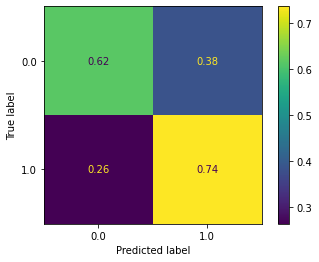

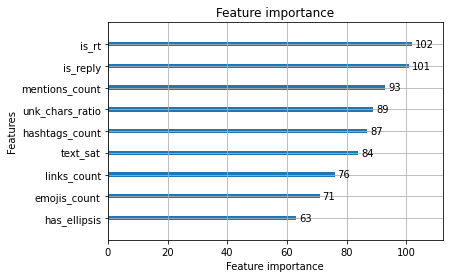

In [44]:
eval_clf(clf_meta_tweet_mean, df_test_meta_tweet_mean)

> Median

In [45]:
df_train_meta_tweet_median = get_median(df_train_meta_tweet, df_train['id'])
df_test_meta_tweet_median = get_median(df_test_meta_tweet, df_test['id'])

clf_meta_tweet_median = get_best_clf(df_train_meta_tweet_median)

[I 2022-03-29 17:09:27,082] A new study created in memory with name: no-name-ae3de883-9101-4d08-aab8-0f07a7241078


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:27,395] Trial 7 finished with value: 0.5 and parameters: {'lambda_l1': 9.920985685477318, 'lambda_l2': 0.013396402061799415, 'num_leaves': 113, 'feature_fraction': 0.6147945189588396, 'bagging_fraction': 0.4205340913215527, 'bagging_freq': 3, 'learning_rate': 0.0049791094561053035, 'min_child_samples': 55}. Best is trial 7 with value: 0.5.


Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.669593
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:27,725] Trial 6 finished with value: 0.6239211106632205 and parameters: {'lambda_l1': 0.6544281427544787, 'lambda_l2': 0.13907216936932956, 'num_leaves': 73, 'feature_fraction': 0.90894112356727, 'bagging_fraction': 0.6730761878690668, 'bagging_freq': 7, 'learning_rate': 0.051870265874359466, 'min_child_samples': 100}. Best is trial 6 with value: 0.6239211106632205.
[I 2022-03-29 17:09:27,772] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 2.3162614490766967e-06, 'lambda_l2': 1.2540350700069387e-08, 'num_leaves': 173, 'feature_fraction': 0.6378040155592175, 'bagging_fraction': 0.6526265614699132, 'bagging_freq': 6, 'learning_rate': 0.0019056334885901608, 'min_child_samples': 92}. Best is trial 6 with value: 0.6239211106632205.
[I 2022-03-29 17:09:27,788] Trial 0 finished with value: 0.5826061698242951 and parameters: {'lambda_l1': 6.837268236444468e-06, 'lambda_l2': 1.037323826413968e-05, 'num_leaves': 23, 'feature_fraction': 0.4926286124798092, 'bag

Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.688072
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.673787
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.6811
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:27,967] Trial 5 finished with value: 0.5006906077348066 and parameters: {'lambda_l1': 0.00039674125142151966, 'lambda_l2': 0.00020648006265469885, 'num_leaves': 49, 'feature_fraction': 0.6813043409305499, 'bagging_fraction': 0.5773831143648961, 'bagging_freq': 5, 'learning_rate': 0.002833411767260606, 'min_child_samples': 63}. Best is trial 6 with value: 0.6239211106632205.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.6763
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:28,167] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 0.00012803911418846525, 'lambda_l2': 3.2798108347794025e-06, 'num_leaves': 85, 'feature_fraction': 0.573803428181124, 'bagging_fraction': 0.619347840712763, 'bagging_freq': 4, 'learning_rate': 0.00012104895602539326, 'min_child_samples': 37}. Best is trial 6 with value: 0.6239211106632205.
[I 2022-03-29 17:09:28,290] Trial 9 finished with value: 0.5671045455623266 and parameters: {'lambda_l1': 4.552794588306381, 'lambda_l2': 1.074150193518671e-05, 'num_leaves': 254, 'feature_fraction': 0.5735910597864318, 'bagging_fraction': 0.8707579929992015, 'bagging_freq': 3, 'learning_rate': 0.010388349954584002, 'min_child_samples': 85}. Best is trial 6 with value: 0.6239211106632205.


Did not meet early stopping. Best iteration is:
[28]	valid_0's auc: 0.675188
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.672722
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:28,524] Trial 8 finished with value: 0.6040861451639675 and parameters: {'lambda_l1': 3.780449625660724e-05, 'lambda_l2': 0.15488170362187292, 'num_leaves': 68, 'feature_fraction': 0.8048810569781164, 'bagging_fraction': 0.9673951615524474, 'bagging_freq': 7, 'learning_rate': 0.01424960726179922, 'min_child_samples': 83}. Best is trial 6 with value: 0.6239211106632205.
[I 2022-03-29 17:09:28,587] Trial 2 finished with value: 0.6229341047589689 and parameters: {'lambda_l1': 2.9591804247508612e-05, 'lambda_l2': 7.05572549885301e-08, 'num_leaves': 65, 'feature_fraction': 0.9012308003350958, 'bagging_fraction': 0.7136997539432044, 'bagging_freq': 3, 'learning_rate': 0.21999803273759497, 'min_child_samples': 26}. Best is trial 6 with value: 0.6239211106632205.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.682053
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.680572
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:28,916] Trial 15 finished with value: 0.6042343442486899 and parameters: {'lambda_l1': 0.00012155381617487265, 'lambda_l2': 2.281914739761819e-05, 'num_leaves': 145, 'feature_fraction': 0.4026298155495676, 'bagging_fraction': 0.5210615085989717, 'bagging_freq': 2, 'learning_rate': 0.03623426510094671, 'min_child_samples': 97}. Best is trial 6 with value: 0.6239211106632205.
[I 2022-03-29 17:09:29,042] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 4.2714136831046085e-07, 'lambda_l2': 4.872826407433678e-07, 'num_leaves': 111, 'feature_fraction': 0.76579454454953, 'bagging_fraction': 0.6713652148090543, 'bagging_freq': 2, 'learning_rate': 0.0024405152624188925, 'min_child_samples': 29}. Best is trial 6 with value: 0.6239211106632205.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.671461
Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.678687
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:29,230] Trial 11 finished with value: 0.5832286059801295 and parameters: {'lambda_l1': 1.9072152629601375e-07, 'lambda_l2': 0.07417841815576799, 'num_leaves': 170, 'feature_fraction': 0.5375078167534554, 'bagging_fraction': 0.4978386552860681, 'bagging_freq': 5, 'learning_rate': 0.011102346328003927, 'min_child_samples': 25}. Best is trial 6 with value: 0.6239211106632205.
[I 2022-03-29 17:09:29,309] Trial 10 finished with value: 0.630907215517037 and parameters: {'lambda_l1': 0.0002878550497536334, 'lambda_l2': 1.231166643249454, 'num_leaves': 62, 'feature_fraction': 0.6506632911357272, 'bagging_fraction': 0.8954073367255702, 'bagging_freq': 1, 'learning_rate': 0.20320655725611728, 'min_child_samples': 54}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.682673
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.689076


[I 2022-03-29 17:09:29,418] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 0.3232707626054132, 'lambda_l2': 3.08900488969574e-05, 'num_leaves': 141, 'feature_fraction': 0.5528538915409477, 'bagging_fraction': 0.9358213783100637, 'bagging_freq': 4, 'learning_rate': 0.0002832082250713243, 'min_child_samples': 53}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.675494
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:29,685] Trial 20 finished with value: 0.6244516633865269 and parameters: {'lambda_l1': 0.021959514230089124, 'lambda_l2': 4.69287819751968, 'num_leaves': 3, 'feature_fraction': 0.9581431509108108, 'bagging_fraction': 0.7792644037409845, 'bagging_freq': 1, 'learning_rate': 0.2741174322978584, 'min_child_samples': 72}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:29,779] Trial 18 finished with value: 0.6307353045787589 and parameters: {'lambda_l1': 0.02567181685566721, 'lambda_l2': 8.318276169763704, 'num_leaves': 10, 'feature_fraction': 0.9670021879727358, 'bagging_fraction': 0.7975166247176987, 'bagging_freq': 7, 'learning_rate': 0.28299717672613184, 'min_child_samples': 8}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.695805
Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.701421
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.696295Training until validation scores don't improve for 100 rounds



[I 2022-03-29 17:09:29,873] Trial 21 finished with value: 0.6296682711687572 and parameters: {'lambda_l1': 0.007983710764089148, 'lambda_l2': 5.178307620628226, 'num_leaves': 4, 'feature_fraction': 0.9985072508072959, 'bagging_fraction': 0.7714175154780731, 'bagging_freq': 1, 'learning_rate': 0.24763256618829413, 'min_child_samples': 73}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:29,983] Trial 14 finished with value: 0.6236988120361368 and parameters: {'lambda_l1': 9.374428917441589e-08, 'lambda_l2': 0.0002704603403969574, 'num_leaves': 93, 'feature_fraction': 0.7418538137559257, 'bagging_fraction': 0.7151518387625588, 'bagging_freq': 2, 'learning_rate': 0.21117409733289988, 'min_child_samples': 46}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 roundsDid not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.686601

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:30,271] Trial 19 finished with value: 0.6282811277357551 and parameters: {'lambda_l1': 0.023913084019612826, 'lambda_l2': 1.1871739708679772, 'num_leaves': 17, 'feature_fraction': 0.9731590830648382, 'bagging_fraction': 0.8013025945349966, 'bagging_freq': 7, 'learning_rate': 0.2606705246695771, 'min_child_samples': 8}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:30,359] Trial 22 finished with value: 0.6308390439380647 and parameters: {'lambda_l1': 0.009024479666353198, 'lambda_l2': 8.359663190674782, 'num_leaves': 6, 'feature_fraction': 0.9813053262680093, 'bagging_fraction': 0.7929565073783806, 'bagging_freq': 1, 'learning_rate': 0.25060201555952655, 'min_child_samples': 70}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.69051
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.698063
Did not meet early stopping. Best iteration is:
[56]	valid_0's auc: 0.672158
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 17:09:30,453] Trial 17 finished with value: 0.5 and parameters: {'lambda_l1': 0.033835229693857764, 'lambda_l2': 5.5262382955755385, 'num_leaves': 197, 'feature_fraction': 0.9792268468751043, 'bagging_fraction': 0.8128761053928915, 'bagging_freq': 7, 'learning_rate': 0.00014307593352582164, 'min_child_samples': 69}. Best is trial 10 with value: 0.630907215517037.



Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:30,783] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 0.4166919580591966, 'lambda_l2': 1.016982643129164e-07, 'num_leaves': 245, 'feature_fraction': 0.603665585705086, 'bagging_fraction': 0.577443780077434, 'bagging_freq': 2, 'learning_rate': 0.0023075988434470155, 'min_child_samples': 13}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[28]	valid_0's auc: 0.680602
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.690631


[I 2022-03-29 17:09:30,973] Trial 23 finished with value: 0.6198574917601309 and parameters: {'lambda_l1': 0.0030188205475970174, 'lambda_l2': 9.783813387985289, 'num_leaves': 29, 'feature_fraction': 0.7746349252898823, 'bagging_fraction': 0.8337697715112516, 'bagging_freq': 1, 'learning_rate': 0.07354559717253285, 'min_child_samples': 44}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:31,237] Trial 24 finished with value: 0.5 and parameters: {'lambda_l1': 0.003322683803071232, 'lambda_l2': 0.00426753576145155, 'num_leaves': 38, 'feature_fraction': 0.79019249618021, 'bagging_fraction': 0.8502556637982793, 'bagging_freq': 6, 'learning_rate': 1.2468586252122512e-05, 'min_child_samples': 45}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.678933


[I 2022-03-29 17:09:31,535] Trial 25 finished with value: 0.5 and parameters: {'lambda_l1': 0.00379406832578672, 'lambda_l2': 0.002641033767478925, 'num_leaves': 41, 'feature_fraction': 0.8539516886171328, 'bagging_fraction': 0.8627393486551825, 'bagging_freq': 6, 'learning_rate': 2.327540540652101e-05, 'min_child_samples': 11}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.683928


[I 2022-03-29 17:09:31,629] Trial 28 finished with value: 0.6218492874588006 and parameters: {'lambda_l1': 0.002048176882432104, 'lambda_l2': 0.004204961861727359, 'num_leaves': 33, 'feature_fraction': 0.8368900575686193, 'bagging_fraction': 0.8868592441263153, 'bagging_freq': 1, 'learning_rate': 0.06365879850386078, 'min_child_samples': 44}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:31,708] Trial 26 finished with value: 0.5 and parameters: {'lambda_l1': 0.0022929669495699123, 'lambda_l2': 0.0021799034586868814, 'num_leaves': 36, 'feature_fraction': 0.8630163587585483, 'bagging_fraction': 0.8731438627869585, 'bagging_freq': 6, 'learning_rate': 1.1254931810131465e-05, 'min_child_samples': 42}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[55]	valid_0's auc: 0.690109
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.677474
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.676252


[I 2022-03-29 17:09:31,802] Trial 27 finished with value: 0.5 and parameters: {'lambda_l1': 0.002369163004172226, 'lambda_l2': 0.004085480002375999, 'num_leaves': 41, 'feature_fraction': 0.817213290174868, 'bagging_fraction': 0.8910922276532683, 'bagging_freq': 1, 'learning_rate': 1.3968083281269182e-05, 'min_child_samples': 65}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.6725


[I 2022-03-29 17:09:31,990] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 2.188576312464378e-05, 'lambda_l2': 0.1151847268920951, 'num_leaves': 192, 'feature_fraction': 0.6903701781269207, 'bagging_fraction': 0.44672050440121247, 'bagging_freq': 1, 'learning_rate': 0.000447745533787487, 'min_child_samples': 5}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:32,194] Trial 29 finished with value: 0.6134137955563987 and parameters: {'lambda_l1': 0.0021195053652076673, 'lambda_l2': 0.003319546095312, 'num_leaves': 40, 'feature_fraction': 0.8492966379187109, 'bagging_fraction': 0.8942042676102324, 'bagging_freq': 1, 'learning_rate': 0.07155335833466298, 'min_child_samples': 42}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's auc: 0.686895
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:32,539] Trial 30 finished with value: 0.6227740497474687 and parameters: {'lambda_l1': 0.00044462260077207986, 'lambda_l2': 0.007592231973177337, 'num_leaves': 47, 'feature_fraction': 0.8574825635500671, 'bagging_fraction': 0.9018713330469809, 'bagging_freq': 5, 'learning_rate': 0.08011245330088639, 'min_child_samples': 60}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:32,617] Trial 36 finished with value: 0.6295082161572569 and parameters: {'lambda_l1': 0.0004879355954362224, 'lambda_l2': 1.0886846831488355, 'num_leaves': 13, 'feature_fraction': 0.927899998704013, 'bagging_fraction': 0.7481821672195174, 'bagging_freq': 5, 'learning_rate': 0.11047797284358844, 'min_child_samples': 61}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.686321
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.695584
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:32,805] Trial 31 finished with value: 0.6151714367012069 and parameters: {'lambda_l1': 0.0007391922199081808, 'lambda_l2': 0.6857138140367133, 'num_leaves': 48, 'feature_fraction': 0.9095190796995809, 'bagging_fraction': 0.9077636161923917, 'bagging_freq': 1, 'learning_rate': 0.09010531830414224, 'min_child_samples': 63}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:32,915] Trial 38 finished with value: 0.597476465985346 and parameters: {'lambda_l1': 0.09932915572628079, 'lambda_l2': 1.8439519364279853, 'num_leaves': 2, 'feature_fraction': 0.9219268878654866, 'bagging_fraction': 0.7435619714666653, 'bagging_freq': 3, 'learning_rate': 0.1262431906765792, 'min_child_samples': 76}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.685796
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.680189


[I 2022-03-29 17:09:32,994] Trial 37 finished with value: 0.6242975363384156 and parameters: {'lambda_l1': 0.10900186366729855, 'lambda_l2': 0.792006018057275, 'num_leaves': 15, 'feature_fraction': 0.9157550461407815, 'bagging_fraction': 0.9969516971670314, 'bagging_freq': 4, 'learning_rate': 0.12677911809427464, 'min_child_samples': 59}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:33,088] Trial 39 finished with value: 0.6255009129063619 and parameters: {'lambda_l1': 0.060605164248570965, 'lambda_l2': 0.9397669032131463, 'num_leaves': 3, 'feature_fraction': 0.9958729264643138, 'bagging_fraction': 0.7678436403928806, 'bagging_freq': 3, 'learning_rate': 0.13794785321895292, 'min_child_samples': 76}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's auc: 0.696771
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.693239Training until validation scores don't improve for 100 rounds

Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.687701


[I 2022-03-29 17:09:33,104] Trial 33 finished with value: 0.6236928840727479 and parameters: {'lambda_l1': 0.0006022220432721202, 'lambda_l2': 1.28119160916593, 'num_leaves': 53, 'feature_fraction': 0.7025555485192363, 'bagging_fraction': 0.919039492245521, 'bagging_freq': 5, 'learning_rate': 0.10186049511485566, 'min_child_samples': 63}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:33,245] Trial 32 finished with value: 0.6121748512081189 and parameters: {'lambda_l1': 0.000427147001042568, 'lambda_l2': 0.8736807965047223, 'num_leaves': 47, 'feature_fraction': 0.8531008920298946, 'bagging_fraction': 0.9149459026954488, 'bagging_freq': 1, 'learning_rate': 0.09112005739105833, 'min_child_samples': 64}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.683759
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[64]	valid_0's auc: 0.688278


[I 2022-03-29 17:09:33,307] Trial 34 finished with value: 0.619098712446352 and parameters: {'lambda_l1': 0.07131077082975969, 'lambda_l2': 0.8334567372697139, 'num_leaves': 53, 'feature_fraction': 0.7042092432524008, 'bagging_fraction': 0.9275540209769634, 'bagging_freq': 5, 'learning_rate': 0.10903819078643746, 'min_child_samples': 60}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:33,448] Trial 35 finished with value: 0.6163184976169587 and parameters: {'lambda_l1': 0.13805582191963675, 'lambda_l2': 0.713577217547272, 'num_leaves': 55, 'feature_fraction': 0.9196309462432979, 'bagging_fraction': 0.748151790371949, 'bagging_freq': 4, 'learning_rate': 0.10822717598212439, 'min_child_samples': 58}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.689601
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:33,621] Trial 40 finished with value: 0.618663007137268 and parameters: {'lambda_l1': 0.12870041382180866, 'lambda_l2': 2.5076695789420076, 'num_leaves': 8, 'feature_fraction': 0.9394031623825527, 'bagging_fraction': 0.7589953995913493, 'bagging_freq': 3, 'learning_rate': 0.029311326633164964, 'min_child_samples': 77}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.686011
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:33,887] Trial 41 finished with value: 0.6209245251701325 and parameters: {'lambda_l1': 0.011169957387742, 'lambda_l2': 0.35586027895679956, 'num_leaves': 17, 'feature_fraction': 0.9837244007492735, 'bagging_fraction': 0.9927819966770396, 'bagging_freq': 2, 'learning_rate': 0.023679424253144288, 'min_child_samples': 78}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.686425
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:34,311] Trial 42 finished with value: 0.6133278400872595 and parameters: {'lambda_l1': 1.8440462313238966e-06, 'lambda_l2': 0.323986844999134, 'num_leaves': 59, 'feature_fraction': 0.9574099016159651, 'bagging_fraction': 0.7607451801743759, 'bagging_freq': 2, 'learning_rate': 0.032653040511919064, 'min_child_samples': 76}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:34,389] Trial 48 finished with value: 0.6224598676878571 and parameters: {'lambda_l1': 0.016369307414104993, 'lambda_l2': 0.031024381041712755, 'num_leaves': 22, 'feature_fraction': 0.9935244020253058, 'bagging_fraction': 0.6945605675120181, 'bagging_freq': 2, 'learning_rate': 0.02862240304381653, 'min_child_samples': 31}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.684617
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.691193
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:35,063] Trial 45 finished with value: 0.6282248120835605 and parameters: {'lambda_l1': 1.5979129907048348e-06, 'lambda_l2': 0.2759885231496537, 'num_leaves': 95, 'feature_fraction': 0.6491801527349286, 'bagging_fraction': 0.7106923798500636, 'bagging_freq': 2, 'learning_rate': 0.2842601144284988, 'min_child_samples': 34}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:35,236] Trial 43 finished with value: 0.6121926350982856 and parameters: {'lambda_l1': 0.010644652007209467, 'lambda_l2': 0.04491507913739864, 'num_leaves': 78, 'feature_fraction': 0.9563435930244187, 'bagging_fraction': 0.8231906223971346, 'bagging_freq': 2, 'learning_rate': 0.029284074795333317, 'min_child_samples': 29}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.683124
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.676161


[I 2022-03-29 17:09:35,330] Trial 51 finished with value: 0.6255424086500843 and parameters: {'lambda_l1': 6.154624395682796e-05, 'lambda_l2': 8.543868306205303, 'num_leaves': 78, 'feature_fraction': 0.6496265866782477, 'bagging_fraction': 0.8147654327082217, 'bagging_freq': 2, 'learning_rate': 0.19392469281754865, 'min_child_samples': 83}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:35,377] Trial 47 finished with value: 0.6180079671827947 and parameters: {'lambda_l1': 0.009785546101506013, 'lambda_l2': 0.037577964225564024, 'num_leaves': 76, 'feature_fraction': 0.9459173073416655, 'bagging_fraction': 0.6837886371391032, 'bagging_freq': 2, 'learning_rate': 0.035030627914714216, 'min_child_samples': 33}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:35,456] Trial 46 finished with value: 0.6133337680506484 and parameters: {'lambda_l1': 1.3408932251952299e-08, 'lambda_l2': 0.031028433364263856, 'num_leaves': 83, 'feature_fraction': 0.941520922

Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.690247
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.682895
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.680699
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.674667


[I 2022-03-29 17:09:35,581] Trial 44 finished with value: 0.6089618950513361 and parameters: {'lambda_l1': 1.564046869664926e-08, 'lambda_l2': 0.0375893329776837, 'num_leaves': 84, 'feature_fraction': 0.9484043892635834, 'bagging_fraction': 0.8154033612481949, 'bagging_freq': 2, 'learning_rate': 0.0284576671891689, 'min_child_samples': 20}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:35,816] Trial 49 finished with value: 0.6218670713489673 and parameters: {'lambda_l1': 7.884328808618406e-05, 'lambda_l2': 0.04286011695208064, 'num_leaves': 83, 'feature_fraction': 0.9507134839329787, 'bagging_fraction': 0.6970718228919562, 'bagging_freq': 2, 'learning_rate': 0.1889117459838383, 'min_child_samples': 31}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.679019
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:36,193] Trial 53 finished with value: 0.6299083536860076 and parameters: {'lambda_l1': 0.00011567994219130681, 'lambda_l2': 9.005039065551028, 'num_leaves': 24, 'feature_fraction': 0.7319084989291068, 'bagging_fraction': 0.6481472603151889, 'bagging_freq': 6, 'learning_rate': 0.17014996350356695, 'min_child_samples': 20}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:36,287] Trial 50 finished with value: 0.6258625186730847 and parameters: {'lambda_l1': 0.008457286962012086, 'lambda_l2': 0.039366938088565555, 'num_leaves': 86, 'feature_fraction': 0.8934686958185706, 'bagging_fraction': 0.6855944333787102, 'bagging_freq': 2, 'learning_rate': 0.2135480208580926, 'min_child_samples': 35}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.693826
Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.683668
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.690335
Did not meet early stopping. Best iteration is:
[28]	valid_0's auc: 0.676401


[I 2022-03-29 17:09:36,383] Trial 54 finished with value: 0.6290695468664786 and parameters: {'lambda_l1': 1.511244070589339, 'lambda_l2': 3.3124747224815287, 'num_leaves': 27, 'feature_fraction': 0.8938189121804515, 'bagging_fraction': 0.6477032397490188, 'bagging_freq': 6, 'learning_rate': 0.18241447697492377, 'min_child_samples': 50}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:36,459] Trial 56 finished with value: 0.5 and parameters: {'lambda_l1': 1.3691180460012498, 'lambda_l2': 2.522205789316479, 'num_leaves': 25, 'feature_fraction': 0.8928370411674132, 'bagging_fraction': 0.6373359630760467, 'bagging_freq': 6, 'learning_rate': 0.0011108539466869738, 'min_child_samples': 51}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:36,522] Trial 55 finished with value: 0.6251363431579446 and parameters: {'lambda_l1': 1.5696970930331194e-05, 'lambda_l2': 2.9789387897862842, 'num_leaves': 27, 'feature_fraction': 0.8828196092298164, 'bagging_fracti

Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.687442Training until validation scores don't improve for 100 rounds

Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.692194
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:36,632] Trial 57 finished with value: 0.6206962985796599 and parameters: {'lambda_l1': 1.1436430383322348e-05, 'lambda_l2': 2.8312418148446423, 'num_leaves': 26, 'feature_fraction': 0.88827893615299, 'bagging_fraction': 0.7911766456798017, 'bagging_freq': 6, 'learning_rate': 0.1749436753638838, 'min_child_samples': 52}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:36,757] Trial 58 finished with value: 0.5 and parameters: {'lambda_l1': 1.4560824132053736, 'lambda_l2': 2.66267797718171, 'num_leaves': 22, 'feature_fraction': 0.8781239914185494, 'bagging_fraction': 0.6420739939374924, 'bagging_freq': 7, 'learning_rate': 0.001155240422249593, 'min_child_samples': 50}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.676398
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.676278


[I 2022-03-29 17:09:37,071] Trial 52 finished with value: 0.6307708723590922 and parameters: {'lambda_l1': 6.513182787338513e-05, 'lambda_l2': 3.126811905088961, 'num_leaves': 76, 'feature_fraction': 0.8832546906888652, 'bagging_fraction': 0.6456586705548539, 'bagging_freq': 6, 'learning_rate': 0.1807724749487275, 'min_child_samples': 20}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:37,149] Trial 60 finished with value: 0.6291377184454509 and parameters: {'lambda_l1': 9.340011753990046e-06, 'lambda_l2': 3.3259210992388626, 'num_leaves': 26, 'feature_fraction': 0.48402544120399255, 'bagging_fraction': 0.6438135683178584, 'bagging_freq': 7, 'learning_rate': 0.15432562332255204, 'min_child_samples': 49}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.695457
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.686017
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.692999
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.67817


[I 2022-03-29 17:09:37,243] Trial 61 finished with value: 0.5863111469423564 and parameters: {'lambda_l1': 1.3837790699520949e-05, 'lambda_l2': 3.5200833559129663, 'num_leaves': 12, 'feature_fraction': 0.6033993905352585, 'bagging_fraction': 0.6180283194963448, 'bagging_freq': 7, 'learning_rate': 0.014261856707192285, 'min_child_samples': 18}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:37,322] Trial 59 finished with value: 0.5852204016787992 and parameters: {'lambda_l1': 1.3743973587562272e-05, 'lambda_l2': 6.581733364740306, 'num_leaves': 27, 'feature_fraction': 0.8858712011191041, 'bagging_fraction': 0.6326022980046343, 'bagging_freq': 7, 'learning_rate': 0.006309436643253049, 'min_child_samples': 69}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:37,322] Trial 62 finished with value: 0.6195077419201859 and parameters: {'lambda_l1': 8.998184553037075e-06, 'lambda_l2': 8.761037177495192, 'num_leaves': 9, 'feature_fraction': 0.496674483794

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.691544
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.69459


[I 2022-03-29 17:09:37,541] Trial 64 finished with value: 0.6155122945960686 and parameters: {'lambda_l1': 0.0002816550632174507, 'lambda_l2': 0.0006972178420295964, 'num_leaves': 11, 'feature_fraction': 0.4187150601692703, 'bagging_fraction': 0.6014297743725177, 'bagging_freq': 7, 'learning_rate': 0.050646905756468207, 'min_child_samples': 17}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:37,557] Trial 63 finished with value: 0.6210608683280773 and parameters: {'lambda_l1': 1.1831296824856897e-05, 'lambda_l2': 7.198990788648953, 'num_leaves': 14, 'feature_fraction': 0.7455310352373389, 'bagging_fraction': 0.6085675402348488, 'bagging_freq': 7, 'learning_rate': 0.05236983072418428, 'min_child_samples': 18}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:37,604] Trial 65 finished with value: 0.5721670262964456 and parameters: {'lambda_l1': 0.00017701314993447836, 'lambda_l2': 1.8070381989445295e-06, 'num_leaves': 11, 'feature_fraction': 0.7394

Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.680146
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:38,419] Trial 73 finished with value: 0.6212387072297442 and parameters: {'lambda_l1': 0.0010924829922722785, 'lambda_l2': 0.13629339124840326, 'num_leaves': 63, 'feature_fraction': 0.9738982227488728, 'bagging_fraction': 0.5465612896809662, 'bagging_freq': 5, 'learning_rate': 0.28373956833835545, 'min_child_samples': 89}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.678806
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:38,733] Trial 67 finished with value: 0.6228362933630522 and parameters: {'lambda_l1': 0.0001735597966513729, 'lambda_l2': 7.641096072587821, 'num_leaves': 112, 'feature_fraction': 0.7351181879541457, 'bagging_fraction': 0.5901879024061883, 'bagging_freq': 7, 'learning_rate': 0.052422828325598365, 'min_child_samples': 19}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:38,843] Trial 68 finished with value: 0.6147149835202618 and parameters: {'lambda_l1': 0.0001463282318757034, 'lambda_l2': 9.296016046506418, 'num_leaves': 67, 'feature_fraction': 0.7463519712614468, 'bagging_fraction': 0.7285102588587073, 'bagging_freq': 5, 'learning_rate': 0.2934638013506018, 'min_child_samples': 15}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.688185
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.682317
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:39,250] Trial 66 finished with value: 0.6195492376639082 and parameters: {'lambda_l1': 0.00019343187272669117, 'lambda_l2': 1.616081232810483e-06, 'num_leaves': 110, 'feature_fraction': 0.7521847084962361, 'bagging_fraction': 0.5883335005673799, 'bagging_freq': 1, 'learning_rate': 0.04802619578747268, 'min_child_samples': 17}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:39,344] Trial 72 finished with value: 0.6154115192184573 and parameters: {'lambda_l1': 3.5184961386976546e-05, 'lambda_l2': 0.1622961783875883, 'num_leaves': 68, 'feature_fraction': 0.9811791601968748, 'bagging_fraction': 0.7305156740992454, 'bagging_freq': 5, 'learning_rate': 0.2971117033281346, 'min_child_samples': 5}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.674482
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.680538
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:39,768] Trial 70 finished with value: 0.6236306404571645 and parameters: {'lambda_l1': 0.00019470208627502488, 'lambda_l2': 2.429527825932057e-06, 'num_leaves': 110, 'feature_fraction': 0.9752622112296709, 'bagging_fraction': 0.7340512968986881, 'bagging_freq': 5, 'learning_rate': 0.2709812904197612, 'min_child_samples': 15}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.668653
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:39,989] Trial 69 finished with value: 0.5906267042894744 and parameters: {'lambda_l1': 0.00017050735965756932, 'lambda_l2': 0.0008941034152178923, 'num_leaves': 113, 'feature_fraction': 0.7388943831464636, 'bagging_fraction': 0.7299282780092485, 'bagging_freq': 5, 'learning_rate': 0.05075384784018887, 'min_child_samples': 5}. Best is trial 10 with value: 0.630907215517037.


Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.679211
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[28]	valid_0's auc: 0.689924


[I 2022-03-29 17:09:40,160] Trial 78 finished with value: 0.6179516515306002 and parameters: {'lambda_l1': 0.00625362905015918, 'lambda_l2': 0.39068338432751587, 'num_leaves': 35, 'feature_fraction': 0.5058572351781014, 'bagging_fraction': 0.8428310372557164, 'bagging_freq': 6, 'learning_rate': 0.14507863559232628, 'min_child_samples': 24}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:40,427] Trial 71 finished with value: 0.6213987622412445 and parameters: {'lambda_l1': 0.0002115405638764993, 'lambda_l2': 6.825985608546524e-07, 'num_leaves': 111, 'feature_fraction': 0.9735085991692473, 'bagging_fraction': 0.7374344128680157, 'bagging_freq': 5, 'learning_rate': 0.24160260708689818, 'min_child_samples': 6}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.670942


[I 2022-03-29 17:09:40,583] Trial 77 finished with value: 0.620313944941076 and parameters: {'lambda_l1': 4.2790460598467375e-05, 'lambda_l2': 0.5022549833202458, 'num_leaves': 38, 'feature_fraction': 0.8043557383643061, 'bagging_fraction': 0.8413167006734712, 'bagging_freq': 1, 'learning_rate': 0.07820943996467265, 'min_child_samples': 10}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:40,677] Trial 79 finished with value: 0.6195551656272971 and parameters: {'lambda_l1': 4.4056511868133504e-06, 'lambda_l2': 0.48063655663608423, 'num_leaves': 41, 'feature_fraction': 0.5198811102138239, 'bagging_fraction': 0.8384650048155659, 'bagging_freq': 6, 'learning_rate': 0.14527219856555476, 'min_child_samples': 56}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[47]	valid_0's auc: 0.685668
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.687701
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.676306


[I 2022-03-29 17:09:40,772] Trial 74 finished with value: 0.6188764138192683 and parameters: {'lambda_l1': 4.957905150775466e-05, 'lambda_l2': 0.47184554696495445, 'num_leaves': 115, 'feature_fraction': 0.6780551802491065, 'bagging_fraction': 0.7245730025211099, 'bagging_freq': 1, 'learning_rate': 0.29835627331008524, 'min_child_samples': 6}. Best is trial 10 with value: 0.630907215517037.
[I 2022-03-29 17:09:40,898] Trial 75 finished with value: 0.6195551656272971 and parameters: {'lambda_l1': 3.675172948146553e-06, 'lambda_l2': 0.40539929229231647, 'num_leaves': 100, 'feature_fraction': 0.6704314693361484, 'bagging_fraction': 0.7288834962146921, 'bagging_freq': 1, 'learning_rate': 0.29829360657130477, 'min_child_samples': 7}. Best is trial 10 with value: 0.630907215517037.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.675534
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.696568Training until validation scores don't improve for 100 rounds

Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.688841
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.696199


[I 2022-03-29 17:09:41,039] Trial 81 finished with value: 0.6417968842624429 and parameters: {'lambda_l1': 0.0012375803146439815, 'lambda_l2': 1.6038929428596325, 'num_leaves': 132, 'feature_fraction': 0.45853761485698796, 'bagging_fraction': 0.788002962631392, 'bagging_freq': 1, 'learning_rate': 0.15115376637554648, 'min_child_samples': 72}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:41,054] Trial 80 finished with value: 0.6186363313020179 and parameters: {'lambda_l1': 4.213490113041786e-06, 'lambda_l2': 1.388474650279501, 'num_leaves': 35, 'feature_fraction': 0.5236600482432959, 'bagging_fraction': 0.8456410255158501, 'bagging_freq': 6, 'learning_rate': 0.1591455819380883, 'min_child_samples': 56}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:41,054] Trial 82 finished with value: 0.6261915206411686 and parameters: {'lambda_l1': 4.060056286948945e-06, 'lambda_l2': 1.5211303528847187, 'num_leaves': 3, 'feature_fraction': 0.4372808934181

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.680941


[I 2022-03-29 17:09:41,368] Trial 83 finished with value: 0.5970822564199844 and parameters: {'lambda_l1': 4.131594455364004e-06, 'lambda_l2': 1.500887968847406, 'num_leaves': 2, 'feature_fraction': 0.43249032433187207, 'bagging_fraction': 0.7814135813655221, 'bagging_freq': 6, 'learning_rate': 0.13740410582852053, 'min_child_samples': 72}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:41,494] Trial 76 finished with value: 0.6080608446162237 and parameters: {'lambda_l1': 0.001131945471777821, 'lambda_l2': 1.4452981142775772, 'num_leaves': 129, 'feature_fraction': 0.6736750007150756, 'bagging_fraction': 0.8430330574779592, 'bagging_freq': 1, 'learning_rate': 0.1384891321913676, 'min_child_samples': 5}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:41,509] Trial 84 finished with value: 0.5984634718895976 and parameters: {'lambda_l1': 0.0009288462701507842, 'lambda_l2': 1.8258062577987464, 'num_leaves': 2, 'feature_fraction': 0.427743825995416

Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.675067
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.670782
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:41,698] Trial 86 finished with value: 0.598235245299125 and parameters: {'lambda_l1': 0.0010602054726382136, 'lambda_l2': 1.1940479695484316, 'num_leaves': 2, 'feature_fraction': 0.9327551225129579, 'bagging_fraction': 0.9467006791017721, 'bagging_freq': 4, 'learning_rate': 0.10897014070294446, 'min_child_samples': 67}. Best is trial 81 with value: 0.6417968842624429.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.675728
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:41,870] Trial 85 finished with value: 0.6216892324473005 and parameters: {'lambda_l1': 0.001185582234967725, 'lambda_l2': 1.3185207998103963, 'num_leaves': 159, 'feature_fraction': 0.44918164699665913, 'bagging_fraction': 0.785167061370661, 'bagging_freq': 4, 'learning_rate': 0.11108394390503622, 'min_child_samples': 67}. Best is trial 81 with value: 0.6417968842624429.


Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.693524
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:09:42,152] Trial 88 finished with value: 0.6276824034334765 and parameters: {'lambda_l1': 0.0011924256776151795, 'lambda_l2': 4.747648067629157, 'num_leaves': 153, 'feature_fraction': 0.47295621640045993, 'bagging_fraction': 0.6671315023608344, 'bagging_freq': 4, 'learning_rate': 0.11442349176212264, 'min_child_samples': 67}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:42,231] Trial 87 finished with value: 0.6294400445782846 and parameters: {'lambda_l1': 0.0010877818615609323, 'lambda_l2': 4.827236047988414, 'num_leaves': 121, 'feature_fraction': 0.46991501492145066, 'bagging_fraction': 0.6634238282289961, 'bagging_freq': 1, 'learning_rate': 0.1055931529313068, 'min_child_samples': 72}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:42,262] Trial 89 finished with value: 0.6322084034809 and parameters: {'lambda_l1': 0.04221409784326216, 'lambda_l2': 8.98227200305141e-05, 'num_leaves': 143, 'feature_fraction': 0.477317917387

Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.693191
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.691618
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.691269


[I 2022-03-29 17:09:42,638] Trial 93 finished with value: 0.6189327294714627 and parameters: {'lambda_l1': 0.037059282615987114, 'lambda_l2': 4.457094358953328, 'num_leaves': 153, 'feature_fraction': 0.47866101562981783, 'bagging_fraction': 0.7661184836128992, 'bagging_freq': 1, 'learning_rate': 0.06849607872735508, 'min_child_samples': 74}. Best is trial 81 with value: 0.6417968842624429.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.689719
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.689902


[I 2022-03-29 17:09:42,654] Trial 91 finished with value: 0.6249881440732222 and parameters: {'lambda_l1': 0.042016430418737254, 'lambda_l2': 9.408462308180616e-05, 'num_leaves': 159, 'feature_fraction': 0.4515205186765447, 'bagging_fraction': 0.665497818366322, 'bagging_freq': 4, 'learning_rate': 0.07109018051356929, 'min_child_samples': 72}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:42,873] Trial 94 finished with value: 0.5 and parameters: {'lambda_l1': 8.100909623382628e-07, 'lambda_l2': 5.441385142534542, 'num_leaves': 126, 'feature_fraction': 0.4700950326561728, 'bagging_fraction': 0.6651532252066157, 'bagging_freq': 1, 'learning_rate': 8.526157092685725e-05, 'min_child_samples': 74}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:42,952] Trial 90 finished with value: 0.618630403338629 and parameters: {'lambda_l1': 0.0011194091867047892, 'lambda_l2': 5.37989736543405, 'num_leaves': 130, 'feature_fraction': 0.5765804963696255, 'baggi

Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.668403
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.687829


[I 2022-03-29 17:09:43,062] Trial 92 finished with value: 0.6207881820121879 and parameters: {'lambda_l1': 0.04896307050476107, 'lambda_l2': 4.73385317834205, 'num_leaves': 155, 'feature_fraction': 0.5653982887071833, 'bagging_fraction': 0.66686883412081, 'bagging_freq': 4, 'learning_rate': 0.09753906801056764, 'min_child_samples': 40}. Best is trial 81 with value: 0.6417968842624429.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.692186


[I 2022-03-29 17:09:43,360] Trial 97 finished with value: 0.6186363313020179 and parameters: {'lambda_l1': 0.026484505399781966, 'lambda_l2': 6.766225125013232e-05, 'num_leaves': 140, 'feature_fraction': 0.5590613272054273, 'bagging_fraction': 0.8011288272752385, 'bagging_freq': 1, 'learning_rate': 0.07474590364984134, 'min_child_samples': 83}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:43,391] Trial 96 finished with value: 0.6244694472766936 and parameters: {'lambda_l1': 0.005082239464550089, 'lambda_l2': 4.159451461295979e-05, 'num_leaves': 149, 'feature_fraction': 0.5597829906112037, 'bagging_fraction': 0.8017520572625378, 'bagging_freq': 1, 'learning_rate': 0.07098519207082386, 'min_child_samples': 79}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:43,469] Trial 99 finished with value: 0.5 and parameters: {'lambda_l1': 0.21388332690369793, 'lambda_l2': 0.00019384609621529277, 'num_leaves': 136, 'feature_fraction': 0.5628099902585768,

Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.686537
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.685395
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.669436


[I 2022-03-29 17:09:43,579] Trial 95 finished with value: 0.6112619448462286 and parameters: {'lambda_l1': 9.418698403638997e-05, 'lambda_l2': 5.120548356485422e-05, 'num_leaves': 132, 'feature_fraction': 0.9977230319883477, 'bagging_fraction': 0.8038253372459077, 'bagging_freq': 1, 'learning_rate': 0.06897872875667158, 'min_child_samples': 83}. Best is trial 81 with value: 0.6417968842624429.
[I 2022-03-29 17:09:43,627] Trial 98 finished with value: 0.6074324804970005 and parameters: {'lambda_l1': 0.004943088632290733, 'lambda_l2': 8.289266255160714e-06, 'num_leaves': 135, 'feature_fraction': 0.998603349114826, 'bagging_fraction': 0.8028028492130587, 'bagging_freq': 1, 'learning_rate': 0.22628285648909943, 'min_child_samples': 79}. Best is trial 81 with value: 0.6417968842624429.


Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.684708
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.685584
{'lambda_l1': 0.0012375803146439815, 'lambda_l2': 1.6038929428596325, 'num_leaves': 132, 'feature_fraction': 0.45853761485698796, 'bagging_fraction': 0.788002962631392, 'bagging_freq': 1, 'learning_rate': 0.15115376637554648, 'min_child_samples': 72} -> 0.6417968842624429
[LightGBM] [Warning] feature_fraction is set=0.45853761485698796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45853761485698796
[LightGBM] [Warning] lambda_l1 is set=0.0012375803146439815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012375803146439815
[LightGBM] [Warning] bagging_fraction is set=0.788002962631392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.788002962631392
[LightGBM] [Warning] lambda_l2 is set=1.6038929428596325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6038929428596325

AUROC: 0.6386869820441988
Accuracy: 0.6466610312764159


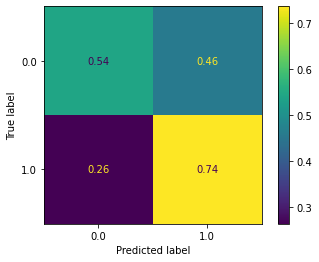

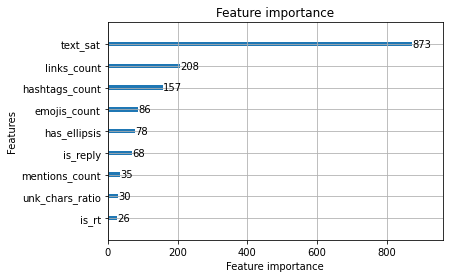

In [46]:
eval_clf(clf_meta_tweet_median, df_test_meta_tweet_median)

## Feature engineering

In [47]:
df_train_meta_tweet_fe = filter_tweet_metadata(df_train_meta_fe)
df_test_meta_tweet_fe = filter_tweet_metadata(df_test_meta_fe)

In [48]:
clf_meta_tweet_fe = get_best_clf(df_train_meta_tweet_fe)

[I 2022-03-29 17:09:45,665] A new study created in memory with name: no-name-5a97a9d2-f555-4323-b35c-7e18f6bcdde9


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds



Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.695877


[I 2022-03-29 17:11:35,246] Trial 3 finished with value: 0.6375293891119125 and parameters: {'lambda_l1': 0.15213649027024964, 'lambda_l2': 0.004983516064108256, 'num_leaves': 82, 'feature_fraction': 0.8340768096519311, 'bagging_fraction': 0.4923276792311296, 'bagging_freq': 2, 'learning_rate': 0.2166057761540733, 'min_child_samples': 80}. Best is trial 3 with value: 0.6375293891119125.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697486


[I 2022-03-29 17:12:11,757] Trial 0 finished with value: 0.637998859647387 and parameters: {'lambda_l1': 4.916020823434503e-07, 'lambda_l2': 2.355558495440069e-06, 'num_leaves': 134, 'feature_fraction': 0.9076506339612228, 'bagging_fraction': 0.5474652487800276, 'bagging_freq': 4, 'learning_rate': 0.12388124474515569, 'min_child_samples': 25}. Best is trial 0 with value: 0.637998859647387.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.692452


[I 2022-03-29 17:12:24,836] Trial 5 finished with value: 0.6334653411417023 and parameters: {'lambda_l1': 1.008936529863123e-08, 'lambda_l2': 7.671903425303342e-06, 'num_leaves': 120, 'feature_fraction': 0.5242487751722904, 'bagging_fraction': 0.859134723010992, 'bagging_freq': 5, 'learning_rate': 0.05408093113683338, 'min_child_samples': 99}. Best is trial 0 with value: 0.637998859647387.


Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.674526
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.677073


[I 2022-03-29 17:12:33,650] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 3.016522587295169e-06, 'lambda_l2': 0.2821076228062512, 'num_leaves': 133, 'feature_fraction': 0.5667189967748097, 'bagging_fraction': 0.5968751648935542, 'bagging_freq': 7, 'learning_rate': 3.932677542801965e-05, 'min_child_samples': 58}. Best is trial 0 with value: 0.637998859647387.
[I 2022-03-29 17:12:33,741] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 1.8821640395883674e-08, 'lambda_l2': 0.00022431007747196236, 'num_leaves': 147, 'feature_fraction': 0.624320363150503, 'bagging_fraction': 0.6231602421699667, 'bagging_freq': 3, 'learning_rate': 9.262621990242668e-05, 'min_child_samples': 20}. Best is trial 0 with value: 0.637998859647387.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.657064


[I 2022-03-29 17:13:03,482] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 4.405168321548166e-07, 'lambda_l2': 0.0009013499622286957, 'num_leaves': 21, 'feature_fraction': 0.5651858800192144, 'bagging_fraction': 0.7953939575269757, 'bagging_freq': 4, 'learning_rate': 1.1967768142559851e-05, 'min_child_samples': 90}. Best is trial 0 with value: 0.637998859647387.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.698951
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.675994


[I 2022-03-29 17:13:11,011] Trial 8 finished with value: 0.6401432291255732 and parameters: {'lambda_l1': 0.0035415807142192388, 'lambda_l2': 0.0003067182745383352, 'num_leaves': 104, 'feature_fraction': 0.8874446978259605, 'bagging_fraction': 0.9952541855178221, 'bagging_freq': 2, 'learning_rate': 0.2732651729111623, 'min_child_samples': 97}. Best is trial 8 with value: 0.6401432291255732.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.683653


[I 2022-03-29 17:13:11,873] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 2.610346250471408e-07, 'lambda_l2': 0.30597809230730777, 'num_leaves': 185, 'feature_fraction': 0.5297303304161033, 'bagging_fraction': 0.6920979767844935, 'bagging_freq': 7, 'learning_rate': 4.6424530373542646e-05, 'min_child_samples': 77}. Best is trial 8 with value: 0.6401432291255732.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:13:18,774] Trial 7 finished with value: 0.595993911702355 and parameters: {'lambda_l1': 0.0028888375331111308, 'lambda_l2': 0.010052252779693573, 'num_leaves': 208, 'feature_fraction': 0.6989542725703157, 'bagging_fraction': 0.7633826652287612, 'bagging_freq': 2, 'learning_rate': 0.004575514407264721, 'min_child_samples': 48}. Best is trial 8 with value: 0.6401432291255732.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.700147


[I 2022-03-29 17:13:31,712] Trial 2 finished with value: 0.6406157988319752 and parameters: {'lambda_l1': 5.140735857955098, 'lambda_l2': 1.6894073498271764e-05, 'num_leaves': 251, 'feature_fraction': 0.6212121851363441, 'bagging_fraction': 0.5206903423802816, 'bagging_freq': 2, 'learning_rate': 0.21952484014257692, 'min_child_samples': 22}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.674844


[I 2022-03-29 17:14:12,188] Trial 11 finished with value: 0.5 and parameters: {'lambda_l1': 0.7525635202735317, 'lambda_l2': 1.1298397805630574e-06, 'num_leaves': 127, 'feature_fraction': 0.945903943484233, 'bagging_fraction': 0.7022030542442304, 'bagging_freq': 4, 'learning_rate': 1.2375136448852874e-05, 'min_child_samples': 96}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.685262


[I 2022-03-29 17:14:31,509] Trial 10 finished with value: 0.6192744472170912 and parameters: {'lambda_l1': 0.0003917716711589627, 'lambda_l2': 1.8096744374547505e-08, 'num_leaves': 200, 'feature_fraction': 0.8680151613367382, 'bagging_fraction': 0.46718448063762164, 'bagging_freq': 5, 'learning_rate': 0.008792351537295434, 'min_child_samples': 28}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.676076
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.677785


[I 2022-03-29 17:14:47,527] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 5.370917966806653e-08, 'lambda_l2': 0.00023355051670653532, 'num_leaves': 131, 'feature_fraction': 0.9096369124201525, 'bagging_fraction': 0.8945159567789225, 'bagging_freq': 6, 'learning_rate': 0.00040066256539257, 'min_child_samples': 34}. Best is trial 2 with value: 0.6406157988319752.
[I 2022-03-29 17:14:50,908] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 4.394810097324145, 'lambda_l2': 0.0001706049618004452, 'num_leaves': 146, 'feature_fraction': 0.8345443203059708, 'bagging_fraction': 0.9380475093164709, 'bagging_freq': 3, 'learning_rate': 0.00013471073918033344, 'min_child_samples': 11}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.699546


[I 2022-03-29 17:15:00,977] Trial 12 finished with value: 0.6393554859492802 and parameters: {'lambda_l1': 0.000411014955619152, 'lambda_l2': 1.4238693052334003e-08, 'num_leaves': 210, 'feature_fraction': 0.5560905632236769, 'bagging_fraction': 0.7648190065678224, 'bagging_freq': 6, 'learning_rate': 0.24839564721081633, 'min_child_samples': 12}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.696756


[I 2022-03-29 17:15:12,505] Trial 14 finished with value: 0.6371963308994335 and parameters: {'lambda_l1': 0.9470501812514159, 'lambda_l2': 0.44555055684416967, 'num_leaves': 186, 'feature_fraction': 0.528007916936478, 'bagging_fraction': 0.6627377573307971, 'bagging_freq': 7, 'learning_rate': 0.06114507571386415, 'min_child_samples': 13}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.678806


[I 2022-03-29 17:15:31,623] Trial 13 finished with value: 0.5 and parameters: {'lambda_l1': 3.53687069787588e-05, 'lambda_l2': 5.620708964041784e-07, 'num_leaves': 221, 'feature_fraction': 0.5588561222768782, 'bagging_fraction': 0.40993367017644344, 'bagging_freq': 7, 'learning_rate': 0.00017057609475011056, 'min_child_samples': 13}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.677678


[I 2022-03-29 17:15:50,897] Trial 17 finished with value: 0.594053078051567 and parameters: {'lambda_l1': 6.968741837347898, 'lambda_l2': 1.3688064777411278e-08, 'num_leaves': 256, 'feature_fraction': 0.443843570813393, 'bagging_fraction': 0.45478765515369435, 'bagging_freq': 1, 'learning_rate': 0.006973571270423661, 'min_child_samples': 6}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.679132


[I 2022-03-29 17:16:19,455] Trial 24 finished with value: 0.6202710124300832 and parameters: {'lambda_l1': 0.01675280179958108, 'lambda_l2': 1.2062866083180146e-05, 'num_leaves': 68, 'feature_fraction': 0.752412537260538, 'bagging_fraction': 0.9828340599698702, 'bagging_freq': 1, 'learning_rate': 0.016958270113856876, 'min_child_samples': 60}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.692106


[I 2022-03-29 17:16:32,314] Trial 19 finished with value: 0.6320389697618924 and parameters: {'lambda_l1': 6.223622866222712, 'lambda_l2': 5.275958836575751e-05, 'num_leaves': 239, 'feature_fraction': 0.7546054943141001, 'bagging_fraction': 0.9618701444063356, 'bagging_freq': 1, 'learning_rate': 0.02318175524307122, 'min_child_samples': 48}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.684701


[I 2022-03-29 17:16:42,649] Trial 25 finished with value: 0.6271518011436119 and parameters: {'lambda_l1': 0.011011650474746821, 'lambda_l2': 1.4761417079708769e-05, 'num_leaves': 69, 'feature_fraction': 0.7575997748196877, 'bagging_fraction': 0.9891219277548668, 'bagging_freq': 1, 'learning_rate': 0.03352203172015761, 'min_child_samples': 58}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.695311


[I 2022-03-29 17:16:53,438] Trial 20 finished with value: 0.6360803917380387 and parameters: {'lambda_l1': 5.5556161916318505, 'lambda_l2': 2.6067204359001112e-05, 'num_leaves': 250, 'feature_fraction': 0.747775523860529, 'bagging_fraction': 0.9989926276871774, 'bagging_freq': 1, 'learning_rate': 0.03277026808520932, 'min_child_samples': 5}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.689475


[I 2022-03-29 17:17:06,016] Trial 21 finished with value: 0.6281623818780453 and parameters: {'lambda_l1': 0.024302181044417188, 'lambda_l2': 3.271105133885767e-08, 'num_leaves': 243, 'feature_fraction': 0.4216688440184187, 'bagging_fraction': 0.4051299932964729, 'bagging_freq': 1, 'learning_rate': 0.029149655195988392, 'min_child_samples': 59}. Best is trial 2 with value: 0.6406157988319752.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.681302


[I 2022-03-29 17:17:13,872] Trial 18 finished with value: 0.6116702395522815 and parameters: {'lambda_l1': 6.02111036763219, 'lambda_l2': 1.4213076420258193e-08, 'num_leaves': 255, 'feature_fraction': 0.41682038086005163, 'bagging_fraction': 0.9987361013488716, 'bagging_freq': 1, 'learning_rate': 0.010730842162711446, 'min_child_samples': 5}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.689511


[I 2022-03-29 17:17:35,170] Trial 22 finished with value: 0.6273053221616604 and parameters: {'lambda_l1': 0.021848066673715336, 'lambda_l2': 2.6326532757689057e-05, 'num_leaves': 242, 'feature_fraction': 0.4441782908808547, 'bagging_fraction': 0.9948721755473449, 'bagging_freq': 1, 'learning_rate': 0.026842562812090714, 'min_child_samples': 51}. Best is trial 2 with value: 0.6406157988319752.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.668979


[I 2022-03-29 17:17:41,396] Trial 26 finished with value: 0.5258875739801083 and parameters: {'lambda_l1': 0.06142185574734115, 'lambda_l2': 8.771855836468362, 'num_leaves': 80, 'feature_fraction': 0.9988591894725141, 'bagging_fraction': 0.5531147512313059, 'bagging_freq': 2, 'learning_rate': 0.0016708836094373142, 'min_child_samples': 41}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.684112


[I 2022-03-29 17:17:55,950] Trial 23 finished with value: 0.6199044299421927 and parameters: {'lambda_l1': 0.013804318838325027, 'lambda_l2': 1.3153530987927314e-05, 'num_leaves': 256, 'feature_fraction': 0.40042152189350083, 'bagging_fraction': 0.5321593064034921, 'bagging_freq': 1, 'learning_rate': 0.01823718160212387, 'min_child_samples': 59}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.668235


[I 2022-03-29 17:18:04,466] Trial 27 finished with value: 0.5122751316541581 and parameters: {'lambda_l1': 0.01846295288048741, 'lambda_l2': 5.823272255355102, 'num_leaves': 81, 'feature_fraction': 0.9981337538603607, 'bagging_fraction': 0.5452707052642495, 'bagging_freq': 2, 'learning_rate': 0.0013092098965311282, 'min_child_samples': 37}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697932


[I 2022-03-29 17:18:18,282] Trial 28 finished with value: 0.6386545644229938 and parameters: {'lambda_l1': 7.815135181614275e-05, 'lambda_l2': 1.5578818836179187e-07, 'num_leaves': 98, 'feature_fraction': 0.6411748396924379, 'bagging_fraction': 0.7872516209118218, 'bagging_freq': 2, 'learning_rate': 0.23216315011324323, 'min_child_samples': 38}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.691274


[I 2022-03-29 17:18:39,783] Trial 34 finished with value: 0.6335795301144678 and parameters: {'lambda_l1': 0.00020270102127169115, 'lambda_l2': 1.9127368741235753e-07, 'num_leaves': 36, 'feature_fraction': 0.6444067212345448, 'bagging_fraction': 0.8083675207598355, 'bagging_freq': 3, 'learning_rate': 0.27978268893168307, 'min_child_samples': 73}. Best is trial 2 with value: 0.6406157988319752.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700055


[I 2022-03-29 17:18:54,823] Trial 30 finished with value: 0.6409376190010015 and parameters: {'lambda_l1': 0.0001364252591804887, 'lambda_l2': 1.6815365486914633e-07, 'num_leaves': 163, 'feature_fraction': 0.9983904951098924, 'bagging_fraction': 0.8149543434714235, 'bagging_freq': 2, 'learning_rate': 0.28861835929559065, 'min_child_samples': 36}. Best is trial 30 with value: 0.6409376190010015.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699158


[I 2022-03-29 17:19:04,233] Trial 31 finished with value: 0.63987596749204 and parameters: {'lambda_l1': 8.14155425925713e-05, 'lambda_l2': 3.224334164798793e-07, 'num_leaves': 168, 'feature_fraction': 0.6505948754057012, 'bagging_fraction': 0.7836417605590852, 'bagging_freq': 2, 'learning_rate': 0.2884243380271725, 'min_child_samples': 38}. Best is trial 30 with value: 0.6409376190010015.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.700686


[I 2022-03-29 17:19:19,984] Trial 29 finished with value: 0.640678479380586 and parameters: {'lambda_l1': 8.542241412383754e-05, 'lambda_l2': 8.848266541670125e-08, 'num_leaves': 228, 'feature_fraction': 0.6436043157754683, 'bagging_fraction': 0.8065409188847895, 'bagging_freq': 2, 'learning_rate': 0.2372686762338327, 'min_child_samples': 37}. Best is trial 30 with value: 0.6409376190010015.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.699664


[I 2022-03-29 17:19:26,515] Trial 32 finished with value: 0.6404086465973239 and parameters: {'lambda_l1': 8.788026313164168e-05, 'lambda_l2': 1.439659647092089e-07, 'num_leaves': 166, 'feature_fraction': 0.6453167817190232, 'bagging_fraction': 0.7956480143052521, 'bagging_freq': 2, 'learning_rate': 0.2538445917346729, 'min_child_samples': 40}. Best is trial 30 with value: 0.6409376190010015.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.698281


[I 2022-03-29 17:19:55,601] Trial 35 finished with value: 0.6390432172394697 and parameters: {'lambda_l1': 0.00018248377879851647, 'lambda_l2': 0.0027602125070398348, 'num_leaves': 170, 'feature_fraction': 0.6479137327387892, 'bagging_fraction': 0.7718424684360604, 'bagging_freq': 5, 'learning_rate': 0.2994473910547855, 'min_child_samples': 70}. Best is trial 30 with value: 0.6409376190010015.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700512


[I 2022-03-29 17:20:03,469] Trial 33 finished with value: 0.6410009209024315 and parameters: {'lambda_l1': 0.0007955053601766942, 'lambda_l2': 1.7920999405158378e-07, 'num_leaves': 169, 'feature_fraction': 0.6585744654943515, 'bagging_fraction': 0.7662688394761266, 'bagging_freq': 3, 'learning_rate': 0.19895692470486925, 'min_child_samples': 68}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699411


[I 2022-03-29 17:20:18,325] Trial 36 finished with value: 0.6396780284731333 and parameters: {'lambda_l1': 0.0017070362530819765, 'lambda_l2': 0.002570177852970969, 'num_leaves': 164, 'feature_fraction': 0.6377102549157603, 'bagging_fraction': 0.84906959013252, 'bagging_freq': 3, 'learning_rate': 0.11574056052846002, 'min_child_samples': 24}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.698693


[I 2022-03-29 17:20:41,136] Trial 37 finished with value: 0.6387160542856041 and parameters: {'lambda_l1': 7.821026739359714e-06, 'lambda_l2': 0.0032094845963198575, 'num_leaves': 160, 'feature_fraction': 0.7134254746509843, 'bagging_fraction': 0.8455646776425496, 'bagging_freq': 5, 'learning_rate': 0.08659983696541072, 'min_child_samples': 23}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699514


[I 2022-03-29 17:21:00,425] Trial 38 finished with value: 0.6396046945550254 and parameters: {'lambda_l1': 1.1929027307547718e-05, 'lambda_l2': 1.0562855799582714e-07, 'num_leaves': 167, 'feature_fraction': 0.9430101120382208, 'bagging_fraction': 0.7422740581789931, 'bagging_freq': 3, 'learning_rate': 0.10472561923851659, 'min_child_samples': 23}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.69948


[I 2022-03-29 17:21:12,611] Trial 39 finished with value: 0.6396497230466112 and parameters: {'lambda_l1': 7.38976311160687e-06, 'lambda_l2': 2.7609404659005606e-06, 'num_leaves': 169, 'feature_fraction': 0.6862246692973221, 'bagging_fraction': 0.8541894754949497, 'bagging_freq': 3, 'learning_rate': 0.09706666561221716, 'min_child_samples': 24}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699393


[I 2022-03-29 17:21:29,898] Trial 40 finished with value: 0.639702989894096 and parameters: {'lambda_l1': 5.641428422320762e-06, 'lambda_l2': 4.2191909214792925e-06, 'num_leaves': 172, 'feature_fraction': 0.9510892174608996, 'bagging_fraction': 0.8484583314382315, 'bagging_freq': 3, 'learning_rate': 0.09123774609182508, 'min_child_samples': 26}. Best is trial 33 with value: 0.6410009209024315.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.69965


[I 2022-03-29 17:21:36,088] Trial 41 finished with value: 0.6395359978491189 and parameters: {'lambda_l1': 5.105340378689349e-06, 'lambda_l2': 3.403970708509971e-06, 'num_leaves': 174, 'feature_fraction': 0.7029415738466908, 'bagging_fraction': 0.8389899709094771, 'bagging_freq': 3, 'learning_rate': 0.09893209770810096, 'min_child_samples': 25}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.70006


[I 2022-03-29 17:21:57,369] Trial 42 finished with value: 0.6395064803212877 and parameters: {'lambda_l1': 7.583268822800368e-06, 'lambda_l2': 2.653532359006252e-06, 'num_leaves': 166, 'feature_fraction': 0.6969961884076272, 'bagging_fraction': 0.8490518084153275, 'bagging_freq': 3, 'learning_rate': 0.11808055582660372, 'min_child_samples': 27}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.701563


[I 2022-03-29 17:22:18,727] Trial 43 finished with value: 0.6408751832870226 and parameters: {'lambda_l1': 1.2703650836490218e-05, 'lambda_l2': 1.9851613480115138e-06, 'num_leaves': 231, 'feature_fraction': 0.6947659807586731, 'bagging_fraction': 0.8463112687767971, 'bagging_freq': 3, 'learning_rate': 0.10609476911992614, 'min_child_samples': 25}. Best is trial 33 with value: 0.6410009209024315.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.701559


[I 2022-03-29 17:22:25,143] Trial 44 finished with value: 0.6404053347147274 and parameters: {'lambda_l1': 6.5507248933484204e-06, 'lambda_l2': 2.5601530711166654e-06, 'num_leaves': 225, 'feature_fraction': 0.6881723873995671, 'bagging_fraction': 0.7221167996400226, 'bagging_freq': 3, 'learning_rate': 0.09863318185841054, 'min_child_samples': 29}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700619


[I 2022-03-29 17:22:51,692] Trial 45 finished with value: 0.6406255936071893 and parameters: {'lambda_l1': 4.186728184206173e-06, 'lambda_l2': 2.3488074996508843e-06, 'num_leaves': 232, 'feature_fraction': 0.5930996473597758, 'bagging_fraction': 0.7110401053286988, 'bagging_freq': 3, 'learning_rate': 0.11440223206748151, 'min_child_samples': 32}. Best is trial 33 with value: 0.6410009209024315.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.700887


[I 2022-03-29 17:23:06,293] Trial 46 finished with value: 0.6410875328780362 and parameters: {'lambda_l1': 2.6553736312979377e-06, 'lambda_l2': 4.01875300660325e-06, 'num_leaves': 225, 'feature_fraction': 0.5958138407658501, 'bagging_fraction': 0.724742403662552, 'bagging_freq': 3, 'learning_rate': 0.11408845323266005, 'min_child_samples': 32}. Best is trial 46 with value: 0.6410875328780362.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.698067


[I 2022-03-29 17:23:21,333] Trial 47 finished with value: 0.6378656825803375 and parameters: {'lambda_l1': 1.4635051126175378e-06, 'lambda_l2': 2.8806693493034685e-06, 'num_leaves': 224, 'feature_fraction': 0.6003069401646257, 'bagging_fraction': 0.71281483567303, 'bagging_freq': 3, 'learning_rate': 0.053874060105840185, 'min_child_samples': 31}. Best is trial 46 with value: 0.6410875328780362.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.70059


[I 2022-03-29 17:23:28,421] Trial 49 finished with value: 0.6403407212286141 and parameters: {'lambda_l1': 0.0006871602025150558, 'lambda_l2': 5.758158681870603e-08, 'num_leaves': 187, 'feature_fraction': 0.6102399000839526, 'bagging_fraction': 0.7304787570791579, 'bagging_freq': 2, 'learning_rate': 0.15912897515022917, 'min_child_samples': 44}. Best is trial 46 with value: 0.6410875328780362.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.701199


[I 2022-03-29 17:23:42,203] Trial 48 finished with value: 0.6415686347573394 and parameters: {'lambda_l1': 0.0011075262202793138, 'lambda_l2': 5.68116598478944e-08, 'num_leaves': 225, 'feature_fraction': 0.6015358861729404, 'bagging_fraction': 0.7069429483433458, 'bagging_freq': 2, 'learning_rate': 0.16665577329006154, 'min_child_samples': 32}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.701222


[I 2022-03-29 17:24:16,312] Trial 50 finished with value: 0.6412876772361389 and parameters: {'lambda_l1': 0.0009363259556602877, 'lambda_l2': 6.395055216659071e-08, 'num_leaves': 227, 'feature_fraction': 0.6033430555164869, 'bagging_fraction': 0.7266893611023947, 'bagging_freq': 2, 'learning_rate': 0.15147918911140487, 'min_child_samples': 43}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.701645


[I 2022-03-29 17:24:30,549] Trial 51 finished with value: 0.6411390580843798 and parameters: {'lambda_l1': 0.0014731782983400177, 'lambda_l2': 8.158297122113835e-07, 'num_leaves': 221, 'feature_fraction': 0.6002806596446709, 'bagging_fraction': 0.7272131582434893, 'bagging_freq': 4, 'learning_rate': 0.17497698471012524, 'min_child_samples': 31}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697894


[I 2022-03-29 17:24:52,991] Trial 52 finished with value: 0.6383155666026511 and parameters: {'lambda_l1': 0.0014215644036810783, 'lambda_l2': 4.8958488400442016e-08, 'num_leaves': 226, 'feature_fraction': 0.6142791394740186, 'bagging_fraction': 0.9036124292210053, 'bagging_freq': 4, 'learning_rate': 0.05043681791779933, 'min_child_samples': 33}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700584


[I 2022-03-29 17:25:00,761] Trial 53 finished with value: 0.6408972904489086 and parameters: {'lambda_l1': 1.1234792921573385e-06, 'lambda_l2': 5.211896773034331e-08, 'num_leaves': 192, 'feature_fraction': 0.5950128646736297, 'bagging_fraction': 0.6707733725443515, 'bagging_freq': 4, 'learning_rate': 0.16394901515149435, 'min_child_samples': 44}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697175


[I 2022-03-29 17:25:29,124] Trial 54 finished with value: 0.6373088439956166 and parameters: {'lambda_l1': 1.1587910424216851e-06, 'lambda_l2': 4.919849267390564e-08, 'num_leaves': 193, 'feature_fraction': 0.5981276315749187, 'bagging_fraction': 0.8900959702226329, 'bagging_freq': 4, 'learning_rate': 0.05421600143485333, 'min_child_samples': 18}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.70109


[I 2022-03-29 17:25:35,435] Trial 55 finished with value: 0.641267170920037 and parameters: {'lambda_l1': 2.548518090112097e-05, 'lambda_l2': 4.6366845521170334e-08, 'num_leaves': 196, 'feature_fraction': 0.7750138699490292, 'bagging_fraction': 0.664183552728291, 'bagging_freq': 4, 'learning_rate': 0.17746658429370704, 'min_child_samples': 43}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697178


[I 2022-03-29 17:26:01,849] Trial 56 finished with value: 0.6366976366531296 and parameters: {'lambda_l1': 9.74076846966612e-07, 'lambda_l2': 6.511375529588379e-07, 'num_leaves': 204, 'feature_fraction': 0.4971361097148023, 'bagging_fraction': 0.9117866637436567, 'bagging_freq': 4, 'learning_rate': 0.058193044836274736, 'min_child_samples': 18}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.696431


[I 2022-03-29 17:26:08,687] Trial 57 finished with value: 0.6362791740104543 and parameters: {'lambda_l1': 1.2550389954171258e-06, 'lambda_l2': 7.849893400592619e-07, 'num_leaves': 200, 'feature_fraction': 0.5047356283025695, 'bagging_fraction': 0.6692683052372366, 'bagging_freq': 4, 'learning_rate': 0.056915391729900414, 'min_child_samples': 18}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697371


[I 2022-03-29 17:26:36,462] Trial 58 finished with value: 0.6375516829370398 and parameters: {'lambda_l1': 0.0011396753362257867, 'lambda_l2': 6.894730409659505e-07, 'num_leaves': 205, 'feature_fraction': 0.5875112398908181, 'bagging_fraction': 0.6624099178398309, 'bagging_freq': 4, 'learning_rate': 0.05502266186612798, 'min_child_samples': 17}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697353
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:26:46,639] Trial 59 finished with value: 0.6372512613199942 and parameters: {'lambda_l1': 0.0012137039027325127, 'lambda_l2': 7.823953419797565e-07, 'num_leaves': 200, 'feature_fraction': 0.584352058810994, 'bagging_fraction': 0.6496815949475769, 'bagging_freq': 4, 'learning_rate': 0.05409027505247155, 'min_child_samples': 19}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699685


[I 2022-03-29 17:27:08,595] Trial 60 finished with value: 0.6400196907748257 and parameters: {'lambda_l1': 0.004537093023781687, 'lambda_l2': 5.535215361837767e-07, 'num_leaves': 207, 'feature_fraction': 0.49581277781396105, 'bagging_fraction': 0.6633047175382064, 'bagging_freq': 4, 'learning_rate': 0.1812350859278765, 'min_child_samples': 44}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700205


[I 2022-03-29 17:27:16,660] Trial 61 finished with value: 0.6405425169335047 and parameters: {'lambda_l1': 0.004823834057162804, 'lambda_l2': 6.164221836935767e-07, 'num_leaves': 211, 'feature_fraction': 0.5040353514494301, 'bagging_fraction': 0.6314003177632804, 'bagging_freq': 4, 'learning_rate': 0.15510619906164982, 'min_child_samples': 83}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.69996


[I 2022-03-29 17:27:37,009] Trial 62 finished with value: 0.6399637395493165 and parameters: {'lambda_l1': 0.004136569721838439, 'lambda_l2': 7.491101574340707e-07, 'num_leaves': 210, 'feature_fraction': 0.5009507424967723, 'bagging_fraction': 0.6115843072351648, 'bagging_freq': 4, 'learning_rate': 0.17160870523321065, 'min_child_samples': 84}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700387
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:27:46,700] Trial 63 finished with value: 0.641004214406987 and parameters: {'lambda_l1': 2.783267648760012e-05, 'lambda_l2': 6.516873057458867e-07, 'num_leaves': 211, 'feature_fraction': 0.4914104652809896, 'bagging_fraction': 0.6797311889954902, 'bagging_freq': 4, 'learning_rate': 0.15653630803383933, 'min_child_samples': 83}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700039


[I 2022-03-29 17:28:16,837] Trial 64 finished with value: 0.639927974774479 and parameters: {'lambda_l1': 0.004801358487521853, 'lambda_l2': 5.85679233676401e-07, 'num_leaves': 212, 'feature_fraction': 0.49175768867021163, 'bagging_fraction': 0.6215507031416119, 'bagging_freq': 5, 'learning_rate': 0.14962694886674452, 'min_child_samples': 54}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700604


[I 2022-03-29 17:28:25,671] Trial 65 finished with value: 0.6404763332059362 and parameters: {'lambda_l1': 0.0052008436470810555, 'lambda_l2': 2.815504648215375e-07, 'num_leaves': 212, 'feature_fraction': 0.5487019802225124, 'bagging_fraction': 0.6153870823803992, 'bagging_freq': 5, 'learning_rate': 0.1681188371795923, 'min_child_samples': 86}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700811


[I 2022-03-29 17:28:48,225] Trial 67 finished with value: 0.6405404554269332 and parameters: {'lambda_l1': 0.004071691600277422, 'lambda_l2': 2.986002296732489e-08, 'num_leaves': 214, 'feature_fraction': 0.7983029043419727, 'bagging_fraction': 0.6140289526082424, 'bagging_freq': 5, 'learning_rate': 0.1571691598927875, 'min_child_samples': 87}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699479


[I 2022-03-29 17:29:02,829] Trial 69 finished with value: 0.6395989569511766 and parameters: {'lambda_l1': 0.0004841654248567379, 'lambda_l2': 2.8002454933459217e-08, 'num_leaves': 149, 'feature_fraction': 0.5550272698872071, 'bagging_fraction': 0.7521155159634937, 'bagging_freq': 5, 'learning_rate': 0.17324531185190925, 'min_child_samples': 52}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.699903


[I 2022-03-29 17:29:16,427] Trial 66 finished with value: 0.6401665789930975 and parameters: {'lambda_l1': 2.8074560885793474e-05, 'lambda_l2': 3.1429914412478587e-07, 'num_leaves': 215, 'feature_fraction': 0.5498180675338153, 'bagging_fraction': 0.6245943615820906, 'bagging_freq': 5, 'learning_rate': 0.17824129851149206, 'min_child_samples': 65}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.678779
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.700154


[I 2022-03-29 17:29:32,907] Trial 70 finished with value: 0.5 and parameters: {'lambda_l1': 2.8033271467647096e-05, 'lambda_l2': 2.2819943052134088e-07, 'num_leaves': 154, 'feature_fraction': 0.8202320751290229, 'bagging_fraction': 0.7498649531568227, 'bagging_freq': 5, 'learning_rate': 0.000875164364398396, 'min_child_samples': 54}. Best is trial 48 with value: 0.6415686347573394.
[I 2022-03-29 17:29:37,173] Trial 68 finished with value: 0.64028991533983 and parameters: {'lambda_l1': 3.567047795385337e-05, 'lambda_l2': 2.951456558554476e-07, 'num_leaves': 216, 'feature_fraction': 0.5404621338056277, 'bagging_fraction': 0.6080278118323399, 'bagging_freq': 5, 'learning_rate': 0.16208185663901686, 'min_child_samples': 87}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.682459
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.70042


[I 2022-03-29 17:30:37,312] Trial 72 finished with value: 0.5 and parameters: {'lambda_l1': 2.0637456239636893e-05, 'lambda_l2': 2.713602442111766e-08, 'num_leaves': 237, 'feature_fraction': 0.7974620562062562, 'bagging_fraction': 0.6917361614085284, 'bagging_freq': 5, 'learning_rate': 2.4566203274954064e-05, 'min_child_samples': 70}. Best is trial 48 with value: 0.6415686347573394.
[I 2022-03-29 17:30:41,508] Trial 73 finished with value: 0.6403919479848359 and parameters: {'lambda_l1': 4.0365876109728985e-05, 'lambda_l2': 2.4323546740641457e-08, 'num_leaves': 219, 'feature_fraction': 0.7886531041062388, 'bagging_fraction': 0.746999976783893, 'bagging_freq': 6, 'learning_rate': 0.0759338447015608, 'min_child_samples': 64}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.677789
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:30:52,152] Trial 71 finished with value: 0.5 and parameters: {'lambda_l1': 0.0004484480068711283, 'lambda_l2': 2.7929758039438938e-08, 'num_leaves': 217, 'feature_fraction': 0.5382746461969694, 'bagging_fraction': 0.7504578615219313, 'bagging_freq': 5, 'learning_rate': 0.0008135054688264933, 'min_child_samples': 53}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.682233


[I 2022-03-29 17:31:25,516] Trial 74 finished with value: 0.5 and parameters: {'lambda_l1': 1.896448572015746e-05, 'lambda_l2': 6.978049214062269e-05, 'num_leaves': 246, 'feature_fraction': 0.6745369215641257, 'bagging_fraction': 0.6889316324883287, 'bagging_freq': 6, 'learning_rate': 0.0007082550808257457, 'min_child_samples': 66}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.681749


[I 2022-03-29 17:31:57,356] Trial 76 finished with value: 0.5 and parameters: {'lambda_l1': 1.2847028530280836e-07, 'lambda_l2': 8.822574674893622e-05, 'num_leaves': 238, 'feature_fraction': 0.6715605333665783, 'bagging_fraction': 0.6884903647592586, 'bagging_freq': 6, 'learning_rate': 0.0005748515959271029, 'min_child_samples': 93}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.696646


[I 2022-03-29 17:32:18,139] Trial 77 finished with value: 0.63730023375465 and parameters: {'lambda_l1': 2.1693952859232812e-07, 'lambda_l2': 1.1560274151109647e-08, 'num_leaves': 236, 'feature_fraction': 0.6648956948600642, 'bagging_fraction': 0.6913632816198358, 'bagging_freq': 6, 'learning_rate': 0.04026561440140629, 'min_child_samples': 48}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.698603


[I 2022-03-29 17:32:26,352] Trial 78 finished with value: 0.6395860706754221 and parameters: {'lambda_l1': 0.00020292118470605487, 'lambda_l2': 8.390857594510093e-08, 'num_leaves': 179, 'feature_fraction': 0.6753988610805577, 'bagging_fraction': 0.6904899276901351, 'bagging_freq': 2, 'learning_rate': 0.07549424780103224, 'min_child_samples': 92}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.695646
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:32:34,911] Trial 75 finished with value: 0.6357917942798161 and parameters: {'lambda_l1': 3.4152443352023e-05, 'lambda_l2': 1.0383572086566547e-08, 'num_leaves': 238, 'feature_fraction': 0.6685702716704595, 'bagging_fraction': 0.6836129820146046, 'bagging_freq': 6, 'learning_rate': 0.0358082197204224, 'min_child_samples': 94}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.682065


[I 2022-03-29 17:33:11,485] Trial 79 finished with value: 0.5847029638410349 and parameters: {'lambda_l1': 0.00018955441244959204, 'lambda_l2': 1.1772433145531753e-08, 'num_leaves': 180, 'feature_fraction': 0.7275191166460278, 'bagging_fraction': 0.6941226477359133, 'bagging_freq': 2, 'learning_rate': 0.003645271717009299, 'min_child_samples': 78}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.681752


[I 2022-03-29 17:33:23,524] Trial 80 finished with value: 0.5905980550185901 and parameters: {'lambda_l1': 1.0485908069455647e-07, 'lambda_l2': 1.43005067756724e-06, 'num_leaves': 178, 'feature_fraction': 0.6646987628762713, 'bagging_fraction': 0.8194971690720081, 'bagging_freq': 2, 'learning_rate': 0.0043419224356936225, 'min_child_samples': 35}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.678956


[I 2022-03-29 17:33:30,136] Trial 81 finished with value: 0.5570148435199408 and parameters: {'lambda_l1': 0.0001674923133935606, 'lambda_l2': 1.0920196466211005e-07, 'num_leaves': 142, 'feature_fraction': 0.6632924645158843, 'bagging_fraction': 0.6872062571946469, 'bagging_freq': 2, 'learning_rate': 0.0029490690436213165, 'min_child_samples': 92}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.680467


[I 2022-03-29 17:33:58,091] Trial 82 finished with value: 0.5909740419413674 and parameters: {'lambda_l1': 1.616887218869504e-07, 'lambda_l2': 9.96162322098022e-08, 'num_leaves': 184, 'feature_fraction': 0.5701601558597086, 'bagging_fraction': 0.5852379076211537, 'bagging_freq': 2, 'learning_rate': 0.005051532365741936, 'min_child_samples': 35}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.691272


[I 2022-03-29 17:34:17,569] Trial 83 finished with value: 0.6305802755775447 and parameters: {'lambda_l1': 0.00019865008219582177, 'lambda_l2': 1.2278404699312524e-08, 'num_leaves': 179, 'feature_fraction': 0.4684520485697323, 'bagging_fraction': 0.5733362898694934, 'bagging_freq': 2, 'learning_rate': 0.038407222533906264, 'min_child_samples': 35}. Best is trial 48 with value: 0.6415686347573394.


Did not meet early stopping. Best iteration is:
[65]	valid_0's auc: 0.697337


[I 2022-03-29 17:34:23,278] Trial 85 finished with value: 0.6378551547426425 and parameters: {'lambda_l1': 0.00022506001987267156, 'lambda_l2': 5.550750543681176e-06, 'num_leaves': 182, 'feature_fraction': 0.622723928880329, 'bagging_fraction': 0.5823946922710241, 'bagging_freq': 2, 'learning_rate': 0.29433044500800887, 'min_child_samples': 35}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.677825
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.696915


[I 2022-03-29 17:34:32,092] Trial 86 finished with value: 0.5759923563249771 and parameters: {'lambda_l1': 0.002294968930197585, 'lambda_l2': 1.2973795500988797e-06, 'num_leaves': 122, 'feature_fraction': 0.622967754608352, 'bagging_fraction': 0.7727826661875898, 'bagging_freq': 2, 'learning_rate': 0.003890941848482132, 'min_child_samples': 35}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:34:35,668] Trial 84 finished with value: 0.6373975649415292 and parameters: {'lambda_l1': 0.00022606970032161834, 'lambda_l2': 9.157731406832541e-08, 'num_leaves': 139, 'feature_fraction': 0.567664062877642, 'bagging_fraction': 0.8248453629308131, 'bagging_freq': 2, 'learning_rate': 0.07744416015463879, 'min_child_samples': 34}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.699428


[I 2022-03-29 17:35:02,108] Trial 87 finished with value: 0.6396262094497878 and parameters: {'lambda_l1': 0.00013094948743851788, 'lambda_l2': 0.0632535930542648, 'num_leaves': 194, 'feature_fraction': 0.6282779472573913, 'bagging_fraction': 0.7747008469804023, 'bagging_freq': 2, 'learning_rate': 0.25400356327818235, 'min_child_samples': 35}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699649


[I 2022-03-29 17:35:19,845] Trial 88 finished with value: 0.6393410661881527 and parameters: {'lambda_l1': 2.2729723651992e-06, 'lambda_l2': 1.1794824095500217e-07, 'num_leaves': 190, 'feature_fraction': 0.5730307384650408, 'bagging_fraction': 0.6440181343864295, 'bagging_freq': 2, 'learning_rate': 0.22128740026610627, 'min_child_samples': 44}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.698926


[I 2022-03-29 17:35:32,862] Trial 89 finished with value: 0.639591975123056 and parameters: {'lambda_l1': 2.8139432133993974e-06, 'lambda_l2': 5.762535004915405e-06, 'num_leaves': 188, 'feature_fraction': 0.5715226063534063, 'bagging_fraction': 0.588277236966493, 'bagging_freq': 4, 'learning_rate': 0.24968953460036078, 'min_child_samples': 43}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.699646


[I 2022-03-29 17:35:50,410] Trial 90 finished with value: 0.6398956014689374 and parameters: {'lambda_l1': 2.7675160060417274e-06, 'lambda_l2': 0.0674467363502388, 'num_leaves': 197, 'feature_fraction': 0.466199204280009, 'bagging_fraction': 0.7734144188079249, 'bagging_freq': 4, 'learning_rate': 0.24127830764823713, 'min_child_samples': 42}. Best is trial 48 with value: 0.6415686347573394.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.701159


[I 2022-03-29 17:36:00,447] Trial 92 finished with value: 0.6417748365847207 and parameters: {'lambda_l1': 5.318967167888561e-07, 'lambda_l2': 6.667710588372117e-08, 'num_leaves': 193, 'feature_fraction': 0.860883477264914, 'bagging_fraction': 0.7733261884033567, 'bagging_freq': 4, 'learning_rate': 0.21593171713521503, 'min_child_samples': 42}. Best is trial 92 with value: 0.6417748365847207.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.700379


[I 2022-03-29 17:36:06,501] Trial 91 finished with value: 0.6404728086116703 and parameters: {'lambda_l1': 2.3320203707419313e-06, 'lambda_l2': 5.893715235561854e-08, 'num_leaves': 193, 'feature_fraction': 0.6234244553272782, 'bagging_fraction': 0.7289454038796869, 'bagging_freq': 4, 'learning_rate': 0.22608598008707542, 'min_child_samples': 43}. Best is trial 92 with value: 0.6417748365847207.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.701447


[I 2022-03-29 17:36:09,528] Trial 93 finished with value: 0.6412277086326139 and parameters: {'lambda_l1': 2.295149630876276e-06, 'lambda_l2': 0.05399224298732865, 'num_leaves': 193, 'feature_fraction': 0.8609526339590661, 'bagging_fraction': 0.7276809766296534, 'bagging_freq': 4, 'learning_rate': 0.21296164912786703, 'min_child_samples': 44}. Best is trial 92 with value: 0.6417748365847207.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.700638


[I 2022-03-29 17:36:14,202] Trial 94 finished with value: 0.640599439981592 and parameters: {'lambda_l1': 0.0008549235505839908, 'lambda_l2': 0.04465482851206459, 'num_leaves': 196, 'feature_fraction': 0.8718842997912357, 'bagging_fraction': 0.7297873001033641, 'bagging_freq': 4, 'learning_rate': 0.2195612146410435, 'min_child_samples': 43}. Best is trial 92 with value: 0.6417748365847207.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699666


[I 2022-03-29 17:36:31,625] Trial 95 finished with value: 0.6400637964262033 and parameters: {'lambda_l1': 2.953184517321669e-06, 'lambda_l2': 4.9049975260711144e-08, 'num_leaves': 191, 'feature_fraction': 0.5178237092425226, 'bagging_fraction': 0.7236148868887347, 'bagging_freq': 4, 'learning_rate': 0.21441337408716368, 'min_child_samples': 43}. Best is trial 92 with value: 0.6417748365847207.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700586


[I 2022-03-29 17:36:41,018] Trial 96 finished with value: 0.6404523834009013 and parameters: {'lambda_l1': 5.846866720516469e-07, 'lambda_l2': 5.293019023164983e-08, 'num_leaves': 196, 'feature_fraction': 0.9239170285808724, 'bagging_fraction': 0.7274307905425779, 'bagging_freq': 4, 'learning_rate': 0.12351553178509567, 'min_child_samples': 42}. Best is trial 92 with value: 0.6417748365847207.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.70088


[I 2022-03-29 17:36:45,269] Trial 97 finished with value: 0.6411490411186875 and parameters: {'lambda_l1': 0.0007489489606014735, 'lambda_l2': 6.54335858016918e-08, 'num_leaves': 199, 'feature_fraction': 0.8864144757156253, 'bagging_fraction': 0.7275091953818879, 'bagging_freq': 4, 'learning_rate': 0.12943327304954053, 'min_child_samples': 41}. Best is trial 92 with value: 0.6417748365847207.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700794Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.701677



[I 2022-03-29 17:36:54,191] Trial 99 finished with value: 0.6417710334370079 and parameters: {'lambda_l1': 3.764969854821513e-07, 'lambda_l2': 4.7501698420428695e-08, 'num_leaves': 222, 'feature_fraction': 0.8659803449235777, 'bagging_fraction': 0.7280277451253501, 'bagging_freq': 4, 'learning_rate': 0.12892323249303544, 'min_child_samples': 46}. Best is trial 92 with value: 0.6417748365847207.
[I 2022-03-29 17:36:54,238] Trial 98 finished with value: 0.6409731863277249 and parameters: {'lambda_l1': 7.443109036503834e-07, 'lambda_l2': 5.116200619516524e-08, 'num_leaves': 229, 'feature_fraction': 0.52465871044485, 'bagging_fraction': 0.7320138880110676, 'bagging_freq': 3, 'learning_rate': 0.12587014300240182, 'min_child_samples': 29}. Best is trial 92 with value: 0.6417748365847207.


{'lambda_l1': 5.318967167888561e-07, 'lambda_l2': 6.667710588372117e-08, 'num_leaves': 193, 'feature_fraction': 0.860883477264914, 'bagging_fraction': 0.7733261884033567, 'bagging_freq': 4, 'learning_rate': 0.21593171713521503, 'min_child_samples': 42} -> 0.6417748365847207
[LightGBM] [Warning] feature_fraction is set=0.860883477264914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.860883477264914
[LightGBM] [Warning] lambda_l1 is set=5.318967167888561e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.318967167888561e-07
[LightGBM] [Warning] bagging_fraction is set=0.7733261884033567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7733261884033567
[LightGBM] [Warning] lambda_l2 is set=6.667710588372117e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.667710588372117e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't 

AUROC: 0.6242186773358023
Accuracy: 0.6275898990808704


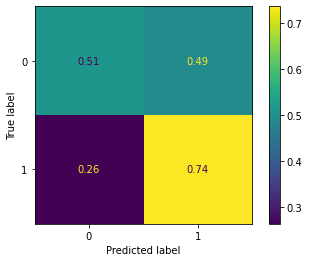

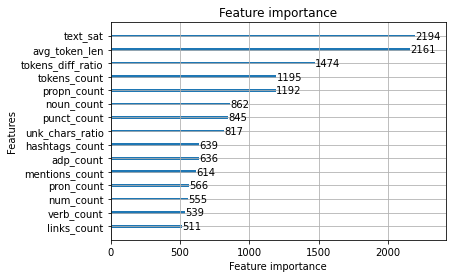

In [49]:
eval_clf(clf_meta_tweet_fe, df_test_meta_tweet_fe)

### Average probas at the user level

In [50]:
df_train_meta_agg_tweet_fe, df_test_meta_agg_tweet_fe = get_agg(clf_meta_tweet_fe, 
                                                                df_train_meta_tweet_fe, 
                                                                df_test_meta_tweet_fe, 
                                                                df_train['id'], 
                                                                df_test['id'])
clf_meta_agg_tweet_fe = get_best_clf(df_train_meta_agg_tweet_fe)

[I 2022-03-29 17:37:23,488] A new study created in memory with name: no-name-5c63b22a-e9db-48c7-9ba4-9ad81a5407c3


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds



Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:23,990] Trial 2 finished with value: 0.8167014440518816 and parameters: {'lambda_l1': 0.7921193869148032, 'lambda_l2': 0.012415788105518176, 'num_leaves': 15, 'feature_fraction': 0.8466429798159694, 'bagging_fraction': 0.9574049766478953, 'bagging_freq': 4, 'learning_rate': 0.04754307555146218, 'min_child_samples': 44}. Best is trial 2 with value: 0.8167014440518816.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.903327
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.897068


[I 2022-03-29 17:37:24,178] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 0.0002103261641511578, 'lambda_l2': 6.46001107439563, 'num_leaves': 119, 'feature_fraction': 0.4611601624387322, 'bagging_fraction': 0.6639384576652723, 'bagging_freq': 6, 'learning_rate': 1.612666790268398e-05, 'min_child_samples': 31}. Best is trial 2 with value: 0.8167014440518816.
[I 2022-03-29 17:37:24,272] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 3.627479885442273e-08, 'lambda_l2': 7.565361989018719e-06, 'num_leaves': 223, 'feature_fraction': 0.44482520022173005, 'bagging_fraction': 0.7275097870816291, 'bagging_freq': 5, 'learning_rate': 2.1445702654525732e-05, 'min_child_samples': 99}. Best is trial 2 with value: 0.8167014440518816.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.899145
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.901166
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.900047


[I 2022-03-29 17:37:24,382] Trial 1 finished with value: 0.6568539112702441 and parameters: {'lambda_l1': 0.0006363388652089502, 'lambda_l2': 6.143447221464025e-08, 'num_leaves': 213, 'feature_fraction': 0.9985162929845935, 'bagging_fraction': 0.7196092670056593, 'bagging_freq': 2, 'learning_rate': 0.001723453153658218, 'min_child_samples': 81}. Best is trial 2 with value: 0.8167014440518816.
[I 2022-03-29 17:37:24,398] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 3.5522970507971684e-07, 'lambda_l2': 0.0001063625843321, 'num_leaves': 153, 'feature_fraction': 0.5870273096039151, 'bagging_fraction': 0.46990998666307143, 'bagging_freq': 2, 'learning_rate': 4.6833875391203594e-05, 'min_child_samples': 52}. Best is trial 2 with value: 0.8167014440518816.
[I 2022-03-29 17:37:24,413] Trial 4 finished with value: 0.8009982690346905 and parameters: {'lambda_l1': 0.16813335444970953, 'lambda_l2': 3.4031670261831386e-06, 'num_leaves': 70, 'feature_fraction': 0.9778339489176611, 

Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.900769
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:24,602] Trial 9 finished with value: 0.8057821354895313 and parameters: {'lambda_l1': 6.515067984960716e-07, 'lambda_l2': 3.3763546706513368, 'num_leaves': 119, 'feature_fraction': 0.5295311361283221, 'bagging_fraction': 0.5116054001650873, 'bagging_freq': 4, 'learning_rate': 0.006430356960496765, 'min_child_samples': 95}. Best is trial 2 with value: 0.8167014440518816.
[I 2022-03-29 17:37:24,633] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 0.015135329495530248, 'lambda_l2': 0.0034131029647626317, 'num_leaves': 123, 'feature_fraction': 0.693734366364314, 'bagging_fraction': 0.4531207053001013, 'bagging_freq': 3, 'learning_rate': 0.0002782527591568027, 'min_child_samples': 70}. Best is trial 2 with value: 0.8167014440518816.
[I 2022-03-29 17:37:24,743] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 6.520077205475175, 'lambda_l2': 1.1577331693173846e-05, 'num_leaves': 181, 'feature_fraction': 0.6123169687157363, 'bagging_fraction': 

Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.899344
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.902187
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.89556
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:25,009] Trial 11 finished with value: 0.8192356484006356 and parameters: {'lambda_l1': 8.458468173801798e-05, 'lambda_l2': 0.0034965126787641133, 'num_leaves': 116, 'feature_fraction': 0.47631941008968304, 'bagging_fraction': 0.5490222673530446, 'bagging_freq': 5, 'learning_rate': 0.02655129096412478, 'min_child_samples': 96}. Best is trial 11 with value: 0.8192356484006356.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.901135
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:25,276] Trial 15 finished with value: 0.8170778697270765 and parameters: {'lambda_l1': 0.015045513488153613, 'lambda_l2': 4.9395337186328355e-05, 'num_leaves': 95, 'feature_fraction': 0.9003176944227946, 'bagging_fraction': 0.44578347615387753, 'bagging_freq': 7, 'learning_rate': 0.0966099633683853, 'min_child_samples': 88}. Best is trial 11 with value: 0.8192356484006356.
[I 2022-03-29 17:37:25,417] Trial 13 finished with value: 0.8038585113698338 and parameters: {'lambda_l1': 0.013638277106763314, 'lambda_l2': 1.3124682177106748e-05, 'num_leaves': 119, 'feature_fraction': 0.5639617920159199, 'bagging_fraction': 0.813180857119544, 'bagging_freq': 4, 'learning_rate': 0.006000799348788568, 'min_child_samples': 83}. Best is trial 11 with value: 0.8192356484006356.


Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.899011
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.899144


[I 2022-03-29 17:37:25,637] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 1.712535117988847, 'lambda_l2': 1.0671200295333387e-05, 'num_leaves': 82, 'feature_fraction': 0.4000679653560854, 'bagging_fraction': 0.8236005543972826, 'bagging_freq': 4, 'learning_rate': 0.00011666706775642993, 'min_child_samples': 41}. Best is trial 11 with value: 0.8192356484006356.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.898023


[I 2022-03-29 17:37:25,735] Trial 7 finished with value: 0.8116389633177625 and parameters: {'lambda_l1': 0.00017188304696371287, 'lambda_l2': 1.2380045036463903e-07, 'num_leaves': 112, 'feature_fraction': 0.9323673684189318, 'bagging_fraction': 0.7061746801853883, 'bagging_freq': 3, 'learning_rate': 0.07928058678918534, 'min_child_samples': 26}. Best is trial 11 with value: 0.8192356484006356.
[I 2022-03-29 17:37:25,857] Trial 14 finished with value: 0.5 and parameters: {'lambda_l1': 1.2973644201153682e-06, 'lambda_l2': 1.1036170674875692e-06, 'num_leaves': 76, 'feature_fraction': 0.8999878168647824, 'bagging_fraction': 0.5068631345223031, 'bagging_freq': 3, 'learning_rate': 0.0005353326495815528, 'min_child_samples': 42}. Best is trial 11 with value: 0.8192356484006356.


Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.89687
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.902354
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.897274


[I 2022-03-29 17:37:25,951] Trial 10 finished with value: 0.8193838474853579 and parameters: {'lambda_l1': 0.00037835544749982987, 'lambda_l2': 0.12724570505560304, 'num_leaves': 71, 'feature_fraction': 0.43177418561412495, 'bagging_fraction': 0.9774637652610906, 'bagging_freq': 4, 'learning_rate': 0.1016930855455021, 'min_child_samples': 50}. Best is trial 10 with value: 0.8193838474853579.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:26,499] Trial 17 finished with value: 0.8150119744860456 and parameters: {'lambda_l1': 3.13083462226567e-05, 'lambda_l2': 0.06945152134766763, 'num_leaves': 63, 'feature_fraction': 0.7743586495392333, 'bagging_fraction': 0.593141666608554, 'bagging_freq': 7, 'learning_rate': 0.132519826476366, 'min_child_samples': 19}. Best is trial 10 with value: 0.8193838474853579.
[I 2022-03-29 17:37:26,656] Trial 6 finished with value: 0.8124777701372916 and parameters: {'lambda_l1': 0.0009722958925478093, 'lambda_l2': 6.540974719534559e-07, 'num_leaves': 163, 'feature_fraction': 0.4917436221111025, 'bagging_fraction': 0.4831113379578988, 'bagging_freq': 1, 'learning_rate': 0.026054371089996874, 'min_child_samples': 12}. Best is trial 10 with value: 0.8193838474853579.


Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.898209
Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.897068
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:26,813] Trial 18 finished with value: 0.8038140516444171 and parameters: {'lambda_l1': 8.29601679739762e-05, 'lambda_l2': 0.03170764330390749, 'num_leaves': 62, 'feature_fraction': 0.8236139650165597, 'bagging_fraction': 0.5659166654007027, 'bagging_freq': 7, 'learning_rate': 0.20408141042175837, 'min_child_samples': 8}. Best is trial 10 with value: 0.8193838474853579.
[I 2022-03-29 17:37:26,891] Trial 21 finished with value: 0.8076375880302563 and parameters: {'lambda_l1': 1.4935773672279958e-05, 'lambda_l2': 0.04503856590783673, 'num_leaves': 58, 'feature_fraction': 0.8028928222840976, 'bagging_fraction': 0.5723732010172835, 'bagging_freq': 7, 'learning_rate': 0.29657844048171284, 'min_child_samples': 69}. Best is trial 10 with value: 0.8193838474853579.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.892018
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.900229


[I 2022-03-29 17:37:26,985] Trial 23 finished with value: 0.8110224551253172 and parameters: {'lambda_l1': 6.737708701505815e-05, 'lambda_l2': 0.15895658272992877, 'num_leaves': 39, 'feature_fraction': 0.7549290367824983, 'bagging_fraction': 0.9764889874491202, 'bagging_freq': 6, 'learning_rate': 0.28811267698960163, 'min_child_samples': 6}. Best is trial 10 with value: 0.8193838474853579.
[I 2022-03-29 17:37:27,038] Trial 22 finished with value: 0.8209132620396936 and parameters: {'lambda_l1': 1.8066683069392576e-05, 'lambda_l2': 0.05609903183077099, 'num_leaves': 47, 'feature_fraction': 0.78955406362734, 'bagging_fraction': 0.57434114744606, 'bagging_freq': 7, 'learning_rate': 0.25548160321020474, 'min_child_samples': 69}. Best is trial 22 with value: 0.8209132620396936.
[I 2022-03-29 17:37:27,142] Trial 19 finished with value: 0.8087965048727858 and parameters: {'lambda_l1': 3.685988672948576e-05, 'lambda_l2': 0.04643300716156509, 'num_leaves': 63, 'feature_fraction': 0.809325158556

Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.898756
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.897983
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.889732


[I 2022-03-29 17:37:27,283] Trial 20 finished with value: 0.8013598748014134 and parameters: {'lambda_l1': 6.612350530153242e-05, 'lambda_l2': 0.053677987987100634, 'num_leaves': 60, 'feature_fraction': 0.863478531371675, 'bagging_fraction': 0.5615851086497565, 'bagging_freq': 7, 'learning_rate': 0.15823258415731595, 'min_child_samples': 11}. Best is trial 22 with value: 0.8209132620396936.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.897467
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 17:37:27,519] Trial 30 finished with value: 0.8182367865696061 and parameters: {'lambda_l1': 3.1899109338775718e-06, 'lambda_l2': 0.0019291499866910438, 'num_leaves': 5, 'feature_fraction': 0.6531829757873966, 'bagging_fraction': 0.9056312459754163, 'bagging_freq': 5, 'learning_rate': 0.024169583805256405, 'min_child_samples': 66}. Best is trial 22 with value: 0.8209132620396936.



Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.900459


[I 2022-03-29 17:37:27,628] Trial 25 finished with value: 0.8147096483532118 and parameters: {'lambda_l1': 1.1526835729573791e-05, 'lambda_l2': 0.35735113688360964, 'num_leaves': 24, 'feature_fraction': 0.661623853325812, 'bagging_fraction': 0.9819093608787812, 'bagging_freq': 5, 'learning_rate': 0.24704167292707935, 'min_child_samples': 69}. Best is trial 22 with value: 0.8209132620396936.
[I 2022-03-29 17:37:27,723] Trial 24 finished with value: 0.8174661513290494 and parameters: {'lambda_l1': 6.750523593221397e-06, 'lambda_l2': 0.1618358069551149, 'num_leaves': 33, 'feature_fraction': 0.6678297100483181, 'bagging_fraction': 0.9678328150631254, 'bagging_freq': 6, 'learning_rate': 0.02432148455892712, 'min_child_samples': 5}. Best is trial 22 with value: 0.8209132620396936.


Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.902624
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.902893
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:27,839] Trial 31 finished with value: 0.8195379745334693 and parameters: {'lambda_l1': 4.924233587120399e-06, 'lambda_l2': 0.0012766029381536266, 'num_leaves': 8, 'feature_fraction': 0.6502945491065266, 'bagging_fraction': 0.4039353901090238, 'bagging_freq': 5, 'learning_rate': 0.017773190008969122, 'min_child_samples': 59}. Best is trial 22 with value: 0.8209132620396936.
[I 2022-03-29 17:37:27,926] Trial 26 finished with value: 0.8157025822208522 and parameters: {'lambda_l1': 4.466466179720031e-06, 'lambda_l2': 0.24630702450846906, 'num_leaves': 20, 'feature_fraction': 0.663744900683699, 'bagging_fraction': 0.9769161321928044, 'bagging_freq': 5, 'learning_rate': 0.018889739288704653, 'min_child_samples': 66}. Best is trial 22 with value: 0.8209132620396936.
[I 2022-03-29 17:37:27,926] Trial 27 finished with value: 0.8161649633651863 and parameters: {'lambda_l1': 6.548079984630538e-06, 'lambda_l2': 0.0010801906835421534, 'num_leaves': 20, 'feature_fraction': 0.6418

Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.901331
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.902256
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.903189
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:28,099] Trial 28 finished with value: 0.8173861238232992 and parameters: {'lambda_l1': 0.0071695307547228965, 'lambda_l2': 0.0008167846572017069, 'num_leaves': 91, 'feature_fraction': 0.6647017542988888, 'bagging_fraction': 0.4055283877832482, 'bagging_freq': 5, 'learning_rate': 0.017630859973509553, 'min_child_samples': 65}. Best is trial 22 with value: 0.8209132620396936.
[I 2022-03-29 17:37:28,193] Trial 29 finished with value: 0.8192297204372465 and parameters: {'lambda_l1': 5.467357836794252e-06, 'lambda_l2': 0.0006912128544442085, 'num_leaves': 37, 'feature_fraction': 0.6915569147692386, 'bagging_fraction': 0.4073131350456047, 'bagging_freq': 5, 'learning_rate': 0.02341454179896197, 'min_child_samples': 64}. Best is trial 22 with value: 0.8209132620396936.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.903524
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.9041
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:28,340] Trial 35 finished with value: 0.8259935266639793 and parameters: {'lambda_l1': 1.4978189084134076e-07, 'lambda_l2': 0.0008558226367927883, 'num_leaves': 2, 'feature_fraction': 0.7192598805556155, 'bagging_fraction': 0.41946954829567085, 'bagging_freq': 6, 'learning_rate': 0.06521822814454267, 'min_child_samples': 57}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.902029
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:28,541] Trial 32 finished with value: 0.819457947027719 and parameters: {'lambda_l1': 0.0025086282643584207, 'lambda_l2': 0.6084090317264041, 'num_leaves': 34, 'feature_fraction': 0.7226950011858028, 'bagging_fraction': 0.4116608231586393, 'bagging_freq': 5, 'learning_rate': 0.018149455965319326, 'min_child_samples': 59}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:28,648] Trial 33 finished with value: 0.8179226045099948 and parameters: {'lambda_l1': 0.0020457330323997163, 'lambda_l2': 0.7459528525446738, 'num_leaves': 37, 'feature_fraction': 0.40043176431971117, 'bagging_fraction': 0.4090003692908843, 'bagging_freq': 6, 'learning_rate': 0.018783269280258884, 'min_child_samples': 59}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.903566
Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.900687
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.90369


[I 2022-03-29 17:37:28,742] Trial 40 finished with value: 0.8186991677139401 and parameters: {'lambda_l1': 9.693253119316358e-08, 'lambda_l2': 0.0001532018712205195, 'num_leaves': 4, 'feature_fraction': 0.7403508584568064, 'bagging_fraction': 0.42783669796081897, 'bagging_freq': 6, 'learning_rate': 0.06607265390376835, 'min_child_samples': 54}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:28,883] Trial 34 finished with value: 0.8188355108718848 and parameters: {'lambda_l1': 0.0016146271565765878, 'lambda_l2': 0.9685514238575271, 'num_leaves': 145, 'feature_fraction': 0.41087406696339673, 'bagging_fraction': 0.6556020547373125, 'bagging_freq': 5, 'learning_rate': 0.012911583746268055, 'min_child_samples': 59}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.899622


[I 2022-03-29 17:37:29,040] Trial 42 finished with value: 0.8209251179664715 and parameters: {'lambda_l1': 7.504676502747014e-08, 'lambda_l2': 1.377900407210168, 'num_leaves': 3, 'feature_fraction': 0.736797963626045, 'bagging_fraction': 0.4661204837027328, 'bagging_freq': 6, 'learning_rate': 0.05311638685139939, 'min_child_samples': 77}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:29,118] Trial 36 finished with value: 0.8122495435468191 and parameters: {'lambda_l1': 2.9794879283027726e-08, 'lambda_l2': 0.0002498551320315252, 'num_leaves': 42, 'feature_fraction': 0.7300594089552299, 'bagging_fraction': 0.4084842431835148, 'bagging_freq': 6, 'learning_rate': 0.062144943297693815, 'min_child_samples': 56}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.902418
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.902558
Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.903068
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 17:37:29,212] Trial 37 finished with value: 0.8231392122922249 and parameters: {'lambda_l1': 5.7015078243213636e-08, 'lambda_l2': 0.00024544087156711084, 'num_leaves': 43, 'feature_fraction': 0.7105205352238603, 'bagging_fraction': 0.4081734629228656, 'bagging_freq': 6, 'learning_rate': 0.059059451526334066, 'min_child_samples': 55}. Best is trial 35 with value: 0.8259935266639793.



Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:29,510] Trial 39 finished with value: 0.8157025822208522 and parameters: {'lambda_l1': 1.3944642395942505e-07, 'lambda_l2': 0.0001626918182625054, 'num_leaves': 141, 'feature_fraction': 0.7381784245388523, 'bagging_fraction': 0.6414419654304069, 'bagging_freq': 6, 'learning_rate': 0.05818779353485036, 'min_child_samples': 56}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:29,589] Trial 41 finished with value: 0.8186132122448012 and parameters: {'lambda_l1': 6.836640118406245e-08, 'lambda_l2': 0.00017431423137276525, 'num_leaves': 254, 'feature_fraction': 0.7390473715848649, 'bagging_fraction': 0.40126977390470353, 'bagging_freq': 6, 'learning_rate': 0.05540071714086437, 'min_child_samples': 56}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.901803
Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.902704
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.903817


[I 2022-03-29 17:37:29,683] Trial 43 finished with value: 0.8169978422213264 and parameters: {'lambda_l1': 1.286439683249687e-08, 'lambda_l2': 0.011580538504087136, 'num_leaves': 245, 'feature_fraction': 0.7285870277431984, 'bagging_fraction': 0.4807501826281984, 'bagging_freq': 6, 'learning_rate': 0.011082152724011678, 'min_child_samples': 79}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:29,777] Trial 46 finished with value: 0.6830229056505348 and parameters: {'lambda_l1': 1.304691852030198e-07, 'lambda_l2': 0.010723466665475646, 'num_leaves': 12, 'feature_fraction': 0.6067806408023775, 'bagging_fraction': 0.4755086166896414, 'bagging_freq': 6, 'learning_rate': 0.0026961911630021982, 'min_child_samples': 76}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:29,793] Trial 38 finished with value: 0.8142472672088777 and parameters: {'lambda_l1': 9.050509415249686e-08, 'lambda_l2': 0.00021297308477668915, 'num_leaves': 145, 'feature_fraction': 

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.901713
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.899327
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.901878
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:29,950] Trial 44 finished with value: 0.7033587840561497 and parameters: {'lambda_l1': 2.0444556154966387e-07, 'lambda_l2': 0.012085472591279215, 'num_leaves': 43, 'feature_fraction': 0.7242600510635079, 'bagging_fraction': 0.4861087587541886, 'bagging_freq': 6, 'learning_rate': 0.0019484470673119133, 'min_child_samples': 77}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:30,075] Trial 45 finished with value: 0.8183108861119672 and parameters: {'lambda_l1': 2.2231013752723716e-08, 'lambda_l2': 0.008829781968803987, 'num_leaves': 256, 'feature_fraction': 0.6112097236830286, 'bagging_fraction': 0.47827788088935996, 'bagging_freq': 6, 'learning_rate': 0.05106537023871662, 'min_child_samples': 76}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.901922
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.903061
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.901734


[I 2022-03-29 17:37:30,184] Trial 48 finished with value: 0.817780333388661 and parameters: {'lambda_l1': 2.133071755319185e-07, 'lambda_l2': 0.00716864474187226, 'num_leaves': 3, 'feature_fraction': 0.7811961577718375, 'bagging_fraction': 0.47416004306616427, 'bagging_freq': 6, 'learning_rate': 0.042883210223904206, 'min_child_samples': 78}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:30,247] Trial 47 finished with value: 0.7061212149953762 and parameters: {'lambda_l1': 1.0178874520182245e-08, 'lambda_l2': 0.01532258909623455, 'num_leaves': 50, 'feature_fraction': 0.7762015949696943, 'bagging_fraction': 0.48029157746849366, 'bagging_freq': 6, 'learning_rate': 0.0020798605532559794, 'min_child_samples': 76}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:30,373] Trial 49 finished with value: 0.815246129039907 and parameters: {'lambda_l1': 3.1535243232774834e-07, 'lambda_l2': 0.007820167308246745, 'num_leaves': 3, 'feature_fraction': 0.7771

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.890973
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:30,467] Trial 51 finished with value: 0.8178662888578 and parameters: {'lambda_l1': 4.4376835500455516e-07, 'lambda_l2': 3.1629780266002347, 'num_leaves': 2, 'feature_fraction': 0.6991450974918094, 'bagging_fraction': 0.5210969758547844, 'bagging_freq': 7, 'learning_rate': 0.04055864308742418, 'min_child_samples': 48}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:30,561] Trial 52 finished with value: 0.8187791952196903 and parameters: {'lambda_l1': 4.1263667459974546e-07, 'lambda_l2': 4.1166856505877946e-05, 'num_leaves': 3, 'feature_fraction': 0.7790891530844398, 'bagging_fraction': 0.5189992480947236, 'bagging_freq': 7, 'learning_rate': 0.0395636713039002, 'min_child_samples': 48}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.899716
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.901531
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.899342
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.902798
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 17:37:30,623] Trial 53 finished with value: 0.819093377279302 and parameters: {'lambda_l1': 6.03489347693833e-07, 'lambda_l2': 3.2208791721222307, 'num_leaves': 2, 'feature_fraction': 0.7691829026248826, 'bagging_fraction': 0.5220610974003024, 'bagging_freq': 7, 'learning_rate': 0.04174197207873051, 'min_child_samples': 50}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:30,717] Trial 50 finished with value: 0.8256793446043678 and parameters: {'lambda_l1': 3.3498288859069324e-07, 'lambda_l2': 0.011459063599316456, 'num_leaves': 9, 'feature_fraction': 0.6127637681236133, 'bagging_fraction': 0.5157930250936142, 'bagging_freq': 7, 'learning_rate': 0.03895660721170735, 'min_child_samples': 74}. Best is trial 35 with value: 0.8259935266639793.



Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.903076


[I 2022-03-29 17:37:30,845] Trial 54 finished with value: 0.8192297204372465 and parameters: {'lambda_l1': 6.122151284289594e-07, 'lambda_l2': 4.5203461216565286e-05, 'num_leaves': 3, 'feature_fraction': 0.7859406684422969, 'bagging_fraction': 0.5306901136349957, 'bagging_freq': 7, 'learning_rate': 0.15188916910584807, 'min_child_samples': 49}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:31,188] Trial 55 finished with value: 0.8067750693571717 and parameters: {'lambda_l1': 6.253623110247563e-07, 'lambda_l2': 5.767181823804259, 'num_leaves': 51, 'feature_fraction': 0.5606080959934492, 'bagging_fraction': 0.5219829074806938, 'bagging_freq': 1, 'learning_rate': 0.0069187333861247795, 'min_child_samples': 47}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:31,322] Trial 56 finished with value: 0.8060400018969482 and parameters: {'lambda_l1': 6.724892914554467e-07, 'lambda_l2': 4.425753746421238e-05, 'num_leaves': 26, 'feature_fraction': 0.6966265351976824, 'bagging_fraction': 0.524858488545169, 'bagging_freq': 7, 'learning_rate': 0.1373373300913953, 'min_child_samples': 49}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.899161
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.898525


[I 2022-03-29 17:37:31,510] Trial 57 finished with value: 0.8140990681241552 and parameters: {'lambda_l1': 1.0728396644611402e-06, 'lambda_l2': 3.997311093039444e-05, 'num_leaves': 26, 'feature_fraction': 0.5447635101572582, 'bagging_fraction': 0.5278989624054725, 'bagging_freq': 1, 'learning_rate': 0.12782961795585596, 'min_child_samples': 47}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:31,634] Trial 58 finished with value: 0.8157766817632134 and parameters: {'lambda_l1': 8.606827245779564e-07, 'lambda_l2': 1.8766919596025042, 'num_leaves': 28, 'feature_fraction': 0.694269618578637, 'bagging_fraction': 0.4455036229255019, 'bagging_freq': 1, 'learning_rate': 0.1388873705437647, 'min_child_samples': 50}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.898758
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.90223
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:31,881] Trial 60 finished with value: 0.8259075711948403 and parameters: {'lambda_l1': 1.08466574071524e-06, 'lambda_l2': 1.2367529925814806, 'num_leaves': 28, 'feature_fraction': 0.5688183653860032, 'bagging_fraction': 0.4440812985717676, 'bagging_freq': 1, 'learning_rate': 0.1387211951625935, 'min_child_samples': 87}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.901539
Did not meet early stopping. Best iteration is:
[40]	valid_0's auc: 0.900487
Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.901545


[I 2022-03-29 17:37:31,961] Trial 61 finished with value: 0.816473217461409 and parameters: {'lambda_l1': 1.4661750281909372e-06, 'lambda_l2': 0.00273856623180341, 'num_leaves': 23, 'feature_fraction': 0.5660554383841715, 'bagging_fraction': 0.44238866866211907, 'bagging_freq': 7, 'learning_rate': 0.1301612517839316, 'min_child_samples': 88}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:31,996] Trial 59 finished with value: 0.8190014938467739 and parameters: {'lambda_l1': 1.3406937061327396e-06, 'lambda_l2': 9.374287914065825, 'num_leaves': 27, 'feature_fraction': 0.8553179060621855, 'bagging_fraction': 0.4449887418475593, 'bagging_freq': 4, 'learning_rate': 0.13487616177022374, 'min_child_samples': 36}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:32,204] Trial 62 finished with value: 0.8014606501790245 and parameters: {'lambda_l1': 1.8984383486705038e-06, 'lambda_l2': 0.0030162033222663593, 'num_leaves': 23, 'feature_fraction': 0.635215

Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.902551
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's auc: 0.90297


[I 2022-03-29 17:37:32,572] Trial 64 finished with value: 0.8126318971854031 and parameters: {'lambda_l1': 2.1677298666837302e-06, 'lambda_l2': 0.002016648358828672, 'num_leaves': 15, 'feature_fraction': 0.6337078755584862, 'bagging_fraction': 0.44282642152664375, 'bagging_freq': 7, 'learning_rate': 0.11411538980486903, 'min_child_samples': 71}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:32,733] Trial 65 finished with value: 0.8130201787873758 and parameters: {'lambda_l1': 2.3488043874755253e-06, 'lambda_l2': 0.0004819928270500808, 'num_leaves': 15, 'feature_fraction': 0.6323523835753652, 'bagging_fraction': 0.4439008750633409, 'bagging_freq': 2, 'learning_rate': 0.09907510209448327, 'min_child_samples': 38}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:32,811] Trial 63 finished with value: 0.8172201408484101 and parameters: {'lambda_l1': 1.0432719790868752e-06, 'lambda_l2': 0.001492862091922806, 'num_leaves': 27, 'feature_fraction': 0.

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.901346
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.900322
Did not meet early stopping. Best iteration is:
[38]	valid_0's auc: 0.902901


[I 2022-03-29 17:37:32,939] Trial 66 finished with value: 0.8187732672563015 and parameters: {'lambda_l1': 2.5903923641172396e-06, 'lambda_l2': 0.0004982647756935435, 'num_leaves': 15, 'feature_fraction': 0.6304275104916319, 'bagging_fraction': 0.5976675196826504, 'bagging_freq': 2, 'learning_rate': 0.10178520499199159, 'min_child_samples': 36}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:33,246] Trial 69 finished with value: 0.8190014938467739 and parameters: {'lambda_l1': 3.0723655604217017e-06, 'lambda_l2': 0.00045820856740269404, 'num_leaves': 13, 'feature_fraction': 0.4964097380364698, 'bagging_fraction': 0.5890810641100458, 'bagging_freq': 4, 'learning_rate': 0.08319452942792586, 'min_child_samples': 72}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:33,359] Trial 68 finished with value: 0.8133225049202096 and parameters: {'lambda_l1': 1.8551738517316755e-06, 'lambda_l2': 0.000631604452813943, 'num_leaves': 14, 'feature_fraction': 0.6278869573551995, 'bagging_fraction': 0.6002651297467695, 'bagging_freq': 2, 'learning_rate': 0.09532625502694667, 'min_child_samples': 83}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.903939
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.903091
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.899447
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:33,433] Trial 70 finished with value: 0.5 and parameters: {'lambda_l1': 3.737806167644325e-08, 'lambda_l2': 0.0006519971507923539, 'num_leaves': 15, 'feature_fraction': 0.585115502457426, 'bagging_fraction': 0.4330812662404741, 'bagging_freq': 4, 'learning_rate': 1.033485154580512e-05, 'min_child_samples': 83}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:33,635] Trial 67 finished with value: 0.8145495933417115 and parameters: {'lambda_l1': 2.7255635738268135e-06, 'lambda_l2': 0.0034820720208645303, 'num_leaves': 186, 'feature_fraction': 0.4983673621389824, 'bagging_fraction': 0.4421250313867247, 'bagging_freq': 2, 'learning_rate': 0.20064473894013002, 'min_child_samples': 72}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.898917
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:34,043] Trial 74 finished with value: 0.811404808763901 and parameters: {'lambda_l1': 5.2104729619877695e-08, 'lambda_l2': 0.025469687829096074, 'num_leaves': 183, 'feature_fraction': 0.5927014110073047, 'bagging_fraction': 0.4243269566335335, 'bagging_freq': 3, 'learning_rate': 0.1990085855652753, 'min_child_samples': 82}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:34,155] Trial 71 finished with value: 0.8117130628601238 and parameters: {'lambda_l1': 3.9865321646761714e-08, 'lambda_l2': 0.00047241319508213, 'num_leaves': 191, 'feature_fraction': 0.8151937086810721, 'bagging_fraction': 0.6053963778968865, 'bagging_freq': 2, 'learning_rate': 0.08430298765813081, 'min_child_samples': 73}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.899992
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.901584
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.897892
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.901528

[I 2022-03-29 17:37:34,266] Trial 73 finished with value: 0.8142472672088777 and parameters: {'lambda_l1': 4.9018814281921924e-08, 'lambda_l2': 0.02070690904132656, 'num_leaves': 188, 'feature_fraction': 0.5025956818877886, 'bagging_fraction': 0.5918992865721278, 'bagging_freq': 3, 'learning_rate': 0.2224445234505647, 'min_child_samples': 87}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:34,304] Trial 72 finished with value: 0.8110046712351504 and parameters: {'lambda_l1': 5.158961124237593e-08, 'lambda_l2': 0.023296327056896517, 'num_leaves': 190, 'feature_fraction': 0.8369906577578439, 'bagging_fraction': 0.49462199352671987, 'bagging_freq': 3, 'learning_rate': 0.18457805029250413, 'min_child_samples': 72}. Best is trial 35 with value: 0.8259935266639793.



Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.902267
Did not meet early stopping. Best iteration is:
[24]	valid_0's auc: 0.900929
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.902288


[I 2022-03-29 17:37:34,458] Trial 75 finished with value: 0.8203026818106371 and parameters: {'lambda_l1': 5.016117629816883e-08, 'lambda_l2': 0.09284081718932347, 'num_leaves': 49, 'feature_fraction': 0.5901689720470948, 'bagging_fraction': 0.49639966131116897, 'bagging_freq': 3, 'learning_rate': 0.20452640198739402, 'min_child_samples': 83}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:34,487] Trial 77 finished with value: 0.5 and parameters: {'lambda_l1': 1.6796846285591237e-05, 'lambda_l2': 0.02353036197540821, 'num_leaves': 185, 'feature_fraction': 0.6774715559462631, 'bagging_fraction': 0.5025029864140663, 'bagging_freq': 3, 'learning_rate': 0.001152836498576171, 'min_child_samples': 100}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:34,521] Trial 76 finished with value: 0.8223804329784459 and parameters: {'lambda_l1': 5.277857290851766e-08, 'lambda_l2': 0.025412681262313573, 'num_leaves': 52, 'feature_fraction': 0.5960566081940527,

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.903427

[I 2022-03-29 17:37:34,814] Trial 78 finished with value: 0.8212956156782776 and parameters: {'lambda_l1': 0.0005406032335169948, 'lambda_l2': 0.3327165999147222, 'num_leaves': 49, 'feature_fraction': 0.6775747022804816, 'bagging_fraction': 0.502201077970452, 'bagging_freq': 3, 'learning_rate': 0.012976425914625056, 'min_child_samples': 59}. Best is trial 35 with value: 0.8259935266639793.



Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:35,160] Trial 79 finished with value: 0.8163131624499088 and parameters: {'lambda_l1': 1.4764416592682466e-05, 'lambda_l2': 0.5587409945644779, 'num_leaves': 51, 'feature_fraction': 0.7088653935593533, 'bagging_fraction': 0.4177073950181906, 'bagging_freq': 5, 'learning_rate': 0.03135850072373414, 'min_child_samples': 62}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:35,315] Trial 82 finished with value: 0.5 and parameters: {'lambda_l1': 0.13319282531486168, 'lambda_l2': 0.39065718077399225, 'num_leaves': 50, 'feature_fraction': 0.6795805142773041, 'bagging_fraction': 0.4192833448102238, 'bagging_freq': 5, 'learning_rate': 4.5539955214702027e-05, 'min_child_samples': 94}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.904017
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.901033


[I 2022-03-29 17:37:35,422] Trial 80 finished with value: 0.8185272567756622 and parameters: {'lambda_l1': 0.0005803327266663495, 'lambda_l2': 0.4973130968173505, 'num_leaves': 47, 'feature_fraction': 0.6777719543883352, 'bagging_fraction': 0.4993233423116962, 'bagging_freq': 5, 'learning_rate': 0.03442084144972026, 'min_child_samples': 61}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.903171
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.903393

[I 2022-03-29 17:37:35,629] Trial 81 finished with value: 0.8131743058354871 and parameters: {'lambda_l1': 0.0003198584381653682, 'lambda_l2': 0.7500071525968194, 'num_leaves': 52, 'feature_fraction': 0.6777890071735783, 'bagging_fraction': 0.5004143935780501, 'bagging_freq': 5, 'learning_rate': 0.03175490475502033, 'min_child_samples': 61}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:35,734] Trial 84 finished with value: 0.5 and parameters: {'lambda_l1': 1.723963947943358e-08, 'lambda_l2': 0.07625619198834391, 'num_leaves': 73, 'feature_fraction': 0.539348323374152, 'bagging_fraction': 0.5466413116660832, 'bagging_freq': 3, 'learning_rate': 6.660123096368731e-05, 'min_child_samples': 94}. Best is trial 35 with value: 0.8259935266639793.



Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.8995
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.90333
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.902027
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:35,822] Trial 85 finished with value: 0.8189273943044126 and parameters: {'lambda_l1': 1.769575147901629e-08, 'lambda_l2': 0.08673035631441088, 'num_leaves': 75, 'feature_fraction': 0.5240871336335499, 'bagging_fraction': 0.5465828625319052, 'bagging_freq': 3, 'learning_rate': 0.031044369166299227, 'min_child_samples': 91}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:35,826] Trial 83 finished with value: 0.8193838474853579 and parameters: {'lambda_l1': 1.3807289579738633e-05, 'lambda_l2': 0.11676384871321828, 'num_leaves': 71, 'feature_fraction': 0.7547131023846441, 'bagging_fraction': 0.5484095158523536, 'bagging_freq': 3, 'learning_rate': 0.033374363060548404, 'min_child_samples': 93}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:36,012] Trial 86 finished with value: 0.819007421810163 and parameters: {'lambda_l1': 0.00020574579714245522, 'lambda_l2': 0.26233664389077055, 'num_leaves': 70, 'feature_fraction': 0.52205

Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.902542
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:36,299] Trial 87 finished with value: 0.8137848860645438 and parameters: {'lambda_l1': 0.00044171044984573667, 'lambda_l2': 0.22801074611754055, 'num_leaves': 71, 'feature_fraction': 0.6769984887258209, 'bagging_fraction': 0.5480040360394379, 'bagging_freq': 4, 'learning_rate': 0.032969527815018086, 'min_child_samples': 90}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.904108


[I 2022-03-29 17:37:36,411] Trial 88 finished with value: 0.8156966542574633 and parameters: {'lambda_l1': 0.00017190612320372027, 'lambda_l2': 0.1507309374367321, 'num_leaves': 75, 'feature_fraction': 0.7536734002981791, 'bagging_fraction': 0.46115012005972067, 'bagging_freq': 3, 'learning_rate': 0.06284952645871665, 'min_child_samples': 93}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:36,528] Trial 89 finished with value: 0.8151720294975459 and parameters: {'lambda_l1': 2.0887076405242889e-07, 'lambda_l2': 0.0962836254142407, 'num_leaves': 77, 'feature_fraction': 0.5807622342412677, 'bagging_fraction': 0.45827634510227644, 'bagging_freq': 3, 'learning_rate': 0.06618636505535708, 'min_child_samples': 91}. Best is trial 35 with value: 0.8259935266639793.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.903402
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.901317
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:36,714] Trial 90 finished with value: 0.8136307590164323 and parameters: {'lambda_l1': 2.490241497556676e-08, 'lambda_l2': 0.09482469087182513, 'num_leaves': 70, 'feature_fraction': 0.5851604823588158, 'bagging_fraction': 0.46483814751695457, 'bagging_freq': 3, 'learning_rate': 0.06856494126146039, 'min_child_samples': 92}. Best is trial 35 with value: 0.8259935266639793.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.902414
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:36,894] Trial 91 finished with value: 0.8162449908709364 and parameters: {'lambda_l1': 0.00014335612929854857, 'lambda_l2': 1.5771181777269019, 'num_leaves': 80, 'feature_fraction': 0.5904255267051626, 'bagging_fraction': 0.4628597393485832, 'bagging_freq': 3, 'learning_rate': 0.06449702216856554, 'min_child_samples': 97}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:37,013] Trial 93 finished with value: 0.8253651625447561 and parameters: {'lambda_l1': 1.7479996130417244e-07, 'lambda_l2': 0.2742599036111871, 'num_leaves': 110, 'feature_fraction': 0.5966238737303109, 'bagging_fraction': 0.4642492559797849, 'bagging_freq': 4, 'learning_rate': 0.06705780995917097, 'min_child_samples': 97}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:37,051] Trial 92 finished with value: 0.8197721290873309 and parameters: {'lambda_l1': 0.00016502439523945173, 'lambda_l2': 1.1196411874146897, 'num_leaves': 97, 'feature_fraction': 0.5883387

Did not meet early stopping. Best iteration is:
[54]	valid_0's auc: 0.902005
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.901151
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.901796
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.90123


[I 2022-03-29 17:37:37,200] Trial 95 finished with value: 0.8157826097266023 and parameters: {'lambda_l1': 1.9106232040729986e-07, 'lambda_l2': 1.2100879444218504, 'num_leaves': 91, 'feature_fraction': 0.5865859450125825, 'bagging_fraction': 0.45441347841558555, 'bagging_freq': 4, 'learning_rate': 0.06332133520447569, 'min_child_samples': 86}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:37,229] Trial 96 finished with value: 0.8216779693168615 and parameters: {'lambda_l1': 2.2010746058995805e-07, 'lambda_l2': 2.237924062110202e-08, 'num_leaves': 107, 'feature_fraction': 0.5811880714017634, 'bagging_fraction': 0.46090467921098377, 'bagging_freq': 4, 'learning_rate': 0.012185006500352591, 'min_child_samples': 97}. Best is trial 35 with value: 0.8259935266639793.
[I 2022-03-29 17:37:37,277] Trial 97 finished with value: 0.8174602233656605 and parameters: {'lambda_l1': 1.1051560267257924e-07, 'lambda_l2': 1.4762062437077328, 'num_leaves': 88, 'feature_fraction': 0.5

Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.902132
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.900919
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.900652
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.902172
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.899537


[I 2022-03-29 17:37:37,386] Trial 98 finished with value: 0.8183790576909397 and parameters: {'lambda_l1': 1.753368153162128e-07, 'lambda_l2': 2.9736169917965508e-08, 'num_leaves': 33, 'feature_fraction': 0.6038967078334317, 'bagging_fraction': 0.724101048329927, 'bagging_freq': 6, 'learning_rate': 0.01584444744416439, 'min_child_samples': 53}. Best is trial 35 with value: 0.8259935266639793.


{'lambda_l1': 1.4978189084134076e-07, 'lambda_l2': 0.0008558226367927883, 'num_leaves': 2, 'feature_fraction': 0.7192598805556155, 'bagging_fraction': 0.41946954829567085, 'bagging_freq': 6, 'learning_rate': 0.06521822814454267, 'min_child_samples': 57} -> 0.8259935266639793
[LightGBM] [Warning] feature_fraction is set=0.7192598805556155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7192598805556155
[LightGBM] [Warning] lambda_l1 is set=1.4978189084134076e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4978189084134076e-07
[LightGBM] [Warning] bagging_fraction is set=0.41946954829567085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41946954829567085
[LightGBM] [Warning] lambda_l2 is set=0.0008558226367927883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008558226367927883
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores

AUROC: 0.7320240561694291
Accuracy: 0.7311918850380389


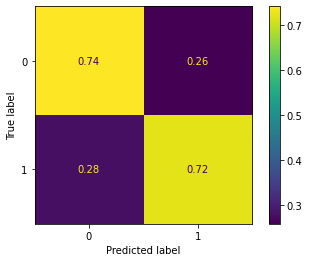

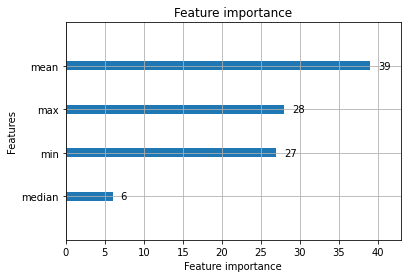

In [51]:
eval_clf(clf_meta_agg_tweet_fe, df_test_meta_agg_tweet_fe)

### Average features at the user level

> Mean

In [52]:
df_train_meta_tweet_fe_mean = get_mean(df_train_meta_tweet_fe, df_train['id'])
df_test_meta_tweet_fe_mean = get_mean(df_test_meta_tweet_fe, df_test['id'])

clf_meta_tweet_fe_mean = get_best_clf(df_train_meta_tweet_fe_mean)

[I 2022-03-29 17:37:38,737] A new study created in memory with name: no-name-4abc1a80-faec-4589-b966-7638eba33c44


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds


Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:39,783] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 0.5117744185078613, 'lambda_l2': 0.0005445870674583036, 'num_leaves': 135, 'feature_fraction': 0.8737339494905844, 'bagging_fraction': 0.4021166631975248, 'bagging_freq': 4, 'learning_rate': 0.00030234030840058584, 'min_child_samples': 75}. Best is trial 2 with value: 0.5.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.787109
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:40,281] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 4.052161602689612e-07, 'lambda_l2': 1.7012774689857764e-06, 'num_leaves': 43, 'feature_fraction': 0.6566504782596964, 'bagging_fraction': 0.41885084953408624, 'bagging_freq': 3, 'learning_rate': 0.0013804148278097727, 'min_child_samples': 41}. Best is trial 2 with value: 0.5.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.799995
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:40,500] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 9.912894471570818, 'lambda_l2': 0.003044234931418944, 'num_leaves': 242, 'feature_fraction': 0.7365215434295719, 'bagging_fraction': 0.7394468808821746, 'bagging_freq': 6, 'learning_rate': 1.2438840252970179e-05, 'min_child_samples': 40}. Best is trial 2 with value: 0.5.
[I 2022-03-29 17:37:40,633] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 2.1401735708199568e-07, 'lambda_l2': 5.423315301936599, 'num_leaves': 123, 'feature_fraction': 0.6736159183336354, 'bagging_fraction': 0.9632381704159128, 'bagging_freq': 1, 'learning_rate': 0.0009742999647437766, 'min_child_samples': 78}. Best is trial 2 with value: 0.5.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.788347
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.80086


[I 2022-03-29 17:37:40,785] Trial 1 finished with value: 0.6637155288928935 and parameters: {'lambda_l1': 0.08408029737348809, 'lambda_l2': 8.192333616806236e-08, 'num_leaves': 254, 'feature_fraction': 0.4877305072374777, 'bagging_fraction': 0.5395169126611723, 'bagging_freq': 4, 'learning_rate': 0.005649703274556463, 'min_child_samples': 47}. Best is trial 1 with value: 0.6637155288928935.
[I 2022-03-29 17:37:40,913] Trial 5 finished with value: 0.7615506366632679 and parameters: {'lambda_l1': 0.48322615281107556, 'lambda_l2': 9.284257529779762, 'num_leaves': 246, 'feature_fraction': 0.5768540441672537, 'bagging_fraction': 0.9786207122871116, 'bagging_freq': 5, 'learning_rate': 0.08189634276000674, 'min_child_samples': 73}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.806167
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.836874
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:41,347] Trial 6 finished with value: 0.5 and parameters: {'lambda_l1': 0.04854493123943419, 'lambda_l2': 4.51497672151757e-06, 'num_leaves': 225, 'feature_fraction': 0.4139182420126622, 'bagging_fraction': 0.7092311182353508, 'bagging_freq': 4, 'learning_rate': 0.0008166823787300278, 'min_child_samples': 47}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.804559
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:42,139] Trial 12 finished with value: 0.5 and parameters: {'lambda_l1': 1.9658691488282686e-06, 'lambda_l2': 0.009238847837273627, 'num_leaves': 132, 'feature_fraction': 0.44510300837756234, 'bagging_fraction': 0.6915516523360316, 'bagging_freq': 1, 'learning_rate': 0.0007884639555668595, 'min_child_samples': 99}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.787869
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:42,453] Trial 10 finished with value: 0.7379899461740924 and parameters: {'lambda_l1': 0.00011078781846250158, 'lambda_l2': 4.597333484581222e-08, 'num_leaves': 114, 'feature_fraction': 0.8457759542012571, 'bagging_fraction': 0.9305250587345921, 'bagging_freq': 7, 'learning_rate': 0.022056783022906885, 'min_child_samples': 98}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:42,579] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 3.0417680732881038e-05, 'lambda_l2': 0.0013205563716439767, 'num_leaves': 214, 'feature_fraction': 0.6446902819766493, 'bagging_fraction': 0.8219131444447694, 'bagging_freq': 3, 'learning_rate': 0.00023346058191724692, 'min_child_samples': 56}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.81988
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.808863
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:43,441] Trial 11 finished with value: 0.7336417850283355 and parameters: {'lambda_l1': 0.005039435807778696, 'lambda_l2': 0.8745984608749954, 'num_leaves': 254, 'feature_fraction': 0.41449221220411714, 'bagging_fraction': 0.588469826319608, 'bagging_freq': 1, 'learning_rate': 0.28798285081871666, 'min_child_samples': 39}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.810754
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.81603


[I 2022-03-29 17:37:43,629] Trial 14 finished with value: 0.7164773670357811 and parameters: {'lambda_l1': 0.002250999692690772, 'lambda_l2': 0.00086961560919568, 'num_leaves': 233, 'feature_fraction': 0.4127062697565919, 'bagging_fraction': 0.7659846189418835, 'bagging_freq': 7, 'learning_rate': 0.015977155458348855, 'min_child_samples': 67}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:44,273] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 0.00011432819461283515, 'lambda_l2': 3.0301815070659386e-07, 'num_leaves': 204, 'feature_fraction': 0.6003626071981308, 'bagging_fraction': 0.9048346955162524, 'bagging_freq': 1, 'learning_rate': 0.00010219318620327157, 'min_child_samples': 93}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:44,351] Trial 7 finished with value: 0.7425278021482938 and parameters: {'lambda_l1': 6.84931027023246e-07, 'lambda_l2': 8.393203372456687e-08, 'num_leaves': 130, 'feature_fraction': 0.6916165991381193, 'bagging_fraction': 0.5252114319407112, 'bagging_freq': 5, 'learning_rate': 0.16579628856647882, 'min_child_samples': 5}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.816298
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.798014
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:45,166] Trial 13 finished with value: 0.7326814549593341 and parameters: {'lambda_l1': 1.958562499149875e-05, 'lambda_l2': 1.587824011192164e-05, 'num_leaves': 98, 'feature_fraction': 0.5492961009655078, 'bagging_fraction': 0.9700958071958793, 'bagging_freq': 6, 'learning_rate': 0.020904765670029492, 'min_child_samples': 14}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.830081


[I 2022-03-29 17:37:45,495] Trial 16 finished with value: 0.7341664097882532 and parameters: {'lambda_l1': 0.00013877478824437213, 'lambda_l2': 0.1834402973258483, 'num_leaves': 176, 'feature_fraction': 0.8343834340560021, 'bagging_fraction': 0.844908695975128, 'bagging_freq': 4, 'learning_rate': 0.24893245696248598, 'min_child_samples': 56}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.822174
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:46,515] Trial 23 finished with value: 0.7455984871837432 and parameters: {'lambda_l1': 1.1512334561329948e-08, 'lambda_l2': 0.0604161204328538, 'num_leaves': 21, 'feature_fraction': 0.7644025935237813, 'bagging_fraction': 0.616504273938882, 'bagging_freq': 5, 'learning_rate': 0.0872184007218791, 'min_child_samples': 13}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:46,594] Trial 20 finished with value: 0.7414548407749033 and parameters: {'lambda_l1': 1.7391198424916305e-08, 'lambda_l2': 1.0608301889461365e-08, 'num_leaves': 71, 'feature_fraction': 0.9865443150669793, 'bagging_fraction': 0.9943448379172255, 'bagging_freq': 6, 'learning_rate': 0.12207061743844531, 'min_child_samples': 86}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.826352
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.831376
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.834866
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:46,703] Trial 18 finished with value: 0.7469737746899676 and parameters: {'lambda_l1': 0.0005723077695813371, 'lambda_l2': 3.5624977463873675e-08, 'num_leaves': 71, 'feature_fraction': 0.9542691973335529, 'bagging_fraction': 0.9988457867041098, 'bagging_freq': 7, 'learning_rate': 0.07227153230117629, 'min_child_samples': 13}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:47,076] Trial 19 finished with value: 0.7496680340502218 and parameters: {'lambda_l1': 6.442763834593614e-05, 'lambda_l2': 1.7388609077583872e-08, 'num_leaves': 80, 'feature_fraction': 0.9690422370991085, 'bagging_fraction': 0.9957923167401473, 'bagging_freq': 6, 'learning_rate': 0.10038867760603938, 'min_child_samples': 14}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:47,220] Trial 24 finished with value: 0.6973241173262514 and parameters: {'lambda_l1': 6.6660964002034975, 'lambda_l2': 0.04093332148976484, 'num_leaves': 7, 'feature_fraction': 0.977420034033657, 'bagging_fraction': 0.6361588593468053, 'bagging_freq': 5, 'learning_rate': 0.04373633253395794, 'min_child_samples': 25}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.832716
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.790959


[I 2022-03-29 17:37:47,511] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 1.3883423972920015e-08, 'lambda_l2': 4.1149019597949594e-07, 'num_leaves': 214, 'feature_fraction': 0.9450033154134608, 'bagging_fraction': 0.6764459295046406, 'bagging_freq': 3, 'learning_rate': 8.101031124684287e-05, 'min_child_samples': 16}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.811439
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:47,897] Trial 25 finished with value: 0.739519360728428 and parameters: {'lambda_l1': 8.558350672740003, 'lambda_l2': 0.08327048385728517, 'num_leaves': 21, 'feature_fraction': 0.7660341673316471, 'bagging_fraction': 0.6234040459603784, 'bagging_freq': 5, 'learning_rate': 0.07039847552102625, 'min_child_samples': 25}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.824835
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:48,191] Trial 22 finished with value: 0.7389324923529272 and parameters: {'lambda_l1': 6.627419500829162, 'lambda_l2': 0.26581589470960443, 'num_leaves': 180, 'feature_fraction': 0.7624141682229715, 'bagging_fraction': 0.5967966482297199, 'bagging_freq': 5, 'learning_rate': 0.28304347735917273, 'min_child_samples': 6}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.825347
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:48,803] Trial 27 finished with value: 0.6049160600384133 and parameters: {'lambda_l1': 9.545947128370258, 'lambda_l2': 3.84246862192462e-05, 'num_leaves': 166, 'feature_fraction': 0.5364952698665694, 'bagging_fraction': 0.8815394976290896, 'bagging_freq': 5, 'learning_rate': 0.004745958083397216, 'min_child_samples': 66}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.792575
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:49,784] Trial 17 finished with value: 0.7345546913902259 and parameters: {'lambda_l1': 0.002945147171916336, 'lambda_l2': 5.491307325015326, 'num_leaves': 178, 'feature_fraction': 0.5465426365665358, 'bagging_fraction': 0.8793154400400792, 'bagging_freq': 6, 'learning_rate': 0.29660991881608556, 'min_child_samples': 8}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.821519
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:50,497] Trial 28 finished with value: 0.6807021079837811 and parameters: {'lambda_l1': 0.0012179889922707707, 'lambda_l2': 9.869915676673726e-07, 'num_leaves': 70, 'feature_fraction': 0.9173339063988784, 'bagging_fraction': 0.8881440744412509, 'bagging_freq': 7, 'learning_rate': 0.005335773901110027, 'min_child_samples': 22}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.800467
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:50,795] Trial 29 finished with value: 0.7121054940364688 and parameters: {'lambda_l1': 0.0016457887511563574, 'lambda_l2': 5.8618789584338e-05, 'num_leaves': 73, 'feature_fraction': 0.9333286575824643, 'bagging_fraction': 0.8805528718904241, 'bagging_freq': 7, 'learning_rate': 0.008939242601874177, 'min_child_samples': 29}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.81178
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:51,030] Trial 26 finished with value: 0.6856163896331776 and parameters: {'lambda_l1': 1.8865898244964943, 'lambda_l2': 8.056046637104688e-05, 'num_leaves': 160, 'feature_fraction': 0.9666065964563864, 'bagging_fraction': 0.8961051998546464, 'bagging_freq': 7, 'learning_rate': 0.006216579732269597, 'min_child_samples': 28}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:51,155] Trial 30 finished with value: 0.7022028311953146 and parameters: {'lambda_l1': 0.002426709775878796, 'lambda_l2': 1.8328980763953058e-05, 'num_leaves': 72, 'feature_fraction': 0.9199562329156962, 'bagging_fraction': 0.8828736950605239, 'bagging_freq': 7, 'learning_rate': 0.007503665102023649, 'min_child_samples': 27}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.801695
Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.808036
Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.793304Training until validation scores don't improve for 100 rounds

[I 2022-03-29 17:37:51,264] Trial 21 finished with value: 0.7169930998506153 and parameters: {'lambda_l1': 1.4317003130009804e-08, 'lambda_l2': 2.5878348470906734e-05, 'num_leaves': 168, 'feature_fraction': 0.5481451200423917, 'bagging_fraction': 0.5801664396499496, 'bagging_freq': 6, 'learning_rate': 0.2845762658578089, 'min_child_samples': 6}. Best is trial 5 with value: 0.7615506366632679.




Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:51,516] Trial 31 finished with value: 0.6972826215825291 and parameters: {'lambda_l1': 0.001997631501911724, 'lambda_l2': 5.5137391451801005e-05, 'num_leaves': 70, 'feature_fraction': 0.9151636740677935, 'bagging_fraction': 0.8791073477298207, 'bagging_freq': 7, 'learning_rate': 0.006493780199172135, 'min_child_samples': 25}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.808848
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:52,080] Trial 32 finished with value: 0.7013640243757854 and parameters: {'lambda_l1': 0.0013705222756720888, 'lambda_l2': 6.38756971584614e-05, 'num_leaves': 67, 'feature_fraction': 0.8944218812769571, 'bagging_fraction': 0.9983251522658982, 'bagging_freq': 7, 'learning_rate': 0.0073256598283418335, 'min_child_samples': 28}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.801784
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:53,131] Trial 38 finished with value: 0.7484290897019419 and parameters: {'lambda_l1': 0.02995966748399397, 'lambda_l2': 1.1658192164982648, 'num_leaves': 34, 'feature_fraction': 0.8037480296588092, 'bagging_fraction': 0.9917241712192942, 'bagging_freq': 6, 'learning_rate': 0.05302547423230439, 'min_child_samples': 15}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.829952
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:53,429] Trial 33 finished with value: 0.7022828587010647 and parameters: {'lambda_l1': 0.0007688154619027883, 'lambda_l2': 6.732892400601274e-05, 'num_leaves': 75, 'feature_fraction': 0.9226909165526926, 'bagging_fraction': 0.9926079625344829, 'bagging_freq': 7, 'learning_rate': 0.006528244962851188, 'min_child_samples': 26}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:53,507] Trial 36 finished with value: 0.7483549901595808 and parameters: {'lambda_l1': 0.02521918827176126, 'lambda_l2': 1.1470548387015804e-08, 'num_leaves': 47, 'feature_fraction': 0.8924062810667098, 'bagging_fraction': 0.805222393469007, 'bagging_freq': 6, 'learning_rate': 0.043740273031022084, 'min_child_samples': 35}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.797264
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.832138
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:53,696] Trial 37 finished with value: 0.7447478244374361 and parameters: {'lambda_l1': 0.016953554697016874, 'lambda_l2': 3.834735261561036e-08, 'num_leaves': 54, 'feature_fraction': 0.6290118555585167, 'bagging_fraction': 0.9940772481111573, 'bagging_freq': 6, 'learning_rate': 0.03820300329361438, 'min_child_samples': 69}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:53,791] Trial 39 finished with value: 0.7474302278709126 and parameters: {'lambda_l1': 0.02490362755125626, 'lambda_l2': 1.159238933503236, 'num_leaves': 40, 'feature_fraction': 0.8076176996999639, 'bagging_fraction': 0.9971745957910171, 'bagging_freq': 6, 'learning_rate': 0.0518066409322731, 'min_child_samples': 14}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.830079
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.828385
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:54,292] Trial 34 finished with value: 0.747584354919024 and parameters: {'lambda_l1': 0.02916734338607955, 'lambda_l2': 1.068443106461439e-08, 'num_leaves': 78, 'feature_fraction': 0.9004431545517403, 'bagging_fraction': 0.9986248120904487, 'bagging_freq': 7, 'learning_rate': 0.030795580391357765, 'min_child_samples': 31}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:54,370] Trial 40 finished with value: 0.7511233490621961 and parameters: {'lambda_l1': 0.02696974275043899, 'lambda_l2': 0.901176761627177, 'num_leaves': 43, 'feature_fraction': 0.7912734056089439, 'bagging_fraction': 0.4987268479649095, 'bagging_freq': 6, 'learning_rate': 0.0570550708014194, 'min_child_samples': 17}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.832243
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.829604
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:55,044] Trial 35 finished with value: 0.7488173713039148 and parameters: {'lambda_l1': 0.02682005643163626, 'lambda_l2': 3.215487100532669e-08, 'num_leaves': 92, 'feature_fraction': 0.891887920042425, 'bagging_fraction': 0.9472510123346383, 'bagging_freq': 6, 'learning_rate': 0.04089942312466777, 'min_child_samples': 32}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.83518
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:55,452] Trial 41 finished with value: 0.7438230621487681 and parameters: {'lambda_l1': 0.03153752813787194, 'lambda_l2': 1.5190147524732371, 'num_leaves': 45, 'feature_fraction': 0.6266971719321299, 'bagging_fraction': 0.9411855042111886, 'bagging_freq': 6, 'learning_rate': 0.045766482699472574, 'min_child_samples': 16}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.830565
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:55,703] Trial 44 finished with value: 0.748811443340526 and parameters: {'lambda_l1': 0.22209932715418443, 'lambda_l2': 1.6499820906217706, 'num_leaves': 39, 'feature_fraction': 0.8291438426748162, 'bagging_fraction': 0.9352429969257945, 'bagging_freq': 6, 'learning_rate': 0.03569898698476471, 'min_child_samples': 36}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:55,781] Trial 42 finished with value: 0.7511915206411686 and parameters: {'lambda_l1': 0.02518856540373959, 'lambda_l2': 1.5426281915448936, 'num_leaves': 45, 'feature_fraction': 0.8704459760406403, 'bagging_fraction': 0.9538046764872639, 'bagging_freq': 6, 'learning_rate': 0.05549347158855136, 'min_child_samples': 34}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.829713
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.833209
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.83192


[I 2022-03-29 17:37:55,860] Trial 43 finished with value: 0.7402158964266237 and parameters: {'lambda_l1': 0.05790570194595491, 'lambda_l2': 9.82433813266255, 'num_leaves': 45, 'feature_fraction': 0.8121032831047033, 'bagging_fraction': 0.9393136282848221, 'bagging_freq': 6, 'learning_rate': 0.04161816443171215, 'min_child_samples': 35}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:56,173] Trial 47 finished with value: 0.5524120883029426 and parameters: {'lambda_l1': 0.203596624971358, 'lambda_l2': 1.7842151413675222, 'num_leaves': 93, 'feature_fraction': 0.7065478004505004, 'bagging_fraction': 0.4689755710036769, 'bagging_freq': 4, 'learning_rate': 0.0026320521362530624, 'min_child_samples': 47}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.802608
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:56,973] Trial 45 finished with value: 0.5355292485713607 and parameters: {'lambda_l1': 0.13493882185295109, 'lambda_l2': 1.6159459809077572, 'num_leaves': 95, 'feature_fraction': 0.8696679761757432, 'bagging_fraction': 0.7918139881073489, 'bagging_freq': 5, 'learning_rate': 0.002055678644515428, 'min_child_samples': 38}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.808144
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.825696


[I 2022-03-29 17:37:57,148] Trial 49 finished with value: 0.7472820287861902 and parameters: {'lambda_l1': 0.23133665896072955, 'lambda_l2': 8.350439393377576, 'num_leaves': 95, 'feature_fraction': 0.7251340608360155, 'bagging_fraction': 0.4759035154233396, 'bagging_freq': 4, 'learning_rate': 0.11473155483047019, 'min_child_samples': 44}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.830193


[I 2022-03-29 17:37:57,507] Trial 51 finished with value: 0.7492738244848599 and parameters: {'lambda_l1': 0.15154151288416423, 'lambda_l2': 5.802804765723018, 'num_leaves': 87, 'feature_fraction': 0.7239925470108102, 'bagging_fraction': 0.4908828658914363, 'bagging_freq': 4, 'learning_rate': 0.14092266670035325, 'min_child_samples': 49}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:57,585] Trial 52 finished with value: 0.733327602968724 and parameters: {'lambda_l1': 0.20313844071539686, 'lambda_l2': 0.012532709425701494, 'num_leaves': 107, 'feature_fraction': 0.8625455894590481, 'bagging_fraction': 0.4396619524053966, 'bagging_freq': 4, 'learning_rate': 0.14552027422447378, 'min_child_samples': 48}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.814587
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:57,773] Trial 46 finished with value: 0.7416030398596257 and parameters: {'lambda_l1': 0.21881110270280277, 'lambda_l2': 9.046088871612152, 'num_leaves': 94, 'feature_fraction': 0.7172763807541304, 'bagging_fraction': 0.9413085066330531, 'bagging_freq': 4, 'learning_rate': 0.1277349132713557, 'min_child_samples': 36}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's auc: 0.83271
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:58,134] Trial 48 finished with value: 0.7338700116188083 and parameters: {'lambda_l1': 0.24108421637759947, 'lambda_l2': 2.9756739115006807, 'num_leaves': 105, 'feature_fraction': 0.7072780275853086, 'bagging_fraction': 0.44003160433181726, 'bagging_freq': 4, 'learning_rate': 0.12289790180575529, 'min_child_samples': 20}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:58,228] Trial 53 finished with value: 0.7401536528110403 and parameters: {'lambda_l1': 0.599119803371463, 'lambda_l2': 0.4029242200071945, 'num_leaves': 108, 'feature_fraction': 0.8488720786578231, 'bagging_fraction': 0.5068894227668896, 'bagging_freq': 5, 'learning_rate': 0.14920531083877206, 'min_child_samples': 44}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.8219
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.81112
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:58,801] Trial 50 finished with value: 0.7463631944609112 and parameters: {'lambda_l1': 0.11475883596979089, 'lambda_l2': 9.13875483124019, 'num_leaves': 94, 'feature_fraction': 0.719862436830366, 'bagging_fraction': 0.9452113807599171, 'bagging_freq': 4, 'learning_rate': 0.13860832128677875, 'min_child_samples': 46}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:37:58,887] Trial 54 finished with value: 0.7360959618713396 and parameters: {'lambda_l1': 0.008700150223318206, 'lambda_l2': 0.01699711251400112, 'num_leaves': 110, 'feature_fraction': 0.858190290588394, 'bagging_fraction': 0.4542483470637308, 'bagging_freq': 4, 'learning_rate': 0.140439983100754, 'min_child_samples': 50}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.829777
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.813699
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:59,302] Trial 57 finished with value: 0.7220822564199842 and parameters: {'lambda_l1': 0.7456743671203357, 'lambda_l2': 0.4607356000838215, 'num_leaves': 57, 'feature_fraction': 0.6691523606574118, 'bagging_fraction': 0.5343758620863097, 'bagging_freq': 2, 'learning_rate': 0.013672477149551655, 'min_child_samples': 60}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.811603
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:59,499] Trial 58 finished with value: 0.7336803167903636 and parameters: {'lambda_l1': 0.8797157370186752, 'lambda_l2': 0.4386556982495321, 'num_leaves': 141, 'feature_fraction': 0.666680715967107, 'bagging_fraction': 0.533386536530684, 'bagging_freq': 3, 'learning_rate': 0.018859495502125605, 'min_child_samples': 59}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.816118
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:37:59,953] Trial 60 finished with value: 0.7203987148175373 and parameters: {'lambda_l1': 2.1860519451895934e-05, 'lambda_l2': 1.5351494058564697e-07, 'num_leaves': 58, 'feature_fraction': 0.6743274928591202, 'bagging_fraction': 0.5631339026386796, 'bagging_freq': 3, 'learning_rate': 0.013467214947137979, 'min_child_samples': 61}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:00,032] Trial 59 finished with value: 0.7210092950465937 and parameters: {'lambda_l1': 0.008798469017874367, 'lambda_l2': 0.3749427417723392, 'num_leaves': 147, 'feature_fraction': 0.6771101127706352, 'bagging_fraction': 0.5130781079854437, 'bagging_freq': 3, 'learning_rate': 0.0130254710616937, 'min_child_samples': 52}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.814493
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.816544
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:00,424] Trial 62 finished with value: 0.7149420245180566 and parameters: {'lambda_l1': 2.191218067388721e-05, 'lambda_l2': 0.4711520747417645, 'num_leaves': 59, 'feature_fraction': 0.6742597848759072, 'bagging_fraction': 0.40442445667195664, 'bagging_freq': 2, 'learning_rate': 0.013751603959928159, 'min_child_samples': 53}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.81065
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:00,690] Trial 61 finished with value: 0.7244682616840159 and parameters: {'lambda_l1': 0.0079497620625239, 'lambda_l2': 2.2973003101428954e-07, 'num_leaves': 149, 'feature_fraction': 0.6591882181578133, 'bagging_fraction': 0.5500694442518392, 'bagging_freq': 2, 'learning_rate': 0.015342508084347796, 'min_child_samples': 59}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:00,784] Trial 56 finished with value: 0.7376935480046475 and parameters: {'lambda_l1': 1.176937026680826, 'lambda_l2': 0.00880589201299146, 'num_leaves': 118, 'feature_fraction': 0.8572892213284286, 'bagging_fraction': 0.4299978513513301, 'bagging_freq': 2, 'learning_rate': 0.14928982856672587, 'min_child_samples': 20}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.818071
Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.813128
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.834131
Training until validation scores don't improve for 100 rounds

[I 2022-03-29 17:38:00,863] Trial 64 finished with value: 0.7554092665923696 and parameters: {'lambda_l1': 5.523410314212074e-06, 'lambda_l2': 1.683288864114876e-07, 'num_leaves': 26, 'feature_fraction': 0.7509296303570072, 'bagging_fraction': 0.9696276242218722, 'bagging_freq': 5, 'learning_rate': 0.081369124220611, 'min_child_samples': 83}. Best is trial 5 with value: 0.7615506366632679.



Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:01,224] Trial 65 finished with value: 0.7583317525430963 and parameters: {'lambda_l1': 2.1219539993448566, 'lambda_l2': 0.003991093815366696, 'num_leaves': 24, 'feature_fraction': 0.47966127497562094, 'bagging_fraction': 0.9178218160532715, 'bagging_freq': 5, 'learning_rate': 0.20470421500313565, 'min_child_samples': 82}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.8337
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:01,569] Trial 71 finished with value: 0.710839873852939 and parameters: {'lambda_l1': 1.7399285526579732e-06, 'lambda_l2': 0.00020809575985550972, 'num_leaves': 3, 'feature_fraction': 0.48544107474521164, 'bagging_fraction': 0.9664258485539986, 'bagging_freq': 5, 'learning_rate': 0.20668609837884558, 'min_child_samples': 81}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.794005
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.82526
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:01,758] Trial 55 finished with value: 0.7382863443435373 and parameters: {'lambda_l1': 0.0073601848275392555, 'lambda_l2': 0.013664216829223075, 'num_leaves': 114, 'feature_fraction': 0.8629377613289752, 'bagging_fraction': 0.9558039903191072, 'bagging_freq': 2, 'learning_rate': 0.014166494752827314, 'min_child_samples': 21}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:02,207] Trial 66 finished with value: 0.7405182225594573 and parameters: {'lambda_l1': 3.1395620275318756, 'lambda_l2': 3.6243052761419836, 'num_leaves': 82, 'feature_fraction': 0.7849453475040667, 'bagging_fraction': 0.9620634177470198, 'bagging_freq': 5, 'learning_rate': 0.025817865249495302, 'min_child_samples': 76}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:02,260] Trial 70 finished with value: 0.7429101557868778 and parameters: {'lambda_l1': 2.8295390897107072e-06, 'lambda_l2': 2.519126785393798e-06, 'num_leaves': 23, 'feature_fraction': 0.7515458027554943, 'bagging_fraction': 0.9692339193951327, 'bagging_freq': 5, 'learning_rate': 0.079831395127048, 'min_child_samples': 82}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.821634
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.826416


[I 2022-03-29 17:38:02,542] Trial 69 finished with value: 0.5 and parameters: {'lambda_l1': 2.69480609351238, 'lambda_l2': 3.217568928112356, 'num_leaves': 30, 'feature_fraction': 0.9995713407074842, 'bagging_fraction': 0.9158634180953013, 'bagging_freq': 6, 'learning_rate': 1.0691213374195928e-05, 'min_child_samples': 32}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.755394


[I 2022-03-29 17:38:02,808] Trial 67 finished with value: 0.753491570436061 and parameters: {'lambda_l1': 8.691120820130996e-06, 'lambda_l2': 0.001848290151249443, 'num_leaves': 119, 'feature_fraction': 0.7844968347974345, 'bagging_fraction': 0.9119692461907147, 'bagging_freq': 5, 'learning_rate': 0.07988369001461354, 'min_child_samples': 84}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.834751


[I 2022-03-29 17:38:02,949] Trial 68 finished with value: 0.734000426813364 and parameters: {'lambda_l1': 2.008748665717011, 'lambda_l2': 3.8197496877461132, 'num_leaves': 121, 'feature_fraction': 0.7805701240432942, 'bagging_fraction': 0.9601936635096435, 'bagging_freq': 6, 'learning_rate': 0.028621352962261377, 'min_child_samples': 81}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:03,059] Trial 72 finished with value: 0.5 and parameters: {'lambda_l1': 7.5753694251836264e-06, 'lambda_l2': 0.0029427160363731217, 'num_leaves': 25, 'feature_fraction': 0.7472681971165558, 'bagging_fraction': 0.9080184765197822, 'bagging_freq': 5, 'learning_rate': 1.0344139482285974e-05, 'min_child_samples': 87}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.820808
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.786035
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:03,153] Trial 73 finished with value: 0.7465113935456335 and parameters: {'lambda_l1': 1.9198231711368687, 'lambda_l2': 0.1580533150948953, 'num_leaves': 25, 'feature_fraction': 0.7470353641125207, 'bagging_fraction': 0.9171428058977378, 'bagging_freq': 5, 'learning_rate': 0.08022408307453713, 'min_child_samples': 86}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.832369
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:03,482] Trial 76 finished with value: 0.5 and parameters: {'lambda_l1': 6.331540047032719e-05, 'lambda_l2': 0.0021732985058108396, 'num_leaves': 11, 'feature_fraction': 0.5848472894375466, 'bagging_fraction': 0.8501093991132392, 'bagging_freq': 5, 'learning_rate': 1.7359389926757316e-05, 'min_child_samples': 90}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:03,561] Trial 74 finished with value: 0.7499644322196666 and parameters: {'lambda_l1': 8.219317859543227e-06, 'lambda_l2': 4.71008292995619e-06, 'num_leaves': 22, 'feature_fraction': 0.5790004322549287, 'bagging_fraction': 0.9145363964160411, 'bagging_freq': 5, 'learning_rate': 0.09051429880589826, 'min_child_samples': 85}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.753596
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.83232


[I 2022-03-29 17:38:03,702] Trial 77 finished with value: 0.7475962108458019 and parameters: {'lambda_l1': 5.3130316925728006e-05, 'lambda_l2': 0.0015838888358580651, 'num_leaves': 9, 'feature_fraction': 0.5789081902683227, 'bagging_fraction': 0.8586859841518493, 'bagging_freq': 5, 'learning_rate': 0.20389709283786497, 'min_child_samples': 91}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:03,765] Trial 75 finished with value: 0.7384701112085931 and parameters: {'lambda_l1': 0.00024841883455437616, 'lambda_l2': 0.0019605637020766505, 'num_leaves': 27, 'feature_fraction': 0.46133650690815664, 'bagging_fraction': 0.9179004145890319, 'bagging_freq': 5, 'learning_rate': 0.21751787423129346, 'min_child_samples': 92}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.824079
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.823972
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.81928


[I 2022-03-29 17:38:03,890] Trial 79 finished with value: 0.7357017523059778 and parameters: {'lambda_l1': 5.132626317378316e-05, 'lambda_l2': 0.00047784310278547705, 'num_leaves': 7, 'feature_fraction': 0.4560028874187148, 'bagging_fraction': 0.8459097222896398, 'bagging_freq': 5, 'learning_rate': 0.20032619547873798, 'min_child_samples': 92}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:04,000] Trial 78 finished with value: 0.748046736063358 and parameters: {'lambda_l1': 5.7709276754091086e-05, 'lambda_l2': 0.003905127590001504, 'num_leaves': 12, 'feature_fraction': 0.5116787614170633, 'bagging_fraction': 0.9141297346030292, 'bagging_freq': 5, 'learning_rate': 0.21248121590506738, 'min_child_samples': 88}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:04,094] Trial 63 finished with value: 0.5 and parameters: {'lambda_l1': 5.770706552088354e-06, 'lambda_l2': 0.0027651790986746314, 'num_leaves': 119, 'feature_fraction': 0.7817777142079261, '

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.827954
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.816734
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:04,549] Trial 82 finished with value: 0.7385382827875655 and parameters: {'lambda_l1': 7.901200278094034e-06, 'lambda_l2': 0.000621239061200035, 'num_leaves': 16, 'feature_fraction': 0.4840933435039714, 'bagging_fraction': 0.8544645807561874, 'bagging_freq': 5, 'learning_rate': 0.20433052727055626, 'min_child_samples': 97}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:04,627] Trial 81 finished with value: 0.7376075925355084 and parameters: {'lambda_l1': 2.872026881803772e-07, 'lambda_l2': 0.0006531599331882446, 'num_leaves': 17, 'feature_fraction': 0.4741200450863167, 'bagging_fraction': 0.740358212313781, 'bagging_freq': 5, 'learning_rate': 0.07001428577552102, 'min_child_samples': 70}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.824049
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.827559


[I 2022-03-29 17:38:04,831] Trial 84 finished with value: 0.738384155739454 and parameters: {'lambda_l1': 3.9978979581021947e-07, 'lambda_l2': 0.00039481500953304744, 'num_leaves': 16, 'feature_fraction': 0.481333054383312, 'bagging_fraction': 0.9762460280691542, 'bagging_freq': 6, 'learning_rate': 0.09216268323513163, 'min_child_samples': 97}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:04,941] Trial 85 finished with value: 0.7333898465843075 and parameters: {'lambda_l1': 6.0807880284762964e-06, 'lambda_l2': 6.12902281256521e-07, 'num_leaves': 17, 'feature_fraction': 0.5094281042197955, 'bagging_fraction': 0.9795870105079508, 'bagging_freq': 6, 'learning_rate': 0.06342523627320061, 'min_child_samples': 78}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.826666
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.828808


[I 2022-03-29 17:38:05,035] Trial 80 finished with value: 0.7420772769307376 and parameters: {'lambda_l1': 7.405774564455685e-05, 'lambda_l2': 0.00047719085903163007, 'num_leaves': 202, 'feature_fraction': 0.4417772649573045, 'bagging_fraction': 0.8586785448954662, 'bagging_freq': 5, 'learning_rate': 0.22493778854160373, 'min_child_samples': 94}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:05,129] Trial 87 finished with value: 0.7392170345955944 and parameters: {'lambda_l1': 2.9403748050205074e-07, 'lambda_l2': 7.190219361803619e-07, 'num_leaves': 17, 'feature_fraction': 0.530464818341934, 'bagging_fraction': 0.7367007426585179, 'bagging_freq': 6, 'learning_rate': 0.059556968364139214, 'min_child_samples': 72}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.81893
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.826901
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:05,537] Trial 86 finished with value: 0.745900813316577 and parameters: {'lambda_l1': 9.503223447741379e-06, 'lambda_l2': 8.309146937121897e-07, 'num_leaves': 190, 'feature_fraction': 0.43266327604541105, 'bagging_fraction': 0.7239082455165812, 'bagging_freq': 6, 'learning_rate': 0.09343861044155075, 'min_child_samples': 96}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.829227
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:05,772] Trial 83 finished with value: 0.7534174708936997 and parameters: {'lambda_l1': 7.108656199366516e-06, 'lambda_l2': 0.0006585447286323743, 'num_leaves': 200, 'feature_fraction': 0.48319273941026974, 'bagging_fraction': 0.7269266009748687, 'bagging_freq': 5, 'learning_rate': 0.08866300346064125, 'min_child_samples': 71}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.833832
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:06,196] Trial 89 finished with value: 0.7442913712564911 and parameters: {'lambda_l1': 8.159950084382791e-07, 'lambda_l2': 7.576453615146631e-07, 'num_leaves': 33, 'feature_fraction': 0.830195152016344, 'bagging_fraction': 0.9799853600036513, 'bagging_freq': 6, 'learning_rate': 0.09600954911112383, 'min_child_samples': 83}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.834008
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:06,446] Trial 91 finished with value: 0.7392288905223721 and parameters: {'lambda_l1': 8.192791009862067e-07, 'lambda_l2': 3.925330320525906e-06, 'num_leaves': 36, 'feature_fraction': 0.4021952990060216, 'bagging_fraction': 0.6871290296308799, 'bagging_freq': 4, 'learning_rate': 0.09242095309123782, 'min_child_samples': 83}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.828591
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:06,650] Trial 90 finished with value: 0.7501926588101392 and parameters: {'lambda_l1': 3.786630969351447e-06, 'lambda_l2': 7.662354746706928e-06, 'num_leaves': 85, 'feature_fraction': 0.4260824681862109, 'bagging_fraction': 0.6741402115717982, 'bagging_freq': 6, 'learning_rate': 0.05736497734204601, 'min_child_samples': 74}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:06,744] Trial 88 finished with value: 0.7479726365209969 and parameters: {'lambda_l1': 3.7457538665865303e-07, 'lambda_l2': 5.728716974589936e-06, 'num_leaves': 194, 'feature_fraction': 0.8242677239301519, 'bagging_fraction': 0.7489828032206236, 'bagging_freq': 6, 'learning_rate': 0.10153346066228784, 'min_child_samples': 72}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.831781
Did not meet early stopping. Best iteration is:
[57]	valid_0's auc: 0.829644
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.831924
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.833104


[I 2022-03-29 17:38:06,839] Trial 93 finished with value: 0.7508951224717236 and parameters: {'lambda_l1': 1.07463306887207e-06, 'lambda_l2': 0.00016800166228799024, 'num_leaves': 85, 'feature_fraction': 0.8196551180713775, 'bagging_fraction': 0.671729356038543, 'bagging_freq': 4, 'learning_rate': 0.116598406538636, 'min_child_samples': 85}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:06,854] Trial 92 finished with value: 0.7573388186754558 and parameters: {'lambda_l1': 1.3378019121015892e-05, 'lambda_l2': 8.101379735581291e-08, 'num_leaves': 83, 'feature_fraction': 0.6361744011229644, 'bagging_fraction': 0.646126290655769, 'bagging_freq': 4, 'learning_rate': 0.10205977049935015, 'min_child_samples': 75}. Best is trial 5 with value: 0.7615506366632679.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:07,517] Trial 94 finished with value: 0.7432184098831005 and parameters: {'lambda_l1': 0.3976187512679461, 'lambda_l2': 1.2478672063633976e-07, 'num_leaves': 85, 'feature_fraction': 0.7349600731049433, 'bagging_fraction': 0.9845667489543625, 'bagging_freq': 4, 'learning_rate': 0.055697825244521014, 'min_child_samples': 84}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:07,670] Trial 96 finished with value: 0.5 and parameters: {'lambda_l1': 0.0002790225567454515, 'lambda_l2': 1.1276050215503402e-05, 'num_leaves': 246, 'feature_fraction': 0.564854841545065, 'bagging_fraction': 0.6840517083704674, 'bagging_freq': 5, 'learning_rate': 0.00021101558232019605, 'min_child_samples': 74}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.831637
Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.801464


[I 2022-03-29 17:38:07,780] Trial 97 finished with value: 0.7413007137267921 and parameters: {'lambda_l1': 3.234549757156669e-06, 'lambda_l2': 0.00014547854785188443, 'num_leaves': 237, 'feature_fraction': 0.953855882278131, 'bagging_fraction': 0.6534365348379212, 'bagging_freq': 5, 'learning_rate': 0.056571121338530796, 'min_child_samples': 74}. Best is trial 5 with value: 0.7615506366632679.
[I 2022-03-29 17:38:07,874] Trial 99 finished with value: 0.7497302776658051 and parameters: {'lambda_l1': 2.887099596056942e-06, 'lambda_l2': 0.0002533719897383255, 'num_leaves': 246, 'feature_fraction': 0.42729802102571685, 'bagging_fraction': 0.6700809773078048, 'bagging_freq': 6, 'learning_rate': 0.05120278806275548, 'min_child_samples': 75}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.82961
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.832387


[I 2022-03-29 17:38:07,983] Trial 98 finished with value: 0.7583198966163184 and parameters: {'lambda_l1': 3.4346818233819663e-06, 'lambda_l2': 7.403426024172663e-06, 'num_leaves': 50, 'feature_fraction': 0.42427108088352533, 'bagging_fraction': 0.8198302773482988, 'bagging_freq': 6, 'learning_rate': 0.05793007222127347, 'min_child_samples': 9}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.838507


[I 2022-03-29 17:38:09,175] Trial 95 finished with value: 0.7348570175230598 and parameters: {'lambda_l1': 8.226099838730737e-07, 'lambda_l2': 8.175099853203192e-06, 'num_leaves': 238, 'feature_fraction': 0.8274425922804314, 'bagging_fraction': 0.6599533485546489, 'bagging_freq': 6, 'learning_rate': 0.10796794017657323, 'min_child_samples': 9}. Best is trial 5 with value: 0.7615506366632679.


Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.818072
{'lambda_l1': 0.48322615281107556, 'lambda_l2': 9.284257529779762, 'num_leaves': 246, 'feature_fraction': 0.5768540441672537, 'bagging_fraction': 0.9786207122871116, 'bagging_freq': 5, 'learning_rate': 0.08189634276000674, 'min_child_samples': 73} -> 0.7615506366632679
[LightGBM] [Warning] feature_fraction is set=0.5768540441672537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5768540441672537
[LightGBM] [Warning] lambda_l1 is set=0.48322615281107556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48322615281107556
[LightGBM] [Warning] bagging_fraction is set=0.9786207122871116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9786207122871116
[LightGBM] [Warning] lambda_l2 is set=9.284257529779762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.284257529779762
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current

AUROC: 0.7133834023941068
Accuracy: 0.7176669484361792


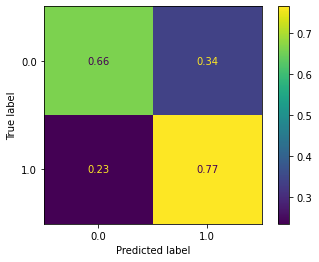

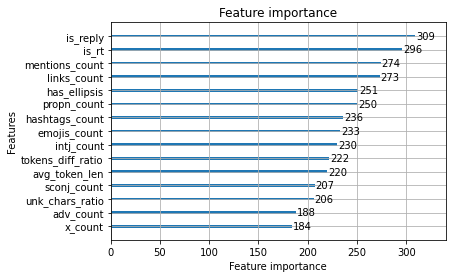

In [53]:
eval_clf(clf_meta_tweet_fe_mean, df_test_meta_tweet_fe_mean)

> Median

In [54]:
df_train_meta_tweet_fe_median = get_median(df_train_meta_tweet_fe, df_train['id'])
df_test_meta_tweet_fe_median = get_median(df_test_meta_tweet_fe, df_test['id'])

clf_meta_tweet_fe_median = get_best_clf(df_train_meta_tweet_fe_median)

[I 2022-03-29 17:38:11,670] A new study created in memory with name: no-name-f5b02218-1a96-4b92-a642-4dde71f80c4e


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 roundsTraining until validation scores don't improve for 100 rounds



Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:12,427] Trial 3 finished with value: 0.5 and parameters: {'lambda_l1': 0.00023260753717772688, 'lambda_l2': 7.223175175075481, 'num_leaves': 252, 'feature_fraction': 0.4192626832507376, 'bagging_fraction': 0.42403742475506573, 'bagging_freq': 4, 'learning_rate': 0.00010818916470041478, 'min_child_samples': 51}. Best is trial 3 with value: 0.5.


Did not meet early stopping. Best iteration is:
[27]	valid_0's auc: 0.712826
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:12,627] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 0.005669918433524229, 'lambda_l2': 4.630635623587672e-06, 'num_leaves': 165, 'feature_fraction': 0.4635779845992911, 'bagging_fraction': 0.7910725889222789, 'bagging_freq': 3, 'learning_rate': 0.0011073420272806713, 'min_child_samples': 94}. Best is trial 3 with value: 0.5.


Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.727631
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:12,956] Trial 9 finished with value: 0.5 and parameters: {'lambda_l1': 0.16193878991098762, 'lambda_l2': 0.6107335604267433, 'num_leaves': 11, 'feature_fraction': 0.6637152758077227, 'bagging_fraction': 0.7234686321270034, 'bagging_freq': 6, 'learning_rate': 5.171600966183966e-05, 'min_child_samples': 67}. Best is trial 3 with value: 0.5.
[I 2022-03-29 17:38:13,097] Trial 6 finished with value: 0.6641808740189221 and parameters: {'lambda_l1': 4.541421054387637e-05, 'lambda_l2': 1.3656839281844233e-06, 'num_leaves': 187, 'feature_fraction': 0.8792252067424317, 'bagging_fraction': 0.8872673253620564, 'bagging_freq': 7, 'learning_rate': 0.015985140794143708, 'min_child_samples': 68}. Best is trial 6 with value: 0.6641808740189221.
[I 2022-03-29 17:38:13,128] Trial 7 finished with value: 0.6585641287079411 and parameters: {'lambda_l1': 2.031552332681386e-06, 'lambda_l2': 1.6180733404065126, 'num_leaves': 79, 'feature_fraction': 0.5111502114215882, 'bagging_fraction': 0.

Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.710686
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.748201
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.741517


[I 2022-03-29 17:38:13,269] Trial 10 finished with value: 0.5 and parameters: {'lambda_l1': 0.0012677414396761373, 'lambda_l2': 0.000394652855811565, 'num_leaves': 5, 'feature_fraction': 0.5181816686733782, 'bagging_fraction': 0.9230224069493719, 'bagging_freq': 7, 'learning_rate': 0.000334705829054375, 'min_child_samples': 46}. Best is trial 6 with value: 0.6641808740189221.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.681495
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:13,567] Trial 4 finished with value: 0.5 and parameters: {'lambda_l1': 0.11544383641373816, 'lambda_l2': 5.633443879518295, 'num_leaves': 126, 'feature_fraction': 0.948155085322835, 'bagging_fraction': 0.8610136150803185, 'bagging_freq': 6, 'learning_rate': 0.0005408712978607864, 'min_child_samples': 28}. Best is trial 6 with value: 0.6641808740189221.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.736361
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:13,865] Trial 8 finished with value: 0.5 and parameters: {'lambda_l1': 0.017648041049532066, 'lambda_l2': 1.8826218289091248e-07, 'num_leaves': 175, 'feature_fraction': 0.5320175537440416, 'bagging_fraction': 0.5607419413194652, 'bagging_freq': 1, 'learning_rate': 0.00016244054276044262, 'min_child_samples': 47}. Best is trial 6 with value: 0.6641808740189221.


Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.731227
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:14,210] Trial 12 finished with value: 0.5141204087923553 and parameters: {'lambda_l1': 1.0468974940109354e-08, 'lambda_l2': 7.074498187728118e-05, 'num_leaves': 195, 'feature_fraction': 0.5158029832013931, 'bagging_fraction': 0.7618939253321979, 'bagging_freq': 4, 'learning_rate': 0.003056026738425072, 'min_child_samples': 91}. Best is trial 6 with value: 0.6641808740189221.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.732207
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:14,634] Trial 11 finished with value: 0.6559498968534371 and parameters: {'lambda_l1': 0.5386768669978443, 'lambda_l2': 0.005484496137195527, 'num_leaves': 235, 'feature_fraction': 0.6456464758659379, 'bagging_fraction': 0.9231725789502576, 'bagging_freq': 4, 'learning_rate': 0.014629629139903849, 'min_child_samples': 68}. Best is trial 6 with value: 0.6641808740189221.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.744374
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.74307


[I 2022-03-29 17:38:14,806] Trial 14 finished with value: 0.5934158110639508 and parameters: {'lambda_l1': 0.03701100357759276, 'lambda_l2': 0.0026840115790632162, 'num_leaves': 209, 'feature_fraction': 0.796565599051442, 'bagging_fraction': 0.6352788932781561, 'bagging_freq': 3, 'learning_rate': 0.0066056900242486, 'min_child_samples': 62}. Best is trial 6 with value: 0.6641808740189221.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:15,167] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 0.45218964705877673, 'lambda_l2': 2.745147370443923e-08, 'num_leaves': 131, 'feature_fraction': 0.5224336514441934, 'bagging_fraction': 0.9406524562005243, 'bagging_freq': 1, 'learning_rate': 2.5196377273704174e-05, 'min_child_samples': 8}. Best is trial 6 with value: 0.6641808740189221.


Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.745029
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:15,559] Trial 16 finished with value: 0.5 and parameters: {'lambda_l1': 6.408294267894619e-06, 'lambda_l2': 1.272411257518475, 'num_leaves': 67, 'feature_fraction': 0.8906408675789044, 'bagging_fraction': 0.8695451398222526, 'bagging_freq': 5, 'learning_rate': 0.000961863470707539, 'min_child_samples': 79}. Best is trial 6 with value: 0.6641808740189221.
[I 2022-03-29 17:38:15,715] Trial 15 finished with value: 0.5 and parameters: {'lambda_l1': 0.003681100832165062, 'lambda_l2': 1.2215289684344279e-06, 'num_leaves': 88, 'feature_fraction': 0.5844304895182408, 'bagging_fraction': 0.6549876166797172, 'bagging_freq': 2, 'learning_rate': 0.00011217914180814251, 'min_child_samples': 50}. Best is trial 6 with value: 0.6641808740189221.


Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.735293
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.73414


[I 2022-03-29 17:38:15,872] Trial 5 finished with value: 0.5 and parameters: {'lambda_l1': 0.005503652214988738, 'lambda_l2': 3.434991863829594e-05, 'num_leaves': 148, 'feature_fraction': 0.9884045819768587, 'bagging_fraction': 0.6349214044746285, 'bagging_freq': 7, 'learning_rate': 1.5209278839687911e-05, 'min_child_samples': 8}. Best is trial 6 with value: 0.6641808740189221.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.736802
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:16,029] Trial 13 finished with value: 0.6720798852346287 and parameters: {'lambda_l1': 3.065005830949103e-07, 'lambda_l2': 5.986845916961197e-08, 'num_leaves': 139, 'feature_fraction': 0.6525772840537436, 'bagging_fraction': 0.6757121047485126, 'bagging_freq': 4, 'learning_rate': 0.018982563688566, 'min_child_samples': 30}. Best is trial 13 with value: 0.6720798852346287.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.749149
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:16,563] Trial 18 finished with value: 0.669803547293292 and parameters: {'lambda_l1': 6.285422050943772e-06, 'lambda_l2': 1.883901204059443e-08, 'num_leaves': 92, 'feature_fraction': 0.8669905348974345, 'bagging_fraction': 0.9765354903623054, 'bagging_freq': 1, 'learning_rate': 0.21480534006443358, 'min_child_samples': 80}. Best is trial 13 with value: 0.6720798852346287.


Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.748637
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.739659


[I 2022-03-29 17:38:16,845] Trial 2 finished with value: 0.5983241647499584 and parameters: {'lambda_l1': 2.6366761197777062e-08, 'lambda_l2': 8.319888988229649e-07, 'num_leaves': 205, 'feature_fraction': 0.4593824443741104, 'bagging_fraction': 0.8263789777143867, 'bagging_freq': 3, 'learning_rate': 0.004435043425677862, 'min_child_samples': 17}. Best is trial 13 with value: 0.6720798852346287.
[I 2022-03-29 17:38:17,036] Trial 19 finished with value: 0.6693470941123467 and parameters: {'lambda_l1': 5.747486418034159e-06, 'lambda_l2': 0.054519879105373655, 'num_leaves': 72, 'feature_fraction': 0.8799934265669754, 'bagging_fraction': 0.9995980027433429, 'bagging_freq': 2, 'learning_rate': 0.18779466819648594, 'min_child_samples': 80}. Best is trial 13 with value: 0.6720798852346287.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.743765
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:17,645] Trial 20 finished with value: 0.6675775970407607 and parameters: {'lambda_l1': 1.8188763243490554e-06, 'lambda_l2': 2.563218694110336e-06, 'num_leaves': 70, 'feature_fraction': 0.7665778659374883, 'bagging_fraction': 0.9884798718012007, 'bagging_freq': 2, 'learning_rate': 0.13765216529600074, 'min_child_samples': 82}. Best is trial 13 with value: 0.6720798852346287.
[I 2022-03-29 17:38:17,737] Trial 21 finished with value: 0.6726519337016574 and parameters: {'lambda_l1': 3.544942336374008e-06, 'lambda_l2': 0.06395338755778794, 'num_leaves': 64, 'feature_fraction': 0.7846385491037188, 'bagging_fraction': 0.9512430466857698, 'bagging_freq': 7, 'learning_rate': 0.1518506962351416, 'min_child_samples': 78}. Best is trial 21 with value: 0.6726519337016574.
[I 2022-03-29 17:38:17,817] Trial 22 finished with value: 0.681606122400588 and parameters: {'lambda_l1': 2.8623015710521395e-06, 'lambda_l2': 0.04974160884784578, 'num_leaves': 70, 'feature_fraction': 0.750329

Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.745474
Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.74568
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.750618
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.74531


[I 2022-03-29 17:38:17,911] Trial 17 finished with value: 0.6768637516894697 and parameters: {'lambda_l1': 1.2866016203322265e-05, 'lambda_l2': 1.0732538029735041e-08, 'num_leaves': 107, 'feature_fraction': 0.9174407313453035, 'bagging_fraction': 0.6097902780678607, 'bagging_freq': 7, 'learning_rate': 0.15870785587843167, 'min_child_samples': 12}. Best is trial 22 with value: 0.681606122400588.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:18,162] Trial 24 finished with value: 0.6700317738837644 and parameters: {'lambda_l1': 2.6894165042650728e-08, 'lambda_l2': 1.1350506397783801e-08, 'num_leaves': 45, 'feature_fraction': 0.7596865157715064, 'bagging_fraction': 0.9980556775135141, 'bagging_freq': 2, 'learning_rate': 0.15689525581835514, 'min_child_samples': 28}. Best is trial 22 with value: 0.681606122400588.


Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.748901
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:18,413] Trial 25 finished with value: 0.65929623218647 and parameters: {'lambda_l1': 2.697203076453923e-07, 'lambda_l2': 1.0156848198960268e-08, 'num_leaves': 47, 'feature_fraction': 0.7609748170764297, 'bagging_fraction': 0.504262045731097, 'bagging_freq': 2, 'learning_rate': 0.19791848671930498, 'min_child_samples': 33}. Best is trial 22 with value: 0.681606122400588.
[I 2022-03-29 17:38:18,491] Trial 23 finished with value: 0.66343987859531 and parameters: {'lambda_l1': 1.3922484348237363e-07, 'lambda_l2': 1.4767674021489129e-08, 'num_leaves': 109, 'feature_fraction': 0.7849769883360191, 'bagging_fraction': 0.5231171574268324, 'bagging_freq': 5, 'learning_rate': 0.15239632802357508, 'min_child_samples': 29}. Best is trial 22 with value: 0.681606122400588.


Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.740869
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.729214
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.749265

[I 2022-03-29 17:38:18,839] Trial 30 finished with value: 0.6691929670642355 and parameters: {'lambda_l1': 1.4064230327347476e-07, 'lambda_l2': 0.045016693178232085, 'num_leaves': 45, 'feature_fraction': 0.7574540852990811, 'bagging_fraction': 0.5726778991670838, 'bagging_freq': 6, 'learning_rate': 0.06224757642969457, 'min_child_samples': 100}. Best is trial 22 with value: 0.681606122400588.



Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.75114


[I 2022-03-29 17:38:19,024] Trial 29 finished with value: 0.6664186801982311 and parameters: {'lambda_l1': 1.759210779060357e-07, 'lambda_l2': 0.0564032683210609, 'num_leaves': 27, 'feature_fraction': 0.7361842716705311, 'bagging_fraction': 0.5488200129470218, 'bagging_freq': 5, 'learning_rate': 0.05766454071591247, 'min_child_samples': 35}. Best is trial 22 with value: 0.681606122400588.
[I 2022-03-29 17:38:19,260] Trial 31 finished with value: 0.6737130391482702 and parameters: {'lambda_l1': 2.807041255013078e-07, 'lambda_l2': 0.06808550408549924, 'num_leaves': 107, 'feature_fraction': 0.7312618860168452, 'bagging_fraction': 0.5771580499277241, 'bagging_freq': 6, 'learning_rate': 0.05761287208503643, 'min_child_samples': 99}. Best is trial 22 with value: 0.681606122400588.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.75285


[I 2022-03-29 17:38:19,448] Trial 32 finished with value: 0.682919166291229 and parameters: {'lambda_l1': 4.8466165174826744e-05, 'lambda_l2': 0.062233307646027775, 'num_leaves': 109, 'feature_fraction': 0.8331787209074666, 'bagging_fraction': 0.5799584893773624, 'bagging_freq': 6, 'learning_rate': 0.06006511022541132, 'min_child_samples': 99}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:19,542] Trial 26 finished with value: 0.6665905911365091 and parameters: {'lambda_l1': 1.8153156411022622e-07, 'lambda_l2': 1.1109992120677096e-08, 'num_leaves': 113, 'feature_fraction': 0.7706788356837472, 'bagging_fraction': 0.5539557799820002, 'bagging_freq': 5, 'learning_rate': 0.23612743416104245, 'min_child_samples': 32}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.751197
Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.735705
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.751224


[I 2022-03-29 17:38:19,636] Trial 33 finished with value: 0.680853271050198 and parameters: {'lambda_l1': 6.759901417936691e-05, 'lambda_l2': 0.034539381835808326, 'num_leaves': 41, 'feature_fraction': 0.8420136314957732, 'bagging_fraction': 0.5802465483862165, 'bagging_freq': 6, 'learning_rate': 0.05166486650149981, 'min_child_samples': 99}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:20,122] Trial 36 finished with value: 0.6701058734261257 and parameters: {'lambda_l1': 3.032832435624741, 'lambda_l2': 0.0034168467164398426, 'num_leaves': 112, 'feature_fraction': 0.8301455658311729, 'bagging_fraction': 0.46724508678119026, 'bagging_freq': 6, 'learning_rate': 0.04650625037574563, 'min_child_samples': 90}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:20,216] Trial 37 finished with value: 0.6441651056363076 and parameters: {'lambda_l1': 8.765582922385905, 'lambda_l2': 0.004079317363851745, 'num_leaves': 123, 'feature_fraction': 0.832853897437775, 'bagging_fraction': 0.44489252865641027, 'bagging_freq': 5, 'learning_rate': 0.03566194088840094, 'min_child_samples': 88}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:20,248] Trial 27 finished with value: 0.6660303985962582 and parameters: {'lambda_l1': 1.4085939145661632e-07, 'lambda_l2': 1.7677935878400206e-08, 'num_leaves': 110, 'feature_fraction': 0.7393560

Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.744028
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.72956
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.747221
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:20,388] Trial 28 finished with value: 0.6645750835842839 and parameters: {'lambda_l1': 1.452334855781551e-07, 'lambda_l2': 1.2770126771944424e-08, 'num_leaves': 104, 'feature_fraction': 0.7527853276764513, 'bagging_fraction': 0.5360357412802316, 'bagging_freq': 5, 'learning_rate': 0.05681535408870374, 'min_child_samples': 34}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.748134
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:20,592] Trial 39 finished with value: 0.6723318236786568 and parameters: {'lambda_l1': 5.8091632719528595e-05, 'lambda_l2': 0.003292944498212892, 'num_leaves': 96, 'feature_fraction': 0.8414305393406394, 'bagging_fraction': 0.46325641545089724, 'bagging_freq': 6, 'learning_rate': 0.03428467011749112, 'min_child_samples': 89}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:20,686] Trial 38 finished with value: 0.6823826856045336 and parameters: {'lambda_l1': 3.180452536164576e-05, 'lambda_l2': 0.010932983760334615, 'num_leaves': 104, 'feature_fraction': 0.8320739365823085, 'bagging_fraction': 0.6075151665315042, 'bagging_freq': 6, 'learning_rate': 0.06354438012149558, 'min_child_samples': 100}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.747749
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.753702


[I 2022-03-29 17:38:20,765] Trial 34 finished with value: 0.6787755198823893 and parameters: {'lambda_l1': 6.147424205234024e-05, 'lambda_l2': 0.13681139477524737, 'num_leaves': 112, 'feature_fraction': 0.6968672681769881, 'bagging_fraction': 0.7221144743083933, 'bagging_freq': 5, 'learning_rate': 0.06292905912757087, 'min_child_samples': 58}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.746439
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.752418


[I 2022-03-29 17:38:20,922] Trial 35 finished with value: 0.6796943542076684 and parameters: {'lambda_l1': 8.700843276515985e-05, 'lambda_l2': 0.01139241847313234, 'num_leaves': 111, 'feature_fraction': 0.8291407139854927, 'bagging_fraction': 0.7142516344188152, 'bagging_freq': 6, 'learning_rate': 0.057017407387684634, 'min_child_samples': 58}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.751772

[I 2022-03-29 17:38:21,267] Trial 40 finished with value: 0.6668692054157874 and parameters: {'lambda_l1': 4.877961020430073e-05, 'lambda_l2': 0.2909875890931229, 'num_leaves': 25, 'feature_fraction': 0.929700563463976, 'bagging_fraction': 0.7218815607259613, 'bagging_freq': 7, 'learning_rate': 0.030871312686579125, 'min_child_samples': 87}. Best is trial 32 with value: 0.682919166291229.



Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.735907


[I 2022-03-29 17:38:21,439] Trial 42 finished with value: 0.639579825954995 and parameters: {'lambda_l1': 7.082927995543414e-05, 'lambda_l2': 0.29777023246376905, 'num_leaves': 94, 'feature_fraction': 0.9357630906508866, 'bagging_fraction': 0.6074746021579494, 'bagging_freq': 7, 'learning_rate': 0.007267696815001778, 'min_child_samples': 96}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:21,581] Trial 41 finished with value: 0.6700999454627369 and parameters: {'lambda_l1': 6.957546249604229e-05, 'lambda_l2': 0.25122888477473376, 'num_leaves': 153, 'feature_fraction': 0.9346290482945822, 'bagging_fraction': 0.5931018076616806, 'bagging_freq': 7, 'learning_rate': 0.02826548681888508, 'min_child_samples': 95}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:21,659] Trial 43 finished with value: 0.6322172954259835 and parameters: {'lambda_l1': 7.186697125239777e-05, 'lambda_l2': 0.21337207967338348, 'num_leaves': 26, 'feature_fraction': 0.940763921

Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.748054
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.734936
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:21,973] Trial 45 finished with value: 0.6319831408721219 and parameters: {'lambda_l1': 0.00030899682972615396, 'lambda_l2': 0.24102550518303725, 'num_leaves': 146, 'feature_fraction': 0.9569213124230223, 'bagging_fraction': 0.710563122725401, 'bagging_freq': 3, 'learning_rate': 0.006233426439721163, 'min_child_samples': 96}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.731366


[I 2022-03-29 17:38:22,176] Trial 46 finished with value: 0.6233075664524695 and parameters: {'lambda_l1': 0.0005661891636600777, 'lambda_l2': 0.013133830632464578, 'num_leaves': 155, 'feature_fraction': 0.9693146505676421, 'bagging_fraction': 0.8083538113139286, 'bagging_freq': 3, 'learning_rate': 0.005676679110826366, 'min_child_samples': 96}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.729212
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:22,349] Trial 47 finished with value: 0.6498144547459275 and parameters: {'lambda_l1': 0.0005550730619001357, 'lambda_l2': 0.2812162672197072, 'num_leaves': 156, 'feature_fraction': 0.9475527420210089, 'bagging_fraction': 0.8051661452986252, 'bagging_freq': 3, 'learning_rate': 0.010833110143692324, 'min_child_samples': 96}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.736575
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:22,647] Trial 48 finished with value: 0.6460294501221161 and parameters: {'lambda_l1': 0.00031334598001305435, 'lambda_l2': 0.0009453171134138937, 'num_leaves': 153, 'feature_fraction': 0.8128881788506244, 'bagging_fraction': 0.818260466764565, 'bagging_freq': 6, 'learning_rate': 0.008982569657696886, 'min_child_samples': 95}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.743627
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:23,180] Trial 51 finished with value: 0.6807732435444478 and parameters: {'lambda_l1': 0.00032050460465789937, 'lambda_l2': 0.014206614779870142, 'num_leaves': 132, 'feature_fraction': 0.8254403900379073, 'bagging_fraction': 0.8170335989496814, 'bagging_freq': 6, 'learning_rate': 0.0957060466787009, 'min_child_samples': 84}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:23,274] Trial 49 finished with value: 0.6718012709553505 and parameters: {'lambda_l1': 0.00030557383885130315, 'lambda_l2': 0.013991173228525089, 'num_leaves': 154, 'feature_fraction': 0.8133732280107228, 'bagging_fraction': 0.8059486418329767, 'bagging_freq': 6, 'learning_rate': 0.10830960588268018, 'min_child_samples': 74}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:23,321] Trial 50 finished with value: 0.6525768856851539 and parameters: {'lambda_l1': 0.0005648617361641412, 'lambda_l2': 0.015230080180879551, 'num_leaves': 126, 'feature_fraction': 0.976

Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.754615
Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.750537Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.740964

Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:23,509] Trial 52 finished with value: 0.6679718066061224 and parameters: {'lambda_l1': 0.0010173159438022804, 'lambda_l2': 0.013712734553698456, 'num_leaves': 56, 'feature_fraction': 0.8134836328912943, 'bagging_fraction': 0.7616351948656441, 'bagging_freq': 6, 'learning_rate': 0.09893054422909375, 'min_child_samples': 74}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.749774
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:23,682] Trial 54 finished with value: 0.6730224314134636 and parameters: {'lambda_l1': 1.6878726082323843e-05, 'lambda_l2': 0.0009249697394828344, 'num_leaves': 126, 'feature_fraction': 0.8526988074357978, 'bagging_fraction': 0.670900363082744, 'bagging_freq': 6, 'learning_rate': 0.10323687762626932, 'min_child_samples': 75}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:23,761] Trial 53 finished with value: 0.6818521328812275 and parameters: {'lambda_l1': 1.80766451102189e-05, 'lambda_l2': 0.015404246581731161, 'num_leaves': 55, 'feature_fraction': 0.8115344776101656, 'bagging_fraction': 0.7698169917615953, 'bagging_freq': 6, 'learning_rate': 0.09610451871145637, 'min_child_samples': 73}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.751242
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.753877
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:24,074] Trial 55 finished with value: 0.6682622768121784 and parameters: {'lambda_l1': 1.7805215400245573e-05, 'lambda_l2': 0.017506406380231074, 'num_leaves': 129, 'feature_fraction': 0.6999600490775735, 'bagging_fraction': 0.6743351657366797, 'bagging_freq': 6, 'learning_rate': 0.10943007115530072, 'min_child_samples': 73}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.747003
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.740287


[I 2022-03-29 17:38:24,387] Trial 44 finished with value: 0.6503450074692338 and parameters: {'lambda_l1': 4.406021194633293e-05, 'lambda_l2': 0.25294037307712297, 'num_leaves': 161, 'feature_fraction': 0.9229322035324341, 'bagging_fraction': 0.6015505399260951, 'bagging_freq': 7, 'learning_rate': 0.008726129913209642, 'min_child_samples': 20}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:24,764] Trial 58 finished with value: 0.6739471937021316 and parameters: {'lambda_l1': 2.63150022396753e-05, 'lambda_l2': 0.000837624524000285, 'num_leaves': 82, 'feature_fraction': 0.8567635714879841, 'bagging_fraction': 0.7612999821636537, 'bagging_freq': 6, 'learning_rate': 0.09533133626742214, 'min_child_samples': 85}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:24,811] Trial 57 finished with value: 0.6724059232210182 and parameters: {'lambda_l1': 2.503108437261685e-05, 'lambda_l2': 3.1323326764012553, 'num_leaves': 129, 'feature_fraction': 0.7083845771413, 'bagging_fraction': 0.7781769567616492, 'bagging_freq': 6, 'learning_rate': 0.08655716903002954, 'min_child_samples': 84}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:24,921] Trial 56 finished with value: 0.6770178787375809 and parameters: {'lambda_l1': 1.7631152544454168e-05, 'lambda_l2': 0.015435334225741733, 'num_leaves': 132, 'feature_fraction': 0.7167846539

Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.751358Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.751717

Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.749266


[I 2022-03-29 17:38:25,093] Trial 59 finished with value: 0.6699398904512366 and parameters: {'lambda_l1': 9.555229891616351e-07, 'lambda_l2': 0.0011077508392801794, 'num_leaves': 134, 'feature_fraction': 0.8556567801030753, 'bagging_fraction': 0.843015316610634, 'bagging_freq': 6, 'learning_rate': 0.019767954786366154, 'min_child_samples': 84}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.747586
Did not meet early stopping. Best iteration is:
[15]	valid_0's auc: 0.74149


[I 2022-03-29 17:38:25,172] Trial 61 finished with value: 0.6694271216180969 and parameters: {'lambda_l1': 9.055058866301652e-07, 'lambda_l2': 3.054930456761589, 'num_leaves': 80, 'feature_fraction': 0.7039710841956114, 'bagging_fraction': 0.7623106073195411, 'bagging_freq': 4, 'learning_rate': 0.298757915527486, 'min_child_samples': 84}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:25,470] Trial 60 finished with value: 0.6653575747516183 and parameters: {'lambda_l1': 1.9954576770467716e-05, 'lambda_l2': 0.00013462822984929528, 'num_leaves': 84, 'feature_fraction': 0.8925963333554314, 'bagging_fraction': 0.8450487180156474, 'bagging_freq': 6, 'learning_rate': 0.29904205346532414, 'min_child_samples': 83}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.741564
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:25,736] Trial 62 finished with value: 0.665209375666896 and parameters: {'lambda_l1': 1.1927066642958685e-06, 'lambda_l2': 9.059209766827018e-05, 'num_leaves': 80, 'feature_fraction': 0.900842336684792, 'bagging_fraction': 0.8491328952908295, 'bagging_freq': 4, 'learning_rate': 0.2815594567935225, 'min_child_samples': 82}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:25,852] Trial 68 finished with value: 0.5 and parameters: {'lambda_l1': 0.00013645870157050194, 'lambda_l2': 6.878565098909026e-05, 'num_leaves': 13, 'feature_fraction': 0.8783531265769912, 'bagging_fraction': 0.6306279962983652, 'bagging_freq': 1, 'learning_rate': 1.1026915234809792e-05, 'min_child_samples': 61}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.741346
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.713966
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:26,018] Trial 63 finished with value: 0.6608760344296114 and parameters: {'lambda_l1': 1.0165501564514692e-06, 'lambda_l2': 4.6008258581214685, 'num_leaves': 80, 'feature_fraction': 0.9017714096023622, 'bagging_fraction': 0.8558430719045109, 'bagging_freq': 4, 'learning_rate': 0.020388199222982857, 'min_child_samples': 84}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.748266
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.749449
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:26,175] Trial 64 finished with value: 0.6637125649111991 and parameters: {'lambda_l1': 2.242333973645325e-06, 'lambda_l2': 5.911312397243294e-05, 'num_leaves': 36, 'feature_fraction': 0.9003233232704889, 'bagging_fraction': 0.8826111832045176, 'bagging_freq': 5, 'learning_rate': 0.01672719713875719, 'min_child_samples': 85}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:26,347] Trial 66 finished with value: 0.6713211059208498 and parameters: {'lambda_l1': 1.8362050206781309e-06, 'lambda_l2': 0.0002244943728876439, 'num_leaves': 177, 'feature_fraction': 0.8926052735645978, 'bagging_fraction': 0.6443970272507296, 'bagging_freq': 4, 'learning_rate': 0.02104170085786202, 'min_child_samples': 91}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.748638
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:26,567] Trial 65 finished with value: 0.6638222322338937 and parameters: {'lambda_l1': 1.3895503486622238e-06, 'lambda_l2': 1.134335791955876, 'num_leaves': 79, 'feature_fraction': 0.898625170151708, 'bagging_fraction': 0.8406721330097034, 'bagging_freq': 4, 'learning_rate': 0.29394633653141033, 'min_child_samples': 92}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:26,740] Trial 67 finished with value: 0.667731724088872 and parameters: {'lambda_l1': 0.00015060142240719954, 'lambda_l2': 0.0001119857757863898, 'num_leaves': 176, 'feature_fraction': 0.9011086892349989, 'bagging_fraction': 0.9101478415203103, 'bagging_freq': 4, 'learning_rate': 0.2940868418099398, 'min_child_samples': 91}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.739228
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's auc: 0.74598
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.751617


[I 2022-03-29 17:38:27,085] Trial 69 finished with value: 0.6681022218006781 and parameters: {'lambda_l1': 0.0037769291867363426, 'lambda_l2': 0.006699260426834833, 'num_leaves': 55, 'feature_fraction': 0.7922899014568051, 'bagging_fraction': 0.636529270820743, 'bagging_freq': 1, 'learning_rate': 0.024014880931246905, 'min_child_samples': 63}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:27,195] Trial 71 finished with value: 0.6694893652336804 and parameters: {'lambda_l1': 0.002843043524159641, 'lambda_l2': 0.007130432039024763, 'num_leaves': 37, 'feature_fraction': 0.7934598082874468, 'bagging_fraction': 0.6993754041456176, 'bagging_freq': 5, 'learning_rate': 0.02312032281791007, 'min_child_samples': 43}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.752256
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:27,414] Trial 70 finished with value: 0.6767659402935529 and parameters: {'lambda_l1': 0.00017259852100526716, 'lambda_l2': 0.02923419529563196, 'num_leaves': 63, 'feature_fraction': 0.8005509961727575, 'bagging_fraction': 0.6337555932533113, 'bagging_freq': 1, 'learning_rate': 0.023838221097299783, 'min_child_samples': 61}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:27,508] Trial 73 finished with value: 0.5386799611125602 and parameters: {'lambda_l1': 0.003328341492664957, 'lambda_l2': 1.3868331860683992e-05, 'num_leaves': 63, 'feature_fraction': 0.797097390504374, 'bagging_fraction': 0.689120320934027, 'bagging_freq': 5, 'learning_rate': 0.0026088660427242153, 'min_child_samples': 92}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.752509
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.733066
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.738666


[I 2022-03-29 17:38:27,602] Trial 72 finished with value: 0.5562593365423375 and parameters: {'lambda_l1': 8.678090527185558e-06, 'lambda_l2': 0.6438355750395146, 'num_leaves': 59, 'feature_fraction': 0.7942308286273456, 'bagging_fraction': 0.9060391066523007, 'bagging_freq': 5, 'learning_rate': 0.003636092637626518, 'min_child_samples': 92}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:28,261] Trial 75 finished with value: 0.5580288336139236 and parameters: {'lambda_l1': 0.002704217100381352, 'lambda_l2': 0.006924085210664579, 'num_leaves': 58, 'feature_fraction': 0.7804246463490718, 'bagging_fraction': 0.6987635076562064, 'bagging_freq': 5, 'learning_rate': 0.0030196337994674895, 'min_child_samples': 54}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.740463
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:28,496] Trial 77 finished with value: 0.6785413653285277 and parameters: {'lambda_l1': 3.972231750445349e-06, 'lambda_l2': 0.027657693992659826, 'num_leaves': 100, 'feature_fraction': 0.8043433668390944, 'bagging_fraction': 0.40055455995213124, 'bagging_freq': 5, 'learning_rate': 0.043627730193505576, 'min_child_samples': 42}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:28,575] Trial 74 finished with value: 0.5508886017119958 and parameters: {'lambda_l1': 0.002879183576022389, 'lambda_l2': 0.006356468215931682, 'num_leaves': 64, 'feature_fraction': 0.7912357025205868, 'bagging_fraction': 0.9504396634824746, 'bagging_freq': 5, 'learning_rate': 0.00371347897729702, 'min_child_samples': 55}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:28,606] Trial 76 finished with value: 0.5524980437720817 and parameters: {'lambda_l1': 0.0027245698629515787, 'lambda_l2': 0.029966617486333343, 'num_leaves': 61, 'feature_fraction': 0.79251

Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.754419
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.740062
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.742188
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:29,061] Trial 78 finished with value: 0.6751683541602447 and parameters: {'lambda_l1': 6.684664615374322e-06, 'lambda_l2': 0.11170756747242318, 'num_leaves': 98, 'feature_fraction': 0.6033841627432976, 'bagging_fraction': 0.7412397596047002, 'bagging_freq': 5, 'learning_rate': 0.03609006706047547, 'min_child_samples': 55}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.750258
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.736924


[I 2022-03-29 17:38:29,233] Trial 79 finished with value: 0.5112038508050174 and parameters: {'lambda_l1': 5.121182473221236e-06, 'lambda_l2': 0.10235628251164143, 'num_leaves': 120, 'feature_fraction': 0.6802545570317993, 'bagging_fraction': 0.7460018779081875, 'bagging_freq': 5, 'learning_rate': 0.0019506026957051194, 'min_child_samples': 56}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:29,343] Trial 80 finished with value: 0.6737812107272426 and parameters: {'lambda_l1': 0.0001184411766466941, 'lambda_l2': 0.11228638201863878, 'num_leaves': 99, 'feature_fraction': 0.6722715745047899, 'bagging_fraction': 0.7318895071456452, 'bagging_freq': 5, 'learning_rate': 0.042117714407111706, 'min_child_samples': 56}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:29,437] Trial 81 finished with value: 0.6653457188248405 and parameters: {'lambda_l1': 9.566373283255071e-06, 'lambda_l2': 0.09982512262846084, 'num_leaves': 118, 'feature_fraction': 0.67943

Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.749126
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.745674
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:29,782] Trial 83 finished with value: 0.6776225310032484 and parameters: {'lambda_l1': 9.406436801482574e-06, 'lambda_l2': 0.13225949759663963, 'num_leaves': 116, 'feature_fraction': 0.6182515377666102, 'bagging_fraction': 0.7325988062631765, 'bagging_freq': 7, 'learning_rate': 0.07300117417272523, 'min_child_samples': 100}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.758308
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:30,001] Trial 84 finished with value: 0.6755447798354397 and parameters: {'lambda_l1': 9.173965301820138e-06, 'lambda_l2': 0.0021004846899978684, 'num_leaves': 115, 'feature_fraction': 0.6057078773884308, 'bagging_fraction': 0.7390544686103394, 'bagging_freq': 7, 'learning_rate': 0.04384218586018499, 'min_child_samples': 99}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:30,142] Trial 86 finished with value: 0.6730965309558249 and parameters: {'lambda_l1': 0.0001231350229148241, 'lambda_l2': 0.10436637791815519, 'num_leaves': 72, 'feature_fraction': 0.8299073695119777, 'bagging_fraction': 0.5799922666358968, 'bagging_freq': 6, 'learning_rate': 0.07470918280470573, 'min_child_samples': 100}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.750883
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.75229
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.749976


[I 2022-03-29 17:38:30,221] Trial 82 finished with value: 0.6703341000165983 and parameters: {'lambda_l1': 8.166285347432673e-06, 'lambda_l2': 0.13680327134263578, 'num_leaves': 120, 'feature_fraction': 0.6740145653197832, 'bagging_fraction': 0.7304800862598358, 'bagging_freq': 7, 'learning_rate': 0.042689807443518676, 'min_child_samples': 55}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:30,394] Trial 87 finished with value: 0.6722636520996846 and parameters: {'lambda_l1': 9.833050068622608e-05, 'lambda_l2': 0.12708455898743368, 'num_leaves': 116, 'feature_fraction': 0.834425220745004, 'bagging_fraction': 0.501007587344858, 'bagging_freq': 7, 'learning_rate': 0.0759925121827961, 'min_child_samples': 70}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.749025


[I 2022-03-29 17:38:30,582] Trial 88 finished with value: 0.665289403172646 and parameters: {'lambda_l1': 3.6078877491258383e-06, 'lambda_l2': 0.0016647215612157484, 'num_leaves': 116, 'feature_fraction': 0.8296152027519992, 'bagging_fraction': 0.40304109635352053, 'bagging_freq': 7, 'learning_rate': 0.07552248917660603, 'min_child_samples': 50}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:30,692] Trial 85 finished with value: 0.6725600502691296 and parameters: {'lambda_l1': 9.326567762500583e-06, 'lambda_l2': 0.10348516183145239, 'num_leaves': 118, 'feature_fraction': 0.6757221298987138, 'bagging_fraction': 0.7350889591477929, 'bagging_freq': 7, 'learning_rate': 0.045903333970829685, 'min_child_samples': 58}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.743014
Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.754476
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.755178


[I 2022-03-29 17:38:30,761] Trial 89 finished with value: 0.6787014203400279 and parameters: {'lambda_l1': 3.914423219962258e-06, 'lambda_l2': 0.03365092180327181, 'num_leaves': 103, 'feature_fraction': 0.8292721153412824, 'bagging_fraction': 0.5063352943825814, 'bagging_freq': 6, 'learning_rate': 0.06255506115690938, 'min_child_samples': 70}. Best is trial 32 with value: 0.682919166291229.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:31,084] Trial 91 finished with value: 0.6722636520996846 and parameters: {'lambda_l1': 3.29637215600227e-05, 'lambda_l2': 0.0270650147624605, 'num_leaves': 142, 'feature_fraction': 0.820113934254428, 'bagging_fraction': 0.40007860824254293, 'bagging_freq': 6, 'learning_rate': 0.07435041489518093, 'min_child_samples': 70}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.744097
Training until validation scores don't improve for 100 rounds


[I 2022-03-29 17:38:31,303] Trial 90 finished with value: 0.6680399781850948 and parameters: {'lambda_l1': 3.346826562381308e-05, 'lambda_l2': 0.033641114609285955, 'num_leaves': 140, 'feature_fraction': 0.8274983662827523, 'bagging_fraction': 0.5002639356610816, 'bagging_freq': 6, 'learning_rate': 0.14506986371871627, 'min_child_samples': 50}. Best is trial 32 with value: 0.682919166291229.
[I 2022-03-29 17:38:31,444] Trial 92 finished with value: 0.6729483318711024 and parameters: {'lambda_l1': 4.3455743759946246e-05, 'lambda_l2': 0.038478969648534186, 'num_leaves': 103, 'feature_fraction': 0.4033425207328196, 'bagging_fraction': 0.48778362056071034, 'bagging_freq': 6, 'learning_rate': 0.1323477988942261, 'min_child_samples': 70}. Best is trial 32 with value: 0.682919166291229.


Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.745655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.746694


[I 2022-03-29 17:38:31,664] Trial 93 finished with value: 0.6866863870248737 and parameters: {'lambda_l1': 4.312678621315161e-05, 'lambda_l2': 0.03211260786751202, 'num_leaves': 139, 'feature_fraction': 0.8409945389643779, 'bagging_fraction': 0.5007851082890684, 'bagging_freq': 6, 'learning_rate': 0.13447034275325662, 'min_child_samples': 50}. Best is trial 93 with value: 0.6866863870248737.
[I 2022-03-29 17:38:31,789] Trial 94 finished with value: 0.6668810613425652 and parameters: {'lambda_l1': 3.4858577836912844e-05, 'lambda_l2': 0.0316868321014017, 'num_leaves': 139, 'feature_fraction': 0.7471154040313047, 'bagging_fraction': 0.4006595419119784, 'bagging_freq': 6, 'learning_rate': 0.13241988326288753, 'min_child_samples': 39}. Best is trial 93 with value: 0.6866863870248737.


Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.751824
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.745264
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.749314

[I 2022-03-29 17:38:31,852] Trial 95 finished with value: 0.6804590614848363 and parameters: {'lambda_l1': 3.821738842193058e-05, 'lambda_l2': 0.026845348727302237, 'num_leaves': 140, 'feature_fraction': 0.4143645458346546, 'bagging_fraction': 0.6591971280817563, 'bagging_freq': 6, 'learning_rate': 0.12992601279697294, 'min_child_samples': 78}. Best is trial 93 with value: 0.6866863870248737.
[I 2022-03-29 17:38:31,915] Trial 97 finished with value: 0.5 and parameters: {'lambda_l1': 3.5619274220216595e-05, 'lambda_l2': 0.036336451091603474, 'num_leaves': 92, 'feature_fraction': 0.8732577848017486, 'bagging_fraction': 0.539692741042342, 'bagging_freq': 6, 'learning_rate': 0.0006508122323456033, 'min_child_samples': 66}. Best is trial 93 with value: 0.6866863870248737.
[I 2022-03-29 17:38:31,963] Trial 98 finished with value: 0.6772461053280536 and parameters: {'lambda_l1': 5.691594388598966e-07, 'lambda_l2': 0.03892635578252454, 'num_leaves': 89, 'feature_fraction': 0.8684384160152324, 


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.732206
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.747503
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.745615
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.74383


[I 2022-03-29 17:38:32,040] Trial 99 finished with value: 0.6781649396533328 and parameters: {'lambda_l1': 3.0643194152818526e-06, 'lambda_l2': 0.5308969013627244, 'num_leaves': 89, 'feature_fraction': 0.8473461119999801, 'bagging_fraction': 0.4743844848483918, 'bagging_freq': 6, 'learning_rate': 0.12943538126789064, 'min_child_samples': 77}. Best is trial 93 with value: 0.6866863870248737.


{'lambda_l1': 4.312678621315161e-05, 'lambda_l2': 0.03211260786751202, 'num_leaves': 139, 'feature_fraction': 0.8409945389643779, 'bagging_fraction': 0.5007851082890684, 'bagging_freq': 6, 'learning_rate': 0.13447034275325662, 'min_child_samples': 50} -> 0.6866863870248737
[LightGBM] [Warning] feature_fraction is set=0.8409945389643779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8409945389643779
[LightGBM] [Warning] lambda_l1 is set=4.312678621315161e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.312678621315161e-05
[LightGBM] [Warning] bagging_fraction is set=0.5007851082890684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5007851082890684
[LightGBM] [Warning] lambda_l2 is set=0.03211260786751202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03211260786751202
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't imp

AUROC: 0.6720591620626151
Accuracy: 0.6779374471682164


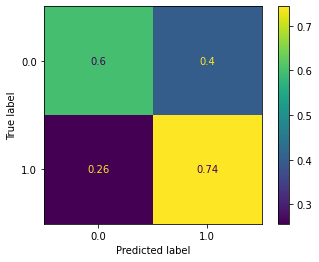

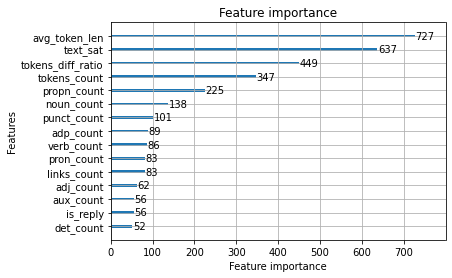

In [55]:
eval_clf(clf_meta_tweet_fe_median, df_test_meta_tweet_fe_median)

# TODO: Combine models on users metadata + tweets metadata

# Detection on tweets content

In [56]:
X_train_tweet, y_train_tweet = df_train['tweet'], df_train['label']
X_test_tweet, y_test_tweet = df_test['tweet'], df_test['label']

X_train_tweet.head()

0    Gustave Courbet was often called 'the most arr...
1                                   An animal MackLibs
2                                I hope it's 900 gems.
3    Delhi : Social Welfare Minister AdvRajendraPal...
4    I wouldn't even consider going on holiday now,...
Name: tweet, dtype: object

## Encoding hashtags

> __Meh__

In [7]:
hashtags_count = []
for _, hashtags in tqdm(df_train['hashtags'].iteritems(), total=len(df_train)):
    hashtags_count += hashtags
hashtags_count = Counter(hashtags_count)
hashtags_count

  0%|          | 0/1398465 [00:00<?, ?it/s]

Counter({'Sponsored': 39,
         'HandShaq': 1,
         'ad': 465,
         'lsunationalchamps': 1,
         'WeWantToPlay': 22,
         'SharkWeek': 124,
         'LeadingThroughChange': 2,
         'MyStartingFive': 4,
         'SHAQvsGRONK': 1,
         'fortopartner': 2,
         'ShotForHeroes': 1,
         'sanitation': 5,
         'NRGFAM': 14,
         'BETAwards': 52,
         'BiteSizedGlory': 1,
         'GeauxTigers': 62,
         'frostedflakespartner': 1,
         'RingPartner': 1,
         'healthcareheroes': 19,
         'ShareMyHero': 1,
         'jcppartner': 1,
         'shaqlife': 4,
         'TNTpartner': 4,
         'MothersDay': 87,
         'FastFoto': 2,
         'FastFotoSweepstakes': 1,
         'EpsonPartner': 1,
         'NFLdraft': 2,
         'Shaqcast': 1,
         'Prince': 13,
         'HatsOff': 2,
         'JCPpartner': 1,
         'throwback': 80,
         'TNTPartner': 1,
         'PapaJohnsPartner': 1,
         'PostForPencils': 1,
         'S

In [8]:
hashtags_best = hashtags_count.most_common()
hashtags_best_label = [ c[0] for c in hashtags_best ]
hashtags_best_count = [ c[1] for c in hashtags_best ]

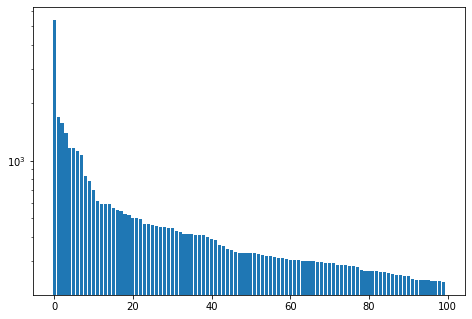

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_yscale('log')
langs = list(range(100))
students = hashtags_best_count[:100]
ax.bar(langs,students)
plt.show()

In [ ]:
lim = 41
hashtags_best_label = hashtags_best_label[:lim]

> __Wouldn't it be smarter to use hashtags from the Ukraine dataset?__

In [21]:
# To remove if above cells are unfrozen
hashtags_best_label = [ ht for ht, c in hashtags_count.items() if c > 10 ]
len(hashtags_best_label)

8268

In [22]:
hashtags_filtered = { ht: i for i, ht in enumerate(hashtags_best_label) }

def encode_hashtag(hashtags: list):
    most_common = None
    for ht in hashtags:
        if ht in hashtags_filtered:
            i = hashtags_filtered[ht]
            if most_common is None or i < most_common:
                most_common = i
    if most_common is None:
        most_common = np.nan
    return most_common

df_train['hashtags_enc'] = df_train['hashtags'].apply(encode_hashtag)
df_test['hashtags_enc'] = df_test['hashtags'].apply(encode_hashtag)
print(round(100 * df_train['hashtags_enc'].count() / len(df_train['hashtags_enc']), 3), "%")
df_train['hashtags_enc'].head()

13.578 %


0    NaN
1    NaN
2    0.0
3    1.0
4    NaN
Name: hashtags_enc, dtype: float64

In [57]:
import spacy
nlp = spacy.load('en_core_web_sm')
#TODO preprocess the corpus using spacy or load the pre-processed corpus

def preprocess(text, nlp=nlp):
    return [
        token for token in nlp(text)
        if not token.is_punct and not token.is_stop
    ]

df['text_clean'] = df['text'].progress_apply(preprocess)
df['text_clean'].head()

NameError: name 'df' is not defined

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(dfs['text'])

In [ ]:
from gensim.models import Word2Vec

##TODO train a word2vec model on this dataset, only consider words which appear at least 10 times in the corpus
w2v = Word2Vec(dataset, min_count=10)

In [ ]:
text = extract_artefacts(df_train.iloc[0]['tweet'])[0]
text

> Doc2Vec

In [ ]:
from nltk import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

doc = [TaggedDocument(word_tokenize(text), [0])]
d2v = Doc2Vec(doc,
                min_count=10, # minimum word count
                window=10,    # window size
                vector_size=100, # size of document vector
                sample=1e-4, 
                negative=5, 
                workers=4, # threads
                #dbow_words = 1 # uncomment to get word vectors too
                max_vocab_size=1000) # max vocab size
                     
D = d2v.docvecs.vectors_docs

> SpaCy

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

nlp(text).vector

> Tensorflow

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import tensorflow_hub as hub
import numpy as np

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

In [ ]:
embeddings = model(text)

with tf.Session() as session:
    session.run([ tf.global_variables_initializer(), tf.tables_initializer() ])
    text_encoded = session.run(embeddings)

> Transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = "bert-base-nli-mean-tokens"
embedder = SentenceTransformer(model)

In [ ]:
text_encoded = embedder.encode(text)
text_encoded

# Train final model on several subsample of data (change proportion of bots in dataset)